# **Homework 1: COVID-19 Cases Prediction (Regression)**

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Familiarize yourself with PyTorch.

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

In [1]:
!nvidia-smi

Mon Dec 15 21:31:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0 Off |                  Off |
|  0%   27C    P8             21W /  450W |       1MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import packages

In [2]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# 画图
import matplotlib.pyplot as plt


# Some Utility Functions

You do not need to modify this part.

In [3]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

# Dataset

In [4]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Neural Network Model
Try out different model architectures by modifying the class below.

In [5]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

# Feature Selection
Choose features you deem useful by modifying the function below.

## by_hao 相关性分析

In [6]:
data = pd.read_csv("covid_train.csv")

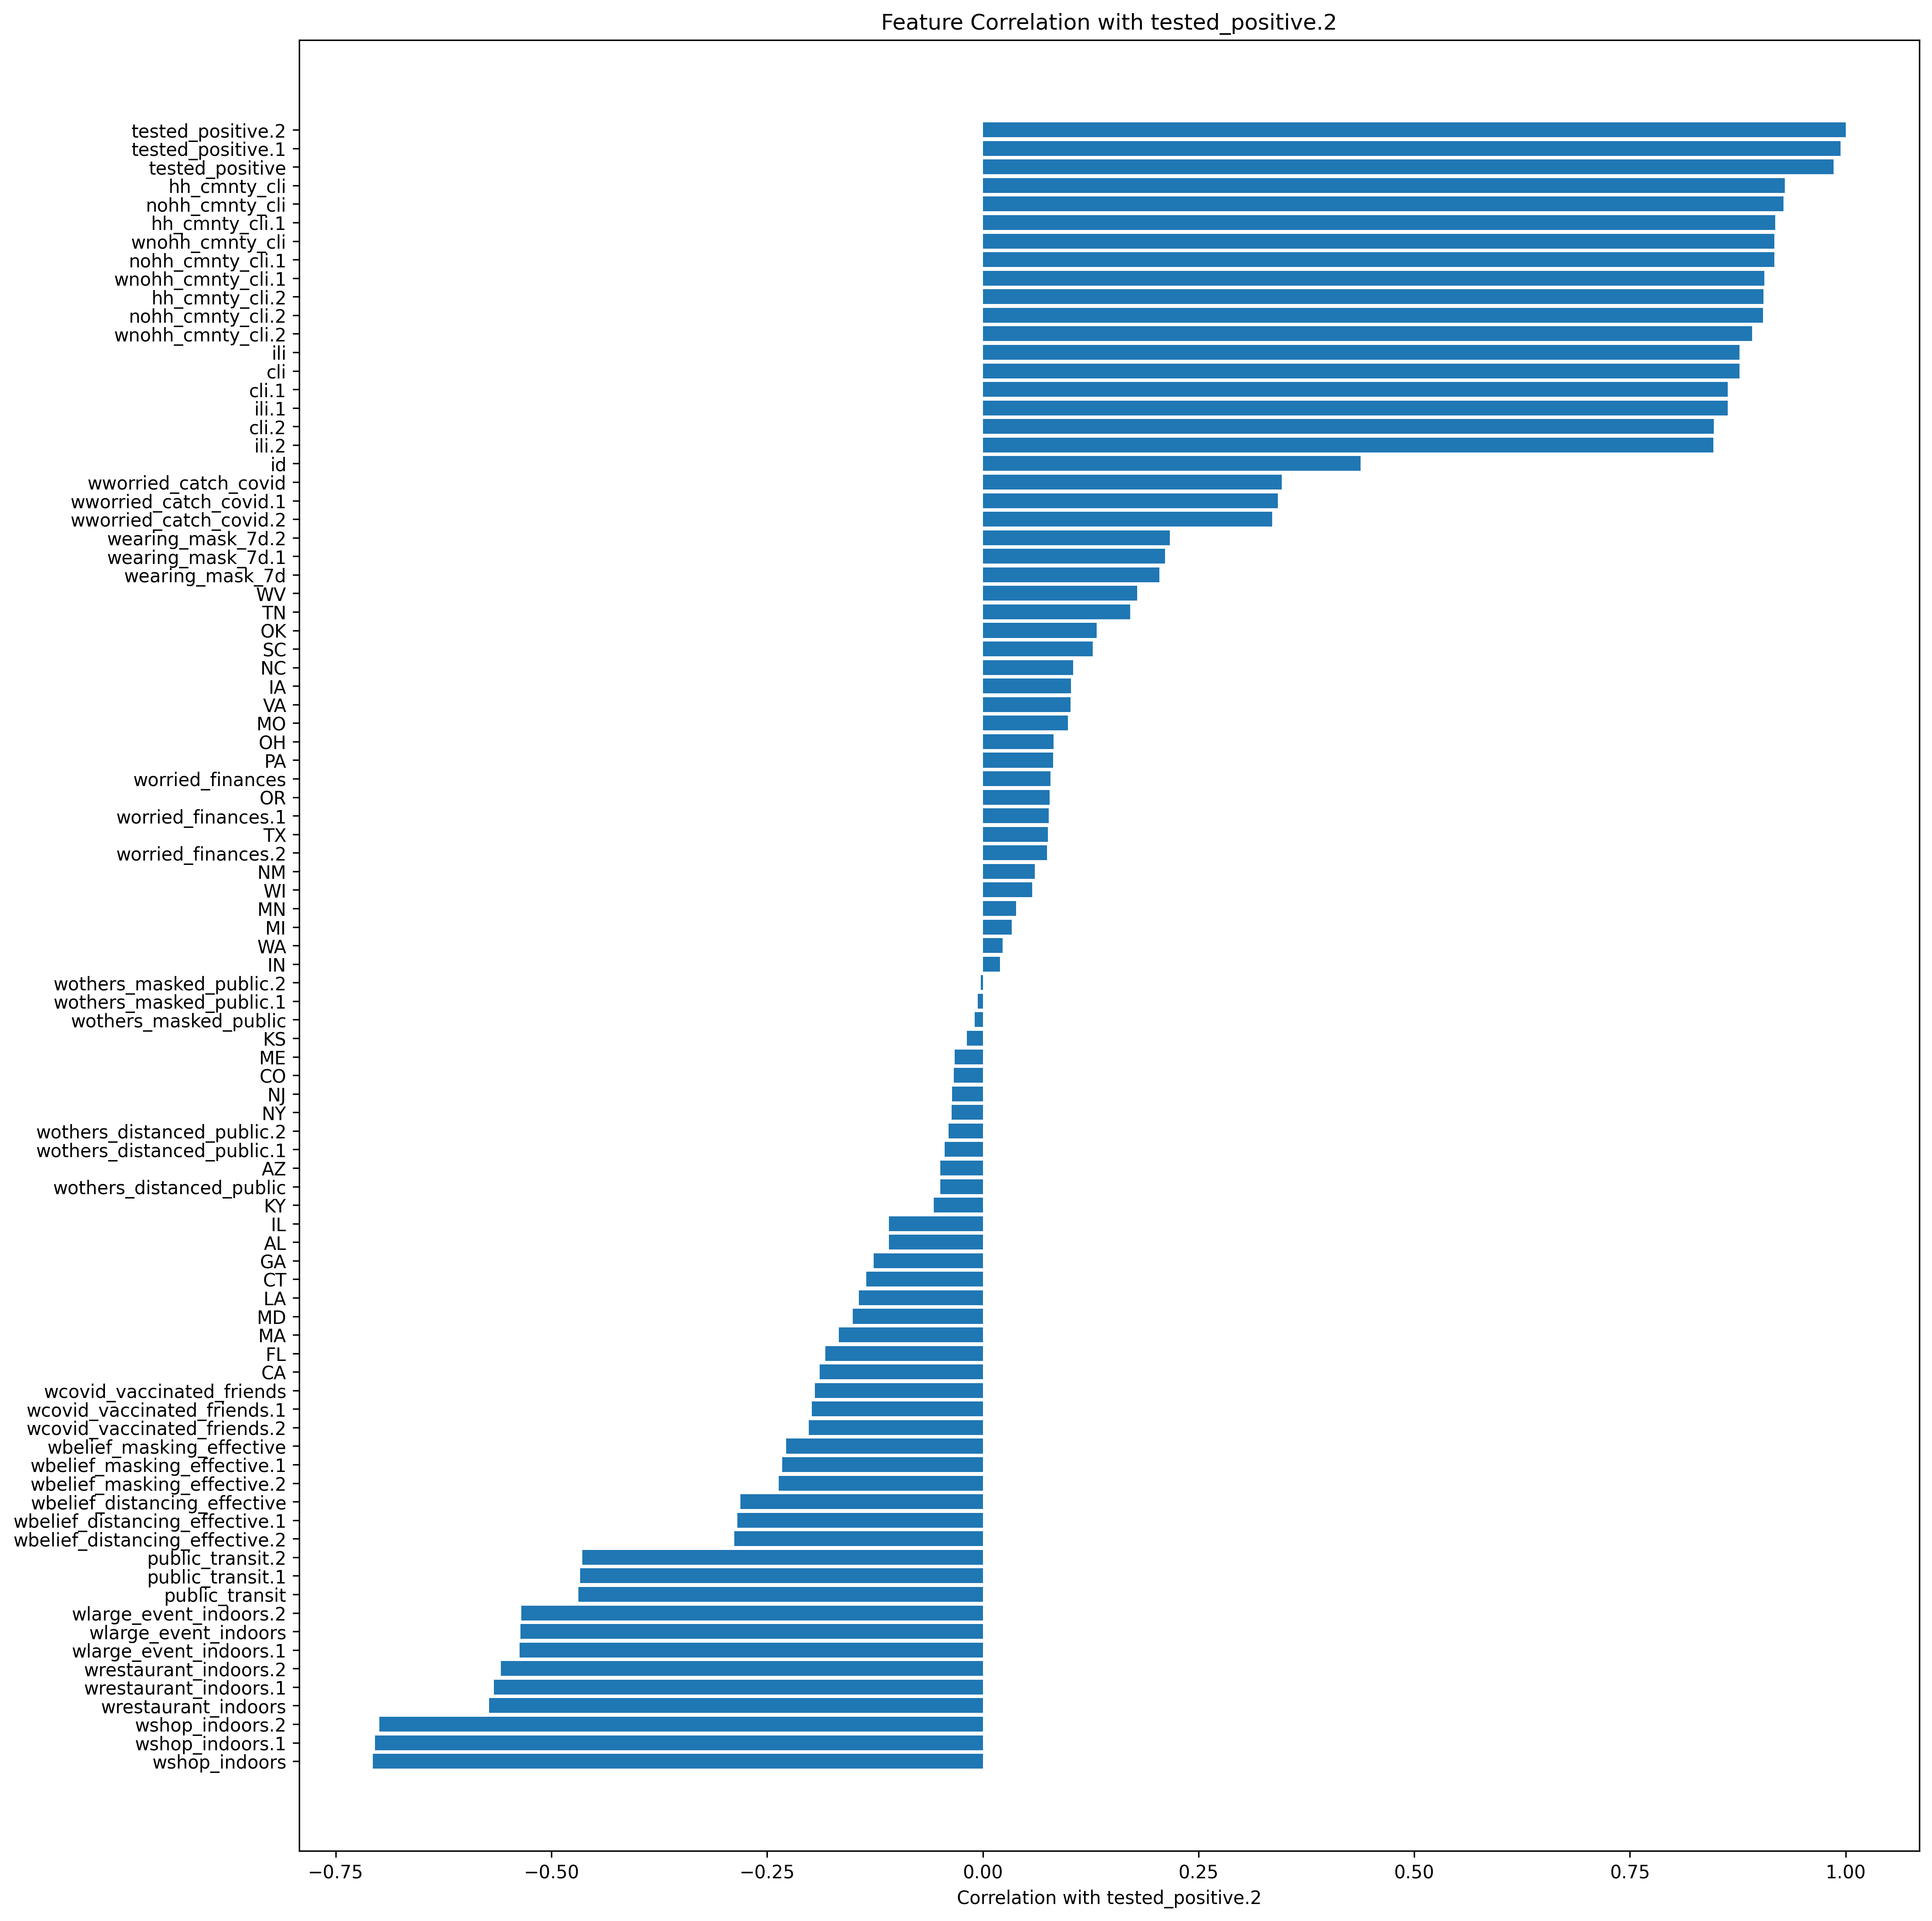

In [7]:
target = "tested_positive.2"
corr = data.corr(numeric_only=True)[target].dropna().sort_values()

plt.figure(figsize=(16, 18), dpi=300)
plt.barh(corr.index, corr.values)
plt.xlabel("Correlation with " + target)
plt.title("Feature Correlation with " + target)
plt.show()

In [8]:
corr = data.corr(numeric_only=True)["tested_positive.2"]
selected = corr[ corr.abs() > 0.7] 
selected = selected.drop("tested_positive.2", errors="ignore")
selected_features = selected.index.tolist()
feature_columns = data.columns[:-1] # 去掉target
feat_idx = [feature_columns.get_loc(col) for col in selected_features]

## 根据相关性筛选属性

In [9]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        #feat_idx = list(range(35, raw_x_train.shape[1])) # TODO: Select suitable feature columns.
        feat_idx = [feature_columns.get_loc(col) for col in selected_features]
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Training Loop

In [10]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'],weight_decay=config['weight_decay']) 
    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': False,   # Whether to use all features.
    'valid_ratio': 0.1,   # validation_size = train_size * valid_ratio
    'n_epochs': 8000,     # Number of epochs.            
    'batch_size': 128, 
    'learning_rate': 1e-5,              
    'early_stop': 2000,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt',  # Your model will be saved here.
    'weight_decay':1e-4
}

# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [12]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 3009 x 89 (35 states + 18 features x 3 days) 
# test_data size: 997 x 88 (without last day's positive rate)
train_data, test_data = pd.read_csv('./covid_train.csv').values, pd.read_csv('./covid_test.csv').values
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} 
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, config['select_all'])

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)


train_data size: (2709, 89) 
valid_data size: (300, 89) 
test_data size: (997, 88)
number of features: 19


# Start training!

In [13]:
model = My_Model(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/8000]: 100%|██████████| 22/22 [00:00<00:00, 34.68it/s, loss=225]


Epoch [1/8000]: Train loss: 307.5903, Valid loss: 327.6009
Saving model with loss 327.601...


Epoch [2/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.46it/s, loss=233]


Epoch [2/8000]: Train loss: 301.5658, Valid loss: 297.0860
Saving model with loss 297.086...


Epoch [3/8000]: 100%|██████████| 22/22 [00:00<00:00, 275.13it/s, loss=297]


Epoch [3/8000]: Train loss: 297.6116, Valid loss: 308.5363


Epoch [4/8000]: 100%|██████████| 22/22 [00:00<00:00, 298.38it/s, loss=248]


Epoch [4/8000]: Train loss: 289.1783, Valid loss: 310.9424


Epoch [5/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.83it/s, loss=355]


Epoch [5/8000]: Train loss: 286.5535, Valid loss: 292.8410
Saving model with loss 292.841...


Epoch [6/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.37it/s, loss=221]


Epoch [6/8000]: Train loss: 274.4207, Valid loss: 275.9170
Saving model with loss 275.917...


Epoch [7/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.26it/s, loss=338]


Epoch [7/8000]: Train loss: 271.6709, Valid loss: 263.0710
Saving model with loss 263.071...


Epoch [8/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.39it/s, loss=182]


Epoch [8/8000]: Train loss: 258.6071, Valid loss: 275.1589


Epoch [9/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.82it/s, loss=156]


Epoch [9/8000]: Train loss: 250.5878, Valid loss: 260.8118
Saving model with loss 260.812...


Epoch [10/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.49it/s, loss=224]


Epoch [10/8000]: Train loss: 246.3777, Valid loss: 270.6154


Epoch [11/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.87it/s, loss=187]


Epoch [11/8000]: Train loss: 238.3710, Valid loss: 243.9808
Saving model with loss 243.981...


Epoch [12/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.19it/s, loss=243]


Epoch [12/8000]: Train loss: 234.0271, Valid loss: 242.9218
Saving model with loss 242.922...


Epoch [13/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.56it/s, loss=383]

Epoch [13/8000]: Train loss: 232.9968, Valid loss: 231.3463


Saving model with loss 231.346...


Epoch [14/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.87it/s, loss=208]


Epoch [14/8000]: Train loss: 220.0863, Valid loss: 214.4281
Saving model with loss 214.428...


Epoch [15/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.91it/s, loss=128]


Epoch [15/8000]: Train loss: 211.0069, Valid loss: 219.5704


Epoch [16/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.86it/s, loss=283]


Epoch [16/8000]: Train loss: 210.9999, Valid loss: 222.0580


Epoch [17/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.45it/s, loss=121]


Epoch [17/8000]: Train loss: 199.1209, Valid loss: 207.3974
Saving model with loss 207.397...


Epoch [18/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.17it/s, loss=188]


Epoch [18/8000]: Train loss: 196.0229, Valid loss: 218.9822


Epoch [19/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.31it/s, loss=139]


Epoch [19/8000]: Train loss: 188.7095, Valid loss: 193.3327
Saving model with loss 193.333...


Epoch [20/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.46it/s, loss=138]


Epoch [20/8000]: Train loss: 183.2762, Valid loss: 197.1415


Epoch [21/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.85it/s, loss=176]


Epoch [21/8000]: Train loss: 179.5150, Valid loss: 208.0027


Epoch [22/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.07it/s, loss=212]


Epoch [22/8000]: Train loss: 175.7574, Valid loss: 181.7090
Saving model with loss 181.709...


Epoch [23/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.17it/s, loss=194]


Epoch [23/8000]: Train loss: 169.9884, Valid loss: 176.2862
Saving model with loss 176.286...


Epoch [24/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.87it/s, loss=200]


Epoch [24/8000]: Train loss: 165.2730, Valid loss: 176.4452


Epoch [25/8000]: 100%|██████████| 22/22 [00:00<00:00, 311.27it/s, loss=102]


Epoch [25/8000]: Train loss: 156.7136, Valid loss: 173.9024
Saving model with loss 173.902...


Epoch [26/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.74it/s, loss=168]


Epoch [26/8000]: Train loss: 154.5139, Valid loss: 174.6584


Epoch [27/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.49it/s, loss=202]


Epoch [27/8000]: Train loss: 151.2000, Valid loss: 148.4383
Saving model with loss 148.438...


Epoch [28/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.52it/s, loss=71.6]


Epoch [28/8000]: Train loss: 141.7219, Valid loss: 141.1643
Saving model with loss 141.164...


Epoch [29/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.68it/s, loss=223]


Epoch [29/8000]: Train loss: 143.0947, Valid loss: 151.8326


Epoch [30/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.47it/s, loss=90.5]


Epoch [30/8000]: Train loss: 133.7285, Valid loss: 141.4142


Epoch [31/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.80it/s, loss=172]


Epoch [31/8000]: Train loss: 132.6188, Valid loss: 133.2874
Saving model with loss 133.287...


Epoch [32/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.91it/s, loss=167]

Epoch [32/8000]: Train loss: 128.3255, Valid loss: 128.5660


Saving model with loss 128.566...


Epoch [33/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.09it/s, loss=181]


Epoch [33/8000]: Train loss: 124.7956, Valid loss: 126.1089
Saving model with loss 126.109...


Epoch [34/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.62it/s, loss=116]

Epoch [34/8000]: Train loss: 118.3321, Valid loss: 120.6214


Saving model with loss 120.621...


Epoch [35/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.25it/s, loss=119]


Epoch [35/8000]: Train loss: 114.5553, Valid loss: 113.1414
Saving model with loss 113.141...


Epoch [36/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.96it/s, loss=116]


Epoch [36/8000]: Train loss: 110.6339, Valid loss: 114.6645


Epoch [37/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.92it/s, loss=140]


Epoch [37/8000]: Train loss: 107.7771, Valid loss: 110.9191
Saving model with loss 110.919...


Epoch [38/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.21it/s, loss=63.6]


Epoch [38/8000]: Train loss: 101.1855, Valid loss: 102.8168
Saving model with loss 102.817...


Epoch [39/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.26it/s, loss=52.9]


Epoch [39/8000]: Train loss: 97.1573, Valid loss: 102.5303
Saving model with loss 102.530...


Epoch [40/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.96it/s, loss=141]


Epoch [40/8000]: Train loss: 97.0223, Valid loss: 99.2651
Saving model with loss 99.265...


Epoch [41/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.04it/s, loss=122]

Epoch [41/8000]: Train loss: 92.9104, Valid loss: 96.2507


Saving model with loss 96.251...


Epoch [42/8000]: 100%|██████████| 22/22 [00:00<00:00, 286.34it/s, loss=96.8]


Epoch [42/8000]: Train loss: 88.6237, Valid loss: 88.1788
Saving model with loss 88.179...


Epoch [43/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.57it/s, loss=120]


Epoch [43/8000]: Train loss: 86.3884, Valid loss: 92.4822


Epoch [44/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.53it/s, loss=54.7]


Epoch [44/8000]: Train loss: 80.9182, Valid loss: 90.3248


Epoch [45/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.16it/s, loss=56.3]


Epoch [45/8000]: Train loss: 78.1522, Valid loss: 87.4791
Saving model with loss 87.479...


Epoch [46/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.44it/s, loss=98.2]


Epoch [46/8000]: Train loss: 77.0802, Valid loss: 79.4758
Saving model with loss 79.476...


Epoch [47/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.43it/s, loss=52.1]

Epoch [47/8000]: Train loss: 72.7948, Valid loss: 78.9237


Saving model with loss 78.924...


Epoch [48/8000]: 100%|██████████| 22/22 [00:00<00:00, 282.15it/s, loss=83.6]


Epoch [48/8000]: Train loss: 71.5584, Valid loss: 71.2220
Saving model with loss 71.222...


Epoch [49/8000]: 100%|██████████| 22/22 [00:00<00:00, 296.80it/s, loss=65.1]


Epoch [49/8000]: Train loss: 68.5338, Valid loss: 69.8472
Saving model with loss 69.847...


Epoch [50/8000]: 100%|██████████| 22/22 [00:00<00:00, 304.76it/s, loss=60.6]


Epoch [50/8000]: Train loss: 66.1659, Valid loss: 70.9368


Epoch [51/8000]: 100%|██████████| 22/22 [00:00<00:00, 294.73it/s, loss=74.7]


Epoch [51/8000]: Train loss: 64.6149, Valid loss: 71.7240


Epoch [52/8000]: 100%|██████████| 22/22 [00:00<00:00, 293.38it/s, loss=49.7]


Epoch [52/8000]: Train loss: 61.6464, Valid loss: 64.1506
Saving model with loss 64.151...


Epoch [53/8000]: 100%|██████████| 22/22 [00:00<00:00, 296.46it/s, loss=94.7]


Epoch [53/8000]: Train loss: 61.4524, Valid loss: 63.1123
Saving model with loss 63.112...


Epoch [54/8000]: 100%|██████████| 22/22 [00:00<00:00, 300.79it/s, loss=102]


Epoch [54/8000]: Train loss: 59.9135, Valid loss: 61.7916
Saving model with loss 61.792...


Epoch [55/8000]: 100%|██████████| 22/22 [00:00<00:00, 295.61it/s, loss=38.5]

Epoch [55/8000]: Train loss: 55.7565, Valid loss: 61.4047


Saving model with loss 61.405...


Epoch [56/8000]: 100%|██████████| 22/22 [00:00<00:00, 301.11it/s, loss=48.6]


Epoch [56/8000]: Train loss: 54.5059, Valid loss: 62.9253


Epoch [57/8000]: 100%|██████████| 22/22 [00:00<00:00, 291.64it/s, loss=50.2]


Epoch [57/8000]: Train loss: 53.0514, Valid loss: 53.8376
Saving model with loss 53.838...


Epoch [58/8000]: 100%|██████████| 22/22 [00:00<00:00, 299.16it/s, loss=35.7]


Epoch [58/8000]: Train loss: 51.0531, Valid loss: 54.4954


Epoch [59/8000]: 100%|██████████| 22/22 [00:00<00:00, 302.09it/s, loss=26.3]

Epoch [59/8000]: Train loss: 49.3190, Valid loss: 53.4407


Saving model with loss 53.441...


Epoch [60/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.27it/s, loss=27.7]


Epoch [60/8000]: Train loss: 48.1061, Valid loss: 48.8647
Saving model with loss 48.865...


Epoch [61/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.51it/s, loss=49.5]


Epoch [61/8000]: Train loss: 47.7323, Valid loss: 49.1554


Epoch [62/8000]: 100%|██████████| 22/22 [00:00<00:00, 302.00it/s, loss=35.6]


Epoch [62/8000]: Train loss: 46.0412, Valid loss: 52.1081


Epoch [63/8000]: 100%|██████████| 22/22 [00:00<00:00, 300.52it/s, loss=36.3]


Epoch [63/8000]: Train loss: 44.9672, Valid loss: 48.9117


Epoch [64/8000]: 100%|██████████| 22/22 [00:00<00:00, 301.32it/s, loss=42.3]


Epoch [64/8000]: Train loss: 44.1648, Valid loss: 48.4619
Saving model with loss 48.462...


Epoch [65/8000]: 100%|██████████| 22/22 [00:00<00:00, 298.00it/s, loss=25.9]


Epoch [65/8000]: Train loss: 42.5375, Valid loss: 46.8235
Saving model with loss 46.823...


Epoch [66/8000]: 100%|██████████| 22/22 [00:00<00:00, 292.72it/s, loss=55]


Epoch [66/8000]: Train loss: 42.7209, Valid loss: 46.3867
Saving model with loss 46.387...


Epoch [67/8000]: 100%|██████████| 22/22 [00:00<00:00, 263.42it/s, loss=45.5]


Epoch [67/8000]: Train loss: 41.4730, Valid loss: 43.4443
Saving model with loss 43.444...


Epoch [68/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.61it/s, loss=40]

Epoch [68/8000]: Train loss: 40.4158, Valid loss: 41.5760


Saving model with loss 41.576...


Epoch [69/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.43it/s, loss=37.8]


Epoch [69/8000]: Train loss: 39.5432, Valid loss: 38.8783
Saving model with loss 38.878...


Epoch [70/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.01it/s, loss=61.9]


Epoch [70/8000]: Train loss: 39.6820, Valid loss: 42.5097


Epoch [71/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.66it/s, loss=40.1]


Epoch [71/8000]: Train loss: 38.1304, Valid loss: 42.0586


Epoch [72/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.85it/s, loss=72.7]


Epoch [72/8000]: Train loss: 38.6708, Valid loss: 42.1407


Epoch [73/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.27it/s, loss=20.3]


Epoch [73/8000]: Train loss: 36.0035, Valid loss: 37.4690
Saving model with loss 37.469...


Epoch [74/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.86it/s, loss=46.8]


Epoch [74/8000]: Train loss: 36.3770, Valid loss: 38.0384


Epoch [75/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.23it/s, loss=38.7]


Epoch [75/8000]: Train loss: 35.4714, Valid loss: 38.0991


Epoch [76/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.20it/s, loss=32.2]


Epoch [76/8000]: Train loss: 34.6387, Valid loss: 34.7090
Saving model with loss 34.709...


Epoch [77/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.30it/s, loss=24.2]


Epoch [77/8000]: Train loss: 33.7886, Valid loss: 36.1259


Epoch [78/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.39it/s, loss=30.9]


Epoch [78/8000]: Train loss: 33.4991, Valid loss: 36.0999


Epoch [79/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.96it/s, loss=22.2]


Epoch [79/8000]: Train loss: 32.6456, Valid loss: 35.1688


Epoch [80/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.22it/s, loss=37.1]


Epoch [80/8000]: Train loss: 32.7142, Valid loss: 35.0797


Epoch [81/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.68it/s, loss=46.2]


Epoch [81/8000]: Train loss: 32.5706, Valid loss: 36.3909


Epoch [82/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.84it/s, loss=33.6]


Epoch [82/8000]: Train loss: 31.5974, Valid loss: 31.4600
Saving model with loss 31.460...


Epoch [83/8000]: 100%|██████████| 22/22 [00:00<00:00, 291.04it/s, loss=21]


Epoch [83/8000]: Train loss: 30.6465, Valid loss: 35.1680


Epoch [84/8000]: 100%|██████████| 22/22 [00:00<00:00, 309.88it/s, loss=33.9]


Epoch [84/8000]: Train loss: 30.6730, Valid loss: 35.2375


Epoch [85/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.68it/s, loss=34.7]


Epoch [85/8000]: Train loss: 30.2604, Valid loss: 30.7743
Saving model with loss 30.774...


Epoch [86/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.62it/s, loss=14.9]


Epoch [86/8000]: Train loss: 29.0674, Valid loss: 31.0461


Epoch [87/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.32it/s, loss=18.2]


Epoch [87/8000]: Train loss: 28.7620, Valid loss: 32.6565


Epoch [88/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.69it/s, loss=36.1]


Epoch [88/8000]: Train loss: 29.0317, Valid loss: 29.3203
Saving model with loss 29.320...


Epoch [89/8000]: 100%|██████████| 22/22 [00:00<00:00, 312.61it/s, loss=25.2]


Epoch [89/8000]: Train loss: 28.1962, Valid loss: 30.9293


Epoch [90/8000]: 100%|██████████| 22/22 [00:00<00:00, 295.21it/s, loss=18.8]


Epoch [90/8000]: Train loss: 27.5484, Valid loss: 30.5500


Epoch [91/8000]: 100%|██████████| 22/22 [00:00<00:00, 288.71it/s, loss=30.7]


Epoch [91/8000]: Train loss: 27.5894, Valid loss: 28.7251
Saving model with loss 28.725...


Epoch [92/8000]: 100%|██████████| 22/22 [00:00<00:00, 312.35it/s, loss=36.6]


Epoch [92/8000]: Train loss: 27.4146, Valid loss: 31.0313


Epoch [93/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.18it/s, loss=23.5]


Epoch [93/8000]: Train loss: 26.5076, Valid loss: 29.7908


Epoch [94/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.51it/s, loss=21.1]


Epoch [94/8000]: Train loss: 26.0125, Valid loss: 28.5750
Saving model with loss 28.575...


Epoch [95/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.66it/s, loss=14.5]


Epoch [95/8000]: Train loss: 25.3684, Valid loss: 28.7830


Epoch [96/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.28it/s, loss=39]


Epoch [96/8000]: Train loss: 25.9022, Valid loss: 28.3846
Saving model with loss 28.385...


Epoch [97/8000]: 100%|██████████| 22/22 [00:00<00:00, 358.58it/s, loss=33.3]


Epoch [97/8000]: Train loss: 25.2823, Valid loss: 26.0767
Saving model with loss 26.077...


Epoch [98/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.44it/s, loss=13.8]


Epoch [98/8000]: Train loss: 24.1444, Valid loss: 26.8815


Epoch [99/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.50it/s, loss=39]


Epoch [99/8000]: Train loss: 24.7088, Valid loss: 27.2804


Epoch [100/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.27it/s, loss=22.4]

Epoch [100/8000]: Train loss: 23.6958, Valid loss: 25.2904


Saving model with loss 25.290...


Epoch [101/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.76it/s, loss=16.7]


Epoch [101/8000]: Train loss: 23.0937, Valid loss: 26.5635


Epoch [102/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.19it/s, loss=23.6]


Epoch [102/8000]: Train loss: 22.9747, Valid loss: 24.8432
Saving model with loss 24.843...


Epoch [103/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.94it/s, loss=13.5]


Epoch [103/8000]: Train loss: 22.2195, Valid loss: 25.3022


Epoch [104/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.30it/s, loss=25.9]


Epoch [104/8000]: Train loss: 22.3284, Valid loss: 24.4336
Saving model with loss 24.434...


Epoch [105/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.78it/s, loss=31.7]


Epoch [105/8000]: Train loss: 22.1952, Valid loss: 23.5329
Saving model with loss 23.533...


Epoch [106/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.59it/s, loss=32.3]


Epoch [106/8000]: Train loss: 21.8555, Valid loss: 24.5269


Epoch [107/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.12it/s, loss=14.3]


Epoch [107/8000]: Train loss: 20.8147, Valid loss: 24.2736


Epoch [108/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.24it/s, loss=21.8]


Epoch [108/8000]: Train loss: 20.7530, Valid loss: 24.0101


Epoch [109/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.35it/s, loss=13.9]


Epoch [109/8000]: Train loss: 20.1125, Valid loss: 21.5869
Saving model with loss 21.587...


Epoch [110/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.54it/s, loss=20.9]


Epoch [110/8000]: Train loss: 20.0448, Valid loss: 22.3540


Epoch [111/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.54it/s, loss=25.2]


Epoch [111/8000]: Train loss: 19.8790, Valid loss: 21.7388


Epoch [112/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.53it/s, loss=14.6]


Epoch [112/8000]: Train loss: 19.1458, Valid loss: 21.7206


Epoch [113/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.42it/s, loss=20.5]


Epoch [113/8000]: Train loss: 19.0484, Valid loss: 22.3041


Epoch [114/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.09it/s, loss=16]


Epoch [114/8000]: Train loss: 18.5587, Valid loss: 20.2423
Saving model with loss 20.242...


Epoch [115/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.99it/s, loss=13.2]


Epoch [115/8000]: Train loss: 18.1446, Valid loss: 21.5518


Epoch [116/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.28it/s, loss=19.6]


Epoch [116/8000]: Train loss: 18.0860, Valid loss: 19.9041
Saving model with loss 19.904...


Epoch [117/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.04it/s, loss=13.8]


Epoch [117/8000]: Train loss: 17.5741, Valid loss: 20.4848


Epoch [118/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.66it/s, loss=20.4]


Epoch [118/8000]: Train loss: 17.5340, Valid loss: 19.4351
Saving model with loss 19.435...


Epoch [119/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.49it/s, loss=12]


Epoch [119/8000]: Train loss: 16.9368, Valid loss: 17.9702
Saving model with loss 17.970...


Epoch [120/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.67it/s, loss=19.1]


Epoch [120/8000]: Train loss: 16.9373, Valid loss: 20.1466


Epoch [121/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.07it/s, loss=16.5]


Epoch [121/8000]: Train loss: 16.5677, Valid loss: 17.6683
Saving model with loss 17.668...


Epoch [122/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.02it/s, loss=13.5]


Epoch [122/8000]: Train loss: 16.1984, Valid loss: 18.8096


Epoch [123/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.44it/s, loss=10.1]


Epoch [123/8000]: Train loss: 15.8132, Valid loss: 18.1728


Epoch [124/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.90it/s, loss=16.9]


Epoch [124/8000]: Train loss: 15.8352, Valid loss: 17.4334
Saving model with loss 17.433...


Epoch [125/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.40it/s, loss=16.5]


Epoch [125/8000]: Train loss: 15.5735, Valid loss: 17.3960
Saving model with loss 17.396...


Epoch [126/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.08it/s, loss=13.1]


Epoch [126/8000]: Train loss: 15.2161, Valid loss: 18.2203


Epoch [127/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.63it/s, loss=13.8]


Epoch [127/8000]: Train loss: 15.0217, Valid loss: 15.9150
Saving model with loss 15.915...


Epoch [128/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.12it/s, loss=14]


Epoch [128/8000]: Train loss: 14.8122, Valid loss: 16.8202


Epoch [129/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.24it/s, loss=10.9]


Epoch [129/8000]: Train loss: 14.4873, Valid loss: 16.0923


Epoch [130/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.17it/s, loss=10.3]


Epoch [130/8000]: Train loss: 14.2605, Valid loss: 17.3344


Epoch [131/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.01it/s, loss=11.8]


Epoch [131/8000]: Train loss: 14.1226, Valid loss: 16.1826


Epoch [132/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.38it/s, loss=13.8]


Epoch [132/8000]: Train loss: 14.0059, Valid loss: 16.3753


Epoch [133/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.55it/s, loss=10]


Epoch [133/8000]: Train loss: 13.6743, Valid loss: 16.4700


Epoch [134/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.13it/s, loss=11.9]


Epoch [134/8000]: Train loss: 13.5592, Valid loss: 15.0556
Saving model with loss 15.056...


Epoch [135/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.40it/s, loss=7.69]


Epoch [135/8000]: Train loss: 13.2200, Valid loss: 14.1234
Saving model with loss 14.123...


Epoch [136/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.25it/s, loss=19.9]


Epoch [136/8000]: Train loss: 13.5140, Valid loss: 14.6750


Epoch [137/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.40it/s, loss=12.1]


Epoch [137/8000]: Train loss: 13.0475, Valid loss: 15.0597


Epoch [138/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.74it/s, loss=10.4]


Epoch [138/8000]: Train loss: 12.8206, Valid loss: 14.3518


Epoch [139/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.82it/s, loss=11.8]


Epoch [139/8000]: Train loss: 12.7216, Valid loss: 15.0392


Epoch [140/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.64it/s, loss=15.7]


Epoch [140/8000]: Train loss: 12.7109, Valid loss: 13.7166
Saving model with loss 13.717...


Epoch [141/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.85it/s, loss=8.98]


Epoch [141/8000]: Train loss: 12.3070, Valid loss: 13.3039
Saving model with loss 13.304...


Epoch [142/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.63it/s, loss=12.1]


Epoch [142/8000]: Train loss: 12.2741, Valid loss: 14.2881


Epoch [143/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.64it/s, loss=10.7]


Epoch [143/8000]: Train loss: 12.0845, Valid loss: 13.4168


Epoch [144/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.80it/s, loss=18]


Epoch [144/8000]: Train loss: 12.2249, Valid loss: 13.0214
Saving model with loss 13.021...


Epoch [145/8000]: 100%|██████████| 22/22 [00:00<00:00, 275.69it/s, loss=9.54]


Epoch [145/8000]: Train loss: 11.7702, Valid loss: 13.3723


Epoch [146/8000]: 100%|██████████| 22/22 [00:00<00:00, 291.32it/s, loss=10.9]


Epoch [146/8000]: Train loss: 11.6942, Valid loss: 13.8524


Epoch [147/8000]: 100%|██████████| 22/22 [00:00<00:00, 305.84it/s, loss=14.7]


Epoch [147/8000]: Train loss: 11.7116, Valid loss: 12.8145
Saving model with loss 12.815...


Epoch [148/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.28it/s, loss=9.85]


Epoch [148/8000]: Train loss: 11.4092, Valid loss: 13.7098


Epoch [149/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.38it/s, loss=13.3]


Epoch [149/8000]: Train loss: 11.4242, Valid loss: 13.7677


Epoch [150/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.58it/s, loss=9.78]


Epoch [150/8000]: Train loss: 11.1764, Valid loss: 12.8086
Saving model with loss 12.809...


Epoch [151/8000]: 100%|██████████| 22/22 [00:00<00:00, 294.78it/s, loss=13.8]


Epoch [151/8000]: Train loss: 11.2226, Valid loss: 13.1215


Epoch [152/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.61it/s, loss=10.3]

Epoch [152/8000]: Train loss: 10.9819, Valid loss: 12.5756


Saving model with loss 12.576...


Epoch [153/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.95it/s, loss=3.31]


Epoch [153/8000]: Train loss: 10.6127, Valid loss: 13.5481


Epoch [154/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.94it/s, loss=8.58]


Epoch [154/8000]: Train loss: 10.7146, Valid loss: 12.9743


Epoch [155/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.99it/s, loss=9.18]


Epoch [155/8000]: Train loss: 10.6420, Valid loss: 12.0775
Saving model with loss 12.077...


Epoch [156/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.04it/s, loss=8.83]


Epoch [156/8000]: Train loss: 10.5347, Valid loss: 11.8593
Saving model with loss 11.859...


Epoch [157/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.22it/s, loss=18.1]


Epoch [157/8000]: Train loss: 10.7959, Valid loss: 12.3760


Epoch [158/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.04it/s, loss=12.5]


Epoch [158/8000]: Train loss: 10.4949, Valid loss: 12.4892


Epoch [159/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.20it/s, loss=13.6]


Epoch [159/8000]: Train loss: 10.4563, Valid loss: 11.9897


Epoch [160/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.85it/s, loss=8.99]


Epoch [160/8000]: Train loss: 10.1979, Valid loss: 11.7149
Saving model with loss 11.715...


Epoch [161/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.53it/s, loss=8.31]


Epoch [161/8000]: Train loss: 10.0915, Valid loss: 11.2869
Saving model with loss 11.287...


Epoch [162/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.34it/s, loss=6.48]

Epoch [162/8000]: Train loss: 9.9474, Valid loss: 11.0118
Saving model with loss 11.012...



Epoch [163/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.25it/s, loss=13.9]


Epoch [163/8000]: Train loss: 10.1555, Valid loss: 11.1361


Epoch [164/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.28it/s, loss=7.53]


Epoch [164/8000]: Train loss: 9.8415, Valid loss: 12.4397


Epoch [165/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.28it/s, loss=7.51]


Epoch [165/8000]: Train loss: 9.7708, Valid loss: 11.2892


Epoch [166/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.74it/s, loss=8.23]


Epoch [166/8000]: Train loss: 9.7320, Valid loss: 10.9195
Saving model with loss 10.920...


Epoch [167/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.57it/s, loss=12.2]


Epoch [167/8000]: Train loss: 9.8169, Valid loss: 11.2945


Epoch [168/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.01it/s, loss=11.5]


Epoch [168/8000]: Train loss: 9.7270, Valid loss: 11.1272


Epoch [169/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.98it/s, loss=9.81]


Epoch [169/8000]: Train loss: 9.6014, Valid loss: 11.4580


Epoch [170/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.20it/s, loss=5.69]


Epoch [170/8000]: Train loss: 9.3842, Valid loss: 11.1157


Epoch [171/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.62it/s, loss=9.14]


Epoch [171/8000]: Train loss: 9.4591, Valid loss: 11.9372


Epoch [172/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.31it/s, loss=9.35]


Epoch [172/8000]: Train loss: 9.4128, Valid loss: 11.3934


Epoch [173/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.79it/s, loss=15.6]


Epoch [173/8000]: Train loss: 9.5974, Valid loss: 10.6509
Saving model with loss 10.651...


Epoch [174/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.86it/s, loss=6.27]


Epoch [174/8000]: Train loss: 9.1903, Valid loss: 10.9452


Epoch [175/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.84it/s, loss=8.02]

Epoch [175/8000]: Train loss: 9.2068, Valid loss: 10.6387


Saving model with loss 10.639...


Epoch [176/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.66it/s, loss=11.6]


Epoch [176/8000]: Train loss: 9.2937, Valid loss: 10.3208
Saving model with loss 10.321...


Epoch [177/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.96it/s, loss=6.46]


Epoch [177/8000]: Train loss: 9.0494, Valid loss: 11.1546


Epoch [178/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.80it/s, loss=13.8]


Epoch [178/8000]: Train loss: 9.2818, Valid loss: 10.3161
Saving model with loss 10.316...


Epoch [179/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.10it/s, loss=6.27]


Epoch [179/8000]: Train loss: 8.9510, Valid loss: 11.6349


Epoch [180/8000]: 100%|██████████| 22/22 [00:00<00:00, 312.96it/s, loss=9.71]


Epoch [180/8000]: Train loss: 9.0352, Valid loss: 10.1501
Saving model with loss 10.150...


Epoch [181/8000]: 100%|██████████| 22/22 [00:00<00:00, 287.46it/s, loss=6.88]


Epoch [181/8000]: Train loss: 8.8854, Valid loss: 9.9816
Saving model with loss 9.982...


Epoch [182/8000]: 100%|██████████| 22/22 [00:00<00:00, 299.51it/s, loss=9.93]


Epoch [182/8000]: Train loss: 8.9612, Valid loss: 10.7785


Epoch [183/8000]: 100%|██████████| 22/22 [00:00<00:00, 293.72it/s, loss=7.43]


Epoch [183/8000]: Train loss: 8.8224, Valid loss: 9.9322
Saving model with loss 9.932...


Epoch [184/8000]: 100%|██████████| 22/22 [00:00<00:00, 303.61it/s, loss=4.88]


Epoch [184/8000]: Train loss: 8.6855, Valid loss: 10.2640


Epoch [185/8000]: 100%|██████████| 22/22 [00:00<00:00, 302.45it/s, loss=9.04]


Epoch [185/8000]: Train loss: 8.8066, Valid loss: 10.5161


Epoch [186/8000]: 100%|██████████| 22/22 [00:00<00:00, 307.59it/s, loss=7.71]


Epoch [186/8000]: Train loss: 8.7192, Valid loss: 9.8533
Saving model with loss 9.853...


Epoch [187/8000]: 100%|██████████| 22/22 [00:00<00:00, 298.65it/s, loss=9.71]


Epoch [187/8000]: Train loss: 8.7605, Valid loss: 10.1047


Epoch [188/8000]: 100%|██████████| 22/22 [00:00<00:00, 305.10it/s, loss=7.76]


Epoch [188/8000]: Train loss: 8.6513, Valid loss: 10.4587


Epoch [189/8000]: 100%|██████████| 22/22 [00:00<00:00, 302.76it/s, loss=10.2]


Epoch [189/8000]: Train loss: 8.7112, Valid loss: 9.6183
Saving model with loss 9.618...


Epoch [190/8000]: 100%|██████████| 22/22 [00:00<00:00, 294.36it/s, loss=4.61]


Epoch [190/8000]: Train loss: 8.4630, Valid loss: 9.9210


Epoch [191/8000]: 100%|██████████| 22/22 [00:00<00:00, 66.54it/s, loss=4.62]


Epoch [191/8000]: Train loss: 8.4301, Valid loss: 9.5632
Saving model with loss 9.563...


Epoch [192/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.95it/s, loss=5.53]


Epoch [192/8000]: Train loss: 8.4311, Valid loss: 9.9118


Epoch [193/8000]: 100%|██████████| 22/22 [00:00<00:00, 308.25it/s, loss=7.73]


Epoch [193/8000]: Train loss: 8.4841, Valid loss: 10.2108


Epoch [194/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.02it/s, loss=12.4]


Epoch [194/8000]: Train loss: 8.6300, Valid loss: 9.3101
Saving model with loss 9.310...


Epoch [195/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.31it/s, loss=7.37]


Epoch [195/8000]: Train loss: 8.4089, Valid loss: 9.6376


Epoch [196/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.95it/s, loss=7.27]


Epoch [196/8000]: Train loss: 8.3758, Valid loss: 9.0436
Saving model with loss 9.044...


Epoch [197/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.13it/s, loss=3.76]


Epoch [197/8000]: Train loss: 8.2119, Valid loss: 9.6841


Epoch [198/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.66it/s, loss=15]


Epoch [198/8000]: Train loss: 8.6105, Valid loss: 9.6465


Epoch [199/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.71it/s, loss=8.77]


Epoch [199/8000]: Train loss: 8.3457, Valid loss: 9.3818


Epoch [200/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.84it/s, loss=4.61]


Epoch [200/8000]: Train loss: 8.1604, Valid loss: 9.4646


Epoch [201/8000]: 100%|██████████| 22/22 [00:00<00:00, 306.18it/s, loss=8.31]


Epoch [201/8000]: Train loss: 8.2731, Valid loss: 10.0738


Epoch [202/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.50it/s, loss=8.41]


Epoch [202/8000]: Train loss: 8.2500, Valid loss: 9.1952


Epoch [203/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.38it/s, loss=5.67]


Epoch [203/8000]: Train loss: 8.1198, Valid loss: 9.0079
Saving model with loss 9.008...


Epoch [204/8000]: 100%|██████████| 22/22 [00:00<00:00, 308.40it/s, loss=13.4]


Epoch [204/8000]: Train loss: 8.3871, Valid loss: 9.6961


Epoch [205/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.91it/s, loss=3.26]


Epoch [205/8000]: Train loss: 7.9747, Valid loss: 9.1341


Epoch [206/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.78it/s, loss=7.2]


Epoch [206/8000]: Train loss: 8.1001, Valid loss: 9.8521


Epoch [207/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.16it/s, loss=8.72]


Epoch [207/8000]: Train loss: 8.1314, Valid loss: 9.1396


Epoch [208/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.33it/s, loss=7.59]


Epoch [208/8000]: Train loss: 8.0625, Valid loss: 9.6350


Epoch [209/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.82it/s, loss=4.8]


Epoch [209/8000]: Train loss: 7.9320, Valid loss: 8.9260
Saving model with loss 8.926...


Epoch [210/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.25it/s, loss=7.55]


Epoch [210/8000]: Train loss: 8.0122, Valid loss: 9.3541


Epoch [211/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.34it/s, loss=5.3]


Epoch [211/8000]: Train loss: 7.9018, Valid loss: 8.9523


Epoch [212/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.05it/s, loss=8.33]


Epoch [212/8000]: Train loss: 7.9917, Valid loss: 9.4739


Epoch [213/8000]: 100%|██████████| 22/22 [00:00<00:00, 305.18it/s, loss=3.24]


Epoch [213/8000]: Train loss: 7.7734, Valid loss: 8.6561
Saving model with loss 8.656...


Epoch [214/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.31it/s, loss=9.18]


Epoch [214/8000]: Train loss: 7.9750, Valid loss: 9.1696


Epoch [215/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.57it/s, loss=11.5]


Epoch [215/8000]: Train loss: 8.0375, Valid loss: 9.4815


Epoch [216/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.65it/s, loss=8.71]


Epoch [216/8000]: Train loss: 7.9085, Valid loss: 8.9002


Epoch [217/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.01it/s, loss=9.08]


Epoch [217/8000]: Train loss: 7.9001, Valid loss: 9.1935


Epoch [218/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.51it/s, loss=5.91]


Epoch [218/8000]: Train loss: 7.7544, Valid loss: 8.4551
Saving model with loss 8.455...


Epoch [219/8000]: 100%|██████████| 22/22 [00:00<00:00, 291.77it/s, loss=7.65]


Epoch [219/8000]: Train loss: 7.7948, Valid loss: 9.0979


Epoch [220/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.44it/s, loss=5.75]


Epoch [220/8000]: Train loss: 7.7002, Valid loss: 8.7713


Epoch [221/8000]: 100%|██████████| 22/22 [00:00<00:00, 307.32it/s, loss=7.06]


Epoch [221/8000]: Train loss: 7.7257, Valid loss: 9.2981


Epoch [222/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.52it/s, loss=7.39]


Epoch [222/8000]: Train loss: 7.7147, Valid loss: 8.5192


Epoch [223/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.28it/s, loss=7.3]


Epoch [223/8000]: Train loss: 7.6878, Valid loss: 8.4992


Epoch [224/8000]: 100%|██████████| 22/22 [00:00<00:00, 296.94it/s, loss=14.8]


Epoch [224/8000]: Train loss: 7.9484, Valid loss: 8.8729


Epoch [225/8000]: 100%|██████████| 22/22 [00:00<00:00, 297.49it/s, loss=10.4]


Epoch [225/8000]: Train loss: 7.7578, Valid loss: 8.4448
Saving model with loss 8.445...


Epoch [226/8000]: 100%|██████████| 22/22 [00:00<00:00, 270.01it/s, loss=11.3]


Epoch [226/8000]: Train loss: 7.7665, Valid loss: 8.8058


Epoch [227/8000]: 100%|██████████| 22/22 [00:00<00:00, 273.07it/s, loss=6.79]


Epoch [227/8000]: Train loss: 7.5711, Valid loss: 9.0701


Epoch [228/8000]: 100%|██████████| 22/22 [00:00<00:00, 284.48it/s, loss=8.2]


Epoch [228/8000]: Train loss: 7.6021, Valid loss: 8.5143


Epoch [229/8000]: 100%|██████████| 22/22 [00:00<00:00, 295.09it/s, loss=5.85]


Epoch [229/8000]: Train loss: 7.4895, Valid loss: 8.4801


Epoch [230/8000]: 100%|██████████| 22/22 [00:00<00:00, 304.79it/s, loss=8.35]


Epoch [230/8000]: Train loss: 7.5605, Valid loss: 8.9738


Epoch [231/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.79it/s, loss=6.44]


Epoch [231/8000]: Train loss: 7.4638, Valid loss: 8.9284


Epoch [232/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.12it/s, loss=12.9]


Epoch [232/8000]: Train loss: 7.6847, Valid loss: 8.5939


Epoch [233/8000]: 100%|██████████| 22/22 [00:00<00:00, 306.70it/s, loss=6.82]


Epoch [233/8000]: Train loss: 7.4306, Valid loss: 8.4507


Epoch [234/8000]: 100%|██████████| 22/22 [00:00<00:00, 278.60it/s, loss=5.53]


Epoch [234/8000]: Train loss: 7.3571, Valid loss: 8.2640
Saving model with loss 8.264...


Epoch [235/8000]: 100%|██████████| 22/22 [00:00<00:00, 272.18it/s, loss=8.17]


Epoch [235/8000]: Train loss: 7.4322, Valid loss: 8.8386


Epoch [236/8000]: 100%|██████████| 22/22 [00:00<00:00, 282.98it/s, loss=6.28]


Epoch [236/8000]: Train loss: 7.3365, Valid loss: 8.6904


Epoch [237/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.45it/s, loss=6.24]


Epoch [237/8000]: Train loss: 7.3106, Valid loss: 7.8373
Saving model with loss 7.837...


Epoch [238/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.81it/s, loss=11.8]


Epoch [238/8000]: Train loss: 7.4996, Valid loss: 8.9834


Epoch [239/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.17it/s, loss=12.4]


Epoch [239/8000]: Train loss: 7.4986, Valid loss: 8.2716


Epoch [240/8000]: 100%|██████████| 22/22 [00:00<00:00, 288.13it/s, loss=11]


Epoch [240/8000]: Train loss: 7.4197, Valid loss: 7.6407
Saving model with loss 7.641...


Epoch [241/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.12it/s, loss=5.81]


Epoch [241/8000]: Train loss: 7.1961, Valid loss: 8.7919


Epoch [242/8000]: 100%|██████████| 22/22 [00:00<00:00, 302.93it/s, loss=4.06]


Epoch [242/8000]: Train loss: 7.1059, Valid loss: 8.7567


Epoch [243/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.04it/s, loss=5.5]


Epoch [243/8000]: Train loss: 7.1365, Valid loss: 8.5494


Epoch [244/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.27it/s, loss=4.09]


Epoch [244/8000]: Train loss: 7.0589, Valid loss: 8.1564


Epoch [245/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.09it/s, loss=6.76]


Epoch [245/8000]: Train loss: 7.1386, Valid loss: 7.8722


Epoch [246/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.21it/s, loss=4.66]


Epoch [246/8000]: Train loss: 7.0326, Valid loss: 8.5823


Epoch [247/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.77it/s, loss=9.84]


Epoch [247/8000]: Train loss: 7.2045, Valid loss: 7.9389


Epoch [248/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.06it/s, loss=10.2]


Epoch [248/8000]: Train loss: 7.1946, Valid loss: 7.9855


Epoch [249/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.14it/s, loss=7.14]


Epoch [249/8000]: Train loss: 7.0548, Valid loss: 8.1766


Epoch [250/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.58it/s, loss=8.01]


Epoch [250/8000]: Train loss: 7.0591, Valid loss: 7.5795
Saving model with loss 7.580...


Epoch [251/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.50it/s, loss=6.13]


Epoch [251/8000]: Train loss: 6.9642, Valid loss: 7.9875


Epoch [252/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.58it/s, loss=9.38]


Epoch [252/8000]: Train loss: 7.0619, Valid loss: 8.0864


Epoch [253/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.18it/s, loss=7.08]


Epoch [253/8000]: Train loss: 6.9523, Valid loss: 8.3801


Epoch [254/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.58it/s, loss=5.94]


Epoch [254/8000]: Train loss: 6.8797, Valid loss: 8.3583


Epoch [255/8000]: 100%|██████████| 22/22 [00:00<00:00, 377.52it/s, loss=4.08]


Epoch [255/8000]: Train loss: 6.7852, Valid loss: 7.4698
Saving model with loss 7.470...


Epoch [256/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.60it/s, loss=6.17]


Epoch [256/8000]: Train loss: 6.8403, Valid loss: 7.5717


Epoch [257/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.16it/s, loss=3.62]


Epoch [257/8000]: Train loss: 6.7182, Valid loss: 7.6448


Epoch [258/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.70it/s, loss=7.17]


Epoch [258/8000]: Train loss: 6.8297, Valid loss: 7.4786


Epoch [259/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.27it/s, loss=4.15]


Epoch [259/8000]: Train loss: 6.6862, Valid loss: 8.2099


Epoch [260/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.75it/s, loss=7.2]


Epoch [260/8000]: Train loss: 6.7762, Valid loss: 7.8120


Epoch [261/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.26it/s, loss=9.53]


Epoch [261/8000]: Train loss: 6.8389, Valid loss: 8.8223


Epoch [262/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.77it/s, loss=3.69]


Epoch [262/8000]: Train loss: 6.5922, Valid loss: 7.6592


Epoch [263/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.34it/s, loss=7.64]

Epoch [263/8000]: Train loss: 6.7156, Valid loss: 7.9348

Epoch [264/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.23it/s, loss=7.66]


Epoch [264/8000]: Train loss: 6.6905, Valid loss: 7.8418


Epoch [265/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.29it/s, loss=6.3]


Epoch [265/8000]: Train loss: 6.6116, Valid loss: 7.4084
Saving model with loss 7.408...


Epoch [266/8000]: 100%|██████████| 22/22 [00:00<00:00, 373.78it/s, loss=8.65]


Epoch [266/8000]: Train loss: 6.6744, Valid loss: 7.7933


Epoch [267/8000]: 100%|██████████| 22/22 [00:00<00:00, 374.59it/s, loss=3.86]

Epoch [267/8000]: Train loss: 6.4662, Valid loss: 7.1323


Saving model with loss 7.132...


Epoch [268/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.22it/s, loss=5.84]


Epoch [268/8000]: Train loss: 6.5143, Valid loss: 7.1624


Epoch [269/8000]: 100%|██████████| 22/22 [00:00<00:00, 372.95it/s, loss=10]


Epoch [269/8000]: Train loss: 6.6479, Valid loss: 7.2106


Epoch [270/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.05it/s, loss=5.37]


Epoch [270/8000]: Train loss: 6.4421, Valid loss: 7.8662


Epoch [271/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.83it/s, loss=7.79]


Epoch [271/8000]: Train loss: 6.5084, Valid loss: 7.3011


Epoch [272/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.03it/s, loss=4.6]


Epoch [272/8000]: Train loss: 6.3592, Valid loss: 6.9967
Saving model with loss 6.997...


Epoch [273/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.42it/s, loss=4.12]


Epoch [273/8000]: Train loss: 6.3146, Valid loss: 7.2869


Epoch [274/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.25it/s, loss=2.95]


Epoch [274/8000]: Train loss: 6.2430, Valid loss: 7.6986


Epoch [275/8000]: 100%|██████████| 22/22 [00:00<00:00, 308.37it/s, loss=5.7]


Epoch [275/8000]: Train loss: 6.3193, Valid loss: 7.2839


Epoch [276/8000]: 100%|██████████| 22/22 [00:00<00:00, 304.51it/s, loss=4.94]


Epoch [276/8000]: Train loss: 6.2634, Valid loss: 7.3113


Epoch [277/8000]: 100%|██████████| 22/22 [00:00<00:00, 286.49it/s, loss=8.86]


Epoch [277/8000]: Train loss: 6.3845, Valid loss: 6.9993


Epoch [278/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.20it/s, loss=6.81]


Epoch [278/8000]: Train loss: 6.2800, Valid loss: 7.3209


Epoch [279/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.68it/s, loss=5.74]


Epoch [279/8000]: Train loss: 6.2108, Valid loss: 6.5910
Saving model with loss 6.591...


Epoch [280/8000]: 100%|██████████| 22/22 [00:00<00:00, 297.77it/s, loss=9.23]


Epoch [280/8000]: Train loss: 6.3150, Valid loss: 6.7660


Epoch [281/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.20it/s, loss=7.03]


Epoch [281/8000]: Train loss: 6.2075, Valid loss: 7.0550


Epoch [282/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.97it/s, loss=8.86]


Epoch [282/8000]: Train loss: 6.2432, Valid loss: 7.0150


Epoch [283/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.81it/s, loss=3.4]


Epoch [283/8000]: Train loss: 6.0081, Valid loss: 6.8076


Epoch [284/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.11it/s, loss=7.62]


Epoch [284/8000]: Train loss: 6.1395, Valid loss: 6.7060


Epoch [285/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.05it/s, loss=7.15]


Epoch [285/8000]: Train loss: 6.0929, Valid loss: 6.6875


Epoch [286/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.65it/s, loss=10.8]


Epoch [286/8000]: Train loss: 6.2040, Valid loss: 6.9337


Epoch [287/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.11it/s, loss=9.12]


Epoch [287/8000]: Train loss: 6.1108, Valid loss: 6.9074


Epoch [288/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.71it/s, loss=6.85]


Epoch [288/8000]: Train loss: 5.9947, Valid loss: 6.5627
Saving model with loss 6.563...


Epoch [289/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.42it/s, loss=9.27]


Epoch [289/8000]: Train loss: 6.0568, Valid loss: 6.6914


Epoch [290/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.30it/s, loss=6.12]


Epoch [290/8000]: Train loss: 5.9084, Valid loss: 6.5113
Saving model with loss 6.511...


Epoch [291/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.78it/s, loss=8.35]


Epoch [291/8000]: Train loss: 5.9644, Valid loss: 7.2968


Epoch [292/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.16it/s, loss=5.79]


Epoch [292/8000]: Train loss: 5.8396, Valid loss: 6.5302


Epoch [293/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.48it/s, loss=3.58]


Epoch [293/8000]: Train loss: 5.7267, Valid loss: 6.6759


Epoch [294/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.36it/s, loss=4.41]


Epoch [294/8000]: Train loss: 5.7291, Valid loss: 6.3146
Saving model with loss 6.315...


Epoch [295/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.06it/s, loss=6.83]


Epoch [295/8000]: Train loss: 5.7936, Valid loss: 6.6179


Epoch [296/8000]: 100%|██████████| 22/22 [00:00<00:00, 370.07it/s, loss=6.16]


Epoch [296/8000]: Train loss: 5.7390, Valid loss: 6.3585


Epoch [297/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.17it/s, loss=4.65]


Epoch [297/8000]: Train loss: 5.6522, Valid loss: 6.3417


Epoch [298/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.77it/s, loss=4.42]


Epoch [298/8000]: Train loss: 5.6154, Valid loss: 6.8639


Epoch [299/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.42it/s, loss=4.08]


Epoch [299/8000]: Train loss: 5.5784, Valid loss: 6.6664


Epoch [300/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.23it/s, loss=4.07]


Epoch [300/8000]: Train loss: 5.5462, Valid loss: 6.4979


Epoch [301/8000]: 100%|██████████| 22/22 [00:00<00:00, 374.83it/s, loss=6.53]


Epoch [301/8000]: Train loss: 5.6114, Valid loss: 6.5044


Epoch [302/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.99it/s, loss=4.76]


Epoch [302/8000]: Train loss: 5.5159, Valid loss: 6.0605
Saving model with loss 6.061...


Epoch [303/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.66it/s, loss=4.76]


Epoch [303/8000]: Train loss: 5.4914, Valid loss: 6.3338


Epoch [304/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.37it/s, loss=5.02]


Epoch [304/8000]: Train loss: 5.4677, Valid loss: 6.0597
Saving model with loss 6.060...


Epoch [305/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.26it/s, loss=5.35]


Epoch [305/8000]: Train loss: 5.4516, Valid loss: 5.9357
Saving model with loss 5.936...


Epoch [306/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.53it/s, loss=4.92]


Epoch [306/8000]: Train loss: 5.4089, Valid loss: 6.4340


Epoch [307/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.95it/s, loss=5.28]


Epoch [307/8000]: Train loss: 5.3900, Valid loss: 6.2521


Epoch [308/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.22it/s, loss=3.45]


Epoch [308/8000]: Train loss: 5.2926, Valid loss: 6.2464


Epoch [309/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.04it/s, loss=6.95]


Epoch [309/8000]: Train loss: 5.3979, Valid loss: 6.4153


Epoch [310/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.16it/s, loss=3.11]

Epoch [310/8000]: Train loss: 5.2215, Valid loss: 5.8825


Saving model with loss 5.883...


Epoch [311/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.17it/s, loss=3.95]


Epoch [311/8000]: Train loss: 5.2248, Valid loss: 5.9660


Epoch [312/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.15it/s, loss=7.05]


Epoch [312/8000]: Train loss: 5.3151, Valid loss: 5.7614
Saving model with loss 5.761...


Epoch [313/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.44it/s, loss=8.48]


Epoch [313/8000]: Train loss: 5.3385, Valid loss: 6.0155


Epoch [314/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.51it/s, loss=5.35]


Epoch [314/8000]: Train loss: 5.1892, Valid loss: 5.6958
Saving model with loss 5.696...


Epoch [315/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.64it/s, loss=5.87]


Epoch [315/8000]: Train loss: 5.1802, Valid loss: 6.0569


Epoch [316/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.11it/s, loss=2.93]


Epoch [316/8000]: Train loss: 5.0380, Valid loss: 5.8406


Epoch [317/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.27it/s, loss=6.4]


Epoch [317/8000]: Train loss: 5.1413, Valid loss: 5.4456
Saving model with loss 5.446...


Epoch [318/8000]: 100%|██████████| 22/22 [00:00<00:00, 377.51it/s, loss=4.78]


Epoch [318/8000]: Train loss: 5.0481, Valid loss: 5.7000


Epoch [319/8000]: 100%|██████████| 22/22 [00:00<00:00, 375.05it/s, loss=3.2]


Epoch [319/8000]: Train loss: 4.9597, Valid loss: 5.8726


Epoch [320/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.67it/s, loss=9.07]


Epoch [320/8000]: Train loss: 5.1539, Valid loss: 5.6785


Epoch [321/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.82it/s, loss=4.12]


Epoch [321/8000]: Train loss: 4.9357, Valid loss: 5.8097


Epoch [322/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.64it/s, loss=5.82]


Epoch [322/8000]: Train loss: 4.9705, Valid loss: 5.4977


Epoch [323/8000]: 100%|██████████| 22/22 [00:00<00:00, 370.14it/s, loss=3.61]


Epoch [323/8000]: Train loss: 4.8594, Valid loss: 5.4697


Epoch [324/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.30it/s, loss=5.99]


Epoch [324/8000]: Train loss: 4.9169, Valid loss: 5.7792


Epoch [325/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.08it/s, loss=3.92]


Epoch [325/8000]: Train loss: 4.8095, Valid loss: 5.6343


Epoch [326/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.98it/s, loss=5.14]


Epoch [326/8000]: Train loss: 4.8284, Valid loss: 5.3559
Saving model with loss 5.356...


Epoch [327/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.97it/s, loss=4.42]


Epoch [327/8000]: Train loss: 4.7731, Valid loss: 5.8089


Epoch [328/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.36it/s, loss=3]


Epoch [328/8000]: Train loss: 4.6889, Valid loss: 5.3167
Saving model with loss 5.317...


Epoch [329/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.45it/s, loss=2.63]


Epoch [329/8000]: Train loss: 4.6473, Valid loss: 5.2911
Saving model with loss 5.291...


Epoch [330/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.03it/s, loss=3.37]

Epoch [330/8000]: Train loss: 4.6464, Valid loss: 4.8210


Saving model with loss 4.821...


Epoch [331/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.17it/s, loss=6.82]


Epoch [331/8000]: Train loss: 4.7507, Valid loss: 5.4849


Epoch [332/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.24it/s, loss=4.51]


Epoch [332/8000]: Train loss: 4.6339, Valid loss: 5.1743


Epoch [333/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.50it/s, loss=4.97]


Epoch [333/8000]: Train loss: 4.6225, Valid loss: 5.2639


Epoch [334/8000]: 100%|██████████| 22/22 [00:00<00:00, 376.49it/s, loss=4.94]


Epoch [334/8000]: Train loss: 4.5931, Valid loss: 5.2693


Epoch [335/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.25it/s, loss=4.06]


Epoch [335/8000]: Train loss: 4.5308, Valid loss: 5.2387


Epoch [336/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.48it/s, loss=3.3]


Epoch [336/8000]: Train loss: 4.4744, Valid loss: 4.9361


Epoch [337/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.38it/s, loss=6.59]


Epoch [337/8000]: Train loss: 4.5707, Valid loss: 4.9339


Epoch [338/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.41it/s, loss=3.69]


Epoch [338/8000]: Train loss: 4.4338, Valid loss: 5.2337


Epoch [339/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.17it/s, loss=3.26]


Epoch [339/8000]: Train loss: 4.3880, Valid loss: 4.9137


Epoch [340/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.28it/s, loss=3.55]


Epoch [340/8000]: Train loss: 4.3727, Valid loss: 4.9945


Epoch [341/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.93it/s, loss=4.01]


Epoch [341/8000]: Train loss: 4.3618, Valid loss: 4.8370


Epoch [342/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.09it/s, loss=5.43]


Epoch [342/8000]: Train loss: 4.3897, Valid loss: 4.7216
Saving model with loss 4.722...


Epoch [343/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.41it/s, loss=3.27]


Epoch [343/8000]: Train loss: 4.2803, Valid loss: 4.9012


Epoch [344/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.19it/s, loss=6.06]


Epoch [344/8000]: Train loss: 4.3575, Valid loss: 4.7031
Saving model with loss 4.703...


Epoch [345/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.68it/s, loss=4.59]


Epoch [345/8000]: Train loss: 4.2763, Valid loss: 4.7336


Epoch [346/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.05it/s, loss=4.2]


Epoch [346/8000]: Train loss: 4.2346, Valid loss: 4.9294


Epoch [347/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.20it/s, loss=4.21]


Epoch [347/8000]: Train loss: 4.2070, Valid loss: 4.5446
Saving model with loss 4.545...


Epoch [348/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.39it/s, loss=2.06]


Epoch [348/8000]: Train loss: 4.0977, Valid loss: 4.3783
Saving model with loss 4.378...


Epoch [349/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.05it/s, loss=4.72]


Epoch [349/8000]: Train loss: 4.1726, Valid loss: 4.5500


Epoch [350/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.01it/s, loss=5.38]


Epoch [350/8000]: Train loss: 4.1720, Valid loss: 4.6875


Epoch [351/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.47it/s, loss=3.9]


Epoch [351/8000]: Train loss: 4.0890, Valid loss: 4.2733
Saving model with loss 4.273...


Epoch [352/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.18it/s, loss=3.87]


Epoch [352/8000]: Train loss: 4.0602, Valid loss: 4.0760
Saving model with loss 4.076...


Epoch [353/8000]: 100%|██████████| 22/22 [00:00<00:00, 303.35it/s, loss=2.26]


Epoch [353/8000]: Train loss: 3.9723, Valid loss: 4.2757


Epoch [354/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.65it/s, loss=2.54]


Epoch [354/8000]: Train loss: 3.9584, Valid loss: 4.6091


Epoch [355/8000]: 100%|██████████| 22/22 [00:00<00:00, 394.87it/s, loss=2.93]


Epoch [355/8000]: Train loss: 3.9465, Valid loss: 4.4764


Epoch [356/8000]: 100%|██████████| 22/22 [00:00<00:00, 369.18it/s, loss=3.74]


Epoch [356/8000]: Train loss: 3.9534, Valid loss: 4.5547


Epoch [357/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.16it/s, loss=1.36]


Epoch [357/8000]: Train loss: 3.8362, Valid loss: 4.2668


Epoch [358/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.82it/s, loss=4.54]


Epoch [358/8000]: Train loss: 3.9301, Valid loss: 4.6525


Epoch [359/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.40it/s, loss=3.65]


Epoch [359/8000]: Train loss: 3.8706, Valid loss: 4.1235


Epoch [360/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.44it/s, loss=4.09]


Epoch [360/8000]: Train loss: 3.8629, Valid loss: 4.1954


Epoch [361/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.02it/s, loss=2.52]


Epoch [361/8000]: Train loss: 3.7776, Valid loss: 4.2266


Epoch [362/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.21it/s, loss=2.77]


Epoch [362/8000]: Train loss: 3.7609, Valid loss: 4.3472


Epoch [363/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.61it/s, loss=4.07]


Epoch [363/8000]: Train loss: 3.7848, Valid loss: 4.1389


Epoch [364/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.26it/s, loss=2.79]


Epoch [364/8000]: Train loss: 3.7129, Valid loss: 4.2690


Epoch [365/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.13it/s, loss=2.71]


Epoch [365/8000]: Train loss: 3.6833, Valid loss: 4.2512


Epoch [366/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.22it/s, loss=4.71]


Epoch [366/8000]: Train loss: 3.7347, Valid loss: 4.3582


Epoch [367/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.32it/s, loss=1.49]


Epoch [367/8000]: Train loss: 3.5879, Valid loss: 3.9299
Saving model with loss 3.930...


Epoch [368/8000]: 100%|██████████| 22/22 [00:00<00:00, 294.50it/s, loss=1.87]


Epoch [368/8000]: Train loss: 3.5795, Valid loss: 3.9248
Saving model with loss 3.925...


Epoch [369/8000]: 100%|██████████| 22/22 [00:00<00:00, 307.65it/s, loss=3.17]


Epoch [369/8000]: Train loss: 3.6007, Valid loss: 4.2105


Epoch [370/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.58it/s, loss=2.22]


Epoch [370/8000]: Train loss: 3.5421, Valid loss: 4.1136


Epoch [371/8000]: 100%|██████████| 22/22 [00:00<00:00, 305.62it/s, loss=2.18]


Epoch [371/8000]: Train loss: 3.5163, Valid loss: 3.6846
Saving model with loss 3.685...


Epoch [372/8000]: 100%|██████████| 22/22 [00:00<00:00, 304.53it/s, loss=3.41]


Epoch [372/8000]: Train loss: 3.5386, Valid loss: 3.8000


Epoch [373/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.53it/s, loss=3.83]


Epoch [373/8000]: Train loss: 3.5300, Valid loss: 3.7066


Epoch [374/8000]: 100%|██████████| 22/22 [00:00<00:00, 306.08it/s, loss=1.89]


Epoch [374/8000]: Train loss: 3.4328, Valid loss: 3.8864


Epoch [375/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.14it/s, loss=3.93]


Epoch [375/8000]: Train loss: 3.4892, Valid loss: 4.0156


Epoch [376/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.22it/s, loss=2.61]


Epoch [376/8000]: Train loss: 3.4152, Valid loss: 3.8994


Epoch [377/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.96it/s, loss=2.46]


Epoch [377/8000]: Train loss: 3.3843, Valid loss: 3.6569
Saving model with loss 3.657...


Epoch [378/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.84it/s, loss=4.86]


Epoch [378/8000]: Train loss: 3.4549, Valid loss: 3.9102


Epoch [379/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.50it/s, loss=3.14]


Epoch [379/8000]: Train loss: 3.3657, Valid loss: 3.7926


Epoch [380/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.94it/s, loss=2.87]


Epoch [380/8000]: Train loss: 3.3314, Valid loss: 3.6608


Epoch [381/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.41it/s, loss=3.04]


Epoch [381/8000]: Train loss: 3.3142, Valid loss: 3.5076
Saving model with loss 3.508...


Epoch [382/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.65it/s, loss=3.55]


Epoch [382/8000]: Train loss: 3.3100, Valid loss: 3.3987
Saving model with loss 3.399...


Epoch [383/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.56it/s, loss=3.37]


Epoch [383/8000]: Train loss: 3.2791, Valid loss: 3.8138


Epoch [384/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.17it/s, loss=1.82]


Epoch [384/8000]: Train loss: 3.1979, Valid loss: 3.7040


Epoch [385/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.34it/s, loss=2.72]


Epoch [385/8000]: Train loss: 3.2115, Valid loss: 3.7000


Epoch [386/8000]: 100%|██████████| 22/22 [00:00<00:00, 309.23it/s, loss=3.88]


Epoch [386/8000]: Train loss: 3.2341, Valid loss: 3.5876


Epoch [387/8000]: 100%|██████████| 22/22 [00:00<00:00, 306.04it/s, loss=4.95]


Epoch [387/8000]: Train loss: 3.2529, Valid loss: 3.3920
Saving model with loss 3.392...


Epoch [388/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.95it/s, loss=0.945]


Epoch [388/8000]: Train loss: 3.0760, Valid loss: 3.4897


Epoch [389/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.56it/s, loss=1.8]


Epoch [389/8000]: Train loss: 3.0853, Valid loss: 3.3797
Saving model with loss 3.380...


Epoch [390/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.22it/s, loss=3.7]


Epoch [390/8000]: Train loss: 3.1361, Valid loss: 3.5080


Epoch [391/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.79it/s, loss=2.5]


Epoch [391/8000]: Train loss: 3.0702, Valid loss: 3.4524


Epoch [392/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.99it/s, loss=3.28]


Epoch [392/8000]: Train loss: 3.0779, Valid loss: 3.3861


Epoch [393/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.46it/s, loss=2.3]


Epoch [393/8000]: Train loss: 3.0189, Valid loss: 3.2854
Saving model with loss 3.285...


Epoch [394/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.61it/s, loss=1.99]


Epoch [394/8000]: Train loss: 2.9859, Valid loss: 3.5729


Epoch [395/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.72it/s, loss=3.11]


Epoch [395/8000]: Train loss: 3.0071, Valid loss: 3.4367


Epoch [396/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.84it/s, loss=3.22]


Epoch [396/8000]: Train loss: 2.9910, Valid loss: 3.3489


Epoch [397/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.77it/s, loss=4.08]


Epoch [397/8000]: Train loss: 3.0028, Valid loss: 3.1130
Saving model with loss 3.113...


Epoch [398/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.77it/s, loss=3.78]


Epoch [398/8000]: Train loss: 2.9722, Valid loss: 3.0511
Saving model with loss 3.051...


Epoch [399/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.38it/s, loss=2.96]


Epoch [399/8000]: Train loss: 2.9190, Valid loss: 3.1604


Epoch [400/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.95it/s, loss=2.49]


Epoch [400/8000]: Train loss: 2.8798, Valid loss: 3.1597


Epoch [401/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.84it/s, loss=3.6]


Epoch [401/8000]: Train loss: 2.9025, Valid loss: 3.2750


Epoch [402/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.13it/s, loss=0.933]


Epoch [402/8000]: Train loss: 2.7821, Valid loss: 3.1696


Epoch [403/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.41it/s, loss=1.88]


Epoch [403/8000]: Train loss: 2.7974, Valid loss: 2.8827
Saving model with loss 2.883...


Epoch [404/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.05it/s, loss=2.67]


Epoch [404/8000]: Train loss: 2.8080, Valid loss: 3.0491


Epoch [405/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.62it/s, loss=2.9]


Epoch [405/8000]: Train loss: 2.7972, Valid loss: 3.0478


Epoch [406/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.01it/s, loss=3.16]


Epoch [406/8000]: Train loss: 2.7865, Valid loss: 2.8947


Epoch [407/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.63it/s, loss=4.67]


Epoch [407/8000]: Train loss: 2.8246, Valid loss: 2.9259


Epoch [408/8000]: 100%|██████████| 22/22 [00:00<00:00, 307.00it/s, loss=1.98]


Epoch [408/8000]: Train loss: 2.7038, Valid loss: 3.0304


Epoch [409/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.65it/s, loss=4.05]


Epoch [409/8000]: Train loss: 2.7621, Valid loss: 2.9612


Epoch [410/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.80it/s, loss=2.61]


Epoch [410/8000]: Train loss: 2.6894, Valid loss: 2.8957


Epoch [411/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.49it/s, loss=3.04]


Epoch [411/8000]: Train loss: 2.6868, Valid loss: 2.7827
Saving model with loss 2.783...


Epoch [412/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.11it/s, loss=2.28]


Epoch [412/8000]: Train loss: 2.6405, Valid loss: 2.9463


Epoch [413/8000]: 100%|██████████| 22/22 [00:00<00:00, 297.80it/s, loss=0.927]


Epoch [413/8000]: Train loss: 2.5699, Valid loss: 2.8999


Epoch [414/8000]: 100%|██████████| 22/22 [00:00<00:00, 234.30it/s, loss=2.76]


Epoch [414/8000]: Train loss: 2.6222, Valid loss: 2.9956


Epoch [415/8000]: 100%|██████████| 22/22 [00:00<00:00, 300.62it/s, loss=2.08]


Epoch [415/8000]: Train loss: 2.5805, Valid loss: 2.9507


Epoch [416/8000]: 100%|██████████| 22/22 [00:00<00:00, 309.26it/s, loss=2.68]


Epoch [416/8000]: Train loss: 2.5841, Valid loss: 2.8278


Epoch [417/8000]: 100%|██████████| 22/22 [00:00<00:00, 282.81it/s, loss=1.9]


Epoch [417/8000]: Train loss: 2.5355, Valid loss: 2.9480


Epoch [418/8000]: 100%|██████████| 22/22 [00:00<00:00, 290.32it/s, loss=2.19]


Epoch [418/8000]: Train loss: 2.5314, Valid loss: 2.7150
Saving model with loss 2.715...


Epoch [419/8000]: 100%|██████████| 22/22 [00:00<00:00, 297.46it/s, loss=2.46]


Epoch [419/8000]: Train loss: 2.5207, Valid loss: 2.6001
Saving model with loss 2.600...


Epoch [420/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.41it/s, loss=1.75]


Epoch [420/8000]: Train loss: 2.4771, Valid loss: 2.6979


Epoch [421/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.37it/s, loss=2.14]


Epoch [421/8000]: Train loss: 2.4762, Valid loss: 2.6712


Epoch [422/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.04it/s, loss=2.64]


Epoch [422/8000]: Train loss: 2.4776, Valid loss: 2.7160


Epoch [423/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.99it/s, loss=2.96]


Epoch [423/8000]: Train loss: 2.4724, Valid loss: 2.9010


Epoch [424/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.22it/s, loss=3.26]


Epoch [424/8000]: Train loss: 2.4678, Valid loss: 2.6996


Epoch [425/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.29it/s, loss=2.18]


Epoch [425/8000]: Train loss: 2.4112, Valid loss: 2.5360
Saving model with loss 2.536...


Epoch [426/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.92it/s, loss=3.8]


Epoch [426/8000]: Train loss: 2.4563, Valid loss: 2.6017


Epoch [427/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.64it/s, loss=2.16]

Epoch [427/8000]: Train loss: 2.3792, Valid loss: 2.4979


Saving model with loss 2.498...


Epoch [428/8000]: 100%|██████████| 22/22 [00:00<00:00, 303.18it/s, loss=3.34]


Epoch [428/8000]: Train loss: 2.4048, Valid loss: 2.5722


Epoch [429/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.46it/s, loss=1.62]


Epoch [429/8000]: Train loss: 2.3242, Valid loss: 2.6715


Epoch [430/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.60it/s, loss=3.6]


Epoch [430/8000]: Train loss: 2.3836, Valid loss: 2.4703
Saving model with loss 2.470...


Epoch [431/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.01it/s, loss=1.58]


Epoch [431/8000]: Train loss: 2.2915, Valid loss: 2.4842


Epoch [432/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.77it/s, loss=1.36]


Epoch [432/8000]: Train loss: 2.2666, Valid loss: 2.5129


Epoch [433/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.32it/s, loss=2.97]


Epoch [433/8000]: Train loss: 2.3129, Valid loss: 2.5738


Epoch [434/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.63it/s, loss=1.14]


Epoch [434/8000]: Train loss: 2.2287, Valid loss: 2.4195
Saving model with loss 2.419...


Epoch [435/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.26it/s, loss=2.69]


Epoch [435/8000]: Train loss: 2.2754, Valid loss: 2.4903


Epoch [436/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.80it/s, loss=2.04]


Epoch [436/8000]: Train loss: 2.2344, Valid loss: 2.4082
Saving model with loss 2.408...


Epoch [437/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.68it/s, loss=2.52]


Epoch [437/8000]: Train loss: 2.2370, Valid loss: 2.4378


Epoch [438/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.08it/s, loss=3.17]


Epoch [438/8000]: Train loss: 2.2475, Valid loss: 2.5316


Epoch [439/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.29it/s, loss=1.56]


Epoch [439/8000]: Train loss: 2.1738, Valid loss: 2.3122
Saving model with loss 2.312...


Epoch [440/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.81it/s, loss=1.47]


Epoch [440/8000]: Train loss: 2.1545, Valid loss: 2.3126


Epoch [441/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.12it/s, loss=2.62]


Epoch [441/8000]: Train loss: 2.1841, Valid loss: 2.3080
Saving model with loss 2.308...


Epoch [442/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.64it/s, loss=2.95]


Epoch [442/8000]: Train loss: 2.1830, Valid loss: 2.3263


Epoch [443/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.24it/s, loss=2.99]


Epoch [443/8000]: Train loss: 2.1716, Valid loss: 2.4142


Epoch [444/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.53it/s, loss=2.72]


Epoch [444/8000]: Train loss: 2.1461, Valid loss: 2.3421


Epoch [445/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.77it/s, loss=1.56]


Epoch [445/8000]: Train loss: 2.0885, Valid loss: 2.3172


Epoch [446/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.65it/s, loss=1.79]


Epoch [446/8000]: Train loss: 2.0850, Valid loss: 2.2585
Saving model with loss 2.259...


Epoch [447/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.77it/s, loss=1.66]


Epoch [447/8000]: Train loss: 2.0673, Valid loss: 2.2833


Epoch [448/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.79it/s, loss=1.76]


Epoch [448/8000]: Train loss: 2.0578, Valid loss: 2.2992


Epoch [449/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.03it/s, loss=1.36]


Epoch [449/8000]: Train loss: 2.0300, Valid loss: 2.3182


Epoch [450/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.32it/s, loss=1.57]


Epoch [450/8000]: Train loss: 2.0269, Valid loss: 2.2899


Epoch [451/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.18it/s, loss=2.62]


Epoch [451/8000]: Train loss: 2.0555, Valid loss: 2.1014
Saving model with loss 2.101...


Epoch [452/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.30it/s, loss=2.14]


Epoch [452/8000]: Train loss: 2.0229, Valid loss: 2.1208


Epoch [453/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.05it/s, loss=1.93]


Epoch [453/8000]: Train loss: 2.0035, Valid loss: 2.1254


Epoch [454/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.58it/s, loss=2.46]


Epoch [454/8000]: Train loss: 2.0110, Valid loss: 2.0038
Saving model with loss 2.004...


Epoch [455/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.58it/s, loss=2.52]


Epoch [455/8000]: Train loss: 2.0015, Valid loss: 2.1211


Epoch [456/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.33it/s, loss=1.8]


Epoch [456/8000]: Train loss: 1.9692, Valid loss: 2.1796


Epoch [457/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.30it/s, loss=1.78]


Epoch [457/8000]: Train loss: 1.9529, Valid loss: 2.2564


Epoch [458/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.73it/s, loss=1.41]


Epoch [458/8000]: Train loss: 1.9271, Valid loss: 2.1585


Epoch [459/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.76it/s, loss=1.38]


Epoch [459/8000]: Train loss: 1.9144, Valid loss: 1.9574
Saving model with loss 1.957...


Epoch [460/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.43it/s, loss=2.61]


Epoch [460/8000]: Train loss: 1.9504, Valid loss: 1.9468
Saving model with loss 1.947...


Epoch [461/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.09it/s, loss=1.32]


Epoch [461/8000]: Train loss: 1.8906, Valid loss: 2.2063


Epoch [462/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.10it/s, loss=2.35]


Epoch [462/8000]: Train loss: 1.9205, Valid loss: 2.0640


Epoch [463/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.69it/s, loss=1.9]


Epoch [463/8000]: Train loss: 1.8981, Valid loss: 2.1371


Epoch [464/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.40it/s, loss=1.67]


Epoch [464/8000]: Train loss: 1.8726, Valid loss: 1.9139
Saving model with loss 1.914...


Epoch [465/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.42it/s, loss=3.18]


Epoch [465/8000]: Train loss: 1.9224, Valid loss: 1.8401
Saving model with loss 1.840...


Epoch [466/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.26it/s, loss=2.28]


Epoch [466/8000]: Train loss: 1.8774, Valid loss: 1.9948


Epoch [467/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.52it/s, loss=1.5]


Epoch [467/8000]: Train loss: 1.8379, Valid loss: 1.9304


Epoch [468/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.82it/s, loss=1.83]


Epoch [468/8000]: Train loss: 1.8416, Valid loss: 1.8708


Epoch [469/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.25it/s, loss=1.27]


Epoch [469/8000]: Train loss: 1.8104, Valid loss: 1.9449


Epoch [470/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.23it/s, loss=1.72]


Epoch [470/8000]: Train loss: 1.8204, Valid loss: 1.8726


Epoch [471/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.65it/s, loss=1.57]


Epoch [471/8000]: Train loss: 1.8037, Valid loss: 1.9536


Epoch [472/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.76it/s, loss=1.66]


Epoch [472/8000]: Train loss: 1.7988, Valid loss: 1.9055


Epoch [473/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.39it/s, loss=1.24]


Epoch [473/8000]: Train loss: 1.7750, Valid loss: 2.0650


Epoch [474/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.48it/s, loss=1.5]


Epoch [474/8000]: Train loss: 1.7767, Valid loss: 1.9501


Epoch [475/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.91it/s, loss=1.78]


Epoch [475/8000]: Train loss: 1.7799, Valid loss: 2.0350


Epoch [476/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.61it/s, loss=1.64]


Epoch [476/8000]: Train loss: 1.7645, Valid loss: 2.0309


Epoch [477/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.57it/s, loss=1.29]


Epoch [477/8000]: Train loss: 1.7442, Valid loss: 1.8663


Epoch [478/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.65it/s, loss=1.18]


Epoch [478/8000]: Train loss: 1.7306, Valid loss: 1.7789
Saving model with loss 1.779...


Epoch [479/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.45it/s, loss=2.7]


Epoch [479/8000]: Train loss: 1.7813, Valid loss: 1.9450


Epoch [480/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.05it/s, loss=1.24]


Epoch [480/8000]: Train loss: 1.7184, Valid loss: 1.8930


Epoch [481/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.91it/s, loss=1.63]


Epoch [481/8000]: Train loss: 1.7268, Valid loss: 1.9332


Epoch [482/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.82it/s, loss=1.85]


Epoch [482/8000]: Train loss: 1.7264, Valid loss: 2.0674


Epoch [483/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.28it/s, loss=0.883]


Epoch [483/8000]: Train loss: 1.6830, Valid loss: 1.8130


Epoch [484/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.82it/s, loss=1.69]


Epoch [484/8000]: Train loss: 1.7072, Valid loss: 1.7838


Epoch [485/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.87it/s, loss=0.948]


Epoch [485/8000]: Train loss: 1.6721, Valid loss: 1.8135


Epoch [486/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.24it/s, loss=1.14]


Epoch [486/8000]: Train loss: 1.6719, Valid loss: 1.7695
Saving model with loss 1.769...


Epoch [487/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.93it/s, loss=1.28]


Epoch [487/8000]: Train loss: 1.6708, Valid loss: 1.8250


Epoch [488/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.88it/s, loss=1.55]


Epoch [488/8000]: Train loss: 1.6748, Valid loss: 1.7794


Epoch [489/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.44it/s, loss=1.54]


Epoch [489/8000]: Train loss: 1.6675, Valid loss: 1.6698
Saving model with loss 1.670...


Epoch [490/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.51it/s, loss=1.82]


Epoch [490/8000]: Train loss: 1.6725, Valid loss: 1.7258


Epoch [491/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.86it/s, loss=1.86]


Epoch [491/8000]: Train loss: 1.6699, Valid loss: 1.7654


Epoch [492/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.93it/s, loss=1.35]


Epoch [492/8000]: Train loss: 1.6427, Valid loss: 1.6982


Epoch [493/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.13it/s, loss=1.12]


Epoch [493/8000]: Train loss: 1.6283, Valid loss: 1.8425


Epoch [494/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.14it/s, loss=1.43]


Epoch [494/8000]: Train loss: 1.6347, Valid loss: 1.7584


Epoch [495/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.25it/s, loss=2.41]


Epoch [495/8000]: Train loss: 1.6669, Valid loss: 1.6512
Saving model with loss 1.651...


Epoch [496/8000]: 100%|██████████| 22/22 [00:00<00:00, 307.86it/s, loss=1.4]


Epoch [496/8000]: Train loss: 1.6231, Valid loss: 1.7001


Epoch [497/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.12it/s, loss=2.26]


Epoch [497/8000]: Train loss: 1.6528, Valid loss: 1.7423


Epoch [498/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.81it/s, loss=2.12]


Epoch [498/8000]: Train loss: 1.6402, Valid loss: 1.7250


Epoch [499/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.33it/s, loss=2.11]


Epoch [499/8000]: Train loss: 1.6344, Valid loss: 1.7161


Epoch [500/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.67it/s, loss=2.71]


Epoch [500/8000]: Train loss: 1.6518, Valid loss: 1.7370


Epoch [501/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.25it/s, loss=1.46]


Epoch [501/8000]: Train loss: 1.6006, Valid loss: 1.9611


Epoch [502/8000]: 100%|██████████| 22/22 [00:00<00:00, 312.88it/s, loss=1.51]


Epoch [502/8000]: Train loss: 1.5978, Valid loss: 1.6329
Saving model with loss 1.633...


Epoch [503/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.05it/s, loss=0.85]


Epoch [503/8000]: Train loss: 1.5693, Valid loss: 1.6993


Epoch [504/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.94it/s, loss=0.764]


Epoch [504/8000]: Train loss: 1.5608, Valid loss: 1.7307


Epoch [505/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.59it/s, loss=1.42]


Epoch [505/8000]: Train loss: 1.5834, Valid loss: 1.6021
Saving model with loss 1.602...


Epoch [506/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.79it/s, loss=2.77]


Epoch [506/8000]: Train loss: 1.6283, Valid loss: 1.7482


Epoch [507/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.41it/s, loss=1.48]


Epoch [507/8000]: Train loss: 1.5743, Valid loss: 1.7215


Epoch [508/8000]: 100%|██████████| 22/22 [00:00<00:00, 286.22it/s, loss=1.29]


Epoch [508/8000]: Train loss: 1.5630, Valid loss: 1.6991


Epoch [509/8000]: 100%|██████████| 22/22 [00:00<00:00, 296.79it/s, loss=1.25]


Epoch [509/8000]: Train loss: 1.5572, Valid loss: 1.7382


Epoch [510/8000]: 100%|██████████| 22/22 [00:00<00:00, 309.60it/s, loss=1.74]


Epoch [510/8000]: Train loss: 1.5739, Valid loss: 1.6685


Epoch [511/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.27it/s, loss=2.75]


Epoch [511/8000]: Train loss: 1.6076, Valid loss: 1.5299
Saving model with loss 1.530...


Epoch [512/8000]: 100%|██████████| 22/22 [00:00<00:00, 305.47it/s, loss=1.48]


Epoch [512/8000]: Train loss: 1.5557, Valid loss: 1.5450


Epoch [513/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.33it/s, loss=1.14]


Epoch [513/8000]: Train loss: 1.5384, Valid loss: 1.5922


Epoch [514/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.74it/s, loss=2.04]


Epoch [514/8000]: Train loss: 1.5687, Valid loss: 1.7110


Epoch [515/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.91it/s, loss=1.57]


Epoch [515/8000]: Train loss: 1.5483, Valid loss: 1.6988


Epoch [516/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.37it/s, loss=1.27]


Epoch [516/8000]: Train loss: 1.5328, Valid loss: 1.5411


Epoch [517/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.85it/s, loss=0.821]


Epoch [517/8000]: Train loss: 1.5119, Valid loss: 1.7505


Epoch [518/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.96it/s, loss=1.4]


Epoch [518/8000]: Train loss: 1.5318, Valid loss: 1.7134


Epoch [519/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.47it/s, loss=1.71]


Epoch [519/8000]: Train loss: 1.5401, Valid loss: 1.7236


Epoch [520/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.53it/s, loss=1.88]


Epoch [520/8000]: Train loss: 1.5441, Valid loss: 1.6159


Epoch [521/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.04it/s, loss=1.11]


Epoch [521/8000]: Train loss: 1.5122, Valid loss: 1.6788


Epoch [522/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.97it/s, loss=1.21]


Epoch [522/8000]: Train loss: 1.5117, Valid loss: 1.7112


Epoch [523/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.90it/s, loss=1.37]


Epoch [523/8000]: Train loss: 1.5175, Valid loss: 1.6156


Epoch [524/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.63it/s, loss=1.44]


Epoch [524/8000]: Train loss: 1.5161, Valid loss: 1.5672


Epoch [525/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.36it/s, loss=2.02]


Epoch [525/8000]: Train loss: 1.5338, Valid loss: 1.5927


Epoch [526/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.22it/s, loss=0.841]


Epoch [526/8000]: Train loss: 1.4869, Valid loss: 1.6488


Epoch [527/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.04it/s, loss=1.82]


Epoch [527/8000]: Train loss: 1.5215, Valid loss: 1.6031


Epoch [528/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.07it/s, loss=1.79]


Epoch [528/8000]: Train loss: 1.5181, Valid loss: 1.7049


Epoch [529/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.49it/s, loss=1.3]


Epoch [529/8000]: Train loss: 1.4962, Valid loss: 1.5565


Epoch [530/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.31it/s, loss=1.2]


Epoch [530/8000]: Train loss: 1.4919, Valid loss: 1.8604


Epoch [531/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.75it/s, loss=1.38]


Epoch [531/8000]: Train loss: 1.4953, Valid loss: 1.5970


Epoch [532/8000]: 100%|██████████| 22/22 [00:00<00:00, 306.97it/s, loss=1.29]


Epoch [532/8000]: Train loss: 1.4946, Valid loss: 1.4697
Saving model with loss 1.470...


Epoch [533/8000]: 100%|██████████| 22/22 [00:00<00:00, 306.05it/s, loss=3.13]


Epoch [533/8000]: Train loss: 1.5572, Valid loss: 1.6145


Epoch [534/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.52it/s, loss=1.87]


Epoch [534/8000]: Train loss: 1.5066, Valid loss: 1.7202


Epoch [535/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.62it/s, loss=1.08]


Epoch [535/8000]: Train loss: 1.4757, Valid loss: 1.7191


Epoch [536/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.91it/s, loss=1.63]


Epoch [536/8000]: Train loss: 1.4930, Valid loss: 1.5012


Epoch [537/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.17it/s, loss=1.77]


Epoch [537/8000]: Train loss: 1.4965, Valid loss: 1.6501


Epoch [538/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.79it/s, loss=1.06]


Epoch [538/8000]: Train loss: 1.4689, Valid loss: 1.5927


Epoch [539/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.79it/s, loss=1.48]


Epoch [539/8000]: Train loss: 1.4813, Valid loss: 1.5570


Epoch [540/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.85it/s, loss=0.87]


Epoch [540/8000]: Train loss: 1.4567, Valid loss: 1.6606


Epoch [541/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.51it/s, loss=1.34]


Epoch [541/8000]: Train loss: 1.4735, Valid loss: 1.5773


Epoch [542/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.59it/s, loss=0.753]


Epoch [542/8000]: Train loss: 1.4495, Valid loss: 1.6401


Epoch [543/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.61it/s, loss=0.842]


Epoch [543/8000]: Train loss: 1.4514, Valid loss: 1.6699


Epoch [544/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.19it/s, loss=0.729]


Epoch [544/8000]: Train loss: 1.4457, Valid loss: 1.7173


Epoch [545/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.91it/s, loss=1.81]


Epoch [545/8000]: Train loss: 1.4839, Valid loss: 1.5722


Epoch [546/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.76it/s, loss=0.871]


Epoch [546/8000]: Train loss: 1.4467, Valid loss: 1.7676


Epoch [547/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.14it/s, loss=0.964]


Epoch [547/8000]: Train loss: 1.4485, Valid loss: 1.5258


Epoch [548/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.17it/s, loss=2.18]


Epoch [548/8000]: Train loss: 1.4938, Valid loss: 1.5128


Epoch [549/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.68it/s, loss=1.67]


Epoch [549/8000]: Train loss: 1.4726, Valid loss: 1.5983


Epoch [550/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.99it/s, loss=1.1]


Epoch [550/8000]: Train loss: 1.4503, Valid loss: 1.6485


Epoch [551/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.55it/s, loss=1.08]


Epoch [551/8000]: Train loss: 1.4472, Valid loss: 1.5179


Epoch [552/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.01it/s, loss=1.61]


Epoch [552/8000]: Train loss: 1.4664, Valid loss: 1.7194


Epoch [553/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.18it/s, loss=0.794]


Epoch [553/8000]: Train loss: 1.4330, Valid loss: 1.5242


Epoch [554/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.67it/s, loss=1.28]


Epoch [554/8000]: Train loss: 1.4511, Valid loss: 1.5716


Epoch [555/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.45it/s, loss=2.05]


Epoch [555/8000]: Train loss: 1.4785, Valid loss: 1.5449


Epoch [556/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.03it/s, loss=2.28]


Epoch [556/8000]: Train loss: 1.4859, Valid loss: 1.5253


Epoch [557/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.92it/s, loss=3.27]


Epoch [557/8000]: Train loss: 1.5231, Valid loss: 1.6024


Epoch [558/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.13it/s, loss=1.43]


Epoch [558/8000]: Train loss: 1.4515, Valid loss: 1.5880


Epoch [559/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.60it/s, loss=2.46]


Epoch [559/8000]: Train loss: 1.4890, Valid loss: 1.5780


Epoch [560/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.06it/s, loss=1.92]


Epoch [560/8000]: Train loss: 1.4677, Valid loss: 1.7062


Epoch [561/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.80it/s, loss=1.47]


Epoch [561/8000]: Train loss: 1.4496, Valid loss: 1.4991


Epoch [562/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.18it/s, loss=1.54]


Epoch [562/8000]: Train loss: 1.4502, Valid loss: 1.5139


Epoch [563/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.98it/s, loss=1.72]


Epoch [563/8000]: Train loss: 1.4556, Valid loss: 1.5315


Epoch [564/8000]: 100%|██████████| 22/22 [00:00<00:00, 305.38it/s, loss=2.77]


Epoch [564/8000]: Train loss: 1.4950, Valid loss: 1.5768


Epoch [565/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.18it/s, loss=1.48]


Epoch [565/8000]: Train loss: 1.4477, Valid loss: 1.5618


Epoch [566/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.19it/s, loss=2.1]


Epoch [566/8000]: Train loss: 1.4679, Valid loss: 1.4827


Epoch [567/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.36it/s, loss=2.56]


Epoch [567/8000]: Train loss: 1.4835, Valid loss: 1.5027


Epoch [568/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.17it/s, loss=1.98]


Epoch [568/8000]: Train loss: 1.4601, Valid loss: 1.7051


Epoch [569/8000]: 100%|██████████| 22/22 [00:00<00:00, 304.01it/s, loss=0.928]


Epoch [569/8000]: Train loss: 1.4194, Valid loss: 1.5368


Epoch [570/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.93it/s, loss=1.26]


Epoch [570/8000]: Train loss: 1.4313, Valid loss: 1.5176


Epoch [571/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.21it/s, loss=1.94]


Epoch [571/8000]: Train loss: 1.4562, Valid loss: 1.5746


Epoch [572/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.73it/s, loss=0.762]


Epoch [572/8000]: Train loss: 1.4105, Valid loss: 1.6369


Epoch [573/8000]: 100%|██████████| 22/22 [00:00<00:00, 295.11it/s, loss=0.989]


Epoch [573/8000]: Train loss: 1.4170, Valid loss: 1.4867


Epoch [574/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.82it/s, loss=2.51]


Epoch [574/8000]: Train loss: 1.4751, Valid loss: 1.5363


Epoch [575/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.56it/s, loss=2.17]


Epoch [575/8000]: Train loss: 1.4627, Valid loss: 1.5790


Epoch [576/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.15it/s, loss=2.58]


Epoch [576/8000]: Train loss: 1.4763, Valid loss: 1.5579


Epoch [577/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.82it/s, loss=1.14]


Epoch [577/8000]: Train loss: 1.4199, Valid loss: 1.5748


Epoch [578/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.58it/s, loss=1.72]


Epoch [578/8000]: Train loss: 1.4418, Valid loss: 1.4703


Epoch [579/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.44it/s, loss=1.27]


Epoch [579/8000]: Train loss: 1.4230, Valid loss: 1.5160


Epoch [580/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.35it/s, loss=1.89]


Epoch [580/8000]: Train loss: 1.4468, Valid loss: 1.5216


Epoch [581/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.53it/s, loss=0.892]


Epoch [581/8000]: Train loss: 1.4095, Valid loss: 1.5150


Epoch [582/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.53it/s, loss=1.39]


Epoch [582/8000]: Train loss: 1.4248, Valid loss: 1.4883


Epoch [583/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.85it/s, loss=1.3]


Epoch [583/8000]: Train loss: 1.4204, Valid loss: 1.4141
Saving model with loss 1.414...


Epoch [584/8000]: 100%|██████████| 22/22 [00:00<00:00, 377.15it/s, loss=0.677]


Epoch [584/8000]: Train loss: 1.3964, Valid loss: 1.5635


Epoch [585/8000]: 100%|██████████| 22/22 [00:00<00:00, 395.12it/s, loss=0.689]


Epoch [585/8000]: Train loss: 1.3967, Valid loss: 1.5128


Epoch [586/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.13it/s, loss=1.16]


Epoch [586/8000]: Train loss: 1.4156, Valid loss: 1.5583


Epoch [587/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.75it/s, loss=0.986]


Epoch [587/8000]: Train loss: 1.4076, Valid loss: 1.6599


Epoch [588/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.90it/s, loss=1.31]


Epoch [588/8000]: Train loss: 1.4171, Valid loss: 1.5259


Epoch [589/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.30it/s, loss=1.56]


Epoch [589/8000]: Train loss: 1.4255, Valid loss: 1.4479


Epoch [590/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.71it/s, loss=1.18]


Epoch [590/8000]: Train loss: 1.4100, Valid loss: 1.4695


Epoch [591/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.89it/s, loss=3.2]


Epoch [591/8000]: Train loss: 1.4873, Valid loss: 1.6368


Epoch [592/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.95it/s, loss=2.04]


Epoch [592/8000]: Train loss: 1.4413, Valid loss: 1.4799


Epoch [593/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.02it/s, loss=1.2]


Epoch [593/8000]: Train loss: 1.4102, Valid loss: 1.4476


Epoch [594/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.26it/s, loss=0.953]


Epoch [594/8000]: Train loss: 1.3994, Valid loss: 1.5937


Epoch [595/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.84it/s, loss=1.22]


Epoch [595/8000]: Train loss: 1.4089, Valid loss: 1.6367


Epoch [596/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.79it/s, loss=2.09]


Epoch [596/8000]: Train loss: 1.4412, Valid loss: 1.4213


Epoch [597/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.80it/s, loss=1.42]


Epoch [597/8000]: Train loss: 1.4152, Valid loss: 1.4024
Saving model with loss 1.402...


Epoch [598/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.45it/s, loss=2.1]


Epoch [598/8000]: Train loss: 1.4382, Valid loss: 1.5402


Epoch [599/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.15it/s, loss=1.66]


Epoch [599/8000]: Train loss: 1.4210, Valid loss: 1.5073


Epoch [600/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.87it/s, loss=0.991]


Epoch [600/8000]: Train loss: 1.3948, Valid loss: 1.7987


Epoch [601/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.68it/s, loss=1.17]


Epoch [601/8000]: Train loss: 1.4013, Valid loss: 1.4417


Epoch [602/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.86it/s, loss=1.37]


Epoch [602/8000]: Train loss: 1.4099, Valid loss: 1.5554


Epoch [603/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.32it/s, loss=1.29]


Epoch [603/8000]: Train loss: 1.4043, Valid loss: 1.4899


Epoch [604/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.29it/s, loss=2.04]


Epoch [604/8000]: Train loss: 1.4315, Valid loss: 1.6030


Epoch [605/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.42it/s, loss=2.34]


Epoch [605/8000]: Train loss: 1.4419, Valid loss: 1.4585


Epoch [606/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.24it/s, loss=1.81]


Epoch [606/8000]: Train loss: 1.4268, Valid loss: 1.5273


Epoch [607/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.66it/s, loss=1.13]


Epoch [607/8000]: Train loss: 1.3961, Valid loss: 1.5236


Epoch [608/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.26it/s, loss=0.972]


Epoch [608/8000]: Train loss: 1.3911, Valid loss: 1.5326


Epoch [609/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.73it/s, loss=2.18]


Epoch [609/8000]: Train loss: 1.4351, Valid loss: 1.4994


Epoch [610/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.35it/s, loss=1.12]


Epoch [610/8000]: Train loss: 1.3955, Valid loss: 1.5724


Epoch [611/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.83it/s, loss=1.14]


Epoch [611/8000]: Train loss: 1.3925, Valid loss: 1.5225


Epoch [612/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.73it/s, loss=1.38]


Epoch [612/8000]: Train loss: 1.4016, Valid loss: 1.5103


Epoch [613/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.82it/s, loss=0.663]


Epoch [613/8000]: Train loss: 1.3736, Valid loss: 1.7680


Epoch [614/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.47it/s, loss=1.68]


Epoch [614/8000]: Train loss: 1.4108, Valid loss: 1.7037


Epoch [615/8000]: 100%|██████████| 22/22 [00:00<00:00, 309.62it/s, loss=1.68]


Epoch [615/8000]: Train loss: 1.4098, Valid loss: 1.5431


Epoch [616/8000]: 100%|██████████| 22/22 [00:00<00:00, 309.93it/s, loss=1.17]


Epoch [616/8000]: Train loss: 1.3915, Valid loss: 1.5435


Epoch [617/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.90it/s, loss=0.673]


Epoch [617/8000]: Train loss: 1.3724, Valid loss: 1.6459


Epoch [618/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.73it/s, loss=1.2]


Epoch [618/8000]: Train loss: 1.3916, Valid loss: 1.5186


Epoch [619/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.88it/s, loss=1.45]


Epoch [619/8000]: Train loss: 1.4003, Valid loss: 1.5568


Epoch [620/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.87it/s, loss=1.55]


Epoch [620/8000]: Train loss: 1.4017, Valid loss: 1.4784


Epoch [621/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.30it/s, loss=0.832]


Epoch [621/8000]: Train loss: 1.3737, Valid loss: 1.4130


Epoch [622/8000]: 100%|██████████| 22/22 [00:00<00:00, 312.68it/s, loss=2.17]


Epoch [622/8000]: Train loss: 1.4252, Valid loss: 1.5467


Epoch [623/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.12it/s, loss=1.17]


Epoch [623/8000]: Train loss: 1.3877, Valid loss: 1.5006


Epoch [624/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.45it/s, loss=1.44]


Epoch [624/8000]: Train loss: 1.3948, Valid loss: 1.3951
Saving model with loss 1.395...


Epoch [625/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.27it/s, loss=1.23]


Epoch [625/8000]: Train loss: 1.3872, Valid loss: 1.4639


Epoch [626/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.11it/s, loss=2.09]


Epoch [626/8000]: Train loss: 1.4178, Valid loss: 1.4835


Epoch [627/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.20it/s, loss=1.16]


Epoch [627/8000]: Train loss: 1.3829, Valid loss: 1.6430


Epoch [628/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.57it/s, loss=1.4]


Epoch [628/8000]: Train loss: 1.3916, Valid loss: 1.5361


Epoch [629/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.90it/s, loss=1.39]


Epoch [629/8000]: Train loss: 1.3896, Valid loss: 1.5329


Epoch [630/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.92it/s, loss=1.16]


Epoch [630/8000]: Train loss: 1.3799, Valid loss: 1.4774


Epoch [631/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.83it/s, loss=0.958]


Epoch [631/8000]: Train loss: 1.3723, Valid loss: 1.4844


Epoch [632/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.59it/s, loss=1.2]


Epoch [632/8000]: Train loss: 1.3811, Valid loss: 1.5304


Epoch [633/8000]: 100%|██████████| 22/22 [00:00<00:00, 303.13it/s, loss=0.89]


Epoch [633/8000]: Train loss: 1.3682, Valid loss: 1.6162


Epoch [634/8000]: 100%|██████████| 22/22 [00:00<00:00, 306.37it/s, loss=0.68]


Epoch [634/8000]: Train loss: 1.3602, Valid loss: 1.4499


Epoch [635/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.59it/s, loss=1.32]


Epoch [635/8000]: Train loss: 1.3838, Valid loss: 1.5857


Epoch [636/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.38it/s, loss=1.05]


Epoch [636/8000]: Train loss: 1.3718, Valid loss: 1.4963


Epoch [637/8000]: 100%|██████████| 22/22 [00:00<00:00, 263.69it/s, loss=0.881]


Epoch [637/8000]: Train loss: 1.3649, Valid loss: 1.4160


Epoch [638/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.48it/s, loss=2.2]


Epoch [638/8000]: Train loss: 1.4150, Valid loss: 1.4849


Epoch [639/8000]: 100%|██████████| 22/22 [00:00<00:00, 307.11it/s, loss=1.23]


Epoch [639/8000]: Train loss: 1.3782, Valid loss: 1.4994


Epoch [640/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.37it/s, loss=1.91]


Epoch [640/8000]: Train loss: 1.4030, Valid loss: 1.5329


Epoch [641/8000]: 100%|██████████| 22/22 [00:00<00:00, 358.53it/s, loss=1.3]


Epoch [641/8000]: Train loss: 1.3801, Valid loss: 1.4800


Epoch [642/8000]: 100%|██████████| 22/22 [00:00<00:00, 358.50it/s, loss=1.06]


Epoch [642/8000]: Train loss: 1.3687, Valid loss: 1.4382


Epoch [643/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.75it/s, loss=1.53]


Epoch [643/8000]: Train loss: 1.3869, Valid loss: 1.5841


Epoch [644/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.59it/s, loss=0.616]


Epoch [644/8000]: Train loss: 1.3513, Valid loss: 1.3174
Saving model with loss 1.317...


Epoch [645/8000]: 100%|██████████| 22/22 [00:00<00:00, 295.97it/s, loss=2.61]


Epoch [645/8000]: Train loss: 1.4261, Valid loss: 1.5869


Epoch [646/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.32it/s, loss=1.44]


Epoch [646/8000]: Train loss: 1.3821, Valid loss: 1.4348


Epoch [647/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.54it/s, loss=1.28]


Epoch [647/8000]: Train loss: 1.3735, Valid loss: 1.3683


Epoch [648/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.33it/s, loss=2.34]


Epoch [648/8000]: Train loss: 1.4163, Valid loss: 1.4435


Epoch [649/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.91it/s, loss=1.05]


Epoch [649/8000]: Train loss: 1.3641, Valid loss: 1.3849


Epoch [650/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.52it/s, loss=1.07]


Epoch [650/8000]: Train loss: 1.3648, Valid loss: 1.4901


Epoch [651/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.62it/s, loss=1.29]


Epoch [651/8000]: Train loss: 1.3723, Valid loss: 1.4973


Epoch [652/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.43it/s, loss=1.05]


Epoch [652/8000]: Train loss: 1.3626, Valid loss: 1.5302


Epoch [653/8000]: 100%|██████████| 22/22 [00:00<00:00, 292.63it/s, loss=0.827]


Epoch [653/8000]: Train loss: 1.3534, Valid loss: 1.4141


Epoch [654/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.42it/s, loss=1.23]


Epoch [654/8000]: Train loss: 1.3696, Valid loss: 1.4269


Epoch [655/8000]: 100%|██████████| 22/22 [00:00<00:00, 296.60it/s, loss=1.53]


Epoch [655/8000]: Train loss: 1.3785, Valid loss: 1.4730


Epoch [656/8000]: 100%|██████████| 22/22 [00:00<00:00, 311.54it/s, loss=1.02]


Epoch [656/8000]: Train loss: 1.3587, Valid loss: 1.4895


Epoch [657/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.05it/s, loss=0.705]


Epoch [657/8000]: Train loss: 1.3466, Valid loss: 1.3874


Epoch [658/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.00it/s, loss=1.59]


Epoch [658/8000]: Train loss: 1.3803, Valid loss: 1.4900


Epoch [659/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.75it/s, loss=1.23]


Epoch [659/8000]: Train loss: 1.3681, Valid loss: 1.4950


Epoch [660/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.00it/s, loss=1.29]


Epoch [660/8000]: Train loss: 1.3690, Valid loss: 1.4347


Epoch [661/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.47it/s, loss=1.62]


Epoch [661/8000]: Train loss: 1.3802, Valid loss: 1.5215


Epoch [662/8000]: 100%|██████████| 22/22 [00:00<00:00, 312.56it/s, loss=0.607]


Epoch [662/8000]: Train loss: 1.3402, Valid loss: 1.4904


Epoch [663/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.46it/s, loss=1.69]


Epoch [663/8000]: Train loss: 1.3797, Valid loss: 1.5368


Epoch [664/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.44it/s, loss=1.53]


Epoch [664/8000]: Train loss: 1.3725, Valid loss: 1.5310


Epoch [665/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.43it/s, loss=1.63]


Epoch [665/8000]: Train loss: 1.3774, Valid loss: 1.5504


Epoch [666/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.78it/s, loss=1.35]


Epoch [666/8000]: Train loss: 1.3664, Valid loss: 1.5098


Epoch [667/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.64it/s, loss=1.45]


Epoch [667/8000]: Train loss: 1.3678, Valid loss: 1.5184


Epoch [668/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.81it/s, loss=0.689]


Epoch [668/8000]: Train loss: 1.3384, Valid loss: 1.5377


Epoch [669/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.28it/s, loss=1.94]


Epoch [669/8000]: Train loss: 1.3855, Valid loss: 1.4792


Epoch [670/8000]: 100%|██████████| 22/22 [00:00<00:00, 304.02it/s, loss=1.12]


Epoch [670/8000]: Train loss: 1.3538, Valid loss: 1.4512


Epoch [671/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.86it/s, loss=1.13]


Epoch [671/8000]: Train loss: 1.3538, Valid loss: 1.3967


Epoch [672/8000]: 100%|██████████| 22/22 [00:00<00:00, 311.50it/s, loss=1.66]


Epoch [672/8000]: Train loss: 1.3728, Valid loss: 1.5498


Epoch [673/8000]: 100%|██████████| 22/22 [00:00<00:00, 312.36it/s, loss=1.94]


Epoch [673/8000]: Train loss: 1.3832, Valid loss: 1.4983


Epoch [674/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.46it/s, loss=1.12]


Epoch [674/8000]: Train loss: 1.3520, Valid loss: 1.3905


Epoch [675/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.16it/s, loss=1.43]


Epoch [675/8000]: Train loss: 1.3625, Valid loss: 1.4396


Epoch [676/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.24it/s, loss=1.68]


Epoch [676/8000]: Train loss: 1.3721, Valid loss: 1.3774


Epoch [677/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.49it/s, loss=1.61]


Epoch [677/8000]: Train loss: 1.3684, Valid loss: 1.4157


Epoch [678/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.42it/s, loss=1.45]


Epoch [678/8000]: Train loss: 1.3624, Valid loss: 1.4776


Epoch [679/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.17it/s, loss=1.27]


Epoch [679/8000]: Train loss: 1.3541, Valid loss: 1.6920


Epoch [680/8000]: 100%|██████████| 22/22 [00:00<00:00, 373.38it/s, loss=0.932]


Epoch [680/8000]: Train loss: 1.3420, Valid loss: 1.3645


Epoch [681/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.31it/s, loss=1.13]


Epoch [681/8000]: Train loss: 1.3480, Valid loss: 1.4349


Epoch [682/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.15it/s, loss=0.595]


Epoch [682/8000]: Train loss: 1.3278, Valid loss: 1.5366


Epoch [683/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.70it/s, loss=0.937]


Epoch [683/8000]: Train loss: 1.3392, Valid loss: 1.4953


Epoch [684/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.41it/s, loss=1.55]


Epoch [684/8000]: Train loss: 1.3624, Valid loss: 1.2495
Saving model with loss 1.249...


Epoch [685/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.50it/s, loss=0.945]


Epoch [685/8000]: Train loss: 1.3396, Valid loss: 1.4672


Epoch [686/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.64it/s, loss=0.653]


Epoch [686/8000]: Train loss: 1.3268, Valid loss: 1.3975


Epoch [687/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.09it/s, loss=1.34]


Epoch [687/8000]: Train loss: 1.3518, Valid loss: 1.5261


Epoch [688/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.43it/s, loss=0.885]


Epoch [688/8000]: Train loss: 1.3361, Valid loss: 1.4552


Epoch [689/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.31it/s, loss=0.845]


Epoch [689/8000]: Train loss: 1.3323, Valid loss: 1.4895


Epoch [690/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.13it/s, loss=1.08]


Epoch [690/8000]: Train loss: 1.3416, Valid loss: 1.5586


Epoch [691/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.82it/s, loss=1.38]


Epoch [691/8000]: Train loss: 1.3527, Valid loss: 1.6615


Epoch [692/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.36it/s, loss=1.63]


Epoch [692/8000]: Train loss: 1.3613, Valid loss: 1.4705


Epoch [693/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.52it/s, loss=0.912]


Epoch [693/8000]: Train loss: 1.3334, Valid loss: 1.4487


Epoch [694/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.13it/s, loss=1.58]


Epoch [694/8000]: Train loss: 1.3614, Valid loss: 1.4653


Epoch [695/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.96it/s, loss=1.48]


Epoch [695/8000]: Train loss: 1.3556, Valid loss: 1.4425


Epoch [696/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.19it/s, loss=0.893]


Epoch [696/8000]: Train loss: 1.3309, Valid loss: 1.5144


Epoch [697/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.30it/s, loss=1.29]


Epoch [697/8000]: Train loss: 1.3471, Valid loss: 1.4555


Epoch [698/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.72it/s, loss=0.546]


Epoch [698/8000]: Train loss: 1.3178, Valid loss: 1.3780


Epoch [699/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.20it/s, loss=1.17]


Epoch [699/8000]: Train loss: 1.3391, Valid loss: 1.4153


Epoch [700/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.43it/s, loss=1.45]


Epoch [700/8000]: Train loss: 1.3495, Valid loss: 1.4294


Epoch [701/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.78it/s, loss=1.15]


Epoch [701/8000]: Train loss: 1.3395, Valid loss: 1.4251


Epoch [702/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.58it/s, loss=2.18]


Epoch [702/8000]: Train loss: 1.3756, Valid loss: 1.4831


Epoch [703/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.31it/s, loss=1.2]


Epoch [703/8000]: Train loss: 1.3383, Valid loss: 1.4714


Epoch [704/8000]: 100%|██████████| 22/22 [00:00<00:00, 391.10it/s, loss=1.11]


Epoch [704/8000]: Train loss: 1.3338, Valid loss: 1.4562


Epoch [705/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.52it/s, loss=2.19]


Epoch [705/8000]: Train loss: 1.3744, Valid loss: 1.4572


Epoch [706/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.53it/s, loss=1.47]


Epoch [706/8000]: Train loss: 1.3466, Valid loss: 1.3492


Epoch [707/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.87it/s, loss=2.04]


Epoch [707/8000]: Train loss: 1.3687, Valid loss: 1.3203


Epoch [708/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.10it/s, loss=1.55]


Epoch [708/8000]: Train loss: 1.3491, Valid loss: 1.3417


Epoch [709/8000]: 100%|██████████| 22/22 [00:00<00:00, 392.82it/s, loss=1.67]


Epoch [709/8000]: Train loss: 1.3527, Valid loss: 1.3933


Epoch [710/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.22it/s, loss=1.01]


Epoch [710/8000]: Train loss: 1.3271, Valid loss: 1.3007


Epoch [711/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.16it/s, loss=1.33]


Epoch [711/8000]: Train loss: 1.3407, Valid loss: 1.4144


Epoch [712/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.47it/s, loss=1.03]


Epoch [712/8000]: Train loss: 1.3268, Valid loss: 1.4854


Epoch [713/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.68it/s, loss=1.76]


Epoch [713/8000]: Train loss: 1.3537, Valid loss: 1.4701


Epoch [714/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.58it/s, loss=1.22]


Epoch [714/8000]: Train loss: 1.3335, Valid loss: 1.5750


Epoch [715/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.66it/s, loss=1.2]


Epoch [715/8000]: Train loss: 1.3320, Valid loss: 1.4803


Epoch [716/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.20it/s, loss=1.58]


Epoch [716/8000]: Train loss: 1.3450, Valid loss: 1.3085


Epoch [717/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.92it/s, loss=1.14]


Epoch [717/8000]: Train loss: 1.3289, Valid loss: 1.4322


Epoch [718/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.00it/s, loss=0.996]


Epoch [718/8000]: Train loss: 1.3232, Valid loss: 1.4176


Epoch [719/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.13it/s, loss=0.538]


Epoch [719/8000]: Train loss: 1.3048, Valid loss: 1.5050


Epoch [720/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.14it/s, loss=0.608]


Epoch [720/8000]: Train loss: 1.3052, Valid loss: 1.3435


Epoch [721/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.84it/s, loss=2.27]


Epoch [721/8000]: Train loss: 1.3688, Valid loss: 1.2959


Epoch [722/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.21it/s, loss=1.36]


Epoch [722/8000]: Train loss: 1.3338, Valid loss: 1.3695


Epoch [723/8000]: 100%|██████████| 22/22 [00:00<00:00, 303.00it/s, loss=0.574]


Epoch [723/8000]: Train loss: 1.3055, Valid loss: 1.5900


Epoch [724/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.26it/s, loss=1.76]


Epoch [724/8000]: Train loss: 1.3473, Valid loss: 1.3668


Epoch [725/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.30it/s, loss=2.08]


Epoch [725/8000]: Train loss: 1.3595, Valid loss: 1.3675


Epoch [726/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.68it/s, loss=1.37]


Epoch [726/8000]: Train loss: 1.3307, Valid loss: 1.5034


Epoch [727/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.38it/s, loss=1.42]


Epoch [727/8000]: Train loss: 1.3330, Valid loss: 1.4642


Epoch [728/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.13it/s, loss=1.01]


Epoch [728/8000]: Train loss: 1.3165, Valid loss: 1.4276


Epoch [729/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.70it/s, loss=1.5]


Epoch [729/8000]: Train loss: 1.3362, Valid loss: 1.4804


Epoch [730/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.13it/s, loss=0.718]


Epoch [730/8000]: Train loss: 1.3050, Valid loss: 1.4019


Epoch [731/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.93it/s, loss=0.833]


Epoch [731/8000]: Train loss: 1.3084, Valid loss: 1.5093


Epoch [732/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.38it/s, loss=1.86]


Epoch [732/8000]: Train loss: 1.3469, Valid loss: 1.3580


Epoch [733/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.95it/s, loss=1.24]


Epoch [733/8000]: Train loss: 1.3234, Valid loss: 1.4003


Epoch [734/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.39it/s, loss=2.45]


Epoch [734/8000]: Train loss: 1.3717, Valid loss: 1.4297


Epoch [735/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.43it/s, loss=2.42]


Epoch [735/8000]: Train loss: 1.3719, Valid loss: 1.4658


Epoch [736/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.45it/s, loss=1.14]


Epoch [736/8000]: Train loss: 1.3240, Valid loss: 1.3490


Epoch [737/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.71it/s, loss=1.21]


Epoch [737/8000]: Train loss: 1.3201, Valid loss: 1.3129


Epoch [738/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.59it/s, loss=1.26]


Epoch [738/8000]: Train loss: 1.3217, Valid loss: 1.6205


Epoch [739/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.81it/s, loss=1.02]


Epoch [739/8000]: Train loss: 1.3127, Valid loss: 1.3165


Epoch [740/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.06it/s, loss=0.72]


Epoch [740/8000]: Train loss: 1.3026, Valid loss: 1.4823


Epoch [741/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.58it/s, loss=1.19]


Epoch [741/8000]: Train loss: 1.3173, Valid loss: 1.3275


Epoch [742/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.18it/s, loss=1.64]


Epoch [742/8000]: Train loss: 1.3338, Valid loss: 1.3922


Epoch [743/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.49it/s, loss=1.15]


Epoch [743/8000]: Train loss: 1.3139, Valid loss: 1.4063


Epoch [744/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.49it/s, loss=1.3]


Epoch [744/8000]: Train loss: 1.3197, Valid loss: 1.3696


Epoch [745/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.65it/s, loss=1.34]


Epoch [745/8000]: Train loss: 1.3210, Valid loss: 1.3745


Epoch [746/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.10it/s, loss=1.03]


Epoch [746/8000]: Train loss: 1.3088, Valid loss: 1.5065


Epoch [747/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.88it/s, loss=1.16]


Epoch [747/8000]: Train loss: 1.3129, Valid loss: 1.3223


Epoch [748/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.39it/s, loss=1.98]


Epoch [748/8000]: Train loss: 1.3438, Valid loss: 1.4040


Epoch [749/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.89it/s, loss=0.9]


Epoch [749/8000]: Train loss: 1.3021, Valid loss: 1.3168


Epoch [750/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.91it/s, loss=1.25]


Epoch [750/8000]: Train loss: 1.3141, Valid loss: 1.3284


Epoch [751/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.59it/s, loss=2.58]


Epoch [751/8000]: Train loss: 1.3640, Valid loss: 1.4319


Epoch [752/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.69it/s, loss=1.42]


Epoch [752/8000]: Train loss: 1.3197, Valid loss: 1.4486


Epoch [753/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.53it/s, loss=1.2]


Epoch [753/8000]: Train loss: 1.3123, Valid loss: 1.4502


Epoch [754/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.02it/s, loss=1.09]


Epoch [754/8000]: Train loss: 1.3066, Valid loss: 1.3668


Epoch [755/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.09it/s, loss=2.28]


Epoch [755/8000]: Train loss: 1.3510, Valid loss: 1.2755


Epoch [756/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.80it/s, loss=1.88]


Epoch [756/8000]: Train loss: 1.3353, Valid loss: 1.4475


Epoch [757/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.46it/s, loss=1.25]


Epoch [757/8000]: Train loss: 1.3116, Valid loss: 1.5009


Epoch [758/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.59it/s, loss=2.09]


Epoch [758/8000]: Train loss: 1.3424, Valid loss: 1.3733


Epoch [759/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.39it/s, loss=2.02]


Epoch [759/8000]: Train loss: 1.3410, Valid loss: 1.5374


Epoch [760/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.30it/s, loss=2.09]


Epoch [760/8000]: Train loss: 1.3413, Valid loss: 1.2811


Epoch [761/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.05it/s, loss=1.78]


Epoch [761/8000]: Train loss: 1.3297, Valid loss: 1.4804


Epoch [762/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.76it/s, loss=1.06]


Epoch [762/8000]: Train loss: 1.3051, Valid loss: 1.3116


Epoch [763/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.46it/s, loss=1.9]


Epoch [763/8000]: Train loss: 1.3357, Valid loss: 1.3938


Epoch [764/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.53it/s, loss=2.53]


Epoch [764/8000]: Train loss: 1.3570, Valid loss: 1.3853


Epoch [765/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.79it/s, loss=1.16]


Epoch [765/8000]: Train loss: 1.3049, Valid loss: 1.5251


Epoch [766/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.07it/s, loss=0.861]


Epoch [766/8000]: Train loss: 1.2919, Valid loss: 1.3776


Epoch [767/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.27it/s, loss=1.14]


Epoch [767/8000]: Train loss: 1.3055, Valid loss: 1.3231


Epoch [768/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.91it/s, loss=0.642]


Epoch [768/8000]: Train loss: 1.2841, Valid loss: 1.4000


Epoch [769/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.66it/s, loss=1.38]


Epoch [769/8000]: Train loss: 1.3102, Valid loss: 1.3010


Epoch [770/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.82it/s, loss=1.35]


Epoch [770/8000]: Train loss: 1.3085, Valid loss: 1.3868


Epoch [771/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.35it/s, loss=1.31]


Epoch [771/8000]: Train loss: 1.3073, Valid loss: 1.4467


Epoch [772/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.50it/s, loss=2.1]


Epoch [772/8000]: Train loss: 1.3360, Valid loss: 1.4960


Epoch [773/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.32it/s, loss=1.61]


Epoch [773/8000]: Train loss: 1.3188, Valid loss: 1.4485


Epoch [774/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.03it/s, loss=1.09]


Epoch [774/8000]: Train loss: 1.2968, Valid loss: 1.3523


Epoch [775/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.72it/s, loss=0.764]


Epoch [775/8000]: Train loss: 1.2858, Valid loss: 1.4670


Epoch [776/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.76it/s, loss=0.866]


Epoch [776/8000]: Train loss: 1.2880, Valid loss: 1.3899


Epoch [777/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.44it/s, loss=1.66]


Epoch [777/8000]: Train loss: 1.3170, Valid loss: 1.3919


Epoch [778/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.74it/s, loss=1.19]


Epoch [778/8000]: Train loss: 1.2995, Valid loss: 1.3310


Epoch [779/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.71it/s, loss=1.12]


Epoch [779/8000]: Train loss: 1.2949, Valid loss: 1.3982


Epoch [780/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.48it/s, loss=0.6]


Epoch [780/8000]: Train loss: 1.2750, Valid loss: 1.2853


Epoch [781/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.86it/s, loss=1.9]


Epoch [781/8000]: Train loss: 1.3237, Valid loss: 1.3582


Epoch [782/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.05it/s, loss=0.872]


Epoch [782/8000]: Train loss: 1.2838, Valid loss: 1.3855


Epoch [783/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.11it/s, loss=1.1]


Epoch [783/8000]: Train loss: 1.2923, Valid loss: 1.4327


Epoch [784/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.15it/s, loss=1.45]


Epoch [784/8000]: Train loss: 1.3051, Valid loss: 1.2512


Epoch [785/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.71it/s, loss=1.03]


Epoch [785/8000]: Train loss: 1.2889, Valid loss: 1.3284


Epoch [786/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.97it/s, loss=0.551]


Epoch [786/8000]: Train loss: 1.2701, Valid loss: 1.3793


Epoch [787/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.42it/s, loss=1.71]


Epoch [787/8000]: Train loss: 1.3147, Valid loss: 1.5050


Epoch [788/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.92it/s, loss=1.98]


Epoch [788/8000]: Train loss: 1.3235, Valid loss: 1.3967


Epoch [789/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.49it/s, loss=2.4]


Epoch [789/8000]: Train loss: 1.3396, Valid loss: 1.4786


Epoch [790/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.70it/s, loss=1.44]


Epoch [790/8000]: Train loss: 1.3033, Valid loss: 1.3631


Epoch [791/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.10it/s, loss=1.64]


Epoch [791/8000]: Train loss: 1.3095, Valid loss: 1.4335


Epoch [792/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.71it/s, loss=0.935]


Epoch [792/8000]: Train loss: 1.2814, Valid loss: 1.4144


Epoch [793/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.38it/s, loss=0.388]


Epoch [793/8000]: Train loss: 1.2601, Valid loss: 1.4867


Epoch [794/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.33it/s, loss=0.762]


Epoch [794/8000]: Train loss: 1.2747, Valid loss: 1.4442


Epoch [795/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.87it/s, loss=0.914]


Epoch [795/8000]: Train loss: 1.2786, Valid loss: 1.3705


Epoch [796/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.45it/s, loss=0.691]


Epoch [796/8000]: Train loss: 1.2703, Valid loss: 1.2947


Epoch [797/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.60it/s, loss=0.734]


Epoch [797/8000]: Train loss: 1.2720, Valid loss: 1.3335


Epoch [798/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.04it/s, loss=1.73]


Epoch [798/8000]: Train loss: 1.3094, Valid loss: 1.4289


Epoch [799/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.73it/s, loss=0.682]


Epoch [799/8000]: Train loss: 1.2683, Valid loss: 1.3313


Epoch [800/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.91it/s, loss=1.8]


Epoch [800/8000]: Train loss: 1.3108, Valid loss: 1.2988


Epoch [801/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.89it/s, loss=1.61]


Epoch [801/8000]: Train loss: 1.3027, Valid loss: 1.3321


Epoch [802/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.47it/s, loss=0.801]


Epoch [802/8000]: Train loss: 1.2709, Valid loss: 1.3050


Epoch [803/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.03it/s, loss=1.04]


Epoch [803/8000]: Train loss: 1.2802, Valid loss: 1.3220


Epoch [804/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.29it/s, loss=1.19]


Epoch [804/8000]: Train loss: 1.2851, Valid loss: 1.3622


Epoch [805/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.80it/s, loss=0.871]


Epoch [805/8000]: Train loss: 1.2730, Valid loss: 1.4110


Epoch [806/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.11it/s, loss=1.01]


Epoch [806/8000]: Train loss: 1.2803, Valid loss: 1.3701


Epoch [807/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.29it/s, loss=1.33]


Epoch [807/8000]: Train loss: 1.2905, Valid loss: 1.2713


Epoch [808/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.26it/s, loss=1.14]


Epoch [808/8000]: Train loss: 1.2821, Valid loss: 1.3056


Epoch [809/8000]: 100%|██████████| 22/22 [00:00<00:00, 289.94it/s, loss=0.957]


Epoch [809/8000]: Train loss: 1.2743, Valid loss: 1.3439


Epoch [810/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.80it/s, loss=1.03]


Epoch [810/8000]: Train loss: 1.2760, Valid loss: 1.4430


Epoch [811/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.81it/s, loss=1.29]


Epoch [811/8000]: Train loss: 1.2858, Valid loss: 1.3173


Epoch [812/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.45it/s, loss=0.689]


Epoch [812/8000]: Train loss: 1.2642, Valid loss: 1.5002


Epoch [813/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.31it/s, loss=0.972]


Epoch [813/8000]: Train loss: 1.2722, Valid loss: 1.4312


Epoch [814/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.72it/s, loss=0.741]


Epoch [814/8000]: Train loss: 1.2636, Valid loss: 1.3897


Epoch [815/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.48it/s, loss=1.26]


Epoch [815/8000]: Train loss: 1.2828, Valid loss: 1.2763


Epoch [816/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.41it/s, loss=1.72]


Epoch [816/8000]: Train loss: 1.2997, Valid loss: 1.3613


Epoch [817/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.47it/s, loss=1.53]


Epoch [817/8000]: Train loss: 1.2931, Valid loss: 1.4211


Epoch [818/8000]: 100%|██████████| 22/22 [00:00<00:00, 311.74it/s, loss=1.36]


Epoch [818/8000]: Train loss: 1.2868, Valid loss: 1.3732


Epoch [819/8000]: 100%|██████████| 22/22 [00:00<00:00, 304.09it/s, loss=0.966]


Epoch [819/8000]: Train loss: 1.2695, Valid loss: 1.3361


Epoch [820/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.11it/s, loss=1.6]


Epoch [820/8000]: Train loss: 1.2922, Valid loss: 1.3677


Epoch [821/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.78it/s, loss=1.18]


Epoch [821/8000]: Train loss: 1.2772, Valid loss: 1.4628


Epoch [822/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.92it/s, loss=1.34]


Epoch [822/8000]: Train loss: 1.2842, Valid loss: 1.2380
Saving model with loss 1.238...


Epoch [823/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.83it/s, loss=2.21]


Epoch [823/8000]: Train loss: 1.3184, Valid loss: 1.4143


Epoch [824/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.99it/s, loss=0.792]


Epoch [824/8000]: Train loss: 1.2652, Valid loss: 1.4120


Epoch [825/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.66it/s, loss=0.918]


Epoch [825/8000]: Train loss: 1.2663, Valid loss: 1.4095


Epoch [826/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.74it/s, loss=2.02]


Epoch [826/8000]: Train loss: 1.3066, Valid loss: 1.2858


Epoch [827/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.14it/s, loss=1.35]


Epoch [827/8000]: Train loss: 1.2811, Valid loss: 1.4505


Epoch [828/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.30it/s, loss=0.547]


Epoch [828/8000]: Train loss: 1.2498, Valid loss: 1.2057
Saving model with loss 1.206...


Epoch [829/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.05it/s, loss=1.86]


Epoch [829/8000]: Train loss: 1.2997, Valid loss: 1.4595


Epoch [830/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.50it/s, loss=1.7]


Epoch [830/8000]: Train loss: 1.2927, Valid loss: 1.3477


Epoch [831/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.28it/s, loss=1.41]


Epoch [831/8000]: Train loss: 1.2806, Valid loss: 1.2800


Epoch [832/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.55it/s, loss=0.741]


Epoch [832/8000]: Train loss: 1.2553, Valid loss: 1.3129


Epoch [833/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.11it/s, loss=2.27]


Epoch [833/8000]: Train loss: 1.3124, Valid loss: 1.3255


Epoch [834/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.22it/s, loss=0.932]


Epoch [834/8000]: Train loss: 1.2620, Valid loss: 1.3449


Epoch [835/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.03it/s, loss=1.47]


Epoch [835/8000]: Train loss: 1.2819, Valid loss: 1.2316


Epoch [836/8000]: 100%|██████████| 22/22 [00:00<00:00, 305.73it/s, loss=1.21]


Epoch [836/8000]: Train loss: 1.2725, Valid loss: 1.3507


Epoch [837/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.44it/s, loss=0.626]


Epoch [837/8000]: Train loss: 1.2487, Valid loss: 1.3884


Epoch [838/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.88it/s, loss=0.764]


Epoch [838/8000]: Train loss: 1.2533, Valid loss: 1.3769


Epoch [839/8000]: 100%|██████████| 22/22 [00:00<00:00, 294.03it/s, loss=0.981]


Epoch [839/8000]: Train loss: 1.2605, Valid loss: 1.3506


Epoch [840/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.11it/s, loss=1.36]


Epoch [840/8000]: Train loss: 1.2753, Valid loss: 1.5023


Epoch [841/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.75it/s, loss=0.453]


Epoch [841/8000]: Train loss: 1.2404, Valid loss: 1.5464


Epoch [842/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.05it/s, loss=0.877]


Epoch [842/8000]: Train loss: 1.2550, Valid loss: 1.4152


Epoch [843/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.97it/s, loss=1.23]


Epoch [843/8000]: Train loss: 1.2686, Valid loss: 1.2651


Epoch [844/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.84it/s, loss=2.42]


Epoch [844/8000]: Train loss: 1.3141, Valid loss: 1.3431


Epoch [845/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.77it/s, loss=2.56]


Epoch [845/8000]: Train loss: 1.3203, Valid loss: 1.2905


Epoch [846/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.78it/s, loss=2.02]


Epoch [846/8000]: Train loss: 1.2969, Valid loss: 1.4527


Epoch [847/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.06it/s, loss=1.19]


Epoch [847/8000]: Train loss: 1.2661, Valid loss: 1.3348


Epoch [848/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.85it/s, loss=1.2]


Epoch [848/8000]: Train loss: 1.2657, Valid loss: 1.3086


Epoch [849/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.34it/s, loss=1.59]


Epoch [849/8000]: Train loss: 1.2801, Valid loss: 1.2855


Epoch [850/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.19it/s, loss=1.19]


Epoch [850/8000]: Train loss: 1.2648, Valid loss: 1.2861


Epoch [851/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.23it/s, loss=1.63]


Epoch [851/8000]: Train loss: 1.2832, Valid loss: 1.3040


Epoch [852/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.75it/s, loss=1.41]


Epoch [852/8000]: Train loss: 1.2725, Valid loss: 1.2860


Epoch [853/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.76it/s, loss=1.22]


Epoch [853/8000]: Train loss: 1.2659, Valid loss: 1.3417


Epoch [854/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.45it/s, loss=1.79]


Epoch [854/8000]: Train loss: 1.2847, Valid loss: 1.4911


Epoch [855/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.10it/s, loss=0.629]


Epoch [855/8000]: Train loss: 1.2417, Valid loss: 1.3701


Epoch [856/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.95it/s, loss=0.921]


Epoch [856/8000]: Train loss: 1.2531, Valid loss: 1.4653


Epoch [857/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.45it/s, loss=0.449]


Epoch [857/8000]: Train loss: 1.2347, Valid loss: 1.3047


Epoch [858/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.14it/s, loss=1.31]


Epoch [858/8000]: Train loss: 1.2667, Valid loss: 1.3924


Epoch [859/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.76it/s, loss=1.28]


Epoch [859/8000]: Train loss: 1.2664, Valid loss: 1.2729


Epoch [860/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.86it/s, loss=1.25]


Epoch [860/8000]: Train loss: 1.2620, Valid loss: 1.2774


Epoch [861/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.04it/s, loss=1.22]


Epoch [861/8000]: Train loss: 1.2598, Valid loss: 1.2774


Epoch [862/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.11it/s, loss=1.18]


Epoch [862/8000]: Train loss: 1.2580, Valid loss: 1.3453


Epoch [863/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.73it/s, loss=1.59]


Epoch [863/8000]: Train loss: 1.2760, Valid loss: 1.2722


Epoch [864/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.07it/s, loss=0.671]


Epoch [864/8000]: Train loss: 1.2391, Valid loss: 1.2542


Epoch [865/8000]: 100%|██████████| 22/22 [00:00<00:00, 311.03it/s, loss=1.21]


Epoch [865/8000]: Train loss: 1.2593, Valid loss: 1.2832


Epoch [866/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.03it/s, loss=1.04]


Epoch [866/8000]: Train loss: 1.2522, Valid loss: 1.3329


Epoch [867/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.26it/s, loss=1.14]


Epoch [867/8000]: Train loss: 1.2544, Valid loss: 1.2425


Epoch [868/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.41it/s, loss=2.5]


Epoch [868/8000]: Train loss: 1.3060, Valid loss: 1.3059


Epoch [869/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.36it/s, loss=0.683]


Epoch [869/8000]: Train loss: 1.2376, Valid loss: 1.2671


Epoch [870/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.56it/s, loss=1.44]


Epoch [870/8000]: Train loss: 1.2641, Valid loss: 1.3763


Epoch [871/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.45it/s, loss=0.804]


Epoch [871/8000]: Train loss: 1.2398, Valid loss: 1.2952


Epoch [872/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.65it/s, loss=1.16]


Epoch [872/8000]: Train loss: 1.2529, Valid loss: 1.3915


Epoch [873/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.15it/s, loss=2.06]


Epoch [873/8000]: Train loss: 1.2868, Valid loss: 1.4288


Epoch [874/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.16it/s, loss=1.89]


Epoch [874/8000]: Train loss: 1.2804, Valid loss: 1.2147


Epoch [875/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.69it/s, loss=0.658]


Epoch [875/8000]: Train loss: 1.2357, Valid loss: 1.4510


Epoch [876/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.83it/s, loss=1.65]


Epoch [876/8000]: Train loss: 1.2737, Valid loss: 1.4207


Epoch [877/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.32it/s, loss=2.01]


Epoch [877/8000]: Train loss: 1.2876, Valid loss: 1.3232


Epoch [878/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.82it/s, loss=1.35]


Epoch [878/8000]: Train loss: 1.2578, Valid loss: 1.2860


Epoch [879/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.46it/s, loss=1.34]


Epoch [879/8000]: Train loss: 1.2597, Valid loss: 1.1830
Saving model with loss 1.183...


Epoch [880/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.33it/s, loss=1.02]


Epoch [880/8000]: Train loss: 1.2462, Valid loss: 1.2745


Epoch [881/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.70it/s, loss=1.03]


Epoch [881/8000]: Train loss: 1.2443, Valid loss: 1.3858


Epoch [882/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.77it/s, loss=1.26]


Epoch [882/8000]: Train loss: 1.2525, Valid loss: 1.2754


Epoch [883/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.23it/s, loss=3]


Epoch [883/8000]: Train loss: 1.3184, Valid loss: 1.3302


Epoch [884/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.38it/s, loss=2.01]


Epoch [884/8000]: Train loss: 1.2843, Valid loss: 1.3185


Epoch [885/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.08it/s, loss=1.3]


Epoch [885/8000]: Train loss: 1.2540, Valid loss: 1.4095


Epoch [886/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.36it/s, loss=1.43]


Epoch [886/8000]: Train loss: 1.2577, Valid loss: 1.2537


Epoch [887/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.87it/s, loss=0.713]


Epoch [887/8000]: Train loss: 1.2297, Valid loss: 1.3871


Epoch [888/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.38it/s, loss=0.673]


Epoch [888/8000]: Train loss: 1.2284, Valid loss: 1.3609


Epoch [889/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.73it/s, loss=2.46]


Epoch [889/8000]: Train loss: 1.2950, Valid loss: 1.2454


Epoch [890/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.62it/s, loss=0.915]


Epoch [890/8000]: Train loss: 1.2373, Valid loss: 1.2455


Epoch [891/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.89it/s, loss=1.11]


Epoch [891/8000]: Train loss: 1.2436, Valid loss: 1.2155


Epoch [892/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.19it/s, loss=1.13]


Epoch [892/8000]: Train loss: 1.2467, Valid loss: 1.4386


Epoch [893/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.80it/s, loss=1.86]


Epoch [893/8000]: Train loss: 1.2715, Valid loss: 1.2238


Epoch [894/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.20it/s, loss=0.883]


Epoch [894/8000]: Train loss: 1.2332, Valid loss: 1.2640


Epoch [895/8000]: 100%|██████████| 22/22 [00:00<00:00, 364.52it/s, loss=1.12]


Epoch [895/8000]: Train loss: 1.2421, Valid loss: 1.4290


Epoch [896/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.34it/s, loss=0.367]


Epoch [896/8000]: Train loss: 1.2133, Valid loss: 1.3648


Epoch [897/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.38it/s, loss=1.47]


Epoch [897/8000]: Train loss: 1.2545, Valid loss: 1.2523


Epoch [898/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.35it/s, loss=1.44]


Epoch [898/8000]: Train loss: 1.2538, Valid loss: 1.1878


Epoch [899/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.94it/s, loss=1.78]


Epoch [899/8000]: Train loss: 1.2650, Valid loss: 1.2625


Epoch [900/8000]: 100%|██████████| 22/22 [00:00<00:00, 364.35it/s, loss=0.658]


Epoch [900/8000]: Train loss: 1.2239, Valid loss: 1.3739


Epoch [901/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.82it/s, loss=1.79]


Epoch [901/8000]: Train loss: 1.2660, Valid loss: 1.2324


Epoch [902/8000]: 100%|██████████| 22/22 [00:00<00:00, 362.31it/s, loss=0.887]


Epoch [902/8000]: Train loss: 1.2310, Valid loss: 1.3053


Epoch [903/8000]: 100%|██████████| 22/22 [00:00<00:00, 362.26it/s, loss=1.59]


Epoch [903/8000]: Train loss: 1.2569, Valid loss: 1.3154


Epoch [904/8000]: 100%|██████████| 22/22 [00:00<00:00, 362.34it/s, loss=1.23]


Epoch [904/8000]: Train loss: 1.2432, Valid loss: 1.4068


Epoch [905/8000]: 100%|██████████| 22/22 [00:00<00:00, 364.36it/s, loss=0.624]


Epoch [905/8000]: Train loss: 1.2207, Valid loss: 1.2775


Epoch [906/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.86it/s, loss=1.87]


Epoch [906/8000]: Train loss: 1.2745, Valid loss: 1.4123


Epoch [907/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.72it/s, loss=0.873]


Epoch [907/8000]: Train loss: 1.2320, Valid loss: 1.3350


Epoch [908/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.59it/s, loss=0.915]


Epoch [908/8000]: Train loss: 1.2296, Valid loss: 1.3878


Epoch [909/8000]: 100%|██████████| 22/22 [00:00<00:00, 364.03it/s, loss=0.912]


Epoch [909/8000]: Train loss: 1.2300, Valid loss: 1.2470


Epoch [910/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.65it/s, loss=1.05]


Epoch [910/8000]: Train loss: 1.2341, Valid loss: 1.3307


Epoch [911/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.24it/s, loss=1.12]


Epoch [911/8000]: Train loss: 1.2364, Valid loss: 1.3426


Epoch [912/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.74it/s, loss=1.31]


Epoch [912/8000]: Train loss: 1.2428, Valid loss: 1.3938


Epoch [913/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.71it/s, loss=2.07]


Epoch [913/8000]: Train loss: 1.2722, Valid loss: 1.3041


Epoch [914/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.66it/s, loss=1.9]


Epoch [914/8000]: Train loss: 1.2635, Valid loss: 1.2030


Epoch [915/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.41it/s, loss=1.29]


Epoch [915/8000]: Train loss: 1.2402, Valid loss: 1.3515


Epoch [916/8000]: 100%|██████████| 22/22 [00:00<00:00, 362.76it/s, loss=1.44]


Epoch [916/8000]: Train loss: 1.2457, Valid loss: 1.2837


Epoch [917/8000]: 100%|██████████| 22/22 [00:00<00:00, 368.67it/s, loss=1.91]


Epoch [917/8000]: Train loss: 1.2652, Valid loss: 1.4363


Epoch [918/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.60it/s, loss=1.35]


Epoch [918/8000]: Train loss: 1.2449, Valid loss: 1.4693


Epoch [919/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.45it/s, loss=1.03]


Epoch [919/8000]: Train loss: 1.2289, Valid loss: 1.3095


Epoch [920/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.26it/s, loss=1.47]


Epoch [920/8000]: Train loss: 1.2453, Valid loss: 1.3227


Epoch [921/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.02it/s, loss=1.07]


Epoch [921/8000]: Train loss: 1.2335, Valid loss: 1.4584


Epoch [922/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.50it/s, loss=1.77]


Epoch [922/8000]: Train loss: 1.2563, Valid loss: 1.4539


Epoch [923/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.09it/s, loss=0.855]


Epoch [923/8000]: Train loss: 1.2218, Valid loss: 1.2431


Epoch [924/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.81it/s, loss=1.16]


Epoch [924/8000]: Train loss: 1.2323, Valid loss: 1.2667


Epoch [925/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.51it/s, loss=0.906]


Epoch [925/8000]: Train loss: 1.2225, Valid loss: 1.3527


Epoch [926/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.78it/s, loss=0.647]


Epoch [926/8000]: Train loss: 1.2128, Valid loss: 1.2786


Epoch [927/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.10it/s, loss=0.982]


Epoch [927/8000]: Train loss: 1.2239, Valid loss: 1.2143


Epoch [928/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.30it/s, loss=1.73]


Epoch [928/8000]: Train loss: 1.2522, Valid loss: 1.3518


Epoch [929/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.16it/s, loss=1.59]


Epoch [929/8000]: Train loss: 1.2465, Valid loss: 1.2878


Epoch [930/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.54it/s, loss=1.13]


Epoch [930/8000]: Train loss: 1.2296, Valid loss: 1.2756


Epoch [931/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.88it/s, loss=1.37]


Epoch [931/8000]: Train loss: 1.2408, Valid loss: 1.2315


Epoch [932/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.37it/s, loss=0.719]


Epoch [932/8000]: Train loss: 1.2127, Valid loss: 1.3372


Epoch [933/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.38it/s, loss=1.53]


Epoch [933/8000]: Train loss: 1.2427, Valid loss: 1.3273


Epoch [934/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.67it/s, loss=1.24]


Epoch [934/8000]: Train loss: 1.2326, Valid loss: 1.2901


Epoch [935/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.93it/s, loss=1.09]

Epoch [935/8000]: Train loss: 1.2257, Valid loss: 1.3518

Epoch [936/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.55it/s, loss=1.41]


Epoch [936/8000]: Train loss: 1.2387, Valid loss: 1.2495


Epoch [937/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.84it/s, loss=0.96]


Epoch [937/8000]: Train loss: 1.2194, Valid loss: 1.3634


Epoch [938/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.09it/s, loss=2.07]


Epoch [938/8000]: Train loss: 1.2611, Valid loss: 1.2915


Epoch [939/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.90it/s, loss=1.06]


Epoch [939/8000]: Train loss: 1.2225, Valid loss: 1.3424


Epoch [940/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.27it/s, loss=1.25]


Epoch [940/8000]: Train loss: 1.2291, Valid loss: 1.2504


Epoch [941/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.13it/s, loss=1.77]


Epoch [941/8000]: Train loss: 1.2493, Valid loss: 1.2781


Epoch [942/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.35it/s, loss=1.54]


Epoch [942/8000]: Train loss: 1.2413, Valid loss: 1.3793


Epoch [943/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.19it/s, loss=1.73]


Epoch [943/8000]: Train loss: 1.2469, Valid loss: 1.2284


Epoch [944/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.50it/s, loss=1.03]


Epoch [944/8000]: Train loss: 1.2200, Valid loss: 1.2468


Epoch [945/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.36it/s, loss=1.09]


Epoch [945/8000]: Train loss: 1.2211, Valid loss: 1.2735


Epoch [946/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.42it/s, loss=1.08]


Epoch [946/8000]: Train loss: 1.2203, Valid loss: 1.2529


Epoch [947/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.44it/s, loss=0.72]


Epoch [947/8000]: Train loss: 1.2086, Valid loss: 1.4312


Epoch [948/8000]: 100%|██████████| 22/22 [00:00<00:00, 364.87it/s, loss=0.973]


Epoch [948/8000]: Train loss: 1.2170, Valid loss: 1.2743


Epoch [949/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.56it/s, loss=1.97]

Epoch [949/8000]: Train loss: 1.2542, Valid loss: 1.2537

Epoch [950/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.98it/s, loss=2.1]


Epoch [950/8000]: Train loss: 1.2596, Valid loss: 1.3349


Epoch [951/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.73it/s, loss=1.17]


Epoch [951/8000]: Train loss: 1.2234, Valid loss: 1.3245


Epoch [952/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.46it/s, loss=1.49]


Epoch [952/8000]: Train loss: 1.2345, Valid loss: 1.2323


Epoch [953/8000]: 100%|██████████| 22/22 [00:00<00:00, 358.77it/s, loss=2.38]


Epoch [953/8000]: Train loss: 1.2675, Valid loss: 1.2965


Epoch [954/8000]: 100%|██████████| 22/22 [00:00<00:00, 358.12it/s, loss=2.71]


Epoch [954/8000]: Train loss: 1.2800, Valid loss: 1.4124


Epoch [955/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.64it/s, loss=0.81]


Epoch [955/8000]: Train loss: 1.2086, Valid loss: 1.2569


Epoch [956/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.35it/s, loss=1.56]


Epoch [956/8000]: Train loss: 1.2370, Valid loss: 1.2066


Epoch [957/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.09it/s, loss=1.13]


Epoch [957/8000]: Train loss: 1.2184, Valid loss: 1.3246


Epoch [958/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.13it/s, loss=1.18]


Epoch [958/8000]: Train loss: 1.2207, Valid loss: 1.3269


Epoch [959/8000]: 100%|██████████| 22/22 [00:00<00:00, 358.52it/s, loss=1.32]


Epoch [959/8000]: Train loss: 1.2250, Valid loss: 1.3129


Epoch [960/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.32it/s, loss=1.36]


Epoch [960/8000]: Train loss: 1.2266, Valid loss: 1.2258


Epoch [961/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.37it/s, loss=0.975]


Epoch [961/8000]: Train loss: 1.2118, Valid loss: 1.1877


Epoch [962/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.04it/s, loss=1.55]


Epoch [962/8000]: Train loss: 1.2331, Valid loss: 1.2725


Epoch [963/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.10it/s, loss=1.19]


Epoch [963/8000]: Train loss: 1.2192, Valid loss: 1.3349


Epoch [964/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.50it/s, loss=0.991]


Epoch [964/8000]: Train loss: 1.2117, Valid loss: 1.1746
Saving model with loss 1.175...


Epoch [965/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.18it/s, loss=0.94]


Epoch [965/8000]: Train loss: 1.2088, Valid loss: 1.1937


Epoch [966/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.33it/s, loss=1.18]


Epoch [966/8000]: Train loss: 1.2182, Valid loss: 1.2780


Epoch [967/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.58it/s, loss=1.1]


Epoch [967/8000]: Train loss: 1.2151, Valid loss: 1.2704


Epoch [968/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.80it/s, loss=2.22]


Epoch [968/8000]: Train loss: 1.2563, Valid loss: 1.3625


Epoch [969/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.59it/s, loss=3.42]


Epoch [969/8000]: Train loss: 1.3016, Valid loss: 1.2601


Epoch [970/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.57it/s, loss=1.47]


Epoch [970/8000]: Train loss: 1.2265, Valid loss: 1.3412


Epoch [971/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.51it/s, loss=1.38]


Epoch [971/8000]: Train loss: 1.2235, Valid loss: 1.3023


Epoch [972/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.38it/s, loss=1.16]


Epoch [972/8000]: Train loss: 1.2134, Valid loss: 1.3446


Epoch [973/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.72it/s, loss=0.933]


Epoch [973/8000]: Train loss: 1.2055, Valid loss: 1.3260


Epoch [974/8000]: 100%|██████████| 22/22 [00:00<00:00, 358.85it/s, loss=1.48]


Epoch [974/8000]: Train loss: 1.2253, Valid loss: 1.3726


Epoch [975/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.67it/s, loss=1.24]


Epoch [975/8000]: Train loss: 1.2170, Valid loss: 1.2753


Epoch [976/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.94it/s, loss=0.905]


Epoch [976/8000]: Train loss: 1.2035, Valid loss: 1.3541


Epoch [977/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.84it/s, loss=0.522]


Epoch [977/8000]: Train loss: 1.1879, Valid loss: 1.1873


Epoch [978/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.51it/s, loss=0.971]


Epoch [978/8000]: Train loss: 1.2051, Valid loss: 1.2953


Epoch [979/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.74it/s, loss=1.02]


Epoch [979/8000]: Train loss: 1.2063, Valid loss: 1.1749


Epoch [980/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.95it/s, loss=0.672]


Epoch [980/8000]: Train loss: 1.1926, Valid loss: 1.2090


Epoch [981/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.64it/s, loss=1.38]


Epoch [981/8000]: Train loss: 1.2199, Valid loss: 1.2548


Epoch [982/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.62it/s, loss=1.44]


Epoch [982/8000]: Train loss: 1.2205, Valid loss: 1.2930


Epoch [983/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.44it/s, loss=1.38]


Epoch [983/8000]: Train loss: 1.2189, Valid loss: 1.2038


Epoch [984/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.74it/s, loss=0.778]


Epoch [984/8000]: Train loss: 1.1952, Valid loss: 1.2557


Epoch [985/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.36it/s, loss=0.701]


Epoch [985/8000]: Train loss: 1.1917, Valid loss: 1.3824


Epoch [986/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.91it/s, loss=1.15]


Epoch [986/8000]: Train loss: 1.2087, Valid loss: 1.2576


Epoch [987/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.52it/s, loss=0.76]


Epoch [987/8000]: Train loss: 1.1933, Valid loss: 1.1436
Saving model with loss 1.144...


Epoch [988/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.66it/s, loss=2.08]


Epoch [988/8000]: Train loss: 1.2444, Valid loss: 1.2552


Epoch [989/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.16it/s, loss=0.941]


Epoch [989/8000]: Train loss: 1.2001, Valid loss: 1.3810


Epoch [990/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.49it/s, loss=1.08]


Epoch [990/8000]: Train loss: 1.2062, Valid loss: 1.2000


Epoch [991/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.30it/s, loss=1.59]


Epoch [991/8000]: Train loss: 1.2232, Valid loss: 1.3835


Epoch [992/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.49it/s, loss=0.951]


Epoch [992/8000]: Train loss: 1.1996, Valid loss: 1.2964


Epoch [993/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.24it/s, loss=0.585]


Epoch [993/8000]: Train loss: 1.1849, Valid loss: 1.3604


Epoch [994/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.14it/s, loss=1.18]


Epoch [994/8000]: Train loss: 1.2069, Valid loss: 1.3095


Epoch [995/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.06it/s, loss=0.957]


Epoch [995/8000]: Train loss: 1.1977, Valid loss: 1.1876


Epoch [996/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.58it/s, loss=1.32]


Epoch [996/8000]: Train loss: 1.2118, Valid loss: 1.1961


Epoch [997/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.04it/s, loss=1.39]


Epoch [997/8000]: Train loss: 1.2138, Valid loss: 1.3875


Epoch [998/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.88it/s, loss=1.85]


Epoch [998/8000]: Train loss: 1.2307, Valid loss: 1.2360


Epoch [999/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.96it/s, loss=1.47]


Epoch [999/8000]: Train loss: 1.2180, Valid loss: 1.2693


Epoch [1000/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.75it/s, loss=1.01]


Epoch [1000/8000]: Train loss: 1.1980, Valid loss: 1.1829


Epoch [1001/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.11it/s, loss=1.28]


Epoch [1001/8000]: Train loss: 1.2109, Valid loss: 1.2630


Epoch [1002/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.53it/s, loss=0.859]


Epoch [1002/8000]: Train loss: 1.1933, Valid loss: 1.2303


Epoch [1003/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.57it/s, loss=0.688]


Epoch [1003/8000]: Train loss: 1.1857, Valid loss: 1.2249


Epoch [1004/8000]: 100%|██████████| 22/22 [00:00<00:00, 375.01it/s, loss=0.828]


Epoch [1004/8000]: Train loss: 1.1897, Valid loss: 1.4148


Epoch [1005/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.58it/s, loss=0.472]


Epoch [1005/8000]: Train loss: 1.1757, Valid loss: 1.2246


Epoch [1006/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.13it/s, loss=1.26]


Epoch [1006/8000]: Train loss: 1.2067, Valid loss: 1.2204


Epoch [1007/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.47it/s, loss=1.1]


Epoch [1007/8000]: Train loss: 1.1992, Valid loss: 1.2061


Epoch [1008/8000]: 100%|██████████| 22/22 [00:00<00:00, 372.26it/s, loss=1.33]


Epoch [1008/8000]: Train loss: 1.2077, Valid loss: 1.2061


Epoch [1009/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.52it/s, loss=1.32]


Epoch [1009/8000]: Train loss: 1.2132, Valid loss: 1.2990


Epoch [1010/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.96it/s, loss=1.23]


Epoch [1010/8000]: Train loss: 1.2043, Valid loss: 1.1602


Epoch [1011/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.05it/s, loss=1.2]


Epoch [1011/8000]: Train loss: 1.2032, Valid loss: 1.2409


Epoch [1012/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.54it/s, loss=1.54]


Epoch [1012/8000]: Train loss: 1.2148, Valid loss: 1.3092


Epoch [1013/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.75it/s, loss=0.857]


Epoch [1013/8000]: Train loss: 1.1898, Valid loss: 1.2457


Epoch [1014/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.30it/s, loss=1.71]


Epoch [1014/8000]: Train loss: 1.2200, Valid loss: 1.4070


Epoch [1015/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.78it/s, loss=0.788]


Epoch [1015/8000]: Train loss: 1.1847, Valid loss: 1.2408


Epoch [1016/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.43it/s, loss=1.95]


Epoch [1016/8000]: Train loss: 1.2285, Valid loss: 1.2714


Epoch [1017/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.68it/s, loss=1.02]


Epoch [1017/8000]: Train loss: 1.1922, Valid loss: 1.2582


Epoch [1018/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.63it/s, loss=1.07]


Epoch [1018/8000]: Train loss: 1.1934, Valid loss: 1.2980


Epoch [1019/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.31it/s, loss=1.02]


Epoch [1019/8000]: Train loss: 1.1917, Valid loss: 1.1635


Epoch [1020/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.17it/s, loss=1.82]


Epoch [1020/8000]: Train loss: 1.2224, Valid loss: 1.1758


Epoch [1021/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.46it/s, loss=0.907]


Epoch [1021/8000]: Train loss: 1.1900, Valid loss: 1.3723


Epoch [1022/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.25it/s, loss=1.36]


Epoch [1022/8000]: Train loss: 1.2070, Valid loss: 1.1295
Saving model with loss 1.130...


Epoch [1023/8000]: 100%|██████████| 22/22 [00:00<00:00, 374.81it/s, loss=0.981]


Epoch [1023/8000]: Train loss: 1.1931, Valid loss: 1.3029


Epoch [1024/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.68it/s, loss=0.924]


Epoch [1024/8000]: Train loss: 1.1870, Valid loss: 1.1910


Epoch [1025/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.20it/s, loss=1.04]


Epoch [1025/8000]: Train loss: 1.1902, Valid loss: 1.1958


Epoch [1026/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.25it/s, loss=1.13]


Epoch [1026/8000]: Train loss: 1.1931, Valid loss: 1.2605


Epoch [1027/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.01it/s, loss=0.595]


Epoch [1027/8000]: Train loss: 1.1735, Valid loss: 1.3180


Epoch [1028/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.70it/s, loss=0.698]


Epoch [1028/8000]: Train loss: 1.1764, Valid loss: 1.1843


Epoch [1029/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.69it/s, loss=1.92]


Epoch [1029/8000]: Train loss: 1.2222, Valid loss: 1.3538


Epoch [1030/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.36it/s, loss=1.54]


Epoch [1030/8000]: Train loss: 1.2078, Valid loss: 1.2175


Epoch [1031/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.96it/s, loss=1.25]


Epoch [1031/8000]: Train loss: 1.1961, Valid loss: 1.2295


Epoch [1032/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.54it/s, loss=0.51]


Epoch [1032/8000]: Train loss: 1.1700, Valid loss: 1.2672


Epoch [1033/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.30it/s, loss=1.11]


Epoch [1033/8000]: Train loss: 1.1902, Valid loss: 1.2943


Epoch [1034/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.50it/s, loss=0.24]


Epoch [1034/8000]: Train loss: 1.1566, Valid loss: 1.3062


Epoch [1035/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.40it/s, loss=1.55]


Epoch [1035/8000]: Train loss: 1.2063, Valid loss: 1.2383


Epoch [1036/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.87it/s, loss=1.08]


Epoch [1036/8000]: Train loss: 1.1884, Valid loss: 1.2706


Epoch [1037/8000]: 100%|██████████| 22/22 [00:00<00:00, 391.39it/s, loss=1.03]


Epoch [1037/8000]: Train loss: 1.1893, Valid loss: 1.3204


Epoch [1038/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.32it/s, loss=0.681]


Epoch [1038/8000]: Train loss: 1.1723, Valid loss: 1.2812


Epoch [1039/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.86it/s, loss=0.765]


Epoch [1039/8000]: Train loss: 1.1760, Valid loss: 1.3048


Epoch [1040/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.84it/s, loss=1.57]


Epoch [1040/8000]: Train loss: 1.2071, Valid loss: 1.2220


Epoch [1041/8000]: 100%|██████████| 22/22 [00:00<00:00, 391.29it/s, loss=1.24]


Epoch [1041/8000]: Train loss: 1.1936, Valid loss: 1.2704


Epoch [1042/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.12it/s, loss=1.29]


Epoch [1042/8000]: Train loss: 1.1949, Valid loss: 1.2834


Epoch [1043/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.06it/s, loss=1.01]


Epoch [1043/8000]: Train loss: 1.1834, Valid loss: 1.2124


Epoch [1044/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.74it/s, loss=1.24]


Epoch [1044/8000]: Train loss: 1.1937, Valid loss: 1.2938


Epoch [1045/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.87it/s, loss=1.24]


Epoch [1045/8000]: Train loss: 1.1915, Valid loss: 1.2192


Epoch [1046/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.06it/s, loss=0.725]


Epoch [1046/8000]: Train loss: 1.1716, Valid loss: 1.2865


Epoch [1047/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.92it/s, loss=1.64]


Epoch [1047/8000]: Train loss: 1.2074, Valid loss: 1.2056


Epoch [1048/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.60it/s, loss=1.15]


Epoch [1048/8000]: Train loss: 1.1879, Valid loss: 1.2972


Epoch [1049/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.05it/s, loss=0.734]


Epoch [1049/8000]: Train loss: 1.1721, Valid loss: 1.2849


Epoch [1050/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.27it/s, loss=0.512]


Epoch [1050/8000]: Train loss: 1.1616, Valid loss: 1.2409


Epoch [1051/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.64it/s, loss=1.09]


Epoch [1051/8000]: Train loss: 1.1836, Valid loss: 1.3957


Epoch [1052/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.43it/s, loss=1.93]


Epoch [1052/8000]: Train loss: 1.2189, Valid loss: 1.1545


Epoch [1053/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.77it/s, loss=1.22]


Epoch [1053/8000]: Train loss: 1.1876, Valid loss: 1.3172


Epoch [1054/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.81it/s, loss=1.5]


Epoch [1054/8000]: Train loss: 1.1979, Valid loss: 1.2929


Epoch [1055/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.06it/s, loss=1.15]


Epoch [1055/8000]: Train loss: 1.1880, Valid loss: 1.2358


Epoch [1056/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.67it/s, loss=0.61]


Epoch [1056/8000]: Train loss: 1.1645, Valid loss: 1.3019


Epoch [1057/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.43it/s, loss=1.07]


Epoch [1057/8000]: Train loss: 1.1814, Valid loss: 1.3470


Epoch [1058/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.78it/s, loss=2.49]


Epoch [1058/8000]: Train loss: 1.2348, Valid loss: 1.2471


Epoch [1059/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.20it/s, loss=1.28]


Epoch [1059/8000]: Train loss: 1.1877, Valid loss: 1.2598


Epoch [1060/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.78it/s, loss=0.983]


Epoch [1060/8000]: Train loss: 1.1789, Valid loss: 1.1375


Epoch [1061/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.82it/s, loss=0.403]


Epoch [1061/8000]: Train loss: 1.1545, Valid loss: 1.3391


Epoch [1062/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.59it/s, loss=1.04]


Epoch [1062/8000]: Train loss: 1.1781, Valid loss: 1.3039


Epoch [1063/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.98it/s, loss=1.47]


Epoch [1063/8000]: Train loss: 1.1948, Valid loss: 1.2142


Epoch [1064/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.17it/s, loss=0.95]


Epoch [1064/8000]: Train loss: 1.1756, Valid loss: 1.1859


Epoch [1065/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.66it/s, loss=1.07]


Epoch [1065/8000]: Train loss: 1.1783, Valid loss: 1.3383


Epoch [1066/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.19it/s, loss=1.15]


Epoch [1066/8000]: Train loss: 1.1803, Valid loss: 1.3409


Epoch [1067/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.89it/s, loss=1.03]


Epoch [1067/8000]: Train loss: 1.1755, Valid loss: 1.2300


Epoch [1068/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.07it/s, loss=1.27]


Epoch [1068/8000]: Train loss: 1.1865, Valid loss: 1.2135


Epoch [1069/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.67it/s, loss=0.41]


Epoch [1069/8000]: Train loss: 1.1532, Valid loss: 1.1348


Epoch [1070/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.57it/s, loss=0.742]


Epoch [1070/8000]: Train loss: 1.1642, Valid loss: 1.2685


Epoch [1071/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.27it/s, loss=1.25]


Epoch [1071/8000]: Train loss: 1.1829, Valid loss: 1.3259


Epoch [1072/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.87it/s, loss=1.46]


Epoch [1072/8000]: Train loss: 1.1905, Valid loss: 1.1528


Epoch [1073/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.12it/s, loss=1.19]


Epoch [1073/8000]: Train loss: 1.1820, Valid loss: 1.1733


Epoch [1074/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.45it/s, loss=0.936]


Epoch [1074/8000]: Train loss: 1.1745, Valid loss: 1.2200


Epoch [1075/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.39it/s, loss=1.56]


Epoch [1075/8000]: Train loss: 1.1961, Valid loss: 1.2584


Epoch [1076/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.82it/s, loss=1.16]


Epoch [1076/8000]: Train loss: 1.1784, Valid loss: 1.2012


Epoch [1077/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.02it/s, loss=1.28]


Epoch [1077/8000]: Train loss: 1.1825, Valid loss: 1.2275


Epoch [1078/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.91it/s, loss=1.78]


Epoch [1078/8000]: Train loss: 1.2016, Valid loss: 1.2487


Epoch [1079/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.93it/s, loss=1.97]


Epoch [1079/8000]: Train loss: 1.2095, Valid loss: 1.3290


Epoch [1080/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.60it/s, loss=0.682]


Epoch [1080/8000]: Train loss: 1.1595, Valid loss: 1.2923


Epoch [1081/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.44it/s, loss=1.34]


Epoch [1081/8000]: Train loss: 1.1837, Valid loss: 1.1893


Epoch [1082/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.57it/s, loss=1.45]


Epoch [1082/8000]: Train loss: 1.1894, Valid loss: 1.2111


Epoch [1083/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.25it/s, loss=0.65]


Epoch [1083/8000]: Train loss: 1.1572, Valid loss: 1.3814


Epoch [1084/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.41it/s, loss=1.16]


Epoch [1084/8000]: Train loss: 1.1766, Valid loss: 1.1862


Epoch [1085/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.11it/s, loss=1.28]


Epoch [1085/8000]: Train loss: 1.1796, Valid loss: 1.3041


Epoch [1086/8000]: 100%|██████████| 22/22 [00:00<00:00, 373.72it/s, loss=1.76]


Epoch [1086/8000]: Train loss: 1.1983, Valid loss: 1.3000


Epoch [1087/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.42it/s, loss=0.786]


Epoch [1087/8000]: Train loss: 1.1637, Valid loss: 1.3260


Epoch [1088/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.55it/s, loss=0.849]


Epoch [1088/8000]: Train loss: 1.1626, Valid loss: 1.2328


Epoch [1089/8000]: 100%|██████████| 22/22 [00:00<00:00, 376.52it/s, loss=1]


Epoch [1089/8000]: Train loss: 1.1685, Valid loss: 1.2152


Epoch [1090/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.93it/s, loss=1.04]


Epoch [1090/8000]: Train loss: 1.1694, Valid loss: 1.1863


Epoch [1091/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.65it/s, loss=1.33]


Epoch [1091/8000]: Train loss: 1.1804, Valid loss: 1.3393


Epoch [1092/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.18it/s, loss=1.57]


Epoch [1092/8000]: Train loss: 1.1885, Valid loss: 1.1825


Epoch [1093/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.10it/s, loss=1.28]


Epoch [1093/8000]: Train loss: 1.1771, Valid loss: 1.2165


Epoch [1094/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.31it/s, loss=1.11]


Epoch [1094/8000]: Train loss: 1.1705, Valid loss: 1.2393


Epoch [1095/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.19it/s, loss=0.843]


Epoch [1095/8000]: Train loss: 1.1603, Valid loss: 1.3478


Epoch [1096/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.26it/s, loss=1.4]


Epoch [1096/8000]: Train loss: 1.1809, Valid loss: 1.1691


Epoch [1097/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.70it/s, loss=1.64]


Epoch [1097/8000]: Train loss: 1.1902, Valid loss: 1.1953


Epoch [1098/8000]: 100%|██████████| 22/22 [00:00<00:00, 298.31it/s, loss=1.12]


Epoch [1098/8000]: Train loss: 1.1705, Valid loss: 1.3319


Epoch [1099/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.81it/s, loss=0.885]


Epoch [1099/8000]: Train loss: 1.1614, Valid loss: 1.2532


Epoch [1100/8000]: 100%|██████████| 22/22 [00:00<00:00, 297.55it/s, loss=1.31]


Epoch [1100/8000]: Train loss: 1.1773, Valid loss: 1.1967


Epoch [1101/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.25it/s, loss=1.06]


Epoch [1101/8000]: Train loss: 1.1681, Valid loss: 1.3381


Epoch [1102/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.31it/s, loss=0.392]


Epoch [1102/8000]: Train loss: 1.1410, Valid loss: 1.1249
Saving model with loss 1.125...


Epoch [1103/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.14it/s, loss=1.33]


Epoch [1103/8000]: Train loss: 1.1756, Valid loss: 1.3685


Epoch [1104/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.64it/s, loss=1.53]


Epoch [1104/8000]: Train loss: 1.1836, Valid loss: 1.1290


Epoch [1105/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.00it/s, loss=0.665]


Epoch [1105/8000]: Train loss: 1.1501, Valid loss: 1.1693


Epoch [1106/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.63it/s, loss=1.03]


Epoch [1106/8000]: Train loss: 1.1650, Valid loss: 1.2275


Epoch [1107/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.32it/s, loss=2.03]


Epoch [1107/8000]: Train loss: 1.2023, Valid loss: 1.2185


Epoch [1108/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.65it/s, loss=1.61]


Epoch [1108/8000]: Train loss: 1.1861, Valid loss: 1.2051


Epoch [1109/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.08it/s, loss=0.868]


Epoch [1109/8000]: Train loss: 1.1595, Valid loss: 1.2073


Epoch [1110/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.54it/s, loss=2.23]


Epoch [1110/8000]: Train loss: 1.2106, Valid loss: 1.1955


Epoch [1111/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.83it/s, loss=1.09]


Epoch [1111/8000]: Train loss: 1.1644, Valid loss: 1.2692


Epoch [1112/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.68it/s, loss=0.865]


Epoch [1112/8000]: Train loss: 1.1555, Valid loss: 1.1880


Epoch [1113/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.23it/s, loss=0.837]


Epoch [1113/8000]: Train loss: 1.1541, Valid loss: 1.2344


Epoch [1114/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.89it/s, loss=0.64]


Epoch [1114/8000]: Train loss: 1.1466, Valid loss: 1.2365


Epoch [1115/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.44it/s, loss=0.983]


Epoch [1115/8000]: Train loss: 1.1588, Valid loss: 1.1993


Epoch [1116/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.79it/s, loss=1.3]


Epoch [1116/8000]: Train loss: 1.1713, Valid loss: 1.1223
Saving model with loss 1.122...


Epoch [1117/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.50it/s, loss=1.47]


Epoch [1117/8000]: Train loss: 1.1784, Valid loss: 1.2064


Epoch [1118/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.13it/s, loss=1.19]


Epoch [1118/8000]: Train loss: 1.1661, Valid loss: 1.2382


Epoch [1119/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.07it/s, loss=1.39]


Epoch [1119/8000]: Train loss: 1.1736, Valid loss: 1.1548


Epoch [1120/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.36it/s, loss=0.768]


Epoch [1120/8000]: Train loss: 1.1495, Valid loss: 1.1678


Epoch [1121/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.40it/s, loss=0.883]


Epoch [1121/8000]: Train loss: 1.1547, Valid loss: 1.1798


Epoch [1122/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.18it/s, loss=1.19]


Epoch [1122/8000]: Train loss: 1.1663, Valid loss: 1.1821


Epoch [1123/8000]: 100%|██████████| 22/22 [00:00<00:00, 374.32it/s, loss=1.63]


Epoch [1123/8000]: Train loss: 1.1822, Valid loss: 1.1795


Epoch [1124/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.38it/s, loss=1.36]


Epoch [1124/8000]: Train loss: 1.1706, Valid loss: 1.2167


Epoch [1125/8000]: 100%|██████████| 22/22 [00:00<00:00, 376.33it/s, loss=0.666]


Epoch [1125/8000]: Train loss: 1.1441, Valid loss: 1.1451


Epoch [1126/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.38it/s, loss=0.796]


Epoch [1126/8000]: Train loss: 1.1493, Valid loss: 1.2675


Epoch [1127/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.75it/s, loss=0.935]


Epoch [1127/8000]: Train loss: 1.1552, Valid loss: 1.1856


Epoch [1128/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.17it/s, loss=1.25]


Epoch [1128/8000]: Train loss: 1.1656, Valid loss: 1.1621


Epoch [1129/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.90it/s, loss=0.607]


Epoch [1129/8000]: Train loss: 1.1409, Valid loss: 1.2158


Epoch [1130/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.73it/s, loss=0.982]


Epoch [1130/8000]: Train loss: 1.1546, Valid loss: 1.2251


Epoch [1131/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.90it/s, loss=1.04]


Epoch [1131/8000]: Train loss: 1.1564, Valid loss: 1.1951


Epoch [1132/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.82it/s, loss=0.852]


Epoch [1132/8000]: Train loss: 1.1492, Valid loss: 1.1889


Epoch [1133/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.54it/s, loss=1.85]


Epoch [1133/8000]: Train loss: 1.1870, Valid loss: 1.2364


Epoch [1134/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.23it/s, loss=0.783]


Epoch [1134/8000]: Train loss: 1.1466, Valid loss: 1.1535


Epoch [1135/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.98it/s, loss=0.733]


Epoch [1135/8000]: Train loss: 1.1436, Valid loss: 1.1152
Saving model with loss 1.115...


Epoch [1136/8000]: 100%|██████████| 22/22 [00:00<00:00, 304.73it/s, loss=1.44]


Epoch [1136/8000]: Train loss: 1.1709, Valid loss: 1.2192


Epoch [1137/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.07it/s, loss=1.21]


Epoch [1137/8000]: Train loss: 1.1617, Valid loss: 1.1485


Epoch [1138/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.72it/s, loss=1.41]


Epoch [1138/8000]: Train loss: 1.1696, Valid loss: 1.3158


Epoch [1139/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.38it/s, loss=0.818]


Epoch [1139/8000]: Train loss: 1.1495, Valid loss: 1.2105


Epoch [1140/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.33it/s, loss=1.35]


Epoch [1140/8000]: Train loss: 1.1696, Valid loss: 1.1909


Epoch [1141/8000]: 100%|██████████| 22/22 [00:00<00:00, 312.32it/s, loss=1.35]


Epoch [1141/8000]: Train loss: 1.1674, Valid loss: 1.2262


Epoch [1142/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.44it/s, loss=0.699]


Epoch [1142/8000]: Train loss: 1.1422, Valid loss: 1.1422


Epoch [1143/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.93it/s, loss=0.77]


Epoch [1143/8000]: Train loss: 1.1447, Valid loss: 1.1618


Epoch [1144/8000]: 100%|██████████| 22/22 [00:00<00:00, 375.93it/s, loss=1.14]


Epoch [1144/8000]: Train loss: 1.1570, Valid loss: 1.2094


Epoch [1145/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.34it/s, loss=1.76]


Epoch [1145/8000]: Train loss: 1.1798, Valid loss: 1.2120


Epoch [1146/8000]: 100%|██████████| 22/22 [00:00<00:00, 377.70it/s, loss=1.19]


Epoch [1146/8000]: Train loss: 1.1581, Valid loss: 1.1436


Epoch [1147/8000]: 100%|██████████| 22/22 [00:00<00:00, 377.77it/s, loss=1.53]


Epoch [1147/8000]: Train loss: 1.1714, Valid loss: 1.2589


Epoch [1148/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.15it/s, loss=1.06]


Epoch [1148/8000]: Train loss: 1.1538, Valid loss: 1.2838


Epoch [1149/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.08it/s, loss=1.06]


Epoch [1149/8000]: Train loss: 1.1517, Valid loss: 1.1771


Epoch [1150/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.93it/s, loss=1.61]


Epoch [1150/8000]: Train loss: 1.1729, Valid loss: 1.1794


Epoch [1151/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.11it/s, loss=0.731]


Epoch [1151/8000]: Train loss: 1.1444, Valid loss: 1.1074
Saving model with loss 1.107...


Epoch [1152/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.48it/s, loss=1]


Epoch [1152/8000]: Train loss: 1.1512, Valid loss: 1.2262


Epoch [1153/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.46it/s, loss=0.96]


Epoch [1153/8000]: Train loss: 1.1474, Valid loss: 1.2078


Epoch [1154/8000]: 100%|██████████| 22/22 [00:00<00:00, 376.13it/s, loss=2.05]


Epoch [1154/8000]: Train loss: 1.1878, Valid loss: 1.1207


Epoch [1155/8000]: 100%|██████████| 22/22 [00:00<00:00, 377.28it/s, loss=0.724]


Epoch [1155/8000]: Train loss: 1.1372, Valid loss: 1.1557


Epoch [1156/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.88it/s, loss=1.41]


Epoch [1156/8000]: Train loss: 1.1636, Valid loss: 1.2349


Epoch [1157/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.08it/s, loss=1.53]


Epoch [1157/8000]: Train loss: 1.1679, Valid loss: 1.2277


Epoch [1158/8000]: 100%|██████████| 22/22 [00:00<00:00, 377.32it/s, loss=1.14]


Epoch [1158/8000]: Train loss: 1.1531, Valid loss: 1.3022


Epoch [1159/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.85it/s, loss=1.1]


Epoch [1159/8000]: Train loss: 1.1505, Valid loss: 1.2257


Epoch [1160/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.53it/s, loss=1.47]


Epoch [1160/8000]: Train loss: 1.1661, Valid loss: 1.1890


Epoch [1161/8000]: 100%|██████████| 22/22 [00:00<00:00, 369.96it/s, loss=1.22]


Epoch [1161/8000]: Train loss: 1.1549, Valid loss: 1.2168


Epoch [1162/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.55it/s, loss=0.756]


Epoch [1162/8000]: Train loss: 1.1371, Valid loss: 1.2604


Epoch [1163/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.68it/s, loss=1.47]


Epoch [1163/8000]: Train loss: 1.1635, Valid loss: 1.1186


Epoch [1164/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.40it/s, loss=1.12]


Epoch [1164/8000]: Train loss: 1.1502, Valid loss: 1.1585


Epoch [1165/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.27it/s, loss=0.541]


Epoch [1165/8000]: Train loss: 1.1278, Valid loss: 1.1230


Epoch [1166/8000]: 100%|██████████| 22/22 [00:00<00:00, 375.57it/s, loss=1.2]


Epoch [1166/8000]: Train loss: 1.1523, Valid loss: 1.1993


Epoch [1167/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.29it/s, loss=1.01]


Epoch [1167/8000]: Train loss: 1.1477, Valid loss: 1.1222


Epoch [1168/8000]: 100%|██████████| 22/22 [00:00<00:00, 391.44it/s, loss=0.805]


Epoch [1168/8000]: Train loss: 1.1366, Valid loss: 1.2298


Epoch [1169/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.70it/s, loss=0.604]


Epoch [1169/8000]: Train loss: 1.1289, Valid loss: 1.1627


Epoch [1170/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.58it/s, loss=0.753]


Epoch [1170/8000]: Train loss: 1.1350, Valid loss: 1.1198


Epoch [1171/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.83it/s, loss=1.17]


Epoch [1171/8000]: Train loss: 1.1500, Valid loss: 1.0726
Saving model with loss 1.073...


Epoch [1172/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.16it/s, loss=1.04]


Epoch [1172/8000]: Train loss: 1.1449, Valid loss: 1.2847


Epoch [1173/8000]: 100%|██████████| 22/22 [00:00<00:00, 368.16it/s, loss=1.08]


Epoch [1173/8000]: Train loss: 1.1470, Valid loss: 1.2220


Epoch [1174/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.56it/s, loss=1.69]


Epoch [1174/8000]: Train loss: 1.1719, Valid loss: 1.2486


Epoch [1175/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.72it/s, loss=1.05]


Epoch [1175/8000]: Train loss: 1.1470, Valid loss: 1.2532


Epoch [1176/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.91it/s, loss=1.74]


Epoch [1176/8000]: Train loss: 1.1699, Valid loss: 1.2347


Epoch [1177/8000]: 100%|██████████| 22/22 [00:00<00:00, 376.91it/s, loss=1.03]


Epoch [1177/8000]: Train loss: 1.1433, Valid loss: 1.2398


Epoch [1178/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.84it/s, loss=1.28]


Epoch [1178/8000]: Train loss: 1.1521, Valid loss: 1.1694


Epoch [1179/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.58it/s, loss=1.27]


Epoch [1179/8000]: Train loss: 1.1511, Valid loss: 1.1466


Epoch [1180/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.23it/s, loss=1.71]


Epoch [1180/8000]: Train loss: 1.1683, Valid loss: 1.2451


Epoch [1181/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.85it/s, loss=0.497]


Epoch [1181/8000]: Train loss: 1.1215, Valid loss: 1.2824


Epoch [1182/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.86it/s, loss=0.996]


Epoch [1182/8000]: Train loss: 1.1410, Valid loss: 1.1580


Epoch [1183/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.83it/s, loss=1.41]


Epoch [1183/8000]: Train loss: 1.1560, Valid loss: 1.1410


Epoch [1184/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.96it/s, loss=0.622]


Epoch [1184/8000]: Train loss: 1.1256, Valid loss: 1.2806


Epoch [1185/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.08it/s, loss=0.983]


Epoch [1185/8000]: Train loss: 1.1387, Valid loss: 1.1495


Epoch [1186/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.97it/s, loss=0.836]


Epoch [1186/8000]: Train loss: 1.1361, Valid loss: 1.2295


Epoch [1187/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.93it/s, loss=0.84]


Epoch [1187/8000]: Train loss: 1.1335, Valid loss: 1.2520


Epoch [1188/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.84it/s, loss=0.655]


Epoch [1188/8000]: Train loss: 1.1259, Valid loss: 1.2761


Epoch [1189/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.16it/s, loss=1.26]


Epoch [1189/8000]: Train loss: 1.1488, Valid loss: 1.1481


Epoch [1190/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.26it/s, loss=1.05]


Epoch [1190/8000]: Train loss: 1.1410, Valid loss: 1.1666


Epoch [1191/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.13it/s, loss=0.828]


Epoch [1191/8000]: Train loss: 1.1313, Valid loss: 1.2554


Epoch [1192/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.66it/s, loss=2.87]


Epoch [1192/8000]: Train loss: 1.2104, Valid loss: 1.1889


Epoch [1193/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.94it/s, loss=0.808]


Epoch [1193/8000]: Train loss: 1.1297, Valid loss: 1.1778


Epoch [1194/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.88it/s, loss=1.97]


Epoch [1194/8000]: Train loss: 1.1748, Valid loss: 1.3013


Epoch [1195/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.16it/s, loss=2.06]


Epoch [1195/8000]: Train loss: 1.1803, Valid loss: 1.1323


Epoch [1196/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.26it/s, loss=1.65]


Epoch [1196/8000]: Train loss: 1.1628, Valid loss: 1.2554


Epoch [1197/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.83it/s, loss=1.48]


Epoch [1197/8000]: Train loss: 1.1593, Valid loss: 1.2109


Epoch [1198/8000]: 100%|██████████| 22/22 [00:00<00:00, 309.25it/s, loss=0.566]


Epoch [1198/8000]: Train loss: 1.1232, Valid loss: 1.1888


Epoch [1199/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.78it/s, loss=0.965]


Epoch [1199/8000]: Train loss: 1.1351, Valid loss: 1.1616


Epoch [1200/8000]: 100%|██████████| 22/22 [00:00<00:00, 296.08it/s, loss=1.11]


Epoch [1200/8000]: Train loss: 1.1395, Valid loss: 1.1529


Epoch [1201/8000]: 100%|██████████| 22/22 [00:00<00:00, 298.54it/s, loss=0.863]


Epoch [1201/8000]: Train loss: 1.1312, Valid loss: 1.2969


Epoch [1202/8000]: 100%|██████████| 22/22 [00:00<00:00, 291.81it/s, loss=1.35]


Epoch [1202/8000]: Train loss: 1.1490, Valid loss: 1.1828


Epoch [1203/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.17it/s, loss=0.86]


Epoch [1203/8000]: Train loss: 1.1300, Valid loss: 1.2048


Epoch [1204/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.22it/s, loss=0.692]


Epoch [1204/8000]: Train loss: 1.1226, Valid loss: 1.3194


Epoch [1205/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.61it/s, loss=2.74]


Epoch [1205/8000]: Train loss: 1.1998, Valid loss: 1.2315


Epoch [1206/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.11it/s, loss=1.18]


Epoch [1206/8000]: Train loss: 1.1411, Valid loss: 1.2024


Epoch [1207/8000]: 100%|██████████| 22/22 [00:00<00:00, 278.01it/s, loss=0.856]


Epoch [1207/8000]: Train loss: 1.1294, Valid loss: 1.1385


Epoch [1208/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.97it/s, loss=0.834]


Epoch [1208/8000]: Train loss: 1.1271, Valid loss: 1.1465


Epoch [1209/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.09it/s, loss=1.92]


Epoch [1209/8000]: Train loss: 1.1688, Valid loss: 1.3134


Epoch [1210/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.57it/s, loss=1.11]


Epoch [1210/8000]: Train loss: 1.1371, Valid loss: 1.1928


Epoch [1211/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.57it/s, loss=0.986]


Epoch [1211/8000]: Train loss: 1.1329, Valid loss: 1.1222


Epoch [1212/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.72it/s, loss=0.973]


Epoch [1212/8000]: Train loss: 1.1314, Valid loss: 1.1866


Epoch [1213/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.07it/s, loss=1.88]


Epoch [1213/8000]: Train loss: 1.1653, Valid loss: 1.2009


Epoch [1214/8000]: 100%|██████████| 22/22 [00:00<00:00, 304.06it/s, loss=1.55]


Epoch [1214/8000]: Train loss: 1.1525, Valid loss: 1.3278


Epoch [1215/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.56it/s, loss=1.58]


Epoch [1215/8000]: Train loss: 1.1538, Valid loss: 1.1204


Epoch [1216/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.37it/s, loss=0.703]


Epoch [1216/8000]: Train loss: 1.1198, Valid loss: 1.2108


Epoch [1217/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.34it/s, loss=1.04]


Epoch [1217/8000]: Train loss: 1.1325, Valid loss: 1.1180


Epoch [1218/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.05it/s, loss=0.896]


Epoch [1218/8000]: Train loss: 1.1293, Valid loss: 1.1927


Epoch [1219/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.48it/s, loss=0.448]


Epoch [1219/8000]: Train loss: 1.1107, Valid loss: 1.2101


Epoch [1220/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.63it/s, loss=0.923]


Epoch [1220/8000]: Train loss: 1.1273, Valid loss: 1.3355


Epoch [1221/8000]: 100%|██████████| 22/22 [00:00<00:00, 303.57it/s, loss=1.84]


Epoch [1221/8000]: Train loss: 1.1615, Valid loss: 1.2391


Epoch [1222/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.32it/s, loss=0.907]


Epoch [1222/8000]: Train loss: 1.1267, Valid loss: 1.1484


Epoch [1223/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.12it/s, loss=1.1]


Epoch [1223/8000]: Train loss: 1.1351, Valid loss: 1.1979


Epoch [1224/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.31it/s, loss=1.55]


Epoch [1224/8000]: Train loss: 1.1499, Valid loss: 1.2025


Epoch [1225/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.52it/s, loss=1.15]


Epoch [1225/8000]: Train loss: 1.1361, Valid loss: 1.2347


Epoch [1226/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.20it/s, loss=0.935]


Epoch [1226/8000]: Train loss: 1.1261, Valid loss: 1.2048


Epoch [1227/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.83it/s, loss=0.816]


Epoch [1227/8000]: Train loss: 1.1213, Valid loss: 1.1601


Epoch [1228/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.10it/s, loss=0.544]


Epoch [1228/8000]: Train loss: 1.1110, Valid loss: 1.1416


Epoch [1229/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.17it/s, loss=2.14]


Epoch [1229/8000]: Train loss: 1.1734, Valid loss: 1.1157


Epoch [1230/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.49it/s, loss=0.847]


Epoch [1230/8000]: Train loss: 1.1224, Valid loss: 1.2287


Epoch [1231/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.96it/s, loss=1.03]


Epoch [1231/8000]: Train loss: 1.1267, Valid loss: 1.1596


Epoch [1232/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.77it/s, loss=0.998]


Epoch [1232/8000]: Train loss: 1.1303, Valid loss: 1.1134


Epoch [1233/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.90it/s, loss=1.08]


Epoch [1233/8000]: Train loss: 1.1293, Valid loss: 1.1391


Epoch [1234/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.07it/s, loss=1.31]


Epoch [1234/8000]: Train loss: 1.1401, Valid loss: 1.1066


Epoch [1235/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.66it/s, loss=0.962]


Epoch [1235/8000]: Train loss: 1.1244, Valid loss: 1.2076


Epoch [1236/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.73it/s, loss=1.22]


Epoch [1236/8000]: Train loss: 1.1343, Valid loss: 1.1909


Epoch [1237/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.79it/s, loss=0.847]


Epoch [1237/8000]: Train loss: 1.1206, Valid loss: 1.1830


Epoch [1238/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.11it/s, loss=0.923]


Epoch [1238/8000]: Train loss: 1.1226, Valid loss: 1.1852


Epoch [1239/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.70it/s, loss=0.993]


Epoch [1239/8000]: Train loss: 1.1249, Valid loss: 1.2650


Epoch [1240/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.89it/s, loss=0.848]


Epoch [1240/8000]: Train loss: 1.1199, Valid loss: 1.1894


Epoch [1241/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.45it/s, loss=0.574]


Epoch [1241/8000]: Train loss: 1.1088, Valid loss: 1.1562


Epoch [1242/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.54it/s, loss=0.797]


Epoch [1242/8000]: Train loss: 1.1166, Valid loss: 1.1292


Epoch [1243/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.21it/s, loss=0.803]


Epoch [1243/8000]: Train loss: 1.1167, Valid loss: 1.2556


Epoch [1244/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.26it/s, loss=1.05]


Epoch [1244/8000]: Train loss: 1.1257, Valid loss: 1.2053


Epoch [1245/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.01it/s, loss=1.25]


Epoch [1245/8000]: Train loss: 1.1335, Valid loss: 1.1253


Epoch [1246/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.37it/s, loss=1.07]


Epoch [1246/8000]: Train loss: 1.1262, Valid loss: 1.1579


Epoch [1247/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.10it/s, loss=2.44]


Epoch [1247/8000]: Train loss: 1.1775, Valid loss: 1.2177


Epoch [1248/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.25it/s, loss=0.93]


Epoch [1248/8000]: Train loss: 1.1211, Valid loss: 1.1843


Epoch [1249/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.47it/s, loss=1.06]


Epoch [1249/8000]: Train loss: 1.1245, Valid loss: 1.1694


Epoch [1250/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.88it/s, loss=1.16]


Epoch [1250/8000]: Train loss: 1.1290, Valid loss: 1.2227


Epoch [1251/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.25it/s, loss=1.69]


Epoch [1251/8000]: Train loss: 1.1487, Valid loss: 1.1971


Epoch [1252/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.22it/s, loss=0.804]


Epoch [1252/8000]: Train loss: 1.1144, Valid loss: 1.0920


Epoch [1253/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.50it/s, loss=0.985]


Epoch [1253/8000]: Train loss: 1.1209, Valid loss: 1.1542


Epoch [1254/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.78it/s, loss=0.543]


Epoch [1254/8000]: Train loss: 1.1037, Valid loss: 1.1358


Epoch [1255/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.53it/s, loss=1.41]


Epoch [1255/8000]: Train loss: 1.1371, Valid loss: 1.2182


Epoch [1256/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.01it/s, loss=1.06]


Epoch [1256/8000]: Train loss: 1.1235, Valid loss: 1.2644


Epoch [1257/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.32it/s, loss=0.563]


Epoch [1257/8000]: Train loss: 1.1034, Valid loss: 1.2108


Epoch [1258/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.37it/s, loss=1.6]


Epoch [1258/8000]: Train loss: 1.1436, Valid loss: 1.1520


Epoch [1259/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.88it/s, loss=1.37]


Epoch [1259/8000]: Train loss: 1.1337, Valid loss: 1.0763


Epoch [1260/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.85it/s, loss=1.17]


Epoch [1260/8000]: Train loss: 1.1263, Valid loss: 1.2314


Epoch [1261/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.02it/s, loss=1.23]


Epoch [1261/8000]: Train loss: 1.1276, Valid loss: 1.2029


Epoch [1262/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.57it/s, loss=0.603]


Epoch [1262/8000]: Train loss: 1.1045, Valid loss: 1.1783


Epoch [1263/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.48it/s, loss=0.891]


Epoch [1263/8000]: Train loss: 1.1165, Valid loss: 1.2151


Epoch [1264/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.95it/s, loss=1.36]


Epoch [1264/8000]: Train loss: 1.1369, Valid loss: 1.1222


Epoch [1265/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.88it/s, loss=1.29]


Epoch [1265/8000]: Train loss: 1.1358, Valid loss: 1.2223


Epoch [1266/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.48it/s, loss=1]


Epoch [1266/8000]: Train loss: 1.1205, Valid loss: 1.2341


Epoch [1267/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.74it/s, loss=0.673]


Epoch [1267/8000]: Train loss: 1.1056, Valid loss: 1.2381


Epoch [1268/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.00it/s, loss=0.622]


Epoch [1268/8000]: Train loss: 1.1036, Valid loss: 1.1672


Epoch [1269/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.89it/s, loss=1.57]


Epoch [1269/8000]: Train loss: 1.1394, Valid loss: 1.1586


Epoch [1270/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.45it/s, loss=0.853]


Epoch [1270/8000]: Train loss: 1.1109, Valid loss: 1.1102


Epoch [1271/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.52it/s, loss=1.16]


Epoch [1271/8000]: Train loss: 1.1233, Valid loss: 1.1989


Epoch [1272/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.40it/s, loss=1.25]


Epoch [1272/8000]: Train loss: 1.1272, Valid loss: 1.0935


Epoch [1273/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.99it/s, loss=0.841]


Epoch [1273/8000]: Train loss: 1.1103, Valid loss: 1.0410
Saving model with loss 1.041...


Epoch [1274/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.93it/s, loss=1.18]


Epoch [1274/8000]: Train loss: 1.1240, Valid loss: 1.1658


Epoch [1275/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.22it/s, loss=1.3]


Epoch [1275/8000]: Train loss: 1.1271, Valid loss: 1.1301


Epoch [1276/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.02it/s, loss=1.3]


Epoch [1276/8000]: Train loss: 1.1279, Valid loss: 1.2451


Epoch [1277/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.11it/s, loss=1.17]


Epoch [1277/8000]: Train loss: 1.1215, Valid loss: 1.1184


Epoch [1278/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.73it/s, loss=1.18]


Epoch [1278/8000]: Train loss: 1.1216, Valid loss: 1.1791


Epoch [1279/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.81it/s, loss=1.3]


Epoch [1279/8000]: Train loss: 1.1263, Valid loss: 1.0908


Epoch [1280/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.90it/s, loss=0.602]


Epoch [1280/8000]: Train loss: 1.1020, Valid loss: 1.1649


Epoch [1281/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.24it/s, loss=1.27]


Epoch [1281/8000]: Train loss: 1.1251, Valid loss: 1.2588


Epoch [1282/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.06it/s, loss=1.44]


Epoch [1282/8000]: Train loss: 1.1316, Valid loss: 1.1832


Epoch [1283/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.78it/s, loss=1.31]


Epoch [1283/8000]: Train loss: 1.1265, Valid loss: 1.2182


Epoch [1284/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.87it/s, loss=0.448]


Epoch [1284/8000]: Train loss: 1.0937, Valid loss: 1.1762


Epoch [1285/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.70it/s, loss=1.35]


Epoch [1285/8000]: Train loss: 1.1276, Valid loss: 1.2137


Epoch [1286/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.95it/s, loss=0.735]


Epoch [1286/8000]: Train loss: 1.1032, Valid loss: 1.0625


Epoch [1287/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.34it/s, loss=1.11]


Epoch [1287/8000]: Train loss: 1.1171, Valid loss: 1.2464


Epoch [1288/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.01it/s, loss=1.18]


Epoch [1288/8000]: Train loss: 1.1200, Valid loss: 1.2002


Epoch [1289/8000]: 100%|██████████| 22/22 [00:00<00:00, 311.36it/s, loss=1.23]


Epoch [1289/8000]: Train loss: 1.1223, Valid loss: 1.0588


Epoch [1290/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.33it/s, loss=0.638]


Epoch [1290/8000]: Train loss: 1.0985, Valid loss: 1.2721


Epoch [1291/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.68it/s, loss=0.431]


Epoch [1291/8000]: Train loss: 1.0908, Valid loss: 1.1862


Epoch [1292/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.01it/s, loss=0.929]


Epoch [1292/8000]: Train loss: 1.1101, Valid loss: 1.1046


Epoch [1293/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.50it/s, loss=0.765]


Epoch [1293/8000]: Train loss: 1.1053, Valid loss: 1.2626


Epoch [1294/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.66it/s, loss=1.45]


Epoch [1294/8000]: Train loss: 1.1298, Valid loss: 1.1876


Epoch [1295/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.67it/s, loss=0.977]


Epoch [1295/8000]: Train loss: 1.1119, Valid loss: 1.2912


Epoch [1296/8000]: 100%|██████████| 22/22 [00:00<00:00, 303.54it/s, loss=0.992]


Epoch [1296/8000]: Train loss: 1.1119, Valid loss: 1.1215


Epoch [1297/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.29it/s, loss=1.35]


Epoch [1297/8000]: Train loss: 1.1242, Valid loss: 1.1580


Epoch [1298/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.01it/s, loss=1.95]


Epoch [1298/8000]: Train loss: 1.1466, Valid loss: 1.0657


Epoch [1299/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.54it/s, loss=1.29]


Epoch [1299/8000]: Train loss: 1.1227, Valid loss: 1.1295


Epoch [1300/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.04it/s, loss=1.14]


Epoch [1300/8000]: Train loss: 1.1172, Valid loss: 1.1471


Epoch [1301/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.94it/s, loss=1.05]


Epoch [1301/8000]: Train loss: 1.1116, Valid loss: 1.1874


Epoch [1302/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.56it/s, loss=0.929]


Epoch [1302/8000]: Train loss: 1.1065, Valid loss: 1.1242


Epoch [1303/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.55it/s, loss=0.838]


Epoch [1303/8000]: Train loss: 1.1024, Valid loss: 1.1531


Epoch [1304/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.01it/s, loss=0.352]


Epoch [1304/8000]: Train loss: 1.0847, Valid loss: 1.2371


Epoch [1305/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.99it/s, loss=0.834]


Epoch [1305/8000]: Train loss: 1.1040, Valid loss: 1.1810


Epoch [1306/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.70it/s, loss=0.794]


Epoch [1306/8000]: Train loss: 1.1010, Valid loss: 1.0941


Epoch [1307/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.04it/s, loss=1.02]


Epoch [1307/8000]: Train loss: 1.1093, Valid loss: 1.1687


Epoch [1308/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.41it/s, loss=0.678]


Epoch [1308/8000]: Train loss: 1.0971, Valid loss: 1.1191


Epoch [1309/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.60it/s, loss=1.1]


Epoch [1309/8000]: Train loss: 1.1111, Valid loss: 1.1168


Epoch [1310/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.69it/s, loss=0.834]


Epoch [1310/8000]: Train loss: 1.1019, Valid loss: 1.0579


Epoch [1311/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.84it/s, loss=0.572]


Epoch [1311/8000]: Train loss: 1.0919, Valid loss: 1.1384


Epoch [1312/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.89it/s, loss=1.34]


Epoch [1312/8000]: Train loss: 1.1203, Valid loss: 1.0739


Epoch [1313/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.82it/s, loss=0.445]


Epoch [1313/8000]: Train loss: 1.0874, Valid loss: 1.2263


Epoch [1314/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.22it/s, loss=0.628]


Epoch [1314/8000]: Train loss: 1.0939, Valid loss: 1.1015


Epoch [1315/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.87it/s, loss=1.3]


Epoch [1315/8000]: Train loss: 1.1193, Valid loss: 1.1725


Epoch [1316/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.06it/s, loss=1.29]


Epoch [1316/8000]: Train loss: 1.1192, Valid loss: 1.0583


Epoch [1317/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.70it/s, loss=1.28]


Epoch [1317/8000]: Train loss: 1.1190, Valid loss: 1.1484


Epoch [1318/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.70it/s, loss=1.92]


Epoch [1318/8000]: Train loss: 1.1403, Valid loss: 1.0906


Epoch [1319/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.70it/s, loss=1.62]


Epoch [1319/8000]: Train loss: 1.1292, Valid loss: 1.1552


Epoch [1320/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.04it/s, loss=1.22]


Epoch [1320/8000]: Train loss: 1.1133, Valid loss: 1.1824


Epoch [1321/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.27it/s, loss=0.942]


Epoch [1321/8000]: Train loss: 1.1031, Valid loss: 1.1741


Epoch [1322/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.51it/s, loss=1.89]


Epoch [1322/8000]: Train loss: 1.1385, Valid loss: 1.1404


Epoch [1323/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.48it/s, loss=0.341]


Epoch [1323/8000]: Train loss: 1.0796, Valid loss: 1.0961


Epoch [1324/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.38it/s, loss=0.706]


Epoch [1324/8000]: Train loss: 1.0931, Valid loss: 1.3552


Epoch [1325/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.34it/s, loss=1.23]


Epoch [1325/8000]: Train loss: 1.1125, Valid loss: 1.0725


Epoch [1326/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.05it/s, loss=0.751]


Epoch [1326/8000]: Train loss: 1.0943, Valid loss: 1.1385


Epoch [1327/8000]: 100%|██████████| 22/22 [00:00<00:00, 298.94it/s, loss=0.984]


Epoch [1327/8000]: Train loss: 1.1025, Valid loss: 1.1675


Epoch [1328/8000]: 100%|██████████| 22/22 [00:00<00:00, 297.39it/s, loss=1.46]


Epoch [1328/8000]: Train loss: 1.1211, Valid loss: 1.1789


Epoch [1329/8000]: 100%|██████████| 22/22 [00:00<00:00, 300.25it/s, loss=0.774]


Epoch [1329/8000]: Train loss: 1.0955, Valid loss: 1.2012


Epoch [1330/8000]: 100%|██████████| 22/22 [00:00<00:00, 301.59it/s, loss=0.752]


Epoch [1330/8000]: Train loss: 1.0936, Valid loss: 1.1773


Epoch [1331/8000]: 100%|██████████| 22/22 [00:00<00:00, 295.14it/s, loss=1.18]


Epoch [1331/8000]: Train loss: 1.1089, Valid loss: 1.1855


Epoch [1332/8000]: 100%|██████████| 22/22 [00:00<00:00, 300.84it/s, loss=1.53]


Epoch [1332/8000]: Train loss: 1.1234, Valid loss: 1.1536


Epoch [1333/8000]: 100%|██████████| 22/22 [00:00<00:00, 295.34it/s, loss=1.55]


Epoch [1333/8000]: Train loss: 1.1229, Valid loss: 1.2155


Epoch [1334/8000]: 100%|██████████| 22/22 [00:00<00:00, 301.84it/s, loss=1.55]


Epoch [1334/8000]: Train loss: 1.1235, Valid loss: 1.1086


Epoch [1335/8000]: 100%|██████████| 22/22 [00:00<00:00, 299.35it/s, loss=1.31]


Epoch [1335/8000]: Train loss: 1.1133, Valid loss: 1.0848


Epoch [1336/8000]: 100%|██████████| 22/22 [00:00<00:00, 304.94it/s, loss=1.05]


Epoch [1336/8000]: Train loss: 1.1036, Valid loss: 1.1276


Epoch [1337/8000]: 100%|██████████| 22/22 [00:00<00:00, 299.03it/s, loss=0.987]


Epoch [1337/8000]: Train loss: 1.1006, Valid loss: 1.1758


Epoch [1338/8000]: 100%|██████████| 22/22 [00:00<00:00, 299.76it/s, loss=1.07]


Epoch [1338/8000]: Train loss: 1.1038, Valid loss: 1.0942


Epoch [1339/8000]: 100%|██████████| 22/22 [00:00<00:00, 277.21it/s, loss=1.39]


Epoch [1339/8000]: Train loss: 1.1179, Valid loss: 1.1556


Epoch [1340/8000]: 100%|██████████| 22/22 [00:00<00:00, 301.95it/s, loss=1.31]


Epoch [1340/8000]: Train loss: 1.1205, Valid loss: 1.1363


Epoch [1341/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.33it/s, loss=0.703]


Epoch [1341/8000]: Train loss: 1.0892, Valid loss: 1.0863


Epoch [1342/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.25it/s, loss=0.492]


Epoch [1342/8000]: Train loss: 1.0819, Valid loss: 1.0732


Epoch [1343/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.31it/s, loss=1.01]


Epoch [1343/8000]: Train loss: 1.1020, Valid loss: 1.1970


Epoch [1344/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.02it/s, loss=1.1]


Epoch [1344/8000]: Train loss: 1.1042, Valid loss: 1.0962


Epoch [1345/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.60it/s, loss=0.925]


Epoch [1345/8000]: Train loss: 1.0980, Valid loss: 1.2097


Epoch [1346/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.00it/s, loss=0.684]


Epoch [1346/8000]: Train loss: 1.0885, Valid loss: 1.0814


Epoch [1347/8000]: 100%|██████████| 22/22 [00:00<00:00, 311.92it/s, loss=0.89]


Epoch [1347/8000]: Train loss: 1.0947, Valid loss: 1.2014


Epoch [1348/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.51it/s, loss=1.18]


Epoch [1348/8000]: Train loss: 1.1068, Valid loss: 1.0190
Saving model with loss 1.019...


Epoch [1349/8000]: 100%|██████████| 22/22 [00:00<00:00, 292.52it/s, loss=0.731]


Epoch [1349/8000]: Train loss: 1.0882, Valid loss: 1.1532


Epoch [1350/8000]: 100%|██████████| 22/22 [00:00<00:00, 375.09it/s, loss=0.797]


Epoch [1350/8000]: Train loss: 1.0913, Valid loss: 1.1983


Epoch [1351/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.89it/s, loss=1.07]


Epoch [1351/8000]: Train loss: 1.1031, Valid loss: 1.1132


Epoch [1352/8000]: 100%|██████████| 22/22 [00:00<00:00, 369.57it/s, loss=0.771]


Epoch [1352/8000]: Train loss: 1.0902, Valid loss: 1.1611


Epoch [1353/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.52it/s, loss=0.824]


Epoch [1353/8000]: Train loss: 1.0907, Valid loss: 1.2265


Epoch [1354/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.99it/s, loss=0.962]


Epoch [1354/8000]: Train loss: 1.0968, Valid loss: 1.1514


Epoch [1355/8000]: 100%|██████████| 22/22 [00:00<00:00, 370.25it/s, loss=0.962]


Epoch [1355/8000]: Train loss: 1.0967, Valid loss: 1.0756


Epoch [1356/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.04it/s, loss=1.05]


Epoch [1356/8000]: Train loss: 1.1041, Valid loss: 1.1103


Epoch [1357/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.26it/s, loss=0.602]


Epoch [1357/8000]: Train loss: 1.0837, Valid loss: 1.0623


Epoch [1358/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.58it/s, loss=1.1]


Epoch [1358/8000]: Train loss: 1.1004, Valid loss: 1.0958


Epoch [1359/8000]: 100%|██████████| 22/22 [00:00<00:00, 369.03it/s, loss=1.35]


Epoch [1359/8000]: Train loss: 1.1111, Valid loss: 1.1224


Epoch [1360/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.24it/s, loss=1.66]


Epoch [1360/8000]: Train loss: 1.1212, Valid loss: 1.1986


Epoch [1361/8000]: 100%|██████████| 22/22 [00:00<00:00, 364.18it/s, loss=0.604]


Epoch [1361/8000]: Train loss: 1.0805, Valid loss: 1.1761


Epoch [1362/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.60it/s, loss=1.07]


Epoch [1362/8000]: Train loss: 1.0982, Valid loss: 1.2352


Epoch [1363/8000]: 100%|██████████| 22/22 [00:00<00:00, 362.11it/s, loss=1.5]


Epoch [1363/8000]: Train loss: 1.1150, Valid loss: 1.2413


Epoch [1364/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.36it/s, loss=1.24]


Epoch [1364/8000]: Train loss: 1.1041, Valid loss: 1.0552


Epoch [1365/8000]: 100%|██████████| 22/22 [00:00<00:00, 368.58it/s, loss=0.889]


Epoch [1365/8000]: Train loss: 1.0901, Valid loss: 1.1252


Epoch [1366/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.45it/s, loss=0.97]


Epoch [1366/8000]: Train loss: 1.0949, Valid loss: 1.1604


Epoch [1367/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.82it/s, loss=1.15]


Epoch [1367/8000]: Train loss: 1.1024, Valid loss: 1.2217


Epoch [1368/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.84it/s, loss=0.752]


Epoch [1368/8000]: Train loss: 1.0843, Valid loss: 1.0960


Epoch [1369/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.59it/s, loss=0.666]


Epoch [1369/8000]: Train loss: 1.0812, Valid loss: 1.1651


Epoch [1370/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.04it/s, loss=0.783]


Epoch [1370/8000]: Train loss: 1.0855, Valid loss: 1.1607


Epoch [1371/8000]: 100%|██████████| 22/22 [00:00<00:00, 364.12it/s, loss=1.09]


Epoch [1371/8000]: Train loss: 1.0967, Valid loss: 1.1639


Epoch [1372/8000]: 100%|██████████| 22/22 [00:00<00:00, 364.25it/s, loss=1.27]


Epoch [1372/8000]: Train loss: 1.1038, Valid loss: 1.1150


Epoch [1373/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.98it/s, loss=0.99]


Epoch [1373/8000]: Train loss: 1.0934, Valid loss: 1.1171


Epoch [1374/8000]: 100%|██████████| 22/22 [00:00<00:00, 368.64it/s, loss=0.392]


Epoch [1374/8000]: Train loss: 1.0697, Valid loss: 1.1243


Epoch [1375/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.17it/s, loss=1]


Epoch [1375/8000]: Train loss: 1.0926, Valid loss: 1.2139


Epoch [1376/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.51it/s, loss=0.866]


Epoch [1376/8000]: Train loss: 1.0870, Valid loss: 1.0966


Epoch [1377/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.53it/s, loss=1.09]


Epoch [1377/8000]: Train loss: 1.0961, Valid loss: 1.0789


Epoch [1378/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.10it/s, loss=0.896]


Epoch [1378/8000]: Train loss: 1.0882, Valid loss: 1.1241


Epoch [1379/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.70it/s, loss=1.21]


Epoch [1379/8000]: Train loss: 1.0997, Valid loss: 1.2717


Epoch [1380/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.91it/s, loss=1.33]


Epoch [1380/8000]: Train loss: 1.1050, Valid loss: 1.3312


Epoch [1381/8000]: 100%|██████████| 22/22 [00:00<00:00, 369.46it/s, loss=2.18]


Epoch [1381/8000]: Train loss: 1.1363, Valid loss: 1.1820


Epoch [1382/8000]: 100%|██████████| 22/22 [00:00<00:00, 368.35it/s, loss=0.815]


Epoch [1382/8000]: Train loss: 1.0850, Valid loss: 1.0790


Epoch [1383/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.19it/s, loss=1.26]


Epoch [1383/8000]: Train loss: 1.1007, Valid loss: 1.1385


Epoch [1384/8000]: 100%|██████████| 22/22 [00:00<00:00, 370.06it/s, loss=0.482]


Epoch [1384/8000]: Train loss: 1.0725, Valid loss: 1.1576


Epoch [1385/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.48it/s, loss=1.59]


Epoch [1385/8000]: Train loss: 1.1143, Valid loss: 1.1761


Epoch [1386/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.84it/s, loss=0.808]


Epoch [1386/8000]: Train loss: 1.0830, Valid loss: 1.1794


Epoch [1387/8000]: 100%|██████████| 22/22 [00:00<00:00, 372.66it/s, loss=2.24]


Epoch [1387/8000]: Train loss: 1.1379, Valid loss: 1.2044


Epoch [1388/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.67it/s, loss=1.65]


Epoch [1388/8000]: Train loss: 1.1149, Valid loss: 1.1336


Epoch [1389/8000]: 100%|██████████| 22/22 [00:00<00:00, 362.81it/s, loss=2.07]


Epoch [1389/8000]: Train loss: 1.1302, Valid loss: 1.0589


Epoch [1390/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.20it/s, loss=1.04]


Epoch [1390/8000]: Train loss: 1.0907, Valid loss: 1.0464


Epoch [1391/8000]: 100%|██████████| 22/22 [00:00<00:00, 369.33it/s, loss=0.748]


Epoch [1391/8000]: Train loss: 1.0807, Valid loss: 1.2062


Epoch [1392/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.75it/s, loss=1.14]


Epoch [1392/8000]: Train loss: 1.0939, Valid loss: 1.1310


Epoch [1393/8000]: 100%|██████████| 22/22 [00:00<00:00, 374.93it/s, loss=1.15]


Epoch [1393/8000]: Train loss: 1.0945, Valid loss: 1.1492


Epoch [1394/8000]: 100%|██████████| 22/22 [00:00<00:00, 368.48it/s, loss=1.17]


Epoch [1394/8000]: Train loss: 1.0950, Valid loss: 1.1238


Epoch [1395/8000]: 100%|██████████| 22/22 [00:00<00:00, 372.11it/s, loss=0.549]


Epoch [1395/8000]: Train loss: 1.0718, Valid loss: 1.1079


Epoch [1396/8000]: 100%|██████████| 22/22 [00:00<00:00, 368.93it/s, loss=0.725]


Epoch [1396/8000]: Train loss: 1.0776, Valid loss: 1.0982


Epoch [1397/8000]: 100%|██████████| 22/22 [00:00<00:00, 373.42it/s, loss=1.11]


Epoch [1397/8000]: Train loss: 1.0922, Valid loss: 1.0884


Epoch [1398/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.86it/s, loss=0.874]


Epoch [1398/8000]: Train loss: 1.0850, Valid loss: 1.1078


Epoch [1399/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.75it/s, loss=0.728]


Epoch [1399/8000]: Train loss: 1.0778, Valid loss: 1.1773


Epoch [1400/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.78it/s, loss=0.734]


Epoch [1400/8000]: Train loss: 1.0777, Valid loss: 1.1569


Epoch [1401/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.97it/s, loss=0.659]


Epoch [1401/8000]: Train loss: 1.0735, Valid loss: 1.2852


Epoch [1402/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.64it/s, loss=0.569]


Epoch [1402/8000]: Train loss: 1.0702, Valid loss: 1.1802


Epoch [1403/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.47it/s, loss=1.01]


Epoch [1403/8000]: Train loss: 1.0867, Valid loss: 1.1548


Epoch [1404/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.45it/s, loss=1.19]


Epoch [1404/8000]: Train loss: 1.0937, Valid loss: 1.1294


Epoch [1405/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.06it/s, loss=1.31]


Epoch [1405/8000]: Train loss: 1.0991, Valid loss: 1.1849


Epoch [1406/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.80it/s, loss=1.03]


Epoch [1406/8000]: Train loss: 1.0875, Valid loss: 1.1179


Epoch [1407/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.47it/s, loss=1.22]


Epoch [1407/8000]: Train loss: 1.0938, Valid loss: 1.2243


Epoch [1408/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.59it/s, loss=1.03]


Epoch [1408/8000]: Train loss: 1.0862, Valid loss: 1.2185


Epoch [1409/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.42it/s, loss=1.24]


Epoch [1409/8000]: Train loss: 1.0943, Valid loss: 1.1361


Epoch [1410/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.43it/s, loss=0.386]


Epoch [1410/8000]: Train loss: 1.0658, Valid loss: 1.1457


Epoch [1411/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.51it/s, loss=1.7]


Epoch [1411/8000]: Train loss: 1.1124, Valid loss: 1.1797


Epoch [1412/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.45it/s, loss=0.851]


Epoch [1412/8000]: Train loss: 1.0838, Valid loss: 1.1015


Epoch [1413/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.55it/s, loss=0.741]


Epoch [1413/8000]: Train loss: 1.0741, Valid loss: 1.0849


Epoch [1414/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.90it/s, loss=0.79]


Epoch [1414/8000]: Train loss: 1.0763, Valid loss: 1.1043


Epoch [1415/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.61it/s, loss=0.963]


Epoch [1415/8000]: Train loss: 1.0828, Valid loss: 1.1037


Epoch [1416/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.92it/s, loss=0.98]


Epoch [1416/8000]: Train loss: 1.0839, Valid loss: 1.1461


Epoch [1417/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.40it/s, loss=1.2]


Epoch [1417/8000]: Train loss: 1.0919, Valid loss: 1.1293


Epoch [1418/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.17it/s, loss=0.897]


Epoch [1418/8000]: Train loss: 1.0793, Valid loss: 1.0406


Epoch [1419/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.17it/s, loss=0.692]


Epoch [1419/8000]: Train loss: 1.0709, Valid loss: 1.2454


Epoch [1420/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.01it/s, loss=0.531]


Epoch [1420/8000]: Train loss: 1.0648, Valid loss: 1.2404


Epoch [1421/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.83it/s, loss=0.987]


Epoch [1421/8000]: Train loss: 1.0818, Valid loss: 1.1918


Epoch [1422/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.51it/s, loss=1.14]


Epoch [1422/8000]: Train loss: 1.0874, Valid loss: 1.1164


Epoch [1423/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.24it/s, loss=0.886]


Epoch [1423/8000]: Train loss: 1.0786, Valid loss: 1.1506


Epoch [1424/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.35it/s, loss=1.33]


Epoch [1424/8000]: Train loss: 1.0954, Valid loss: 1.0733


Epoch [1425/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.26it/s, loss=1.31]


Epoch [1425/8000]: Train loss: 1.0940, Valid loss: 1.0704


Epoch [1426/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.99it/s, loss=0.685]


Epoch [1426/8000]: Train loss: 1.0692, Valid loss: 1.2075


Epoch [1427/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.52it/s, loss=1.13]


Epoch [1427/8000]: Train loss: 1.0858, Valid loss: 1.1788


Epoch [1428/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.65it/s, loss=1.24]


Epoch [1428/8000]: Train loss: 1.0904, Valid loss: 1.0642


Epoch [1429/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.01it/s, loss=0.559]


Epoch [1429/8000]: Train loss: 1.0651, Valid loss: 1.0789


Epoch [1430/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.04it/s, loss=1.57]


Epoch [1430/8000]: Train loss: 1.1043, Valid loss: 1.2548


Epoch [1431/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.35it/s, loss=1.27]


Epoch [1431/8000]: Train loss: 1.0928, Valid loss: 1.1281


Epoch [1432/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.56it/s, loss=1.08]


Epoch [1432/8000]: Train loss: 1.0839, Valid loss: 1.0506


Epoch [1433/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.57it/s, loss=0.561]


Epoch [1433/8000]: Train loss: 1.0637, Valid loss: 1.1351


Epoch [1434/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.37it/s, loss=0.585]


Epoch [1434/8000]: Train loss: 1.0637, Valid loss: 1.1069


Epoch [1435/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.05it/s, loss=1.73]


Epoch [1435/8000]: Train loss: 1.1069, Valid loss: 1.2043


Epoch [1436/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.92it/s, loss=1.31]


Epoch [1436/8000]: Train loss: 1.0927, Valid loss: 1.1631


Epoch [1437/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.78it/s, loss=1.43]


Epoch [1437/8000]: Train loss: 1.0958, Valid loss: 1.0670


Epoch [1438/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.81it/s, loss=1.72]


Epoch [1438/8000]: Train loss: 1.1063, Valid loss: 1.0983


Epoch [1439/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.74it/s, loss=1.12]


Epoch [1439/8000]: Train loss: 1.0839, Valid loss: 1.1030


Epoch [1440/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.76it/s, loss=0.904]


Epoch [1440/8000]: Train loss: 1.0746, Valid loss: 1.1395


Epoch [1441/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.94it/s, loss=0.694]


Epoch [1441/8000]: Train loss: 1.0699, Valid loss: 1.0265


Epoch [1442/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.20it/s, loss=1]


Epoch [1442/8000]: Train loss: 1.0824, Valid loss: 1.2109


Epoch [1443/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.47it/s, loss=1.49]


Epoch [1443/8000]: Train loss: 1.0982, Valid loss: 1.2047


Epoch [1444/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.25it/s, loss=2.02]


Epoch [1444/8000]: Train loss: 1.1171, Valid loss: 1.1253


Epoch [1445/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.66it/s, loss=0.854]


Epoch [1445/8000]: Train loss: 1.0725, Valid loss: 1.0489


Epoch [1446/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.55it/s, loss=1.05]


Epoch [1446/8000]: Train loss: 1.0806, Valid loss: 1.1309


Epoch [1447/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.26it/s, loss=2.06]


Epoch [1447/8000]: Train loss: 1.1176, Valid loss: 1.1108


Epoch [1448/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.33it/s, loss=0.749]


Epoch [1448/8000]: Train loss: 1.0668, Valid loss: 1.0679


Epoch [1449/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.97it/s, loss=1.32]


Epoch [1449/8000]: Train loss: 1.0887, Valid loss: 1.2116


Epoch [1450/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.60it/s, loss=1.08]


Epoch [1450/8000]: Train loss: 1.0817, Valid loss: 1.1598


Epoch [1451/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.30it/s, loss=1.69]


Epoch [1451/8000]: Train loss: 1.1028, Valid loss: 1.1091


Epoch [1452/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.24it/s, loss=1.07]


Epoch [1452/8000]: Train loss: 1.0809, Valid loss: 1.3052


Epoch [1453/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.56it/s, loss=1.01]


Epoch [1453/8000]: Train loss: 1.0762, Valid loss: 1.1851


Epoch [1454/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.18it/s, loss=0.951]


Epoch [1454/8000]: Train loss: 1.0735, Valid loss: 1.1455


Epoch [1455/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.60it/s, loss=1.02]


Epoch [1455/8000]: Train loss: 1.0791, Valid loss: 1.1589


Epoch [1456/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.59it/s, loss=0.685]


Epoch [1456/8000]: Train loss: 1.0636, Valid loss: 0.9963
Saving model with loss 0.996...


Epoch [1457/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.46it/s, loss=0.815]


Epoch [1457/8000]: Train loss: 1.0679, Valid loss: 1.1058


Epoch [1458/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.88it/s, loss=1.24]


Epoch [1458/8000]: Train loss: 1.0842, Valid loss: 1.2268


Epoch [1459/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.07it/s, loss=1.14]


Epoch [1459/8000]: Train loss: 1.0803, Valid loss: 1.1200


Epoch [1460/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.20it/s, loss=1.08]


Epoch [1460/8000]: Train loss: 1.0784, Valid loss: 1.1741


Epoch [1461/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.60it/s, loss=2.41]


Epoch [1461/8000]: Train loss: 1.1280, Valid loss: 1.0753


Epoch [1462/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.46it/s, loss=0.8]


Epoch [1462/8000]: Train loss: 1.0661, Valid loss: 1.1755


Epoch [1463/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.35it/s, loss=0.718]


Epoch [1463/8000]: Train loss: 1.0665, Valid loss: 1.0450


Epoch [1464/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.65it/s, loss=1.12]


Epoch [1464/8000]: Train loss: 1.0790, Valid loss: 1.1621


Epoch [1465/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.96it/s, loss=1.73]


Epoch [1465/8000]: Train loss: 1.1015, Valid loss: 1.1364


Epoch [1466/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.31it/s, loss=0.846]


Epoch [1466/8000]: Train loss: 1.0672, Valid loss: 1.0077


Epoch [1467/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.81it/s, loss=1.12]


Epoch [1467/8000]: Train loss: 1.0796, Valid loss: 1.0985


Epoch [1468/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.72it/s, loss=0.527]


Epoch [1468/8000]: Train loss: 1.0554, Valid loss: 1.0163


Epoch [1469/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.32it/s, loss=1.82]


Epoch [1469/8000]: Train loss: 1.1044, Valid loss: 1.1361


Epoch [1470/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.97it/s, loss=0.806]


Epoch [1470/8000]: Train loss: 1.0660, Valid loss: 1.0593


Epoch [1471/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.19it/s, loss=0.798]


Epoch [1471/8000]: Train loss: 1.0645, Valid loss: 1.0624


Epoch [1472/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.75it/s, loss=0.879]


Epoch [1472/8000]: Train loss: 1.0673, Valid loss: 1.1626


Epoch [1473/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.58it/s, loss=0.794]


Epoch [1473/8000]: Train loss: 1.0666, Valid loss: 1.1191


Epoch [1474/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.86it/s, loss=1.34]


Epoch [1474/8000]: Train loss: 1.0878, Valid loss: 1.1163


Epoch [1475/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.61it/s, loss=0.727]


Epoch [1475/8000]: Train loss: 1.0617, Valid loss: 1.0173


Epoch [1476/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.64it/s, loss=1.35]


Epoch [1476/8000]: Train loss: 1.0851, Valid loss: 1.0221


Epoch [1477/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.08it/s, loss=1.28]


Epoch [1477/8000]: Train loss: 1.0809, Valid loss: 1.0692


Epoch [1478/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.36it/s, loss=0.879]


Epoch [1478/8000]: Train loss: 1.0660, Valid loss: 1.1253


Epoch [1479/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.77it/s, loss=1.21]


Epoch [1479/8000]: Train loss: 1.0781, Valid loss: 1.0584


Epoch [1480/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.01it/s, loss=1.15]


Epoch [1480/8000]: Train loss: 1.0762, Valid loss: 1.2342


Epoch [1481/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.23it/s, loss=0.927]


Epoch [1481/8000]: Train loss: 1.0699, Valid loss: 1.1558


Epoch [1482/8000]: 100%|██████████| 22/22 [00:00<00:00, 376.33it/s, loss=0.444]


Epoch [1482/8000]: Train loss: 1.0492, Valid loss: 1.1198


Epoch [1483/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.50it/s, loss=0.426]


Epoch [1483/8000]: Train loss: 1.0474, Valid loss: 1.0744


Epoch [1484/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.74it/s, loss=0.94]


Epoch [1484/8000]: Train loss: 1.0671, Valid loss: 1.1928


Epoch [1485/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.36it/s, loss=1.21]


Epoch [1485/8000]: Train loss: 1.0774, Valid loss: 1.2041


Epoch [1486/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.54it/s, loss=0.776]


Epoch [1486/8000]: Train loss: 1.0607, Valid loss: 1.0773


Epoch [1487/8000]: 100%|██████████| 22/22 [00:00<00:00, 393.94it/s, loss=0.452]


Epoch [1487/8000]: Train loss: 1.0481, Valid loss: 1.2041


Epoch [1488/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.11it/s, loss=2.25]


Epoch [1488/8000]: Train loss: 1.1159, Valid loss: 1.0835


Epoch [1489/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.85it/s, loss=1.12]


Epoch [1489/8000]: Train loss: 1.0738, Valid loss: 1.1047


Epoch [1490/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.56it/s, loss=1.28]


Epoch [1490/8000]: Train loss: 1.0802, Valid loss: 1.1499


Epoch [1491/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.18it/s, loss=1.27]


Epoch [1491/8000]: Train loss: 1.0804, Valid loss: 1.0975


Epoch [1492/8000]: 100%|██████████| 22/22 [00:00<00:00, 393.94it/s, loss=1.28]


Epoch [1492/8000]: Train loss: 1.0791, Valid loss: 1.0898


Epoch [1493/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.78it/s, loss=0.766]


Epoch [1493/8000]: Train loss: 1.0598, Valid loss: 1.1640


Epoch [1494/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.19it/s, loss=0.679]


Epoch [1494/8000]: Train loss: 1.0549, Valid loss: 1.1040


Epoch [1495/8000]: 100%|██████████| 22/22 [00:00<00:00, 373.18it/s, loss=0.958]


Epoch [1495/8000]: Train loss: 1.0664, Valid loss: 1.2166


Epoch [1496/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.15it/s, loss=0.496]


Epoch [1496/8000]: Train loss: 1.0475, Valid loss: 1.1853


Epoch [1497/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.91it/s, loss=1.01]


Epoch [1497/8000]: Train loss: 1.0703, Valid loss: 1.0631


Epoch [1498/8000]: 100%|██████████| 22/22 [00:00<00:00, 373.70it/s, loss=1.4]


Epoch [1498/8000]: Train loss: 1.0839, Valid loss: 1.1076


Epoch [1499/8000]: 100%|██████████| 22/22 [00:00<00:00, 394.72it/s, loss=1.08]


Epoch [1499/8000]: Train loss: 1.0699, Valid loss: 1.0587


Epoch [1500/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.03it/s, loss=2.25]


Epoch [1500/8000]: Train loss: 1.1134, Valid loss: 1.1502


Epoch [1501/8000]: 100%|██████████| 22/22 [00:00<00:00, 392.19it/s, loss=1.32]


Epoch [1501/8000]: Train loss: 1.0781, Valid loss: 1.0494


Epoch [1502/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.14it/s, loss=1.17]


Epoch [1502/8000]: Train loss: 1.0722, Valid loss: 1.0906


Epoch [1503/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.96it/s, loss=2.09]


Epoch [1503/8000]: Train loss: 1.1069, Valid loss: 1.0850


Epoch [1504/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.06it/s, loss=0.51]


Epoch [1504/8000]: Train loss: 1.0474, Valid loss: 1.0551


Epoch [1505/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.48it/s, loss=0.645]


Epoch [1505/8000]: Train loss: 1.0519, Valid loss: 1.1156


Epoch [1506/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.26it/s, loss=0.36]


Epoch [1506/8000]: Train loss: 1.0419, Valid loss: 1.0994


Epoch [1507/8000]: 100%|██████████| 22/22 [00:00<00:00, 376.98it/s, loss=1.44]


Epoch [1507/8000]: Train loss: 1.0820, Valid loss: 1.1701


Epoch [1508/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.14it/s, loss=1.54]


Epoch [1508/8000]: Train loss: 1.0860, Valid loss: 1.0811


Epoch [1509/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.81it/s, loss=0.462]


Epoch [1509/8000]: Train loss: 1.0442, Valid loss: 1.0294


Epoch [1510/8000]: 100%|██████████| 22/22 [00:00<00:00, 391.01it/s, loss=0.631]


Epoch [1510/8000]: Train loss: 1.0510, Valid loss: 1.0369


Epoch [1511/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.97it/s, loss=1.62]


Epoch [1511/8000]: Train loss: 1.0875, Valid loss: 1.1071


Epoch [1512/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.14it/s, loss=0.614]


Epoch [1512/8000]: Train loss: 1.0490, Valid loss: 1.1065


Epoch [1513/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.35it/s, loss=0.961]


Epoch [1513/8000]: Train loss: 1.0629, Valid loss: 1.1492


Epoch [1514/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.92it/s, loss=1.3]


Epoch [1514/8000]: Train loss: 1.0751, Valid loss: 1.0307


Epoch [1515/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.75it/s, loss=0.866]


Epoch [1515/8000]: Train loss: 1.0583, Valid loss: 1.1161


Epoch [1516/8000]: 100%|██████████| 22/22 [00:00<00:00, 372.36it/s, loss=1.21]


Epoch [1516/8000]: Train loss: 1.0712, Valid loss: 1.1449


Epoch [1517/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.01it/s, loss=1.27]


Epoch [1517/8000]: Train loss: 1.0746, Valid loss: 1.0286


Epoch [1518/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.49it/s, loss=1.79]


Epoch [1518/8000]: Train loss: 1.0946, Valid loss: 1.0873


Epoch [1519/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.15it/s, loss=0.966]


Epoch [1519/8000]: Train loss: 1.0617, Valid loss: 0.9963
Saving model with loss 0.996...


Epoch [1520/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.31it/s, loss=0.771]


Epoch [1520/8000]: Train loss: 1.0548, Valid loss: 1.1351


Epoch [1521/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.99it/s, loss=0.98]


Epoch [1521/8000]: Train loss: 1.0616, Valid loss: 1.1375


Epoch [1522/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.59it/s, loss=1.19]


Epoch [1522/8000]: Train loss: 1.0695, Valid loss: 1.0895


Epoch [1523/8000]: 100%|██████████| 22/22 [00:00<00:00, 355.78it/s, loss=0.948]


Epoch [1523/8000]: Train loss: 1.0599, Valid loss: 1.1780


Epoch [1524/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.15it/s, loss=0.365]


Epoch [1524/8000]: Train loss: 1.0372, Valid loss: 1.0454


Epoch [1525/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.27it/s, loss=2.15]


Epoch [1525/8000]: Train loss: 1.1062, Valid loss: 1.0566


Epoch [1526/8000]: 100%|██████████| 22/22 [00:00<00:00, 375.89it/s, loss=1.96]


Epoch [1526/8000]: Train loss: 1.0967, Valid loss: 1.0366


Epoch [1527/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.55it/s, loss=1.07]


Epoch [1527/8000]: Train loss: 1.0634, Valid loss: 1.1123


Epoch [1528/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.12it/s, loss=1.44]


Epoch [1528/8000]: Train loss: 1.0773, Valid loss: 1.0683


Epoch [1529/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.77it/s, loss=1.03]


Epoch [1529/8000]: Train loss: 1.0614, Valid loss: 1.1746


Epoch [1530/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.11it/s, loss=1.22]


Epoch [1530/8000]: Train loss: 1.0698, Valid loss: 1.1447


Epoch [1531/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.59it/s, loss=0.724]


Epoch [1531/8000]: Train loss: 1.0501, Valid loss: 1.0695


Epoch [1532/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.67it/s, loss=0.544]


Epoch [1532/8000]: Train loss: 1.0431, Valid loss: 1.1379


Epoch [1533/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.40it/s, loss=2.36]


Epoch [1533/8000]: Train loss: 1.1124, Valid loss: 1.1378


Epoch [1534/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.99it/s, loss=0.651]


Epoch [1534/8000]: Train loss: 1.0471, Valid loss: 1.0105


Epoch [1535/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.95it/s, loss=1.53]


Epoch [1535/8000]: Train loss: 1.0807, Valid loss: 1.0160


Epoch [1536/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.22it/s, loss=1.1]


Epoch [1536/8000]: Train loss: 1.0636, Valid loss: 1.1855


Epoch [1537/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.21it/s, loss=0.847]


Epoch [1537/8000]: Train loss: 1.0532, Valid loss: 1.1979


Epoch [1538/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.21it/s, loss=1.95]


Epoch [1538/8000]: Train loss: 1.0951, Valid loss: 1.1852


Epoch [1539/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.43it/s, loss=0.993]


Epoch [1539/8000]: Train loss: 1.0589, Valid loss: 1.0215


Epoch [1540/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.50it/s, loss=0.825]


Epoch [1540/8000]: Train loss: 1.0522, Valid loss: 1.0622


Epoch [1541/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.49it/s, loss=1.05]


Epoch [1541/8000]: Train loss: 1.0607, Valid loss: 1.0698


Epoch [1542/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.20it/s, loss=0.96]


Epoch [1542/8000]: Train loss: 1.0566, Valid loss: 1.0649


Epoch [1543/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.26it/s, loss=1.01]


Epoch [1543/8000]: Train loss: 1.0582, Valid loss: 1.1189


Epoch [1544/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.66it/s, loss=0.781]


Epoch [1544/8000]: Train loss: 1.0507, Valid loss: 1.1623


Epoch [1545/8000]: 100%|██████████| 22/22 [00:00<00:00, 377.73it/s, loss=1.01]


Epoch [1545/8000]: Train loss: 1.0576, Valid loss: 1.1489


Epoch [1546/8000]: 100%|██████████| 22/22 [00:00<00:00, 395.85it/s, loss=0.65]


Epoch [1546/8000]: Train loss: 1.0448, Valid loss: 1.0993


Epoch [1547/8000]: 100%|██████████| 22/22 [00:00<00:00, 397.17it/s, loss=1.52]


Epoch [1547/8000]: Train loss: 1.0772, Valid loss: 1.0599


Epoch [1548/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.40it/s, loss=0.772]


Epoch [1548/8000]: Train loss: 1.0478, Valid loss: 1.1270


Epoch [1549/8000]: 100%|██████████| 22/22 [00:00<00:00, 396.63it/s, loss=0.597]


Epoch [1549/8000]: Train loss: 1.0415, Valid loss: 1.1138


Epoch [1550/8000]: 100%|██████████| 22/22 [00:00<00:00, 397.01it/s, loss=0.825]


Epoch [1550/8000]: Train loss: 1.0506, Valid loss: 1.0259


Epoch [1551/8000]: 100%|██████████| 22/22 [00:00<00:00, 397.67it/s, loss=0.46]


Epoch [1551/8000]: Train loss: 1.0358, Valid loss: 1.2284


Epoch [1552/8000]: 100%|██████████| 22/22 [00:00<00:00, 392.35it/s, loss=0.867]


Epoch [1552/8000]: Train loss: 1.0510, Valid loss: 1.0695


Epoch [1553/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.96it/s, loss=1.35]


Epoch [1553/8000]: Train loss: 1.0688, Valid loss: 1.0022


Epoch [1554/8000]: 100%|██████████| 22/22 [00:00<00:00, 373.05it/s, loss=2.43]


Epoch [1554/8000]: Train loss: 1.1102, Valid loss: 1.0727


Epoch [1555/8000]: 100%|██████████| 22/22 [00:00<00:00, 396.04it/s, loss=0.875]


Epoch [1555/8000]: Train loss: 1.0508, Valid loss: 1.0411


Epoch [1556/8000]: 100%|██████████| 22/22 [00:00<00:00, 394.19it/s, loss=1.03]


Epoch [1556/8000]: Train loss: 1.0570, Valid loss: 1.0480


Epoch [1557/8000]: 100%|██████████| 22/22 [00:00<00:00, 393.31it/s, loss=1.56]


Epoch [1557/8000]: Train loss: 1.0786, Valid loss: 1.0918


Epoch [1558/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.14it/s, loss=1.16]


Epoch [1558/8000]: Train loss: 1.0686, Valid loss: 1.0229


Epoch [1559/8000]: 100%|██████████| 22/22 [00:00<00:00, 393.96it/s, loss=0.687]


Epoch [1559/8000]: Train loss: 1.0438, Valid loss: 1.0829


Epoch [1560/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.34it/s, loss=0.837]


Epoch [1560/8000]: Train loss: 1.0485, Valid loss: 1.0391


Epoch [1561/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.74it/s, loss=0.836]


Epoch [1561/8000]: Train loss: 1.0510, Valid loss: 1.0363


Epoch [1562/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.32it/s, loss=1.55]


Epoch [1562/8000]: Train loss: 1.0767, Valid loss: 1.1613


Epoch [1563/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.10it/s, loss=0.823]


Epoch [1563/8000]: Train loss: 1.0498, Valid loss: 1.1127


Epoch [1564/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.57it/s, loss=0.561]


Epoch [1564/8000]: Train loss: 1.0372, Valid loss: 1.1099


Epoch [1565/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.35it/s, loss=1.17]


Epoch [1565/8000]: Train loss: 1.0611, Valid loss: 1.0484


Epoch [1566/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.71it/s, loss=1.57]


Epoch [1566/8000]: Train loss: 1.0779, Valid loss: 1.1497


Epoch [1567/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.93it/s, loss=2.24]


Epoch [1567/8000]: Train loss: 1.1014, Valid loss: 1.0561


Epoch [1568/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.03it/s, loss=1.53]


Epoch [1568/8000]: Train loss: 1.0740, Valid loss: 1.1280


Epoch [1569/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.17it/s, loss=1.08]


Epoch [1569/8000]: Train loss: 1.0597, Valid loss: 1.1175


Epoch [1570/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.64it/s, loss=1.48]


Epoch [1570/8000]: Train loss: 1.0708, Valid loss: 1.1857


Epoch [1571/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.25it/s, loss=0.89]


Epoch [1571/8000]: Train loss: 1.0484, Valid loss: 1.1017


Epoch [1572/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.13it/s, loss=0.685]


Epoch [1572/8000]: Train loss: 1.0418, Valid loss: 0.9781
Saving model with loss 0.978...


Epoch [1573/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.03it/s, loss=1.08]


Epoch [1573/8000]: Train loss: 1.0555, Valid loss: 1.0854


Epoch [1574/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.59it/s, loss=0.475]


Epoch [1574/8000]: Train loss: 1.0332, Valid loss: 1.0259


Epoch [1575/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.00it/s, loss=1.66]


Epoch [1575/8000]: Train loss: 1.0775, Valid loss: 1.0502


Epoch [1576/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.87it/s, loss=0.979]


Epoch [1576/8000]: Train loss: 1.0510, Valid loss: 1.0577


Epoch [1577/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.52it/s, loss=1.13]


Epoch [1577/8000]: Train loss: 1.0576, Valid loss: 1.0202


Epoch [1578/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.57it/s, loss=1.86]


Epoch [1578/8000]: Train loss: 1.0848, Valid loss: 1.1058


Epoch [1579/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.24it/s, loss=1.23]


Epoch [1579/8000]: Train loss: 1.0603, Valid loss: 1.1289


Epoch [1580/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.60it/s, loss=0.713]


Epoch [1580/8000]: Train loss: 1.0403, Valid loss: 1.1597


Epoch [1581/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.30it/s, loss=1.41]


Epoch [1581/8000]: Train loss: 1.0661, Valid loss: 1.1365


Epoch [1582/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.56it/s, loss=0.704]


Epoch [1582/8000]: Train loss: 1.0403, Valid loss: 1.1231


Epoch [1583/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.42it/s, loss=1.31]


Epoch [1583/8000]: Train loss: 1.0638, Valid loss: 1.0436


Epoch [1584/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.39it/s, loss=0.768]


Epoch [1584/8000]: Train loss: 1.0411, Valid loss: 1.0968


Epoch [1585/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.86it/s, loss=1.11]


Epoch [1585/8000]: Train loss: 1.0540, Valid loss: 1.1461


Epoch [1586/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.24it/s, loss=1.52]


Epoch [1586/8000]: Train loss: 1.0716, Valid loss: 1.1100


Epoch [1587/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.99it/s, loss=1.55]


Epoch [1587/8000]: Train loss: 1.0734, Valid loss: 1.0483


Epoch [1588/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.23it/s, loss=1.32]


Epoch [1588/8000]: Train loss: 1.0669, Valid loss: 1.1278


Epoch [1589/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.58it/s, loss=2]


Epoch [1589/8000]: Train loss: 1.0906, Valid loss: 1.1502


Epoch [1590/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.53it/s, loss=1.65]


Epoch [1590/8000]: Train loss: 1.0746, Valid loss: 1.1175


Epoch [1591/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.58it/s, loss=1.1]


Epoch [1591/8000]: Train loss: 1.0531, Valid loss: 1.1183


Epoch [1592/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.95it/s, loss=1.07]


Epoch [1592/8000]: Train loss: 1.0520, Valid loss: 1.0353


Epoch [1593/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.08it/s, loss=1.3]


Epoch [1593/8000]: Train loss: 1.0609, Valid loss: 1.0776


Epoch [1594/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.54it/s, loss=1.18]


Epoch [1594/8000]: Train loss: 1.0556, Valid loss: 1.1223


Epoch [1595/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.07it/s, loss=0.612]


Epoch [1595/8000]: Train loss: 1.0343, Valid loss: 1.0379


Epoch [1596/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.06it/s, loss=1.14]


Epoch [1596/8000]: Train loss: 1.0531, Valid loss: 1.0896


Epoch [1597/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.97it/s, loss=0.987]


Epoch [1597/8000]: Train loss: 1.0489, Valid loss: 1.0620


Epoch [1598/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.51it/s, loss=0.854]


Epoch [1598/8000]: Train loss: 1.0440, Valid loss: 1.0376


Epoch [1599/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.16it/s, loss=0.839]


Epoch [1599/8000]: Train loss: 1.0417, Valid loss: 1.1071


Epoch [1600/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.65it/s, loss=1.23]


Epoch [1600/8000]: Train loss: 1.0564, Valid loss: 1.1033


Epoch [1601/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.25it/s, loss=1.27]


Epoch [1601/8000]: Train loss: 1.0599, Valid loss: 1.1069


Epoch [1602/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.29it/s, loss=1.07]


Epoch [1602/8000]: Train loss: 1.0502, Valid loss: 1.0313


Epoch [1603/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.28it/s, loss=0.873]


Epoch [1603/8000]: Train loss: 1.0427, Valid loss: 1.1209


Epoch [1604/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.20it/s, loss=1.15]


Epoch [1604/8000]: Train loss: 1.0551, Valid loss: 1.0094


Epoch [1605/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.70it/s, loss=0.978]


Epoch [1605/8000]: Train loss: 1.0469, Valid loss: 1.1023


Epoch [1606/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.70it/s, loss=1.49]


Epoch [1606/8000]: Train loss: 1.0658, Valid loss: 1.0402


Epoch [1607/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.30it/s, loss=1.32]


Epoch [1607/8000]: Train loss: 1.0588, Valid loss: 1.0178


Epoch [1608/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.32it/s, loss=1]


Epoch [1608/8000]: Train loss: 1.0483, Valid loss: 1.0421


Epoch [1609/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.90it/s, loss=0.965]


Epoch [1609/8000]: Train loss: 1.0457, Valid loss: 1.0748


Epoch [1610/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.04it/s, loss=0.608]


Epoch [1610/8000]: Train loss: 1.0319, Valid loss: 1.0344


Epoch [1611/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.01it/s, loss=1.48]


Epoch [1611/8000]: Train loss: 1.0646, Valid loss: 1.1339


Epoch [1612/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.82it/s, loss=1.61]


Epoch [1612/8000]: Train loss: 1.0685, Valid loss: 1.0780


Epoch [1613/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.88it/s, loss=1.34]


Epoch [1613/8000]: Train loss: 1.0591, Valid loss: 1.0830


Epoch [1614/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.85it/s, loss=0.99]


Epoch [1614/8000]: Train loss: 1.0475, Valid loss: 1.0506


Epoch [1615/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.44it/s, loss=2.1]


Epoch [1615/8000]: Train loss: 1.0871, Valid loss: 1.1221


Epoch [1616/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.53it/s, loss=0.858]


Epoch [1616/8000]: Train loss: 1.0406, Valid loss: 1.0571


Epoch [1617/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.11it/s, loss=2.52]


Epoch [1617/8000]: Train loss: 1.1031, Valid loss: 1.1367


Epoch [1618/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.90it/s, loss=1.08]


Epoch [1618/8000]: Train loss: 1.0508, Valid loss: 0.9938


Epoch [1619/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.88it/s, loss=0.769]


Epoch [1619/8000]: Train loss: 1.0372, Valid loss: 1.1631


Epoch [1620/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.75it/s, loss=0.842]


Epoch [1620/8000]: Train loss: 1.0382, Valid loss: 1.0702


Epoch [1621/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.47it/s, loss=1.4]


Epoch [1621/8000]: Train loss: 1.0594, Valid loss: 1.0677


Epoch [1622/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.00it/s, loss=1.97]


Epoch [1622/8000]: Train loss: 1.0830, Valid loss: 1.0438


Epoch [1623/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.11it/s, loss=0.866]


Epoch [1623/8000]: Train loss: 1.0456, Valid loss: 1.1475


Epoch [1624/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.00it/s, loss=1.75]


Epoch [1624/8000]: Train loss: 1.0734, Valid loss: 1.0645


Epoch [1625/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.78it/s, loss=0.618]


Epoch [1625/8000]: Train loss: 1.0316, Valid loss: 1.1619


Epoch [1626/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.87it/s, loss=0.69]


Epoch [1626/8000]: Train loss: 1.0318, Valid loss: 0.9914


Epoch [1627/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.90it/s, loss=1.12]


Epoch [1627/8000]: Train loss: 1.0479, Valid loss: 1.1380


Epoch [1628/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.64it/s, loss=0.81]


Epoch [1628/8000]: Train loss: 1.0381, Valid loss: 1.0262


Epoch [1629/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.31it/s, loss=0.885]


Epoch [1629/8000]: Train loss: 1.0424, Valid loss: 1.1240


Epoch [1630/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.06it/s, loss=0.857]


Epoch [1630/8000]: Train loss: 1.0391, Valid loss: 1.0941


Epoch [1631/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.38it/s, loss=1.42]


Epoch [1631/8000]: Train loss: 1.0584, Valid loss: 1.1021


Epoch [1632/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.02it/s, loss=0.38]


Epoch [1632/8000]: Train loss: 1.0199, Valid loss: 1.0572


Epoch [1633/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.04it/s, loss=1.07]


Epoch [1633/8000]: Train loss: 1.0443, Valid loss: 0.9960


Epoch [1634/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.60it/s, loss=1.2]


Epoch [1634/8000]: Train loss: 1.0512, Valid loss: 1.1346


Epoch [1635/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.88it/s, loss=0.93]


Epoch [1635/8000]: Train loss: 1.0387, Valid loss: 1.0736


Epoch [1636/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.63it/s, loss=1.55]


Epoch [1636/8000]: Train loss: 1.0627, Valid loss: 1.0464


Epoch [1637/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.81it/s, loss=2.1]


Epoch [1637/8000]: Train loss: 1.0835, Valid loss: 0.9972


Epoch [1638/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.52it/s, loss=0.802]


Epoch [1638/8000]: Train loss: 1.0344, Valid loss: 1.0905


Epoch [1639/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.03it/s, loss=0.447]


Epoch [1639/8000]: Train loss: 1.0203, Valid loss: 1.1743


Epoch [1640/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.31it/s, loss=1.18]


Epoch [1640/8000]: Train loss: 1.0477, Valid loss: 1.0765


Epoch [1641/8000]: 100%|██████████| 22/22 [00:00<00:00, 308.71it/s, loss=1.05]


Epoch [1641/8000]: Train loss: 1.0439, Valid loss: 1.1189


Epoch [1642/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.82it/s, loss=0.924]


Epoch [1642/8000]: Train loss: 1.0388, Valid loss: 1.0918


Epoch [1643/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.27it/s, loss=1.07]


Epoch [1643/8000]: Train loss: 1.0442, Valid loss: 1.0754


Epoch [1644/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.90it/s, loss=1.42]


Epoch [1644/8000]: Train loss: 1.0567, Valid loss: 1.0919


Epoch [1645/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.34it/s, loss=1.21]


Epoch [1645/8000]: Train loss: 1.0492, Valid loss: 1.1275


Epoch [1646/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.30it/s, loss=0.786]


Epoch [1646/8000]: Train loss: 1.0330, Valid loss: 1.0479


Epoch [1647/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.28it/s, loss=1.25]


Epoch [1647/8000]: Train loss: 1.0513, Valid loss: 1.0623


Epoch [1648/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.06it/s, loss=1.69]


Epoch [1648/8000]: Train loss: 1.0680, Valid loss: 1.0220


Epoch [1649/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.65it/s, loss=0.955]


Epoch [1649/8000]: Train loss: 1.0388, Valid loss: 1.0538


Epoch [1650/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.70it/s, loss=0.798]


Epoch [1650/8000]: Train loss: 1.0341, Valid loss: 1.1164


Epoch [1651/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.82it/s, loss=1.36]


Epoch [1651/8000]: Train loss: 1.0527, Valid loss: 1.1646


Epoch [1652/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.58it/s, loss=0.503]


Epoch [1652/8000]: Train loss: 1.0204, Valid loss: 1.0153


Epoch [1653/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.84it/s, loss=1.25]


Epoch [1653/8000]: Train loss: 1.0495, Valid loss: 1.0120


Epoch [1654/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.52it/s, loss=0.977]


Epoch [1654/8000]: Train loss: 1.0382, Valid loss: 1.1859


Epoch [1655/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.92it/s, loss=0.605]


Epoch [1655/8000]: Train loss: 1.0265, Valid loss: 1.0386


Epoch [1656/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.83it/s, loss=1.06]


Epoch [1656/8000]: Train loss: 1.0414, Valid loss: 1.0837


Epoch [1657/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.42it/s, loss=0.701]


Epoch [1657/8000]: Train loss: 1.0270, Valid loss: 1.0617


Epoch [1658/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.16it/s, loss=1.17]


Epoch [1658/8000]: Train loss: 1.0454, Valid loss: 1.0823


Epoch [1659/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.01it/s, loss=1.23]


Epoch [1659/8000]: Train loss: 1.0465, Valid loss: 1.0712


Epoch [1660/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.94it/s, loss=1.28]


Epoch [1660/8000]: Train loss: 1.0487, Valid loss: 1.0397


Epoch [1661/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.43it/s, loss=0.989]


Epoch [1661/8000]: Train loss: 1.0375, Valid loss: 1.0330


Epoch [1662/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.75it/s, loss=1.09]


Epoch [1662/8000]: Train loss: 1.0414, Valid loss: 1.0515


Epoch [1663/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.05it/s, loss=0.272]


Epoch [1663/8000]: Train loss: 1.0095, Valid loss: 1.0657


Epoch [1664/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.69it/s, loss=0.589]


Epoch [1664/8000]: Train loss: 1.0216, Valid loss: 1.1897


Epoch [1665/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.97it/s, loss=0.698]


Epoch [1665/8000]: Train loss: 1.0260, Valid loss: 0.9995


Epoch [1666/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.00it/s, loss=1.25]


Epoch [1666/8000]: Train loss: 1.0467, Valid loss: 1.0384


Epoch [1667/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.27it/s, loss=1.57]


Epoch [1667/8000]: Train loss: 1.0593, Valid loss: 1.0637


Epoch [1668/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.41it/s, loss=1.11]


Epoch [1668/8000]: Train loss: 1.0450, Valid loss: 1.0126


Epoch [1669/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.36it/s, loss=0.925]


Epoch [1669/8000]: Train loss: 1.0341, Valid loss: 1.0336


Epoch [1670/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.10it/s, loss=0.38]


Epoch [1670/8000]: Train loss: 1.0154, Valid loss: 1.0485


Epoch [1671/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.15it/s, loss=1.78]


Epoch [1671/8000]: Train loss: 1.0661, Valid loss: 1.0641


Epoch [1672/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.59it/s, loss=1.01]


Epoch [1672/8000]: Train loss: 1.0367, Valid loss: 1.0214


Epoch [1673/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.17it/s, loss=1.07]


Epoch [1673/8000]: Train loss: 1.0410, Valid loss: 1.0869


Epoch [1674/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.37it/s, loss=0.554]


Epoch [1674/8000]: Train loss: 1.0189, Valid loss: 1.0940


Epoch [1675/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.79it/s, loss=1.15]


Epoch [1675/8000]: Train loss: 1.0429, Valid loss: 1.0605


Epoch [1676/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.75it/s, loss=0.548]


Epoch [1676/8000]: Train loss: 1.0179, Valid loss: 1.1644


Epoch [1677/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.79it/s, loss=1.26]


Epoch [1677/8000]: Train loss: 1.0449, Valid loss: 1.0283


Epoch [1678/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.85it/s, loss=0.967]


Epoch [1678/8000]: Train loss: 1.0339, Valid loss: 1.0658


Epoch [1679/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.91it/s, loss=0.654]


Epoch [1679/8000]: Train loss: 1.0221, Valid loss: 1.0801


Epoch [1680/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.10it/s, loss=0.952]


Epoch [1680/8000]: Train loss: 1.0328, Valid loss: 1.1632


Epoch [1681/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.02it/s, loss=0.398]


Epoch [1681/8000]: Train loss: 1.0141, Valid loss: 1.0957


Epoch [1682/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.08it/s, loss=0.774]


Epoch [1682/8000]: Train loss: 1.0259, Valid loss: 1.0695


Epoch [1683/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.33it/s, loss=0.974]


Epoch [1683/8000]: Train loss: 1.0335, Valid loss: 1.0631


Epoch [1684/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.66it/s, loss=1.04]


Epoch [1684/8000]: Train loss: 1.0361, Valid loss: 1.1258


Epoch [1685/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.52it/s, loss=0.834]


Epoch [1685/8000]: Train loss: 1.0278, Valid loss: 1.0628


Epoch [1686/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.21it/s, loss=1.05]


Epoch [1686/8000]: Train loss: 1.0367, Valid loss: 1.0096


Epoch [1687/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.01it/s, loss=1.44]


Epoch [1687/8000]: Train loss: 1.0505, Valid loss: 1.0505


Epoch [1688/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.92it/s, loss=1.51]


Epoch [1688/8000]: Train loss: 1.0537, Valid loss: 1.0141


Epoch [1689/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.60it/s, loss=0.461]


Epoch [1689/8000]: Train loss: 1.0148, Valid loss: 1.0522


Epoch [1690/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.53it/s, loss=0.726]


Epoch [1690/8000]: Train loss: 1.0232, Valid loss: 1.0250


Epoch [1691/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.47it/s, loss=1.24]


Epoch [1691/8000]: Train loss: 1.0422, Valid loss: 1.0769


Epoch [1692/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.31it/s, loss=0.57]


Epoch [1692/8000]: Train loss: 1.0162, Valid loss: 1.0272


Epoch [1693/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.82it/s, loss=0.649]


Epoch [1693/8000]: Train loss: 1.0214, Valid loss: 1.0839


Epoch [1694/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.06it/s, loss=1.25]


Epoch [1694/8000]: Train loss: 1.0431, Valid loss: 1.0365


Epoch [1695/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.71it/s, loss=1.21]


Epoch [1695/8000]: Train loss: 1.0408, Valid loss: 1.0667


Epoch [1696/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.48it/s, loss=0.383]


Epoch [1696/8000]: Train loss: 1.0087, Valid loss: 1.0567


Epoch [1697/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.05it/s, loss=1.14]


Epoch [1697/8000]: Train loss: 1.0375, Valid loss: 1.0649


Epoch [1698/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.85it/s, loss=0.72]


Epoch [1698/8000]: Train loss: 1.0219, Valid loss: 1.1184


Epoch [1699/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.70it/s, loss=0.816]


Epoch [1699/8000]: Train loss: 1.0279, Valid loss: 1.0589


Epoch [1700/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.91it/s, loss=2.2]


Epoch [1700/8000]: Train loss: 1.0788, Valid loss: 1.0008


Epoch [1701/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.41it/s, loss=1.82]


Epoch [1701/8000]: Train loss: 1.0643, Valid loss: 1.1130


Epoch [1702/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.48it/s, loss=1.36]


Epoch [1702/8000]: Train loss: 1.0468, Valid loss: 1.0041


Epoch [1703/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.79it/s, loss=0.891]


Epoch [1703/8000]: Train loss: 1.0270, Valid loss: 1.0802


Epoch [1704/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.62it/s, loss=1.08]


Epoch [1704/8000]: Train loss: 1.0338, Valid loss: 1.0510


Epoch [1705/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.59it/s, loss=1.2]


Epoch [1705/8000]: Train loss: 1.0392, Valid loss: 1.1201


Epoch [1706/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.80it/s, loss=1.4]


Epoch [1706/8000]: Train loss: 1.0466, Valid loss: 1.0548


Epoch [1707/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.12it/s, loss=0.933]


Epoch [1707/8000]: Train loss: 1.0292, Valid loss: 1.0609


Epoch [1708/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.69it/s, loss=0.777]


Epoch [1708/8000]: Train loss: 1.0226, Valid loss: 1.1979


Epoch [1709/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.91it/s, loss=1.28]


Epoch [1709/8000]: Train loss: 1.0423, Valid loss: 1.0020


Epoch [1710/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.38it/s, loss=0.647]


Epoch [1710/8000]: Train loss: 1.0192, Valid loss: 1.0295


Epoch [1711/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.69it/s, loss=1.39]


Epoch [1711/8000]: Train loss: 1.0478, Valid loss: 1.1335


Epoch [1712/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.40it/s, loss=1.04]


Epoch [1712/8000]: Train loss: 1.0315, Valid loss: 0.9973


Epoch [1713/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.87it/s, loss=0.491]


Epoch [1713/8000]: Train loss: 1.0105, Valid loss: 1.0192


Epoch [1714/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.02it/s, loss=1.34]


Epoch [1714/8000]: Train loss: 1.0449, Valid loss: 1.0459


Epoch [1715/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.54it/s, loss=1.18]


Epoch [1715/8000]: Train loss: 1.0391, Valid loss: 0.9705
Saving model with loss 0.970...


Epoch [1716/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.15it/s, loss=0.932]


Epoch [1716/8000]: Train loss: 1.0274, Valid loss: 1.0474


Epoch [1717/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.06it/s, loss=0.737]


Epoch [1717/8000]: Train loss: 1.0209, Valid loss: 1.0282


Epoch [1718/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.24it/s, loss=0.769]


Epoch [1718/8000]: Train loss: 1.0211, Valid loss: 1.0560


Epoch [1719/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.98it/s, loss=1.39]


Epoch [1719/8000]: Train loss: 1.0443, Valid loss: 1.1772


Epoch [1720/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.82it/s, loss=0.913]


Epoch [1720/8000]: Train loss: 1.0252, Valid loss: 1.0155


Epoch [1721/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.18it/s, loss=0.404]


Epoch [1721/8000]: Train loss: 1.0057, Valid loss: 1.0859


Epoch [1722/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.45it/s, loss=1.02]


Epoch [1722/8000]: Train loss: 1.0296, Valid loss: 1.0890


Epoch [1723/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.97it/s, loss=0.996]


Epoch [1723/8000]: Train loss: 1.0325, Valid loss: 1.1363


Epoch [1724/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.34it/s, loss=1.47]


Epoch [1724/8000]: Train loss: 1.0464, Valid loss: 1.0359


Epoch [1725/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.48it/s, loss=0.872]


Epoch [1725/8000]: Train loss: 1.0260, Valid loss: 1.0651


Epoch [1726/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.59it/s, loss=1.02]


Epoch [1726/8000]: Train loss: 1.0311, Valid loss: 1.0822


Epoch [1727/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.68it/s, loss=0.781]


Epoch [1727/8000]: Train loss: 1.0210, Valid loss: 1.0272


Epoch [1728/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.18it/s, loss=1.18]


Epoch [1728/8000]: Train loss: 1.0343, Valid loss: 1.0237


Epoch [1729/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.23it/s, loss=0.745]


Epoch [1729/8000]: Train loss: 1.0178, Valid loss: 1.0495


Epoch [1730/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.74it/s, loss=0.682]


Epoch [1730/8000]: Train loss: 1.0179, Valid loss: 1.0387


Epoch [1731/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.00it/s, loss=0.984]


Epoch [1731/8000]: Train loss: 1.0272, Valid loss: 1.0134


Epoch [1732/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.89it/s, loss=1.28]


Epoch [1732/8000]: Train loss: 1.0381, Valid loss: 1.1068


Epoch [1733/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.06it/s, loss=1.03]


Epoch [1733/8000]: Train loss: 1.0287, Valid loss: 1.1195


Epoch [1734/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.21it/s, loss=1.54]


Epoch [1734/8000]: Train loss: 1.0470, Valid loss: 1.1675


Epoch [1735/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.81it/s, loss=0.89]


Epoch [1735/8000]: Train loss: 1.0235, Valid loss: 1.1268


Epoch [1736/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.64it/s, loss=0.651]


Epoch [1736/8000]: Train loss: 1.0146, Valid loss: 1.0353


Epoch [1737/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.79it/s, loss=0.722]


Epoch [1737/8000]: Train loss: 1.0159, Valid loss: 1.1395


Epoch [1738/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.27it/s, loss=1.44]


Epoch [1738/8000]: Train loss: 1.0439, Valid loss: 0.9969


Epoch [1739/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.54it/s, loss=0.283]


Epoch [1739/8000]: Train loss: 1.0002, Valid loss: 0.9879


Epoch [1740/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.81it/s, loss=1.25]


Epoch [1740/8000]: Train loss: 1.0357, Valid loss: 1.1073


Epoch [1741/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.44it/s, loss=1.1]


Epoch [1741/8000]: Train loss: 1.0301, Valid loss: 1.0833


Epoch [1742/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.87it/s, loss=1.28]


Epoch [1742/8000]: Train loss: 1.0377, Valid loss: 1.1213


Epoch [1743/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.54it/s, loss=1.75]


Epoch [1743/8000]: Train loss: 1.0545, Valid loss: 1.1287


Epoch [1744/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.38it/s, loss=0.511]


Epoch [1744/8000]: Train loss: 1.0081, Valid loss: 1.0334


Epoch [1745/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.23it/s, loss=1.4]


Epoch [1745/8000]: Train loss: 1.0421, Valid loss: 1.0057


Epoch [1746/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.39it/s, loss=0.905]


Epoch [1746/8000]: Train loss: 1.0332, Valid loss: 1.0323


Epoch [1747/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.00it/s, loss=1.27]


Epoch [1747/8000]: Train loss: 1.0379, Valid loss: 1.1349


Epoch [1748/8000]: 100%|██████████| 22/22 [00:00<00:00, 304.67it/s, loss=0.715]


Epoch [1748/8000]: Train loss: 1.0142, Valid loss: 1.0312


Epoch [1749/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.52it/s, loss=0.508]


Epoch [1749/8000]: Train loss: 1.0059, Valid loss: 1.1392


Epoch [1750/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.22it/s, loss=0.788]


Epoch [1750/8000]: Train loss: 1.0171, Valid loss: 1.0741


Epoch [1751/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.85it/s, loss=0.583]


Epoch [1751/8000]: Train loss: 1.0106, Valid loss: 1.0349


Epoch [1752/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.54it/s, loss=0.787]


Epoch [1752/8000]: Train loss: 1.0166, Valid loss: 1.0843


Epoch [1753/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.25it/s, loss=0.474]


Epoch [1753/8000]: Train loss: 1.0051, Valid loss: 1.0749


Epoch [1754/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.73it/s, loss=1.29]


Epoch [1754/8000]: Train loss: 1.0353, Valid loss: 1.0461


Epoch [1755/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.34it/s, loss=2.95]


Epoch [1755/8000]: Train loss: 1.0993, Valid loss: 0.9677
Saving model with loss 0.968...


Epoch [1756/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.24it/s, loss=1.27]


Epoch [1756/8000]: Train loss: 1.0344, Valid loss: 1.1254


Epoch [1757/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.75it/s, loss=1.13]


Epoch [1757/8000]: Train loss: 1.0285, Valid loss: 1.0802


Epoch [1758/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.55it/s, loss=0.642]


Epoch [1758/8000]: Train loss: 1.0100, Valid loss: 1.0828


Epoch [1759/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.77it/s, loss=0.626]


Epoch [1759/8000]: Train loss: 1.0093, Valid loss: 1.0818


Epoch [1760/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.58it/s, loss=0.56]


Epoch [1760/8000]: Train loss: 1.0066, Valid loss: 0.9903


Epoch [1761/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.90it/s, loss=1]


Epoch [1761/8000]: Train loss: 1.0239, Valid loss: 1.0576


Epoch [1762/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.96it/s, loss=0.829]


Epoch [1762/8000]: Train loss: 1.0174, Valid loss: 1.0209


Epoch [1763/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.01it/s, loss=1.55]


Epoch [1763/8000]: Train loss: 1.0436, Valid loss: 1.1071


Epoch [1764/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.26it/s, loss=1.33]


Epoch [1764/8000]: Train loss: 1.0351, Valid loss: 0.9584
Saving model with loss 0.958...


Epoch [1765/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.12it/s, loss=0.353]


Epoch [1765/8000]: Train loss: 0.9981, Valid loss: 1.0387


Epoch [1766/8000]: 100%|██████████| 22/22 [00:00<00:00, 299.77it/s, loss=1.41]


Epoch [1766/8000]: Train loss: 1.0400, Valid loss: 1.0861


Epoch [1767/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.66it/s, loss=1.24]


Epoch [1767/8000]: Train loss: 1.0322, Valid loss: 1.0675


Epoch [1768/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.35it/s, loss=0.735]


Epoch [1768/8000]: Train loss: 1.0121, Valid loss: 1.0267


Epoch [1769/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.76it/s, loss=1]


Epoch [1769/8000]: Train loss: 1.0221, Valid loss: 0.9806


Epoch [1770/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.57it/s, loss=0.569]


Epoch [1770/8000]: Train loss: 1.0066, Valid loss: 1.1148


Epoch [1771/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.02it/s, loss=0.732]


Epoch [1771/8000]: Train loss: 1.0122, Valid loss: 1.1021


Epoch [1772/8000]:   0%|          | 0/22 [00:00<?, ?it/s, loss=0.934]


Epoch [2664/8000]: Train loss: 0.9208, Valid loss: 0.8794


Epoch [2665/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.69it/s, loss=0.931]


Epoch [2665/8000]: Train loss: 0.9371, Valid loss: 0.9466


Epoch [2666/8000]: 100%|██████████| 22/22 [00:00<00:00, 377.31it/s, loss=0.681]


Epoch [2666/8000]: Train loss: 0.9332, Valid loss: 0.9533


Epoch [2667/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.88it/s, loss=0.675]


Epoch [2667/8000]: Train loss: 0.9289, Valid loss: 0.9203


Epoch [2668/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.39it/s, loss=1.09]


Epoch [2668/8000]: Train loss: 0.9438, Valid loss: 0.9682


Epoch [2669/8000]: 100%|██████████| 22/22 [00:00<00:00, 391.21it/s, loss=1.03]


Epoch [2669/8000]: Train loss: 0.9403, Valid loss: 0.9741


Epoch [2670/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.16it/s, loss=0.847]


Epoch [2670/8000]: Train loss: 0.9334, Valid loss: 0.9757


Epoch [2671/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.97it/s, loss=0.857]


Epoch [2671/8000]: Train loss: 0.9349, Valid loss: 0.9470


Epoch [2672/8000]: 100%|██████████| 22/22 [00:00<00:00, 391.79it/s, loss=1.12]


Epoch [2672/8000]: Train loss: 0.9443, Valid loss: 0.9625


Epoch [2673/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.16it/s, loss=0.519]


Epoch [2673/8000]: Train loss: 0.9216, Valid loss: 0.9468


Epoch [2674/8000]: 100%|██████████| 22/22 [00:00<00:00, 369.24it/s, loss=0.981]


Epoch [2674/8000]: Train loss: 0.9388, Valid loss: 0.9668


Epoch [2675/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.45it/s, loss=1.44]


Epoch [2675/8000]: Train loss: 0.9567, Valid loss: 0.9962


Epoch [2676/8000]: 100%|██████████| 22/22 [00:00<00:00, 376.16it/s, loss=1.27]


Epoch [2676/8000]: Train loss: 0.9491, Valid loss: 0.9779


Epoch [2677/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.31it/s, loss=0.936]


Epoch [2677/8000]: Train loss: 0.9406, Valid loss: 0.9783


Epoch [2678/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.86it/s, loss=1.53]


Epoch [2678/8000]: Train loss: 0.9611, Valid loss: 0.9546


Epoch [2679/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.73it/s, loss=0.752]


Epoch [2679/8000]: Train loss: 0.9299, Valid loss: 0.9419


Epoch [2680/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.77it/s, loss=1.22]


Epoch [2680/8000]: Train loss: 0.9483, Valid loss: 0.9563


Epoch [2681/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.73it/s, loss=1.02]


Epoch [2681/8000]: Train loss: 0.9404, Valid loss: 0.9706


Epoch [2682/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.55it/s, loss=1.33]


Epoch [2682/8000]: Train loss: 0.9515, Valid loss: 0.9108


Epoch [2683/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.41it/s, loss=0.984]


Epoch [2683/8000]: Train loss: 0.9441, Valid loss: 0.9472


Epoch [2684/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.06it/s, loss=1.6]


Epoch [2684/8000]: Train loss: 0.9613, Valid loss: 1.0003


Epoch [2685/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.17it/s, loss=1.33]


Epoch [2685/8000]: Train loss: 0.9538, Valid loss: 0.9915


Epoch [2686/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.62it/s, loss=0.975]


Epoch [2686/8000]: Train loss: 0.9376, Valid loss: 0.8835


Epoch [2687/8000]: 100%|██████████| 22/22 [00:00<00:00, 362.68it/s, loss=0.709]


Epoch [2687/8000]: Train loss: 0.9281, Valid loss: 0.9603


Epoch [2688/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.47it/s, loss=0.964]


Epoch [2688/8000]: Train loss: 0.9374, Valid loss: 1.0862


Epoch [2689/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.24it/s, loss=0.591]


Epoch [2689/8000]: Train loss: 0.9261, Valid loss: 0.9941


Epoch [2690/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.65it/s, loss=0.851]


Epoch [2690/8000]: Train loss: 0.9335, Valid loss: 0.8747


Epoch [2691/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.54it/s, loss=0.872]


Epoch [2691/8000]: Train loss: 0.9333, Valid loss: 0.9321


Epoch [2692/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.79it/s, loss=1.12]


Epoch [2692/8000]: Train loss: 0.9429, Valid loss: 0.9571


Epoch [2693/8000]: 100%|██████████| 22/22 [00:00<00:00, 393.41it/s, loss=0.996]


Epoch [2693/8000]: Train loss: 0.9391, Valid loss: 0.9205


Epoch [2694/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.05it/s, loss=1.02]


Epoch [2694/8000]: Train loss: 0.9394, Valid loss: 0.9709


Epoch [2695/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.14it/s, loss=0.857]


Epoch [2695/8000]: Train loss: 0.9337, Valid loss: 0.9243


Epoch [2696/8000]: 100%|██████████| 22/22 [00:00<00:00, 358.65it/s, loss=0.64]


Epoch [2696/8000]: Train loss: 0.9249, Valid loss: 0.9472


Epoch [2697/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.94it/s, loss=1.01]


Epoch [2697/8000]: Train loss: 0.9384, Valid loss: 0.9093


Epoch [2698/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.05it/s, loss=0.82]


Epoch [2698/8000]: Train loss: 0.9316, Valid loss: 0.9850


Epoch [2699/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.61it/s, loss=0.659]


Epoch [2699/8000]: Train loss: 0.9253, Valid loss: 0.9712


Epoch [2700/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.35it/s, loss=1.33]


Epoch [2700/8000]: Train loss: 0.9505, Valid loss: 0.9084


Epoch [2701/8000]: 100%|██████████| 22/22 [00:00<00:00, 354.61it/s, loss=0.531]


Epoch [2701/8000]: Train loss: 0.9203, Valid loss: 0.9814


Epoch [2702/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.07it/s, loss=1.12]


Epoch [2702/8000]: Train loss: 0.9428, Valid loss: 0.8940


Epoch [2703/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.91it/s, loss=0.551]


Epoch [2703/8000]: Train loss: 0.9241, Valid loss: 0.9988


Epoch [2704/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.20it/s, loss=1.4]


Epoch [2704/8000]: Train loss: 0.9534, Valid loss: 0.8535


Epoch [2705/8000]: 100%|██████████| 22/22 [00:00<00:00, 375.07it/s, loss=0.451]


Epoch [2705/8000]: Train loss: 0.9178, Valid loss: 0.9225


Epoch [2706/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.43it/s, loss=1.16]


Epoch [2706/8000]: Train loss: 0.9445, Valid loss: 0.9587


Epoch [2707/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.11it/s, loss=1.4]


Epoch [2707/8000]: Train loss: 0.9528, Valid loss: 0.9221


Epoch [2708/8000]: 100%|██████████| 22/22 [00:00<00:00, 392.64it/s, loss=1.1]


Epoch [2708/8000]: Train loss: 0.9418, Valid loss: 0.9546


Epoch [2709/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.77it/s, loss=0.41]


Epoch [2709/8000]: Train loss: 0.9152, Valid loss: 0.9555


Epoch [2710/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.54it/s, loss=1.11]


Epoch [2710/8000]: Train loss: 0.9444, Valid loss: 0.9811


Epoch [2711/8000]: 100%|██████████| 22/22 [00:00<00:00, 394.88it/s, loss=0.84]


Epoch [2711/8000]: Train loss: 0.9325, Valid loss: 0.9181


Epoch [2712/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.74it/s, loss=0.87]


Epoch [2712/8000]: Train loss: 0.9320, Valid loss: 0.9687


Epoch [2713/8000]: 100%|██████████| 22/22 [00:00<00:00, 391.52it/s, loss=0.674]


Epoch [2713/8000]: Train loss: 0.9253, Valid loss: 0.9459


Epoch [2714/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.21it/s, loss=0.762]


Epoch [2714/8000]: Train loss: 0.9292, Valid loss: 0.8971


Epoch [2715/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.29it/s, loss=0.903]


Epoch [2715/8000]: Train loss: 0.9340, Valid loss: 0.9306


Epoch [2716/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.12it/s, loss=1.08]


Epoch [2716/8000]: Train loss: 0.9405, Valid loss: 1.0265


Epoch [2717/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.82it/s, loss=0.828]


Epoch [2717/8000]: Train loss: 0.9308, Valid loss: 0.8869


Epoch [2718/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.41it/s, loss=1.01]


Epoch [2718/8000]: Train loss: 0.9373, Valid loss: 0.8613


Epoch [2719/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.49it/s, loss=1.19]


Epoch [2719/8000]: Train loss: 0.9449, Valid loss: 0.9785


Epoch [2720/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.20it/s, loss=0.617]


Epoch [2720/8000]: Train loss: 0.9225, Valid loss: 1.0863


Epoch [2721/8000]: 100%|██████████| 22/22 [00:00<00:00, 391.46it/s, loss=1.14]


Epoch [2721/8000]: Train loss: 0.9419, Valid loss: 0.9057


Epoch [2722/8000]: 100%|██████████| 22/22 [00:00<00:00, 370.45it/s, loss=0.474]


Epoch [2722/8000]: Train loss: 0.9171, Valid loss: 0.9626


Epoch [2723/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.56it/s, loss=0.537]


Epoch [2723/8000]: Train loss: 0.9189, Valid loss: 0.9668


Epoch [2724/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.46it/s, loss=0.741]


Epoch [2724/8000]: Train loss: 0.9266, Valid loss: 0.9259


Epoch [2725/8000]: 100%|██████████| 22/22 [00:00<00:00, 392.27it/s, loss=1.27]


Epoch [2725/8000]: Train loss: 0.9471, Valid loss: 0.9235


Epoch [2726/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.44it/s, loss=0.991]


Epoch [2726/8000]: Train loss: 0.9367, Valid loss: 0.9898


Epoch [2727/8000]:   0%|          | 0/22 [00:00<?, ?it/s, loss=0.816]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch [4195/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.43it/s, loss=0.573]


Epoch [4195/8000]: Train loss: 0.8800, Valid loss: 0.8454


Epoch [4196/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.43it/s, loss=1.6]


Epoch [4196/8000]: Train loss: 0.9169, Valid loss: 0.9098


Epoch [4197/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.67it/s, loss=1.26]


Epoch [4197/8000]: Train loss: 0.9055, Valid loss: 0.9517


Epoch [4198/8000]: 100%|██████████| 22/22 [00:00<00:00, 382.41it/s, loss=1.11]


Epoch [4198/8000]: Train loss: 0.9066, Valid loss: 0.9024


Epoch [4199/8000]: 100%|██████████| 22/22 [00:00<00:00, 383.82it/s, loss=1.58]


Epoch [4199/8000]: Train loss: 0.9166, Valid loss: 0.9736


Epoch [4200/8000]: 100%|██████████| 22/22 [00:00<00:00, 362.30it/s, loss=0.889]


Epoch [4200/8000]: Train loss: 0.8904, Valid loss: 0.9215


Epoch [4201/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.78it/s, loss=0.549]


Epoch [4201/8000]: Train loss: 0.8765, Valid loss: 0.8842


Epoch [4202/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.17it/s, loss=1.6]


Epoch [4202/8000]: Train loss: 0.9174, Valid loss: 0.9525


Epoch [4203/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.81it/s, loss=0.863]


Epoch [4203/8000]: Train loss: 0.8914, Valid loss: 0.9271


Epoch [4204/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.61it/s, loss=0.571]


Epoch [4204/8000]: Train loss: 0.8779, Valid loss: 0.9887


Epoch [4205/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.58it/s, loss=1.36]


Epoch [4205/8000]: Train loss: 0.9076, Valid loss: 0.8770


Epoch [4206/8000]: 100%|██████████| 22/22 [00:00<00:00, 353.69it/s, loss=0.704]


Epoch [4206/8000]: Train loss: 0.8834, Valid loss: 0.9509


Epoch [4207/8000]: 100%|██████████| 22/22 [00:00<00:00, 352.01it/s, loss=1.43]


Epoch [4207/8000]: Train loss: 0.9117, Valid loss: 0.8708


Epoch [4208/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.03it/s, loss=0.541]


Epoch [4208/8000]: Train loss: 0.8800, Valid loss: 0.9140


Epoch [4209/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.92it/s, loss=1.65]


Epoch [4209/8000]: Train loss: 0.9207, Valid loss: 0.8913


Epoch [4210/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.09it/s, loss=1.01]


Epoch [4210/8000]: Train loss: 0.8964, Valid loss: 0.9136


Epoch [4211/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.63it/s, loss=1.03]


Epoch [4211/8000]: Train loss: 0.8957, Valid loss: 0.9773


Epoch [4212/8000]: 100%|██████████| 22/22 [00:00<00:00, 366.00it/s, loss=0.652]


Epoch [4212/8000]: Train loss: 0.8812, Valid loss: 0.9119


Epoch [4213/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.56it/s, loss=1]


Epoch [4213/8000]: Train loss: 0.8970, Valid loss: 0.8811


Epoch [4214/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.29it/s, loss=1.03]


Epoch [4214/8000]: Train loss: 0.8964, Valid loss: 0.8657


Epoch [4215/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.92it/s, loss=0.576]


Epoch [4215/8000]: Train loss: 0.8901, Valid loss: 0.9278


Epoch [4216/8000]: 100%|██████████| 22/22 [00:00<00:00, 358.95it/s, loss=0.551]


Epoch [4216/8000]: Train loss: 0.8755, Valid loss: 0.9040


Epoch [4217/8000]: 100%|██████████| 22/22 [00:00<00:00, 299.39it/s, loss=0.634]


Epoch [4217/8000]: Train loss: 0.8831, Valid loss: 0.8500


Epoch [4218/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.62it/s, loss=0.519]


Epoch [4218/8000]: Train loss: 0.8754, Valid loss: 0.9113


Epoch [4219/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.24it/s, loss=1.57]


Epoch [4219/8000]: Train loss: 0.9164, Valid loss: 0.9367


Epoch [4220/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.82it/s, loss=1.01]


Epoch [4220/8000]: Train loss: 0.8950, Valid loss: 0.8554


Epoch [4221/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.91it/s, loss=0.871]


Epoch [4221/8000]: Train loss: 0.8887, Valid loss: 0.8965


Epoch [4222/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.77it/s, loss=0.984]


Epoch [4222/8000]: Train loss: 0.8934, Valid loss: 0.9170


Epoch [4223/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.68it/s, loss=0.917]


Epoch [4223/8000]: Train loss: 0.8943, Valid loss: 0.9141


Epoch [4224/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.88it/s, loss=0.476]


Epoch [4224/8000]: Train loss: 0.8748, Valid loss: 0.8703


Epoch [4225/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.75it/s, loss=0.573]


Epoch [4225/8000]: Train loss: 0.8790, Valid loss: 0.8875


Epoch [4226/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.74it/s, loss=1.51]


Epoch [4226/8000]: Train loss: 0.9179, Valid loss: 0.8441


Epoch [4227/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.23it/s, loss=0.627]


Epoch [4227/8000]: Train loss: 0.8850, Valid loss: 0.9534


Epoch [4228/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.64it/s, loss=1.27]


Epoch [4228/8000]: Train loss: 0.9074, Valid loss: 0.9734


Epoch [4229/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.48it/s, loss=1.2]


Epoch [4229/8000]: Train loss: 0.9017, Valid loss: 0.8923


Epoch [4230/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.66it/s, loss=1.34]


Epoch [4230/8000]: Train loss: 0.9068, Valid loss: 0.9069


Epoch [4231/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.71it/s, loss=0.596]


Epoch [4231/8000]: Train loss: 0.8793, Valid loss: 0.9124


Epoch [4232/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.68it/s, loss=1.04]


Epoch [4232/8000]: Train loss: 0.8956, Valid loss: 0.9453


Epoch [4233/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.90it/s, loss=0.527]


Epoch [4233/8000]: Train loss: 0.8757, Valid loss: 0.9422


Epoch [4234/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.21it/s, loss=1.73]


Epoch [4234/8000]: Train loss: 0.9219, Valid loss: 0.8511


Epoch [4235/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.36it/s, loss=0.769]


Epoch [4235/8000]: Train loss: 0.8858, Valid loss: 0.9411


Epoch [4236/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.45it/s, loss=1.09]


Epoch [4236/8000]: Train loss: 0.8970, Valid loss: 0.8956


Epoch [4237/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.95it/s, loss=0.7]


Epoch [4237/8000]: Train loss: 0.8835, Valid loss: 0.8942


Epoch [4238/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.85it/s, loss=1.48]


Epoch [4238/8000]: Train loss: 0.9128, Valid loss: 0.9506


Epoch [4239/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.96it/s, loss=0.963]


Epoch [4239/8000]: Train loss: 0.8951, Valid loss: 0.8571


Epoch [4240/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.32it/s, loss=0.952]


Epoch [4240/8000]: Train loss: 0.8918, Valid loss: 0.9317


Epoch [4241/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.53it/s, loss=0.917]


Epoch [4241/8000]: Train loss: 0.8907, Valid loss: 0.8777


Epoch [4242/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.65it/s, loss=1.52]


Epoch [4242/8000]: Train loss: 0.9181, Valid loss: 0.9349


Epoch [4243/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.61it/s, loss=0.515]


Epoch [4243/8000]: Train loss: 0.8792, Valid loss: 0.9380


Epoch [4244/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.87it/s, loss=0.934]


Epoch [4244/8000]: Train loss: 0.8915, Valid loss: 0.9966


Epoch [4245/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.86it/s, loss=1.17]


Epoch [4245/8000]: Train loss: 0.9005, Valid loss: 0.9760


Epoch [4246/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.18it/s, loss=0.949]


Epoch [4246/8000]: Train loss: 0.8910, Valid loss: 0.9471


Epoch [4247/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.39it/s, loss=1.22]


Epoch [4247/8000]: Train loss: 0.9027, Valid loss: 0.9599


Epoch [4248/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.54it/s, loss=1.06]


Epoch [4248/8000]: Train loss: 0.8948, Valid loss: 0.9306


Epoch [4249/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.23it/s, loss=1.02]


Epoch [4249/8000]: Train loss: 0.8947, Valid loss: 0.9640


Epoch [4250/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.82it/s, loss=0.635]


Epoch [4250/8000]: Train loss: 0.8800, Valid loss: 0.8815


Epoch [4251/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.06it/s, loss=0.974]


Epoch [4251/8000]: Train loss: 0.8922, Valid loss: 0.9406


Epoch [4252/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.87it/s, loss=0.333]


Epoch [4252/8000]: Train loss: 0.8681, Valid loss: 0.8986


Epoch [4253/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.13it/s, loss=0.876]


Epoch [4253/8000]: Train loss: 0.8891, Valid loss: 0.9083


Epoch [4254/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.59it/s, loss=0.503]


Epoch [4254/8000]: Train loss: 0.8765, Valid loss: 0.9128


Epoch [4255/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.70it/s, loss=0.91]


Epoch [4255/8000]: Train loss: 0.8908, Valid loss: 0.9119


Epoch [4256/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.55it/s, loss=1.48]


Epoch [4256/8000]: Train loss: 0.9121, Valid loss: 0.9560


Epoch [4257/8000]:   0%|          | 0/22 [00:00<?, ?it/s, loss=0.709]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch [4961/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.76it/s, loss=0.893]


Epoch [4961/8000]: Train loss: 0.8812, Valid loss: 0.8138


Epoch [4962/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.79it/s, loss=0.696]


Epoch [4962/8000]: Train loss: 0.8729, Valid loss: 0.8584


Epoch [4963/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.85it/s, loss=0.6]


Epoch [4963/8000]: Train loss: 0.8707, Valid loss: 0.8884


Epoch [4964/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.90it/s, loss=0.862]


Epoch [4964/8000]: Train loss: 0.8804, Valid loss: 0.8595


Epoch [4965/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.35it/s, loss=1.12]


Epoch [4965/8000]: Train loss: 0.8893, Valid loss: 0.8549


Epoch [4966/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.30it/s, loss=0.892]


Epoch [4966/8000]: Train loss: 0.8811, Valid loss: 0.9567


Epoch [4967/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.42it/s, loss=0.784]


Epoch [4967/8000]: Train loss: 0.8771, Valid loss: 0.8709


Epoch [4968/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.10it/s, loss=0.626]


Epoch [4968/8000]: Train loss: 0.8726, Valid loss: 0.8893


Epoch [4969/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.17it/s, loss=0.892]


Epoch [4969/8000]: Train loss: 0.8866, Valid loss: 0.9210


Epoch [4970/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.76it/s, loss=0.737]


Epoch [4970/8000]: Train loss: 0.8747, Valid loss: 0.8803


Epoch [4971/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.53it/s, loss=1.19]


Epoch [4971/8000]: Train loss: 0.8931, Valid loss: 0.8649


Epoch [4972/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.27it/s, loss=1.39]


Epoch [4972/8000]: Train loss: 0.8998, Valid loss: 0.8474


Epoch [4973/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.29it/s, loss=1.38]


Epoch [4973/8000]: Train loss: 0.9007, Valid loss: 0.9908


Epoch [4974/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.14it/s, loss=0.567]


Epoch [4974/8000]: Train loss: 0.8681, Valid loss: 0.8606


Epoch [4975/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.68it/s, loss=0.662]


Epoch [4975/8000]: Train loss: 0.8733, Valid loss: 0.8694


Epoch [4976/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.56it/s, loss=1.05]


Epoch [4976/8000]: Train loss: 0.8906, Valid loss: 0.8420


Epoch [4977/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.90it/s, loss=0.821]


Epoch [4977/8000]: Train loss: 0.8808, Valid loss: 0.8859


Epoch [4978/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.68it/s, loss=0.851]


Epoch [4978/8000]: Train loss: 0.8795, Valid loss: 0.8919


Epoch [4979/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.98it/s, loss=0.93]


Epoch [4979/8000]: Train loss: 0.8824, Valid loss: 0.8478


Epoch [4980/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.61it/s, loss=1.41]


Epoch [4980/8000]: Train loss: 0.9003, Valid loss: 0.9437


Epoch [4981/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.86it/s, loss=0.642]


Epoch [4981/8000]: Train loss: 0.8704, Valid loss: 0.8419


Epoch [4982/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.61it/s, loss=0.807]


Epoch [4982/8000]: Train loss: 0.8816, Valid loss: 0.8990


Epoch [4983/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.18it/s, loss=0.754]


Epoch [4983/8000]: Train loss: 0.8756, Valid loss: 0.9479


Epoch [4984/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.07it/s, loss=1.18]


Epoch [4984/8000]: Train loss: 0.8908, Valid loss: 0.8786


Epoch [4985/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.59it/s, loss=1.01]


Epoch [4985/8000]: Train loss: 0.8848, Valid loss: 0.9663


Epoch [4986/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.94it/s, loss=0.653]


Epoch [4986/8000]: Train loss: 0.8711, Valid loss: 0.9241


Epoch [4987/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.04it/s, loss=0.974]


Epoch [4987/8000]: Train loss: 0.8834, Valid loss: 0.8668


Epoch [4988/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.58it/s, loss=1.15]


Epoch [4988/8000]: Train loss: 0.8920, Valid loss: 0.8785


Epoch [4989/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.98it/s, loss=0.401]


Epoch [4989/8000]: Train loss: 0.8621, Valid loss: 0.9123


Epoch [4990/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.08it/s, loss=0.809]


Epoch [4990/8000]: Train loss: 0.8769, Valid loss: 0.8496


Epoch [4991/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.41it/s, loss=1.71]


Epoch [4991/8000]: Train loss: 0.9125, Valid loss: 0.8217


Epoch [4992/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.87it/s, loss=0.743]


Epoch [4992/8000]: Train loss: 0.8778, Valid loss: 1.0057


Epoch [4993/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.89it/s, loss=0.745]


Epoch [4993/8000]: Train loss: 0.8768, Valid loss: 0.9154


Epoch [4994/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.24it/s, loss=0.543]


Epoch [4994/8000]: Train loss: 0.8683, Valid loss: 0.9841


Epoch [4995/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.51it/s, loss=0.464]


Epoch [4995/8000]: Train loss: 0.8651, Valid loss: 0.9019


Epoch [4996/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.61it/s, loss=0.961]


Epoch [4996/8000]: Train loss: 0.8840, Valid loss: 1.0047


Epoch [4997/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.44it/s, loss=0.481]


Epoch [4997/8000]: Train loss: 0.8657, Valid loss: 0.8688


Epoch [4998/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.77it/s, loss=0.745]


Epoch [4998/8000]: Train loss: 0.8745, Valid loss: 0.8669


Epoch [4999/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.86it/s, loss=1.55]


Epoch [4999/8000]: Train loss: 0.9058, Valid loss: 0.9484


Epoch [5000/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.82it/s, loss=1.12]


Epoch [5000/8000]: Train loss: 0.8900, Valid loss: 0.9414


Epoch [5001/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.76it/s, loss=0.971]


Epoch [5001/8000]: Train loss: 0.8837, Valid loss: 0.8846


Epoch [5002/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.35it/s, loss=1.09]


Epoch [5002/8000]: Train loss: 0.8881, Valid loss: 0.8563


Epoch [5003/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.95it/s, loss=0.598]


Epoch [5003/8000]: Train loss: 0.8703, Valid loss: 0.9951


Epoch [5004/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.98it/s, loss=1.4]


Epoch [5004/8000]: Train loss: 0.8995, Valid loss: 0.8880


Epoch [5005/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.72it/s, loss=0.941]


Epoch [5005/8000]: Train loss: 0.8824, Valid loss: 0.8938


Epoch [5006/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.04it/s, loss=0.5]


Epoch [5006/8000]: Train loss: 0.8655, Valid loss: 0.8715


Epoch [5007/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.00it/s, loss=0.411]


Epoch [5007/8000]: Train loss: 0.8622, Valid loss: 0.8782


Epoch [5008/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.99it/s, loss=1.21]


Epoch [5008/8000]: Train loss: 0.8925, Valid loss: 0.9428


Epoch [5009/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.04it/s, loss=0.947]


Epoch [5009/8000]: Train loss: 0.8827, Valid loss: 0.8637


Epoch [5010/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.51it/s, loss=1.26]


Epoch [5010/8000]: Train loss: 0.8947, Valid loss: 0.9212


Epoch [5011/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.08it/s, loss=0.887]


Epoch [5011/8000]: Train loss: 0.8804, Valid loss: 0.8507


Epoch [5012/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.67it/s, loss=0.841]


Epoch [5012/8000]: Train loss: 0.8780, Valid loss: 0.8700


Epoch [5013/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.12it/s, loss=1.13]


Epoch [5013/8000]: Train loss: 0.8901, Valid loss: 0.8790


Epoch [5014/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.04it/s, loss=0.778]


Epoch [5014/8000]: Train loss: 0.8757, Valid loss: 0.9149


Epoch [5015/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.48it/s, loss=0.419]


Epoch [5015/8000]: Train loss: 0.8644, Valid loss: 0.8381


Epoch [5016/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.96it/s, loss=0.498]


Epoch [5016/8000]: Train loss: 0.8688, Valid loss: 0.9115


Epoch [5017/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.73it/s, loss=0.749]


Epoch [5017/8000]: Train loss: 0.8758, Valid loss: 1.0324


Epoch [5018/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.48it/s, loss=0.57]


Epoch [5018/8000]: Train loss: 0.8683, Valid loss: 0.8845


Epoch [5019/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.11it/s, loss=0.599]


Epoch [5019/8000]: Train loss: 0.8692, Valid loss: 0.9450


Epoch [5020/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.05it/s, loss=1.14]


Epoch [5020/8000]: Train loss: 0.8905, Valid loss: 0.9381


Epoch [5021/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.15it/s, loss=1.46]


Epoch [5021/8000]: Train loss: 0.9029, Valid loss: 0.9331


Epoch [5022/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.64it/s, loss=0.857]


Epoch [5022/8000]: Train loss: 0.8799, Valid loss: 0.9304


Epoch [5023/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.05it/s, loss=1.15]


Epoch [5023/8000]: Train loss: 0.8900, Valid loss: 0.9362


Epoch [5024/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.33it/s, loss=0.479]


Epoch [5024/8000]: Train loss: 0.8652, Valid loss: 0.9668


Epoch [5025/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.64it/s, loss=0.581]


Epoch [5025/8000]: Train loss: 0.8681, Valid loss: 0.9418


Epoch [5026/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.91it/s, loss=0.968]


Epoch [5026/8000]: Train loss: 0.8850, Valid loss: 0.8622


Epoch [5027/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.06it/s, loss=0.734]


Epoch [5027/8000]: Train loss: 0.8802, Valid loss: 0.8414


Epoch [5028/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.35it/s, loss=0.496]


Epoch [5028/8000]: Train loss: 0.8683, Valid loss: 0.9062


Epoch [5029/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.14it/s, loss=0.94]


Epoch [5029/8000]: Train loss: 0.8863, Valid loss: 0.8747


Epoch [5030/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.17it/s, loss=1.32]


Epoch [5030/8000]: Train loss: 0.8958, Valid loss: 0.9730


Epoch [5031/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.18it/s, loss=0.505]


Epoch [5031/8000]: Train loss: 0.8663, Valid loss: 0.9122


Epoch [5032/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.06it/s, loss=0.628]


Epoch [5032/8000]: Train loss: 0.8712, Valid loss: 0.8842


Epoch [5033/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.36it/s, loss=0.861]


Epoch [5033/8000]: Train loss: 0.8789, Valid loss: 0.8575


Epoch [5034/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.67it/s, loss=0.567]


Epoch [5034/8000]: Train loss: 0.8681, Valid loss: 0.8972


Epoch [5035/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.85it/s, loss=0.481]


Epoch [5035/8000]: Train loss: 0.8653, Valid loss: 0.9019


Epoch [5036/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.67it/s, loss=0.867]


Epoch [5036/8000]: Train loss: 0.8796, Valid loss: 0.8725


Epoch [5037/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.41it/s, loss=0.449]


Epoch [5037/8000]: Train loss: 0.8634, Valid loss: 0.7799


Epoch [5038/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.59it/s, loss=0.788]


Epoch [5038/8000]: Train loss: 0.8762, Valid loss: 0.9029


Epoch [5039/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.13it/s, loss=1.08]


Epoch [5039/8000]: Train loss: 0.8906, Valid loss: 1.0681


Epoch [5040/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.11it/s, loss=1.2]


Epoch [5040/8000]: Train loss: 0.8928, Valid loss: 0.8487


Epoch [5041/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.48it/s, loss=0.799]


Epoch [5041/8000]: Train loss: 0.8776, Valid loss: 0.9180


Epoch [5042/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.09it/s, loss=0.879]


Epoch [5042/8000]: Train loss: 0.8809, Valid loss: 0.8236


Epoch [5043/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.91it/s, loss=0.884]


Epoch [5043/8000]: Train loss: 0.8832, Valid loss: 0.8274


Epoch [5044/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.72it/s, loss=0.956]


Epoch [5044/8000]: Train loss: 0.8826, Valid loss: 1.0395


Epoch [5045/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.47it/s, loss=0.929]


Epoch [5045/8000]: Train loss: 0.8815, Valid loss: 0.8778


Epoch [5046/8000]: 100%|██████████| 22/22 [00:00<00:00, 302.46it/s, loss=0.934]


Epoch [5046/8000]: Train loss: 0.8825, Valid loss: 0.8626


Epoch [5047/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.76it/s, loss=0.84]


Epoch [5047/8000]: Train loss: 0.8777, Valid loss: 0.8800


Epoch [5048/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.43it/s, loss=0.574]


Epoch [5048/8000]: Train loss: 0.8684, Valid loss: 1.0095


Epoch [5049/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.61it/s, loss=0.624]


Epoch [5049/8000]: Train loss: 0.8733, Valid loss: 0.8168


Epoch [5050/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.50it/s, loss=0.57]


Epoch [5050/8000]: Train loss: 0.8684, Valid loss: 0.9422


Epoch [5051/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.65it/s, loss=1.37]


Epoch [5051/8000]: Train loss: 0.8980, Valid loss: 0.9365


Epoch [5052/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.51it/s, loss=1.02]


Epoch [5052/8000]: Train loss: 0.8862, Valid loss: 0.9977


Epoch [5053/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.42it/s, loss=1.15]


Epoch [5053/8000]: Train loss: 0.8895, Valid loss: 0.9087


Epoch [5054/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.30it/s, loss=0.821]


Epoch [5054/8000]: Train loss: 0.8774, Valid loss: 0.8970


Epoch [5055/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.17it/s, loss=0.996]


Epoch [5055/8000]: Train loss: 0.8842, Valid loss: 0.9904


Epoch [5056/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.34it/s, loss=1.1]


Epoch [5056/8000]: Train loss: 0.8882, Valid loss: 0.8951


Epoch [5057/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.65it/s, loss=1.78]


Epoch [5057/8000]: Train loss: 0.9142, Valid loss: 0.8978


Epoch [5058/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.01it/s, loss=0.779]


Epoch [5058/8000]: Train loss: 0.8761, Valid loss: 0.8977


Epoch [5059/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.56it/s, loss=1.24]


Epoch [5059/8000]: Train loss: 0.8932, Valid loss: 0.9175


Epoch [5060/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.73it/s, loss=1.22]


Epoch [5060/8000]: Train loss: 0.8924, Valid loss: 0.8253


Epoch [5061/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.84it/s, loss=0.838]


Epoch [5061/8000]: Train loss: 0.8784, Valid loss: 0.9104


Epoch [5062/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.56it/s, loss=0.958]


Epoch [5062/8000]: Train loss: 0.8835, Valid loss: 0.9046


Epoch [5063/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.48it/s, loss=0.423]


Epoch [5063/8000]: Train loss: 0.8643, Valid loss: 0.9009


Epoch [5064/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.92it/s, loss=0.775]


Epoch [5064/8000]: Train loss: 0.8752, Valid loss: 0.9358


Epoch [5065/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.12it/s, loss=1.32]


Epoch [5065/8000]: Train loss: 0.8971, Valid loss: 0.8469


Epoch [5066/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.84it/s, loss=0.602]


Epoch [5066/8000]: Train loss: 0.8691, Valid loss: 0.8823


Epoch [5067/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.04it/s, loss=0.946]


Epoch [5067/8000]: Train loss: 0.8844, Valid loss: 0.8675


Epoch [5068/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.71it/s, loss=0.89]


Epoch [5068/8000]: Train loss: 0.8805, Valid loss: 0.9375


Epoch [5069/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.05it/s, loss=0.619]


Epoch [5069/8000]: Train loss: 0.8697, Valid loss: 0.8694


Epoch [5070/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.73it/s, loss=1.1]


Epoch [5070/8000]: Train loss: 0.8881, Valid loss: 0.8903


Epoch [5071/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.04it/s, loss=0.578]


Epoch [5071/8000]: Train loss: 0.8695, Valid loss: 0.8583


Epoch [5072/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.96it/s, loss=0.944]


Epoch [5072/8000]: Train loss: 0.8821, Valid loss: 0.9062


Epoch [5073/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.91it/s, loss=0.405]


Epoch [5073/8000]: Train loss: 0.8620, Valid loss: 0.8759


Epoch [5074/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.48it/s, loss=0.23]


Epoch [5074/8000]: Train loss: 0.8555, Valid loss: 0.8778


Epoch [5075/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.21it/s, loss=0.461]


Epoch [5075/8000]: Train loss: 0.8641, Valid loss: 1.0213


Epoch [5076/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.86it/s, loss=0.812]


Epoch [5076/8000]: Train loss: 0.8772, Valid loss: 0.8134


Epoch [5077/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.54it/s, loss=1.68]


Epoch [5077/8000]: Train loss: 0.9097, Valid loss: 0.9130


Epoch [5078/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.97it/s, loss=0.867]


Epoch [5078/8000]: Train loss: 0.8791, Valid loss: 0.8771


Epoch [5079/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.59it/s, loss=0.62]


Epoch [5079/8000]: Train loss: 0.8711, Valid loss: 0.8973


Epoch [5080/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.11it/s, loss=1.02]


Epoch [5080/8000]: Train loss: 0.8845, Valid loss: 0.8686


Epoch [5081/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.55it/s, loss=0.651]


Epoch [5081/8000]: Train loss: 0.8708, Valid loss: 0.9622


Epoch [5082/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.21it/s, loss=0.723]


Epoch [5082/8000]: Train loss: 0.8742, Valid loss: 0.8445


Epoch [5083/8000]: 100%|██████████| 22/22 [00:00<00:00, 392.39it/s, loss=0.487]


Epoch [5083/8000]: Train loss: 0.8641, Valid loss: 0.9176


Epoch [5084/8000]: 100%|██████████| 22/22 [00:00<00:00, 393.49it/s, loss=1.96]


Epoch [5084/8000]: Train loss: 0.9203, Valid loss: 0.9351


Epoch [5085/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.54it/s, loss=1.63]


Epoch [5085/8000]: Train loss: 0.9081, Valid loss: 0.9430


Epoch [5086/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.66it/s, loss=0.511]


Epoch [5086/8000]: Train loss: 0.8652, Valid loss: 0.9397


Epoch [5087/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.39it/s, loss=0.48]


Epoch [5087/8000]: Train loss: 0.8639, Valid loss: 0.8438


Epoch [5088/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.40it/s, loss=0.921]


Epoch [5088/8000]: Train loss: 0.8808, Valid loss: 0.8642


Epoch [5089/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.95it/s, loss=0.617]


Epoch [5089/8000]: Train loss: 0.8695, Valid loss: 0.8681


Epoch [5090/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.81it/s, loss=0.664]


Epoch [5090/8000]: Train loss: 0.8719, Valid loss: 0.8701


Epoch [5091/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.29it/s, loss=0.896]


Epoch [5091/8000]: Train loss: 0.8794, Valid loss: 0.9384


Epoch [5092/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.66it/s, loss=0.712]


Epoch [5092/8000]: Train loss: 0.8729, Valid loss: 0.8921


Epoch [5093/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.73it/s, loss=0.783]


Epoch [5093/8000]: Train loss: 0.8751, Valid loss: 0.9321


Epoch [5094/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.95it/s, loss=0.627]


Epoch [5094/8000]: Train loss: 0.8705, Valid loss: 0.8256


Epoch [5095/8000]: 100%|██████████| 22/22 [00:00<00:00, 409.59it/s, loss=0.912]


Epoch [5095/8000]: Train loss: 0.8832, Valid loss: 0.8211


Epoch [5096/8000]: 100%|██████████| 22/22 [00:00<00:00, 412.75it/s, loss=0.985]


Epoch [5096/8000]: Train loss: 0.8831, Valid loss: 0.8094


Epoch [5097/8000]: 100%|██████████| 22/22 [00:00<00:00, 404.58it/s, loss=0.936]


Epoch [5097/8000]: Train loss: 0.8815, Valid loss: 0.9090


Epoch [5098/8000]: 100%|██████████| 22/22 [00:00<00:00, 407.01it/s, loss=0.954]


Epoch [5098/8000]: Train loss: 0.8831, Valid loss: 0.8339


Epoch [5099/8000]: 100%|██████████| 22/22 [00:00<00:00, 395.39it/s, loss=0.623]


Epoch [5099/8000]: Train loss: 0.8691, Valid loss: 0.8608


Epoch [5100/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.76it/s, loss=0.61]


Epoch [5100/8000]: Train loss: 0.8691, Valid loss: 0.9575


Epoch [5101/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.71it/s, loss=0.486]


Epoch [5101/8000]: Train loss: 0.8656, Valid loss: 0.9214


Epoch [5102/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.55it/s, loss=0.717]


Epoch [5102/8000]: Train loss: 0.8731, Valid loss: 0.8433


Epoch [5103/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.72it/s, loss=0.631]


Epoch [5103/8000]: Train loss: 0.8695, Valid loss: 0.8714


Epoch [5104/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.03it/s, loss=0.442]


Epoch [5104/8000]: Train loss: 0.8639, Valid loss: 0.8722


Epoch [5105/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.72it/s, loss=0.81]


Epoch [5105/8000]: Train loss: 0.8767, Valid loss: 0.8912


Epoch [5106/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.98it/s, loss=0.594]


Epoch [5106/8000]: Train loss: 0.8708, Valid loss: 0.9150


Epoch [5107/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.65it/s, loss=1.4]


Epoch [5107/8000]: Train loss: 0.8985, Valid loss: 0.9302


Epoch [5108/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.54it/s, loss=0.452]


Epoch [5108/8000]: Train loss: 0.8654, Valid loss: 0.8128


Epoch [5109/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.14it/s, loss=0.58]


Epoch [5109/8000]: Train loss: 0.8680, Valid loss: 0.9211


Epoch [5110/8000]: 100%|██████████| 22/22 [00:00<00:00, 306.90it/s, loss=0.459]


Epoch [5110/8000]: Train loss: 0.8647, Valid loss: 0.8651


Epoch [5111/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.63it/s, loss=0.906]


Epoch [5111/8000]: Train loss: 0.8798, Valid loss: 0.9907


Epoch [5112/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.24it/s, loss=1.16]


Epoch [5112/8000]: Train loss: 0.8898, Valid loss: 0.9848


Epoch [5113/8000]: 100%|██████████| 22/22 [00:00<00:00, 309.79it/s, loss=0.84]


Epoch [5113/8000]: Train loss: 0.8786, Valid loss: 0.8583


Epoch [5114/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.50it/s, loss=0.968]


Epoch [5114/8000]: Train loss: 0.8825, Valid loss: 0.9851


Epoch [5115/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.04it/s, loss=0.594]


Epoch [5115/8000]: Train loss: 0.8683, Valid loss: 0.9115


Epoch [5116/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.70it/s, loss=1.01]


Epoch [5116/8000]: Train loss: 0.8860, Valid loss: 0.8745


Epoch [5117/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.90it/s, loss=1.14]


Epoch [5117/8000]: Train loss: 0.8910, Valid loss: 1.0180


Epoch [5118/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.47it/s, loss=0.729]


Epoch [5118/8000]: Train loss: 0.8744, Valid loss: 0.8685


Epoch [5119/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.49it/s, loss=1.35]


Epoch [5119/8000]: Train loss: 0.8977, Valid loss: 0.8653


Epoch [5120/8000]: 100%|██████████| 22/22 [00:00<00:00, 309.35it/s, loss=0.914]


Epoch [5120/8000]: Train loss: 0.8832, Valid loss: 0.8996


Epoch [5121/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.59it/s, loss=1.26]


Epoch [5121/8000]: Train loss: 0.8936, Valid loss: 0.9281


Epoch [5122/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.42it/s, loss=1.46]


Epoch [5122/8000]: Train loss: 0.9012, Valid loss: 0.8554


Epoch [5123/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.74it/s, loss=0.854]


Epoch [5123/8000]: Train loss: 0.8786, Valid loss: 0.9182


Epoch [5124/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.08it/s, loss=1.18]


Epoch [5124/8000]: Train loss: 0.8918, Valid loss: 0.9869


Epoch [5125/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.71it/s, loss=0.625]


Epoch [5125/8000]: Train loss: 0.8700, Valid loss: 0.8553


Epoch [5126/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.97it/s, loss=0.966]


Epoch [5126/8000]: Train loss: 0.8826, Valid loss: 0.8586


Epoch [5127/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.90it/s, loss=1.2]


Epoch [5127/8000]: Train loss: 0.8926, Valid loss: 0.8676


Epoch [5128/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.05it/s, loss=0.823]


Epoch [5128/8000]: Train loss: 0.8788, Valid loss: 1.0006


Epoch [5129/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.23it/s, loss=1]


Epoch [5129/8000]: Train loss: 0.8867, Valid loss: 0.8501


Epoch [5130/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.49it/s, loss=0.875]


Epoch [5130/8000]: Train loss: 0.8827, Valid loss: 0.8112


Epoch [5131/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.56it/s, loss=0.585]


Epoch [5131/8000]: Train loss: 0.8678, Valid loss: 0.8741


Epoch [5132/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.88it/s, loss=0.549]


Epoch [5132/8000]: Train loss: 0.8664, Valid loss: 0.9444


Epoch [5133/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.25it/s, loss=0.661]


Epoch [5133/8000]: Train loss: 0.8710, Valid loss: 0.9033


Epoch [5134/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.14it/s, loss=0.56]


Epoch [5134/8000]: Train loss: 0.8677, Valid loss: 0.9443


Epoch [5135/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.24it/s, loss=0.281]


Epoch [5135/8000]: Train loss: 0.8562, Valid loss: 0.9715


Epoch [5136/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.24it/s, loss=1.63]


Epoch [5136/8000]: Train loss: 0.9078, Valid loss: 0.8068


Epoch [5137/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.97it/s, loss=0.576]


Epoch [5137/8000]: Train loss: 0.8699, Valid loss: 0.8283


Epoch [5138/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.45it/s, loss=0.867]


Epoch [5138/8000]: Train loss: 0.8790, Valid loss: 0.8399


Epoch [5139/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.23it/s, loss=0.45]


Epoch [5139/8000]: Train loss: 0.8643, Valid loss: 0.8146


Epoch [5140/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.45it/s, loss=0.675]


Epoch [5140/8000]: Train loss: 0.8715, Valid loss: 1.0462


Epoch [5141/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.63it/s, loss=0.836]


Epoch [5141/8000]: Train loss: 0.8772, Valid loss: 0.9047


Epoch [5142/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.43it/s, loss=0.53]


Epoch [5142/8000]: Train loss: 0.8656, Valid loss: 0.9426


Epoch [5143/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.90it/s, loss=0.425]


Epoch [5143/8000]: Train loss: 0.8614, Valid loss: 0.8539


Epoch [5144/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.76it/s, loss=2.45]


Epoch [5144/8000]: Train loss: 0.9381, Valid loss: 0.9941


Epoch [5145/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.59it/s, loss=0.551]


Epoch [5145/8000]: Train loss: 0.8664, Valid loss: 0.8197


Epoch [5146/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.67it/s, loss=1.03]


Epoch [5146/8000]: Train loss: 0.8842, Valid loss: 0.8853


Epoch [5147/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.23it/s, loss=0.844]


Epoch [5147/8000]: Train loss: 0.8775, Valid loss: 0.8860


Epoch [5148/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.59it/s, loss=1.29]


Epoch [5148/8000]: Train loss: 0.8947, Valid loss: 0.8830


Epoch [5149/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.35it/s, loss=0.84]


Epoch [5149/8000]: Train loss: 0.8792, Valid loss: 0.9627


Epoch [5150/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.48it/s, loss=0.494]


Epoch [5150/8000]: Train loss: 0.8638, Valid loss: 0.9008


Epoch [5151/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.16it/s, loss=0.6]


Epoch [5151/8000]: Train loss: 0.8680, Valid loss: 0.9196


Epoch [5152/8000]: 100%|██████████| 22/22 [00:00<00:00, 308.84it/s, loss=0.875]


Epoch [5152/8000]: Train loss: 0.8804, Valid loss: 0.9292


Epoch [5153/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.56it/s, loss=1.28]


Epoch [5153/8000]: Train loss: 0.8935, Valid loss: 0.9162


Epoch [5154/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.66it/s, loss=1.36]


Epoch [5154/8000]: Train loss: 0.8966, Valid loss: 0.9579


Epoch [5155/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.56it/s, loss=0.652]


Epoch [5155/8000]: Train loss: 0.8718, Valid loss: 0.8652


Epoch [5156/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.38it/s, loss=0.78]


Epoch [5156/8000]: Train loss: 0.8758, Valid loss: 0.9741


Epoch [5157/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.25it/s, loss=0.724]


Epoch [5157/8000]: Train loss: 0.8738, Valid loss: 0.8408


Epoch [5158/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.52it/s, loss=1.01]


Epoch [5158/8000]: Train loss: 0.8845, Valid loss: 0.9558


Epoch [5159/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.88it/s, loss=0.763]


Epoch [5159/8000]: Train loss: 0.8742, Valid loss: 0.8917


Epoch [5160/8000]: 100%|██████████| 22/22 [00:00<00:00, 300.87it/s, loss=0.539]


Epoch [5160/8000]: Train loss: 0.8669, Valid loss: 0.9340


Epoch [5161/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.85it/s, loss=0.83]


Epoch [5161/8000]: Train loss: 0.8769, Valid loss: 0.8073


Epoch [5162/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.35it/s, loss=1.03]


Epoch [5162/8000]: Train loss: 0.8840, Valid loss: 0.8826


Epoch [5163/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.12it/s, loss=0.779]


Epoch [5163/8000]: Train loss: 0.8746, Valid loss: 0.8361


Epoch [5164/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.09it/s, loss=0.377]


Epoch [5164/8000]: Train loss: 0.8610, Valid loss: 0.8967


Epoch [5165/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.36it/s, loss=1.11]


Epoch [5165/8000]: Train loss: 0.8877, Valid loss: 0.9472


Epoch [5166/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.99it/s, loss=0.56]


Epoch [5166/8000]: Train loss: 0.8667, Valid loss: 0.8284


Epoch [5167/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.60it/s, loss=0.532]


Epoch [5167/8000]: Train loss: 0.8651, Valid loss: 0.8391


Epoch [5168/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.99it/s, loss=0.564]


Epoch [5168/8000]: Train loss: 0.8668, Valid loss: 1.0322


Epoch [5169/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.71it/s, loss=0.942]


Epoch [5169/8000]: Train loss: 0.8820, Valid loss: 0.8635


Epoch [5170/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.19it/s, loss=0.936]


Epoch [5170/8000]: Train loss: 0.8824, Valid loss: 0.8691


Epoch [5171/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.40it/s, loss=0.785]


Epoch [5171/8000]: Train loss: 0.8766, Valid loss: 0.8141


Epoch [5172/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.07it/s, loss=0.77]


Epoch [5172/8000]: Train loss: 0.8741, Valid loss: 0.8486


Epoch [5173/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.41it/s, loss=0.529]


Epoch [5173/8000]: Train loss: 0.8670, Valid loss: 0.8865


Epoch [5174/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.24it/s, loss=0.72]


Epoch [5174/8000]: Train loss: 0.8734, Valid loss: 0.8449


Epoch [5175/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.62it/s, loss=0.803]


Epoch [5175/8000]: Train loss: 0.8761, Valid loss: 0.8408


Epoch [5176/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.72it/s, loss=0.919]


Epoch [5176/8000]: Train loss: 0.8815, Valid loss: 0.8613


Epoch [5177/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.99it/s, loss=0.962]


Epoch [5177/8000]: Train loss: 0.8819, Valid loss: 0.9833


Epoch [5178/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.27it/s, loss=0.429]


Epoch [5178/8000]: Train loss: 0.8611, Valid loss: 0.8347


Epoch [5179/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.88it/s, loss=0.826]


Epoch [5179/8000]: Train loss: 0.8766, Valid loss: 0.9189


Epoch [5180/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.81it/s, loss=0.69]


Epoch [5180/8000]: Train loss: 0.8743, Valid loss: 0.8615


Epoch [5181/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.62it/s, loss=1.3]


Epoch [5181/8000]: Train loss: 0.8955, Valid loss: 0.9195


Epoch [5182/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.35it/s, loss=1.16]


Epoch [5182/8000]: Train loss: 0.8931, Valid loss: 0.9446


Epoch [5183/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.88it/s, loss=1.03]


Epoch [5183/8000]: Train loss: 0.8837, Valid loss: 0.8641


Epoch [5184/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.17it/s, loss=0.772]


Epoch [5184/8000]: Train loss: 0.8749, Valid loss: 0.8910


Epoch [5185/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.55it/s, loss=0.339]


Epoch [5185/8000]: Train loss: 0.8588, Valid loss: 0.9172


Epoch [5186/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.93it/s, loss=0.805]


Epoch [5186/8000]: Train loss: 0.8765, Valid loss: 0.9317


Epoch [5187/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.14it/s, loss=0.704]


Epoch [5187/8000]: Train loss: 0.8716, Valid loss: 0.8378


Epoch [5188/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.96it/s, loss=1.17]


Epoch [5188/8000]: Train loss: 0.8905, Valid loss: 0.8818


Epoch [5189/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.97it/s, loss=0.694]


Epoch [5189/8000]: Train loss: 0.8712, Valid loss: 0.8495


Epoch [5190/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.31it/s, loss=0.973]


Epoch [5190/8000]: Train loss: 0.8839, Valid loss: 0.8672


Epoch [5191/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.97it/s, loss=0.773]


Epoch [5191/8000]: Train loss: 0.8747, Valid loss: 0.8364


Epoch [5192/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.53it/s, loss=0.562]


Epoch [5192/8000]: Train loss: 0.8665, Valid loss: 0.8938


Epoch [5193/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.87it/s, loss=1.19]


Epoch [5193/8000]: Train loss: 0.8909, Valid loss: 0.9392


Epoch [5194/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.90it/s, loss=0.738]


Epoch [5194/8000]: Train loss: 0.8735, Valid loss: 0.9046


Epoch [5195/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.37it/s, loss=0.719]


Epoch [5195/8000]: Train loss: 0.8720, Valid loss: 0.9208


Epoch [5196/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.22it/s, loss=0.588]


Epoch [5196/8000]: Train loss: 0.8681, Valid loss: 0.9880


Epoch [5197/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.88it/s, loss=1.13]


Epoch [5197/8000]: Train loss: 0.8884, Valid loss: 0.9576


Epoch [5198/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.99it/s, loss=0.744]


Epoch [5198/8000]: Train loss: 0.8737, Valid loss: 0.7976


Epoch [5199/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.49it/s, loss=1.38]


Epoch [5199/8000]: Train loss: 0.8975, Valid loss: 0.8473


Epoch [5200/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.33it/s, loss=0.445]


Epoch [5200/8000]: Train loss: 0.8615, Valid loss: 0.9596


Epoch [5201/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.80it/s, loss=0.298]


Epoch [5201/8000]: Train loss: 0.8579, Valid loss: 0.8373


Epoch [5202/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.44it/s, loss=0.825]


Epoch [5202/8000]: Train loss: 0.8770, Valid loss: 0.8659


Epoch [5203/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.38it/s, loss=0.46]


Epoch [5203/8000]: Train loss: 0.8626, Valid loss: 0.9092


Epoch [5204/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.05it/s, loss=1.49]


Epoch [5204/8000]: Train loss: 0.9017, Valid loss: 0.8558


Epoch [5205/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.63it/s, loss=0.982]


Epoch [5205/8000]: Train loss: 0.8819, Valid loss: 0.9027


Epoch [5206/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.10it/s, loss=0.623]


Epoch [5206/8000]: Train loss: 0.8687, Valid loss: 0.9053


Epoch [5207/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.89it/s, loss=0.705]


Epoch [5207/8000]: Train loss: 0.8737, Valid loss: 0.8617


Epoch [5208/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.56it/s, loss=0.668]


Epoch [5208/8000]: Train loss: 0.8712, Valid loss: 0.8836


Epoch [5209/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.86it/s, loss=0.849]


Epoch [5209/8000]: Train loss: 0.8772, Valid loss: 0.9041


Epoch [5210/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.85it/s, loss=0.745]


Epoch [5210/8000]: Train loss: 0.8741, Valid loss: 0.8889


Epoch [5211/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.33it/s, loss=0.758]


Epoch [5211/8000]: Train loss: 0.8760, Valid loss: 0.8375


Epoch [5212/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.62it/s, loss=0.812]


Epoch [5212/8000]: Train loss: 0.8758, Valid loss: 0.8535


Epoch [5213/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.13it/s, loss=1.03]


Epoch [5213/8000]: Train loss: 0.8842, Valid loss: 0.8436


Epoch [5214/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.09it/s, loss=0.403]


Epoch [5214/8000]: Train loss: 0.8606, Valid loss: 0.9148


Epoch [5215/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.93it/s, loss=1.28]


Epoch [5215/8000]: Train loss: 0.8933, Valid loss: 0.8310


Epoch [5216/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.27it/s, loss=0.799]


Epoch [5216/8000]: Train loss: 0.8755, Valid loss: 0.8608


Epoch [5217/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.10it/s, loss=0.528]


Epoch [5217/8000]: Train loss: 0.8654, Valid loss: 0.8236


Epoch [5218/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.66it/s, loss=0.554]


Epoch [5218/8000]: Train loss: 0.8661, Valid loss: 0.8960


Epoch [5219/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.15it/s, loss=0.537]


Epoch [5219/8000]: Train loss: 0.8650, Valid loss: 0.9671


Epoch [5220/8000]: 100%|██████████| 22/22 [00:00<00:00, 309.16it/s, loss=0.546]


Epoch [5220/8000]: Train loss: 0.8657, Valid loss: 0.8547


Epoch [5221/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.55it/s, loss=0.977]


Epoch [5221/8000]: Train loss: 0.8829, Valid loss: 0.8832


Epoch [5222/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.60it/s, loss=0.573]


Epoch [5222/8000]: Train loss: 0.8676, Valid loss: 0.8844


Epoch [5223/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.77it/s, loss=0.78]


Epoch [5223/8000]: Train loss: 0.8745, Valid loss: 0.8366


Epoch [5224/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.99it/s, loss=0.903]


Epoch [5224/8000]: Train loss: 0.8833, Valid loss: 0.8857


Epoch [5225/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.44it/s, loss=0.448]


Epoch [5225/8000]: Train loss: 0.8646, Valid loss: 0.8940


Epoch [5226/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.88it/s, loss=1.57]


Epoch [5226/8000]: Train loss: 0.9040, Valid loss: 0.8986


Epoch [5227/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.41it/s, loss=1.01]


Epoch [5227/8000]: Train loss: 0.8843, Valid loss: 0.8658


Epoch [5228/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.84it/s, loss=1.21]


Epoch [5228/8000]: Train loss: 0.8913, Valid loss: 0.8945


Epoch [5229/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.94it/s, loss=0.999]


Epoch [5229/8000]: Train loss: 0.8829, Valid loss: 0.9548


Epoch [5230/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.96it/s, loss=0.849]


Epoch [5230/8000]: Train loss: 0.8769, Valid loss: 0.8733


Epoch [5231/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.01it/s, loss=0.831]


Epoch [5231/8000]: Train loss: 0.8758, Valid loss: 0.8709


Epoch [5232/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.10it/s, loss=0.423]


Epoch [5232/8000]: Train loss: 0.8609, Valid loss: 0.9077


Epoch [5233/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.41it/s, loss=1.04]


Epoch [5233/8000]: Train loss: 0.8855, Valid loss: 0.9331


Epoch [5234/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.98it/s, loss=0.609]


Epoch [5234/8000]: Train loss: 0.8689, Valid loss: 0.9692


Epoch [5235/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.59it/s, loss=0.639]


Epoch [5235/8000]: Train loss: 0.8701, Valid loss: 0.8497


Epoch [5236/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.02it/s, loss=0.613]


Epoch [5236/8000]: Train loss: 0.8679, Valid loss: 0.9055


Epoch [5237/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.06it/s, loss=1.07]


Epoch [5237/8000]: Train loss: 0.8866, Valid loss: 0.8746


Epoch [5238/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.67it/s, loss=1.21]


Epoch [5238/8000]: Train loss: 0.8910, Valid loss: 0.8286


Epoch [5239/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.74it/s, loss=0.678]


Epoch [5239/8000]: Train loss: 0.8709, Valid loss: 0.8713


Epoch [5240/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.39it/s, loss=1.2]


Epoch [5240/8000]: Train loss: 0.8921, Valid loss: 0.8591


Epoch [5241/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.64it/s, loss=0.844]


Epoch [5241/8000]: Train loss: 0.8769, Valid loss: 0.8349


Epoch [5242/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.98it/s, loss=0.517]


Epoch [5242/8000]: Train loss: 0.8645, Valid loss: 0.8317


Epoch [5243/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.74it/s, loss=1.39]


Epoch [5243/8000]: Train loss: 0.8987, Valid loss: 0.8591


Epoch [5244/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.29it/s, loss=1]


Epoch [5244/8000]: Train loss: 0.8840, Valid loss: 0.8933


Epoch [5245/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.21it/s, loss=0.569]


Epoch [5245/8000]: Train loss: 0.8663, Valid loss: 0.8675


Epoch [5246/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.70it/s, loss=0.754]


Epoch [5246/8000]: Train loss: 0.8731, Valid loss: 0.8886


Epoch [5247/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.51it/s, loss=0.832]


Epoch [5247/8000]: Train loss: 0.8761, Valid loss: 0.9581


Epoch [5248/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.73it/s, loss=1.6]


Epoch [5248/8000]: Train loss: 0.9052, Valid loss: 0.9285


Epoch [5249/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.02it/s, loss=1.26]


Epoch [5249/8000]: Train loss: 0.8929, Valid loss: 0.8952


Epoch [5250/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.57it/s, loss=1.04]


Epoch [5250/8000]: Train loss: 0.8864, Valid loss: 0.8981


Epoch [5251/8000]: 100%|██████████| 22/22 [00:00<00:00, 303.29it/s, loss=0.622]


Epoch [5251/8000]: Train loss: 0.8681, Valid loss: 0.8491


Epoch [5252/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.54it/s, loss=0.825]


Epoch [5252/8000]: Train loss: 0.8760, Valid loss: 0.8997


Epoch [5253/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.67it/s, loss=1.19]


Epoch [5253/8000]: Train loss: 0.8912, Valid loss: 0.9383


Epoch [5254/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.50it/s, loss=1.87]


Epoch [5254/8000]: Train loss: 0.9189, Valid loss: 0.8519


Epoch [5255/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.85it/s, loss=0.881]


Epoch [5255/8000]: Train loss: 0.8783, Valid loss: 0.9812


Epoch [5256/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.86it/s, loss=0.992]


Epoch [5256/8000]: Train loss: 0.8824, Valid loss: 0.9131


Epoch [5257/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.55it/s, loss=1.1]


Epoch [5257/8000]: Train loss: 0.8862, Valid loss: 0.9560


Epoch [5258/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.74it/s, loss=0.714]


Epoch [5258/8000]: Train loss: 0.8716, Valid loss: 0.8768


Epoch [5259/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.22it/s, loss=0.767]


Epoch [5259/8000]: Train loss: 0.8734, Valid loss: 0.8346


Epoch [5260/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.70it/s, loss=1.25]


Epoch [5260/8000]: Train loss: 0.8919, Valid loss: 1.0096


Epoch [5261/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.02it/s, loss=1.36]


Epoch [5261/8000]: Train loss: 0.8958, Valid loss: 0.8605


Epoch [5262/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.19it/s, loss=0.248]


Epoch [5262/8000]: Train loss: 0.8547, Valid loss: 0.9141


Epoch [5263/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.96it/s, loss=1.22]


Epoch [5263/8000]: Train loss: 0.8906, Valid loss: 0.8361


Epoch [5264/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.02it/s, loss=0.833]


Epoch [5264/8000]: Train loss: 0.8778, Valid loss: 0.9183


Epoch [5265/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.34it/s, loss=1.07]


Epoch [5265/8000]: Train loss: 0.8842, Valid loss: 0.9018


Epoch [5266/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.89it/s, loss=0.788]


Epoch [5266/8000]: Train loss: 0.8760, Valid loss: 0.9972


Epoch [5267/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.14it/s, loss=0.868]


Epoch [5267/8000]: Train loss: 0.8777, Valid loss: 0.9963


Epoch [5268/8000]: 100%|██████████| 22/22 [00:00<00:00, 300.40it/s, loss=0.836]


Epoch [5268/8000]: Train loss: 0.8763, Valid loss: 0.8020


Epoch [5269/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.41it/s, loss=0.77]


Epoch [5269/8000]: Train loss: 0.8734, Valid loss: 0.9293


Epoch [5270/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.82it/s, loss=0.953]


Epoch [5270/8000]: Train loss: 0.8807, Valid loss: 0.9069


Epoch [5271/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.27it/s, loss=1.5]


Epoch [5271/8000]: Train loss: 0.9017, Valid loss: 0.8539


Epoch [5272/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.56it/s, loss=1.29]


Epoch [5272/8000]: Train loss: 0.8932, Valid loss: 0.9352


Epoch [5273/8000]: 100%|██████████| 22/22 [00:00<00:00, 312.93it/s, loss=1.01]


Epoch [5273/8000]: Train loss: 0.8851, Valid loss: 0.9586


Epoch [5274/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.00it/s, loss=0.731]


Epoch [5274/8000]: Train loss: 0.8739, Valid loss: 0.9091


Epoch [5275/8000]: 100%|██████████| 22/22 [00:00<00:00, 369.08it/s, loss=0.735]


Epoch [5275/8000]: Train loss: 0.8721, Valid loss: 0.8757


Epoch [5276/8000]: 100%|██████████| 22/22 [00:00<00:00, 376.65it/s, loss=0.68]


Epoch [5276/8000]: Train loss: 0.8734, Valid loss: 0.8791


Epoch [5277/8000]: 100%|██████████| 22/22 [00:00<00:00, 380.44it/s, loss=1.1]


Epoch [5277/8000]: Train loss: 0.8889, Valid loss: 0.8565


Epoch [5278/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.74it/s, loss=1.05]


Epoch [5278/8000]: Train loss: 0.8870, Valid loss: 0.8849


Epoch [5279/8000]: 100%|██████████| 22/22 [00:00<00:00, 388.84it/s, loss=1.48]


Epoch [5279/8000]: Train loss: 0.9000, Valid loss: 0.8038


Epoch [5280/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.52it/s, loss=0.634]


Epoch [5280/8000]: Train loss: 0.8688, Valid loss: 0.9690


Epoch [5281/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.79it/s, loss=0.877]


Epoch [5281/8000]: Train loss: 0.8776, Valid loss: 0.8938


Epoch [5282/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.09it/s, loss=0.854]


Epoch [5282/8000]: Train loss: 0.8769, Valid loss: 1.0082


Epoch [5283/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.52it/s, loss=0.447]


Epoch [5283/8000]: Train loss: 0.8614, Valid loss: 0.8662


Epoch [5284/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.77it/s, loss=0.464]


Epoch [5284/8000]: Train loss: 0.8623, Valid loss: 0.8709


Epoch [5285/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.91it/s, loss=1.15]


Epoch [5285/8000]: Train loss: 0.8875, Valid loss: 0.8825


Epoch [5286/8000]: 100%|██████████| 22/22 [00:00<00:00, 384.11it/s, loss=0.904]


Epoch [5286/8000]: Train loss: 0.8782, Valid loss: 0.9736


Epoch [5287/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.07it/s, loss=1.49]


Epoch [5287/8000]: Train loss: 0.9009, Valid loss: 0.8722


Epoch [5288/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.73it/s, loss=0.431]


Epoch [5288/8000]: Train loss: 0.8608, Valid loss: 0.8796


Epoch [5289/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.27it/s, loss=0.707]


Epoch [5289/8000]: Train loss: 0.8712, Valid loss: 0.8655


Epoch [5290/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.46it/s, loss=0.662]


Epoch [5290/8000]: Train loss: 0.8696, Valid loss: 0.8502


Epoch [5291/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.61it/s, loss=1.11]


Epoch [5291/8000]: Train loss: 0.8864, Valid loss: 0.8890


Epoch [5292/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.28it/s, loss=0.575]


Epoch [5292/8000]: Train loss: 0.8658, Valid loss: 0.8127


Epoch [5293/8000]: 100%|██████████| 22/22 [00:00<00:00, 309.83it/s, loss=0.957]


Epoch [5293/8000]: Train loss: 0.8805, Valid loss: 0.8418


Epoch [5294/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.22it/s, loss=0.936]


Epoch [5294/8000]: Train loss: 0.8807, Valid loss: 0.8759


Epoch [5295/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.38it/s, loss=0.706]


Epoch [5295/8000]: Train loss: 0.8721, Valid loss: 0.9641


Epoch [5296/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.43it/s, loss=1.1]


Epoch [5296/8000]: Train loss: 0.8856, Valid loss: 0.8811


Epoch [5297/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.80it/s, loss=0.859]


Epoch [5297/8000]: Train loss: 0.8808, Valid loss: 0.9514


Epoch [5298/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.10it/s, loss=0.803]


Epoch [5298/8000]: Train loss: 0.8781, Valid loss: 0.9529


Epoch [5299/8000]: 100%|██████████| 22/22 [00:00<00:00, 301.75it/s, loss=0.858]


Epoch [5299/8000]: Train loss: 0.8784, Valid loss: 0.9317


Epoch [5300/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.27it/s, loss=0.86]


Epoch [5300/8000]: Train loss: 0.8768, Valid loss: 0.9168


Epoch [5301/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.46it/s, loss=0.66]


Epoch [5301/8000]: Train loss: 0.8689, Valid loss: 0.9203


Epoch [5302/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.58it/s, loss=1.37]


Epoch [5302/8000]: Train loss: 0.8965, Valid loss: 0.9743


Epoch [5303/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.11it/s, loss=0.992]


Epoch [5303/8000]: Train loss: 0.8819, Valid loss: 0.8698


Epoch [5304/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.91it/s, loss=1.02]


Epoch [5304/8000]: Train loss: 0.8833, Valid loss: 0.8536


Epoch [5305/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.26it/s, loss=0.702]


Epoch [5305/8000]: Train loss: 0.8701, Valid loss: 0.8862


Epoch [5306/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.39it/s, loss=1.22]


Epoch [5306/8000]: Train loss: 0.8922, Valid loss: 0.8791


Epoch [5307/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.08it/s, loss=0.569]


Epoch [5307/8000]: Train loss: 0.8655, Valid loss: 0.9062


Epoch [5308/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.95it/s, loss=0.524]


Epoch [5308/8000]: Train loss: 0.8646, Valid loss: 0.9110


Epoch [5309/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.36it/s, loss=0.534]


Epoch [5309/8000]: Train loss: 0.8640, Valid loss: 0.9552


Epoch [5310/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.40it/s, loss=0.49]


Epoch [5310/8000]: Train loss: 0.8622, Valid loss: 0.8939


Epoch [5311/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.29it/s, loss=0.644]


Epoch [5311/8000]: Train loss: 0.8681, Valid loss: 0.8771


Epoch [5312/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.04it/s, loss=1.23]


Epoch [5312/8000]: Train loss: 0.8900, Valid loss: 0.8704


Epoch [5313/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.61it/s, loss=2.8]


Epoch [5313/8000]: Train loss: 0.9506, Valid loss: 0.8927


Epoch [5314/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.10it/s, loss=0.463]


Epoch [5314/8000]: Train loss: 0.8614, Valid loss: 0.8773


Epoch [5315/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.97it/s, loss=0.649]


Epoch [5315/8000]: Train loss: 0.8690, Valid loss: 0.8776


Epoch [5316/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.93it/s, loss=0.715]


Epoch [5316/8000]: Train loss: 0.8716, Valid loss: 0.8969


Epoch [5317/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.06it/s, loss=1.09]


Epoch [5317/8000]: Train loss: 0.8848, Valid loss: 0.9602


Epoch [5318/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.21it/s, loss=0.638]


Epoch [5318/8000]: Train loss: 0.8687, Valid loss: 0.8151


Epoch [5319/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.94it/s, loss=0.934]


Epoch [5319/8000]: Train loss: 0.8791, Valid loss: 0.8558


Epoch [5320/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.90it/s, loss=0.618]


Epoch [5320/8000]: Train loss: 0.8697, Valid loss: 0.9528


Epoch [5321/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.20it/s, loss=0.89]


Epoch [5321/8000]: Train loss: 0.8789, Valid loss: 0.9293


Epoch [5322/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.66it/s, loss=0.977]


Epoch [5322/8000]: Train loss: 0.8803, Valid loss: 0.8792


Epoch [5323/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.90it/s, loss=0.583]


Epoch [5323/8000]: Train loss: 0.8689, Valid loss: 0.8777


Epoch [5324/8000]: 100%|██████████| 22/22 [00:00<00:00, 322.44it/s, loss=0.99]


Epoch [5324/8000]: Train loss: 0.8814, Valid loss: 0.8658


Epoch [5325/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.91it/s, loss=0.747]


Epoch [5325/8000]: Train loss: 0.8723, Valid loss: 1.0443


Epoch [5326/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.81it/s, loss=0.978]


Epoch [5326/8000]: Train loss: 0.8811, Valid loss: 0.8826


Epoch [5327/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.14it/s, loss=0.514]


Epoch [5327/8000]: Train loss: 0.8630, Valid loss: 0.8757


Epoch [5328/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.57it/s, loss=1.08]


Epoch [5328/8000]: Train loss: 0.8843, Valid loss: 0.9192


Epoch [5329/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.03it/s, loss=0.639]


Epoch [5329/8000]: Train loss: 0.8685, Valid loss: 0.8585


Epoch [5330/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.67it/s, loss=0.534]


Epoch [5330/8000]: Train loss: 0.8636, Valid loss: 0.8605


Epoch [5331/8000]: 100%|██████████| 22/22 [00:00<00:00, 321.77it/s, loss=1.09]


Epoch [5331/8000]: Train loss: 0.8848, Valid loss: 0.8807


Epoch [5332/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.10it/s, loss=1.22]


Epoch [5332/8000]: Train loss: 0.8933, Valid loss: 0.9191


Epoch [5333/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.02it/s, loss=1.05]


Epoch [5333/8000]: Train loss: 0.8831, Valid loss: 0.9161


Epoch [5334/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.91it/s, loss=0.87]


Epoch [5334/8000]: Train loss: 0.8780, Valid loss: 0.8919


Epoch [5335/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.35it/s, loss=1.5]


Epoch [5335/8000]: Train loss: 0.9009, Valid loss: 0.9333


Epoch [5336/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.10it/s, loss=0.903]


Epoch [5336/8000]: Train loss: 0.8794, Valid loss: 0.9613


Epoch [5337/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.73it/s, loss=0.534]


Epoch [5337/8000]: Train loss: 0.8647, Valid loss: 0.8398


Epoch [5338/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.74it/s, loss=0.707]


Epoch [5338/8000]: Train loss: 0.8711, Valid loss: 0.8886


Epoch [5339/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.87it/s, loss=0.916]


Epoch [5339/8000]: Train loss: 0.8789, Valid loss: 0.8568


Epoch [5340/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.75it/s, loss=0.764]


Epoch [5340/8000]: Train loss: 0.8733, Valid loss: 1.0753


Epoch [5341/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.81it/s, loss=1.21]


Epoch [5341/8000]: Train loss: 0.8901, Valid loss: 0.7816


Epoch [5342/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.96it/s, loss=1.51]


Epoch [5342/8000]: Train loss: 0.9015, Valid loss: 0.8745


Epoch [5343/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.58it/s, loss=0.679]


Epoch [5343/8000]: Train loss: 0.8706, Valid loss: 0.9024


Epoch [5344/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.11it/s, loss=0.675]


Epoch [5344/8000]: Train loss: 0.8704, Valid loss: 0.9751


Epoch [5345/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.38it/s, loss=1.28]


Epoch [5345/8000]: Train loss: 0.8930, Valid loss: 0.9491


Epoch [5346/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.58it/s, loss=0.832]


Epoch [5346/8000]: Train loss: 0.8752, Valid loss: 1.0302


Epoch [5347/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.75it/s, loss=1.07]


Epoch [5347/8000]: Train loss: 0.8837, Valid loss: 0.9164


Epoch [5348/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.58it/s, loss=0.949]


Epoch [5348/8000]: Train loss: 0.8802, Valid loss: 0.9222


Epoch [5349/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.65it/s, loss=0.594]


Epoch [5349/8000]: Train loss: 0.8657, Valid loss: 0.9200


Epoch [5350/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.76it/s, loss=1.11]


Epoch [5350/8000]: Train loss: 0.8861, Valid loss: 0.8958


Epoch [5351/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.48it/s, loss=0.504]


Epoch [5351/8000]: Train loss: 0.8627, Valid loss: 0.9147


Epoch [5352/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.78it/s, loss=0.947]


Epoch [5352/8000]: Train loss: 0.8789, Valid loss: 0.9130


Epoch [5353/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.05it/s, loss=1.59]


Epoch [5353/8000]: Train loss: 0.9070, Valid loss: 0.8464


Epoch [5354/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.28it/s, loss=2.36]


Epoch [5354/8000]: Train loss: 0.9333, Valid loss: 0.8410


Epoch [5355/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.62it/s, loss=0.539]


Epoch [5355/8000]: Train loss: 0.8640, Valid loss: 0.8960


Epoch [5356/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.34it/s, loss=0.556]


Epoch [5356/8000]: Train loss: 0.8638, Valid loss: 0.9011


Epoch [5357/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.78it/s, loss=0.935]


Epoch [5357/8000]: Train loss: 0.8779, Valid loss: 0.8635


Epoch [5358/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.27it/s, loss=0.698]


Epoch [5358/8000]: Train loss: 0.8695, Valid loss: 0.9055


Epoch [5359/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.82it/s, loss=0.478]


Epoch [5359/8000]: Train loss: 0.8624, Valid loss: 0.9040


Epoch [5360/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.41it/s, loss=0.799]


Epoch [5360/8000]: Train loss: 0.8738, Valid loss: 0.9070


Epoch [5361/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.02it/s, loss=1.02]


Epoch [5361/8000]: Train loss: 0.8825, Valid loss: 0.9330


Epoch [5362/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.51it/s, loss=0.72]


Epoch [5362/8000]: Train loss: 0.8719, Valid loss: 0.8014


Epoch [5363/8000]: 100%|██████████| 22/22 [00:00<00:00, 312.77it/s, loss=0.642]


Epoch [5363/8000]: Train loss: 0.8715, Valid loss: 0.8831


Epoch [5364/8000]: 100%|██████████| 22/22 [00:00<00:00, 356.72it/s, loss=1.42]


Epoch [5364/8000]: Train loss: 0.8971, Valid loss: 0.8255


Epoch [5365/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.12it/s, loss=1.08]


Epoch [5365/8000]: Train loss: 0.8846, Valid loss: 0.8600


Epoch [5366/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.20it/s, loss=0.599]


Epoch [5366/8000]: Train loss: 0.8665, Valid loss: 0.8154


Epoch [5367/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.46it/s, loss=1.3]


Epoch [5367/8000]: Train loss: 0.8926, Valid loss: 0.8656


Epoch [5368/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.10it/s, loss=1.21]


Epoch [5368/8000]: Train loss: 0.8895, Valid loss: 0.8802


Epoch [5369/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.68it/s, loss=0.298]


Epoch [5369/8000]: Train loss: 0.8552, Valid loss: 0.8622


Epoch [5370/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.22it/s, loss=0.591]


Epoch [5370/8000]: Train loss: 0.8665, Valid loss: 0.8725


Epoch [5371/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.97it/s, loss=0.777]


Epoch [5371/8000]: Train loss: 0.8737, Valid loss: 0.8822


Epoch [5372/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.21it/s, loss=1.66]


Epoch [5372/8000]: Train loss: 0.9075, Valid loss: 0.8305


Epoch [5373/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.66it/s, loss=0.293]


Epoch [5373/8000]: Train loss: 0.8545, Valid loss: 0.8524


Epoch [5374/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.01it/s, loss=1.08]


Epoch [5374/8000]: Train loss: 0.8847, Valid loss: 0.9701


Epoch [5375/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.04it/s, loss=1.3]


Epoch [5375/8000]: Train loss: 0.8922, Valid loss: 0.9031


Epoch [5376/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.10it/s, loss=0.739]


Epoch [5376/8000]: Train loss: 0.8718, Valid loss: 0.9234


Epoch [5377/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.83it/s, loss=0.567]


Epoch [5377/8000]: Train loss: 0.8651, Valid loss: 0.9755


Epoch [5378/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.50it/s, loss=0.692]


Epoch [5378/8000]: Train loss: 0.8700, Valid loss: 0.8835


Epoch [5379/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.97it/s, loss=1.02]


Epoch [5379/8000]: Train loss: 0.8840, Valid loss: 0.8606


Epoch [5380/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.34it/s, loss=0.64]


Epoch [5380/8000]: Train loss: 0.8682, Valid loss: 0.8730


Epoch [5381/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.27it/s, loss=1.38]


Epoch [5381/8000]: Train loss: 0.8963, Valid loss: 0.9987


Epoch [5382/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.65it/s, loss=0.585]


Epoch [5382/8000]: Train loss: 0.8648, Valid loss: 0.8765


Epoch [5383/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.66it/s, loss=0.781]


Epoch [5383/8000]: Train loss: 0.8731, Valid loss: 0.8558


Epoch [5384/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.31it/s, loss=0.561]


Epoch [5384/8000]: Train loss: 0.8652, Valid loss: 0.8683


Epoch [5385/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.66it/s, loss=1.43]


Epoch [5385/8000]: Train loss: 0.8984, Valid loss: 1.0045


Epoch [5386/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.57it/s, loss=0.453]


Epoch [5386/8000]: Train loss: 0.8601, Valid loss: 0.8813


Epoch [5387/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.94it/s, loss=0.514]


Epoch [5387/8000]: Train loss: 0.8622, Valid loss: 0.9025


Epoch [5388/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.59it/s, loss=1.79]


Epoch [5388/8000]: Train loss: 0.9113, Valid loss: 0.8871


Epoch [5389/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.42it/s, loss=0.674]


Epoch [5389/8000]: Train loss: 0.8687, Valid loss: 0.9057


Epoch [5390/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.81it/s, loss=0.695]


Epoch [5390/8000]: Train loss: 0.8717, Valid loss: 0.8967


Epoch [5391/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.79it/s, loss=1.67]


Epoch [5391/8000]: Train loss: 0.9073, Valid loss: 0.8709


Epoch [5392/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.26it/s, loss=0.502]


Epoch [5392/8000]: Train loss: 0.8623, Valid loss: 0.8697


Epoch [5393/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.91it/s, loss=0.877]


Epoch [5393/8000]: Train loss: 0.8779, Valid loss: 0.8524


Epoch [5394/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.53it/s, loss=0.719]


Epoch [5394/8000]: Train loss: 0.8705, Valid loss: 0.8848


Epoch [5395/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.88it/s, loss=0.584]


Epoch [5395/8000]: Train loss: 0.8673, Valid loss: 0.9633


Epoch [5396/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.29it/s, loss=0.622]


Epoch [5396/8000]: Train loss: 0.8669, Valid loss: 0.8184


Epoch [5397/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.42it/s, loss=0.671]


Epoch [5397/8000]: Train loss: 0.8697, Valid loss: 0.8893


Epoch [5398/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.91it/s, loss=0.586]


Epoch [5398/8000]: Train loss: 0.8644, Valid loss: 0.9341


Epoch [5399/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.23it/s, loss=0.597]


Epoch [5399/8000]: Train loss: 0.8660, Valid loss: 0.8552


Epoch [5400/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.15it/s, loss=1.26]


Epoch [5400/8000]: Train loss: 0.8917, Valid loss: 0.9130


Epoch [5401/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.76it/s, loss=0.598]


Epoch [5401/8000]: Train loss: 0.8655, Valid loss: 0.9056


Epoch [5402/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.53it/s, loss=0.723]


Epoch [5402/8000]: Train loss: 0.8713, Valid loss: 0.8455


Epoch [5403/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.73it/s, loss=0.866]


Epoch [5403/8000]: Train loss: 0.8758, Valid loss: 0.8978


Epoch [5404/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.65it/s, loss=0.659]


Epoch [5404/8000]: Train loss: 0.8697, Valid loss: 0.8707


Epoch [5405/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.56it/s, loss=0.66]


Epoch [5405/8000]: Train loss: 0.8676, Valid loss: 0.8807


Epoch [5406/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.74it/s, loss=0.742]


Epoch [5406/8000]: Train loss: 0.8705, Valid loss: 0.8969


Epoch [5407/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.16it/s, loss=0.956]


Epoch [5407/8000]: Train loss: 0.8806, Valid loss: 0.8882


Epoch [5408/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.57it/s, loss=0.929]


Epoch [5408/8000]: Train loss: 0.8793, Valid loss: 0.8843


Epoch [5409/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.19it/s, loss=0.829]


Epoch [5409/8000]: Train loss: 0.8737, Valid loss: 0.9393


Epoch [5410/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.00it/s, loss=0.545]


Epoch [5410/8000]: Train loss: 0.8631, Valid loss: 0.9217


Epoch [5411/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.11it/s, loss=0.608]


Epoch [5411/8000]: Train loss: 0.8659, Valid loss: 0.9069


Epoch [5412/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.17it/s, loss=2.03]


Epoch [5412/8000]: Train loss: 0.9215, Valid loss: 0.8805


Epoch [5413/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.71it/s, loss=0.659]


Epoch [5413/8000]: Train loss: 0.8671, Valid loss: 0.8576


Epoch [5414/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.13it/s, loss=0.696]


Epoch [5414/8000]: Train loss: 0.8701, Valid loss: 0.8458


Epoch [5415/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.31it/s, loss=0.858]


Epoch [5415/8000]: Train loss: 0.8772, Valid loss: 0.8321


Epoch [5416/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.41it/s, loss=0.561]


Epoch [5416/8000]: Train loss: 0.8667, Valid loss: 0.9131


Epoch [5417/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.19it/s, loss=1.04]


Epoch [5417/8000]: Train loss: 0.8827, Valid loss: 0.8060


Epoch [5418/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.84it/s, loss=1.26]


Epoch [5418/8000]: Train loss: 0.8926, Valid loss: 0.9037


Epoch [5419/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.31it/s, loss=0.627]


Epoch [5419/8000]: Train loss: 0.8673, Valid loss: 0.8866


Epoch [5420/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.11it/s, loss=0.874]


Epoch [5420/8000]: Train loss: 0.8751, Valid loss: 0.8965


Epoch [5421/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.75it/s, loss=0.743]


Epoch [5421/8000]: Train loss: 0.8724, Valid loss: 0.8622


Epoch [5422/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.07it/s, loss=0.347]


Epoch [5422/8000]: Train loss: 0.8582, Valid loss: 0.7936


Epoch [5423/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.21it/s, loss=0.999]


Epoch [5423/8000]: Train loss: 0.8805, Valid loss: 0.8923


Epoch [5424/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.34it/s, loss=0.408]


Epoch [5424/8000]: Train loss: 0.8587, Valid loss: 0.8794


Epoch [5425/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.27it/s, loss=0.456]


Epoch [5425/8000]: Train loss: 0.8617, Valid loss: 1.0147


Epoch [5426/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.46it/s, loss=0.651]


Epoch [5426/8000]: Train loss: 0.8695, Valid loss: 0.9364


Epoch [5427/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.34it/s, loss=0.663]


Epoch [5427/8000]: Train loss: 0.8681, Valid loss: 0.9647


Epoch [5428/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.77it/s, loss=0.373]


Epoch [5428/8000]: Train loss: 0.8573, Valid loss: 0.8296


Epoch [5429/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.76it/s, loss=0.563]


Epoch [5429/8000]: Train loss: 0.8655, Valid loss: 0.9139


Epoch [5430/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.24it/s, loss=0.933]


Epoch [5430/8000]: Train loss: 0.8795, Valid loss: 0.8344


Epoch [5431/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.38it/s, loss=0.797]


Epoch [5431/8000]: Train loss: 0.8724, Valid loss: 0.8496


Epoch [5432/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.26it/s, loss=0.435]


Epoch [5432/8000]: Train loss: 0.8626, Valid loss: 0.8586


Epoch [5433/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.36it/s, loss=0.909]


Epoch [5433/8000]: Train loss: 0.8765, Valid loss: 0.9878


Epoch [5434/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.49it/s, loss=1.17]


Epoch [5434/8000]: Train loss: 0.8876, Valid loss: 0.8483


Epoch [5435/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.91it/s, loss=0.813]


Epoch [5435/8000]: Train loss: 0.8738, Valid loss: 0.9153


Epoch [5436/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.71it/s, loss=0.484]


Epoch [5436/8000]: Train loss: 0.8605, Valid loss: 0.9869


Epoch [5437/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.98it/s, loss=1.22]


Epoch [5437/8000]: Train loss: 0.8886, Valid loss: 0.9356


Epoch [5438/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.22it/s, loss=1.25]


Epoch [5438/8000]: Train loss: 0.8897, Valid loss: 0.8940


Epoch [5439/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.48it/s, loss=0.794]


Epoch [5439/8000]: Train loss: 0.8742, Valid loss: 0.8218


Epoch [5440/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.70it/s, loss=0.912]


Epoch [5440/8000]: Train loss: 0.8775, Valid loss: 0.9344


Epoch [5441/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.68it/s, loss=1.83]


Epoch [5441/8000]: Train loss: 0.9131, Valid loss: 0.9845


Epoch [5442/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.87it/s, loss=0.681]


Epoch [5442/8000]: Train loss: 0.8745, Valid loss: 0.8135


Epoch [5443/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.63it/s, loss=0.473]


Epoch [5443/8000]: Train loss: 0.8619, Valid loss: 0.9279


Epoch [5444/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.47it/s, loss=0.769]


Epoch [5444/8000]: Train loss: 0.8716, Valid loss: 0.8662


Epoch [5445/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.20it/s, loss=0.672]


Epoch [5445/8000]: Train loss: 0.8681, Valid loss: 0.8512


Epoch [5446/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.41it/s, loss=1.1]


Epoch [5446/8000]: Train loss: 0.8843, Valid loss: 0.9398


Epoch [5447/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.77it/s, loss=0.451]


Epoch [5447/8000]: Train loss: 0.8608, Valid loss: 0.8403


Epoch [5448/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.12it/s, loss=0.242]


Epoch [5448/8000]: Train loss: 0.8516, Valid loss: 0.9717


Epoch [5449/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.30it/s, loss=1.17]


Epoch [5449/8000]: Train loss: 0.8918, Valid loss: 0.8697


Epoch [5450/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.63it/s, loss=1.36]


Epoch [5450/8000]: Train loss: 0.8945, Valid loss: 0.9124


Epoch [5451/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.27it/s, loss=0.753]


Epoch [5451/8000]: Train loss: 0.8715, Valid loss: 0.9346


Epoch [5452/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.59it/s, loss=0.624]


Epoch [5452/8000]: Train loss: 0.8661, Valid loss: 0.9869


Epoch [5453/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.84it/s, loss=1.56]


Epoch [5453/8000]: Train loss: 0.9009, Valid loss: 0.9053


Epoch [5454/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.81it/s, loss=0.771]


Epoch [5454/8000]: Train loss: 0.8745, Valid loss: 0.8593


Epoch [5455/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.66it/s, loss=0.873]


Epoch [5455/8000]: Train loss: 0.8742, Valid loss: 0.9343


Epoch [5456/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.15it/s, loss=0.601]


Epoch [5456/8000]: Train loss: 0.8656, Valid loss: 0.8827


Epoch [5457/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.11it/s, loss=0.607]


Epoch [5457/8000]: Train loss: 0.8686, Valid loss: 0.8956


Epoch [5458/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.73it/s, loss=0.691]


Epoch [5458/8000]: Train loss: 0.8705, Valid loss: 0.9290


Epoch [5459/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.56it/s, loss=0.679]


Epoch [5459/8000]: Train loss: 0.8682, Valid loss: 0.9915


Epoch [5460/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.36it/s, loss=0.682]


Epoch [5460/8000]: Train loss: 0.8692, Valid loss: 0.8724


Epoch [5461/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.94it/s, loss=1.27]


Epoch [5461/8000]: Train loss: 0.8926, Valid loss: 1.0055


Epoch [5462/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.06it/s, loss=0.673]


Epoch [5462/8000]: Train loss: 0.8704, Valid loss: 0.8508


Epoch [5463/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.39it/s, loss=0.762]


Epoch [5463/8000]: Train loss: 0.8716, Valid loss: 0.9128


Epoch [5464/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.95it/s, loss=0.768]


Epoch [5464/8000]: Train loss: 0.8717, Valid loss: 0.8660


Epoch [5465/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.10it/s, loss=0.923]


Epoch [5465/8000]: Train loss: 0.8793, Valid loss: 0.8838


Epoch [5466/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.71it/s, loss=0.845]


Epoch [5466/8000]: Train loss: 0.8750, Valid loss: 0.9020


Epoch [5467/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.80it/s, loss=0.446]


Epoch [5467/8000]: Train loss: 0.8598, Valid loss: 0.9577


Epoch [5468/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.66it/s, loss=0.541]


Epoch [5468/8000]: Train loss: 0.8628, Valid loss: 0.8972


Epoch [5469/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.82it/s, loss=0.618]


Epoch [5469/8000]: Train loss: 0.8661, Valid loss: 0.8770


Epoch [5470/8000]: 100%|██████████| 22/22 [00:00<00:00, 315.62it/s, loss=0.854]


Epoch [5470/8000]: Train loss: 0.8760, Valid loss: 0.8976


Epoch [5471/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.10it/s, loss=0.438]


Epoch [5471/8000]: Train loss: 0.8606, Valid loss: 0.8471


Epoch [5472/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.16it/s, loss=1.03]


Epoch [5472/8000]: Train loss: 0.8857, Valid loss: 0.8536


Epoch [5473/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.09it/s, loss=0.422]


Epoch [5473/8000]: Train loss: 0.8585, Valid loss: 0.8776


Epoch [5474/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.03it/s, loss=0.602]


Epoch [5474/8000]: Train loss: 0.8657, Valid loss: 0.8984


Epoch [5475/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.13it/s, loss=0.811]


Epoch [5475/8000]: Train loss: 0.8754, Valid loss: 0.9508


Epoch [5476/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.74it/s, loss=0.813]


Epoch [5476/8000]: Train loss: 0.8739, Valid loss: 0.7772


Epoch [5477/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.22it/s, loss=0.364]


Epoch [5477/8000]: Train loss: 0.8570, Valid loss: 0.8616


Epoch [5478/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.82it/s, loss=0.81]


Epoch [5478/8000]: Train loss: 0.8733, Valid loss: 0.8376


Epoch [5479/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.62it/s, loss=0.695]


Epoch [5479/8000]: Train loss: 0.8683, Valid loss: 0.8857


Epoch [5480/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.80it/s, loss=0.815]


Epoch [5480/8000]: Train loss: 0.8735, Valid loss: 0.9475


Epoch [5481/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.85it/s, loss=0.738]


Epoch [5481/8000]: Train loss: 0.8711, Valid loss: 0.9227


Epoch [5482/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.09it/s, loss=1.04]


Epoch [5482/8000]: Train loss: 0.8816, Valid loss: 0.8241


Epoch [5483/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.93it/s, loss=0.512]


Epoch [5483/8000]: Train loss: 0.8641, Valid loss: 0.8447


Epoch [5484/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.70it/s, loss=0.621]


Epoch [5484/8000]: Train loss: 0.8674, Valid loss: 0.8538


Epoch [5485/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.55it/s, loss=0.453]


Epoch [5485/8000]: Train loss: 0.8593, Valid loss: 0.8501


Epoch [5486/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.01it/s, loss=0.712]


Epoch [5486/8000]: Train loss: 0.8690, Valid loss: 0.8687


Epoch [5487/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.50it/s, loss=1.33]


Epoch [5487/8000]: Train loss: 0.8936, Valid loss: 0.9385


Epoch [5488/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.38it/s, loss=0.728]


Epoch [5488/8000]: Train loss: 0.8775, Valid loss: 0.9391


Epoch [5489/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.18it/s, loss=1.35]


Epoch [5489/8000]: Train loss: 0.8950, Valid loss: 0.8778


Epoch [5490/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.47it/s, loss=0.563]


Epoch [5490/8000]: Train loss: 0.8642, Valid loss: 0.8412


Epoch [5491/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.92it/s, loss=0.686]


Epoch [5491/8000]: Train loss: 0.8681, Valid loss: 0.7891


Epoch [5492/8000]: 100%|██████████| 22/22 [00:00<00:00, 325.00it/s, loss=0.752]


Epoch [5492/8000]: Train loss: 0.8720, Valid loss: 0.8946


Epoch [5493/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.50it/s, loss=0.472]


Epoch [5493/8000]: Train loss: 0.8602, Valid loss: 0.8210


Epoch [5494/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.65it/s, loss=1.12]


Epoch [5494/8000]: Train loss: 0.8859, Valid loss: 0.8552


Epoch [5495/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.96it/s, loss=0.854]


Epoch [5495/8000]: Train loss: 0.8788, Valid loss: 0.8356


Epoch [5496/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.43it/s, loss=0.818]


Epoch [5496/8000]: Train loss: 0.8730, Valid loss: 0.9328


Epoch [5497/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.82it/s, loss=0.35]


Epoch [5497/8000]: Train loss: 0.8567, Valid loss: 0.8845


Epoch [5498/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.33it/s, loss=1.56]


Epoch [5498/8000]: Train loss: 0.9018, Valid loss: 0.9683


Epoch [5499/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.21it/s, loss=0.811]


Epoch [5499/8000]: Train loss: 0.8768, Valid loss: 0.9158


Epoch [5500/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.80it/s, loss=1.06]


Epoch [5500/8000]: Train loss: 0.8823, Valid loss: 0.9900


Epoch [5501/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.94it/s, loss=0.967]


Epoch [5501/8000]: Train loss: 0.8790, Valid loss: 0.9534


Epoch [5502/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.57it/s, loss=0.805]


Epoch [5502/8000]: Train loss: 0.8731, Valid loss: 0.9032


Epoch [5503/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.52it/s, loss=0.826]


Epoch [5503/8000]: Train loss: 0.8737, Valid loss: 0.8653


Epoch [5504/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.92it/s, loss=0.372]


Epoch [5504/8000]: Train loss: 0.8559, Valid loss: 0.8416


Epoch [5505/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.25it/s, loss=0.846]


Epoch [5505/8000]: Train loss: 0.8743, Valid loss: 0.8922


Epoch [5506/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.28it/s, loss=0.593]


Epoch [5506/8000]: Train loss: 0.8651, Valid loss: 0.8743


Epoch [5507/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.66it/s, loss=1.21]


Epoch [5507/8000]: Train loss: 0.8878, Valid loss: 0.8765


Epoch [5508/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.80it/s, loss=0.641]


Epoch [5508/8000]: Train loss: 0.8672, Valid loss: 0.9454


Epoch [5509/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.33it/s, loss=1.55]


Epoch [5509/8000]: Train loss: 0.9020, Valid loss: 0.8251


Epoch [5510/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.25it/s, loss=1.03]


Epoch [5510/8000]: Train loss: 0.8840, Valid loss: 0.8859


Epoch [5511/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.29it/s, loss=1.4]


Epoch [5511/8000]: Train loss: 0.8958, Valid loss: 0.8775


Epoch [5512/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.76it/s, loss=0.949]


Epoch [5512/8000]: Train loss: 0.8788, Valid loss: 0.8697


Epoch [5513/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.18it/s, loss=0.707]


Epoch [5513/8000]: Train loss: 0.8718, Valid loss: 0.8711


Epoch [5514/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.29it/s, loss=0.852]


Epoch [5514/8000]: Train loss: 0.8744, Valid loss: 0.8553


Epoch [5515/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.62it/s, loss=0.709]


Epoch [5515/8000]: Train loss: 0.8691, Valid loss: 0.9181


Epoch [5516/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.21it/s, loss=0.714]


Epoch [5516/8000]: Train loss: 0.8700, Valid loss: 0.8631


Epoch [5517/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.66it/s, loss=1]


Epoch [5517/8000]: Train loss: 0.8803, Valid loss: 0.8814


Epoch [5518/8000]: 100%|██████████| 22/22 [00:00<00:00, 324.48it/s, loss=0.88]


Epoch [5518/8000]: Train loss: 0.8765, Valid loss: 0.8723


Epoch [5519/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.45it/s, loss=0.733]


Epoch [5519/8000]: Train loss: 0.8705, Valid loss: 0.8722


Epoch [5520/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.16it/s, loss=1.15]


Epoch [5520/8000]: Train loss: 0.8857, Valid loss: 0.8984


Epoch [5521/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.04it/s, loss=0.603]


Epoch [5521/8000]: Train loss: 0.8652, Valid loss: 0.9337


Epoch [5522/8000]: 100%|██████████| 22/22 [00:00<00:00, 327.66it/s, loss=0.973]


Epoch [5522/8000]: Train loss: 0.8801, Valid loss: 0.9288


Epoch [5523/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.12it/s, loss=0.601]


Epoch [5523/8000]: Train loss: 0.8658, Valid loss: 0.8561


Epoch [5524/8000]: 100%|██████████| 22/22 [00:00<00:00, 314.42it/s, loss=0.982]


Epoch [5524/8000]: Train loss: 0.8789, Valid loss: 0.9031


Epoch [5525/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.74it/s, loss=0.888]


Epoch [5525/8000]: Train loss: 0.8766, Valid loss: 0.8785


Epoch [5526/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.53it/s, loss=0.834]


Epoch [5526/8000]: Train loss: 0.8733, Valid loss: 0.8546


Epoch [5527/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.38it/s, loss=1.39]


Epoch [5527/8000]: Train loss: 0.8943, Valid loss: 0.8448


Epoch [5528/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.32it/s, loss=0.694]


Epoch [5528/8000]: Train loss: 0.8688, Valid loss: 0.9129


Epoch [5529/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.25it/s, loss=0.959]


Epoch [5529/8000]: Train loss: 0.8789, Valid loss: 0.8365


Epoch [5530/8000]: 100%|██████████| 22/22 [00:00<00:00, 313.30it/s, loss=0.237]


Epoch [5530/8000]: Train loss: 0.8504, Valid loss: 0.9374


Epoch [5531/8000]: 100%|██████████| 22/22 [00:00<00:00, 317.87it/s, loss=0.57]


Epoch [5531/8000]: Train loss: 0.8637, Valid loss: 0.9131


Epoch [5532/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.45it/s, loss=0.863]


Epoch [5532/8000]: Train loss: 0.8742, Valid loss: 0.9400


Epoch [5533/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.04it/s, loss=0.898]


Epoch [5533/8000]: Train loss: 0.8761, Valid loss: 0.9742


Epoch [5534/8000]: 100%|██████████| 22/22 [00:00<00:00, 316.78it/s, loss=0.225]


Epoch [5534/8000]: Train loss: 0.8513, Valid loss: 0.8614


Epoch [5535/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.94it/s, loss=0.765]


Epoch [5535/8000]: Train loss: 0.8707, Valid loss: 0.8957


Epoch [5536/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.46it/s, loss=0.981]


Epoch [5536/8000]: Train loss: 0.8821, Valid loss: 0.7985


Epoch [5537/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.72it/s, loss=0.895]


Epoch [5537/8000]: Train loss: 0.8759, Valid loss: 0.8783


Epoch [5538/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.15it/s, loss=0.817]


Epoch [5538/8000]: Train loss: 0.8729, Valid loss: 0.7880


Epoch [5539/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.45it/s, loss=1.4]


Epoch [5539/8000]: Train loss: 0.8947, Valid loss: 0.9722


Epoch [5540/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.63it/s, loss=0.485]


Epoch [5540/8000]: Train loss: 0.8602, Valid loss: 0.9259


Epoch [5541/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.55it/s, loss=0.829]


Epoch [5541/8000]: Train loss: 0.8765, Valid loss: 0.8290


Epoch [5542/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.16it/s, loss=0.696]


Epoch [5542/8000]: Train loss: 0.8694, Valid loss: 1.0403


Epoch [5543/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.53it/s, loss=1.21]


Epoch [5543/8000]: Train loss: 0.8922, Valid loss: 0.8530


Epoch [5544/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.83it/s, loss=0.554]


Epoch [5544/8000]: Train loss: 0.8641, Valid loss: 0.8831


Epoch [5545/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.61it/s, loss=0.853]


Epoch [5545/8000]: Train loss: 0.8757, Valid loss: 0.8453


Epoch [5546/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.26it/s, loss=0.32]


Epoch [5546/8000]: Train loss: 0.8560, Valid loss: 0.8249


Epoch [5547/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.82it/s, loss=1.11]


Epoch [5547/8000]: Train loss: 0.8860, Valid loss: 0.8501


Epoch [5548/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.98it/s, loss=1.39]


Epoch [5548/8000]: Train loss: 0.8955, Valid loss: 0.8506


Epoch [5549/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.15it/s, loss=0.634]


Epoch [5549/8000]: Train loss: 0.8709, Valid loss: 0.8814


Epoch [5550/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.91it/s, loss=0.586]


Epoch [5550/8000]: Train loss: 0.8652, Valid loss: 0.8737


Epoch [5551/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.23it/s, loss=0.625]


Epoch [5551/8000]: Train loss: 0.8656, Valid loss: 0.9261


Epoch [5552/8000]: 100%|██████████| 22/22 [00:00<00:00, 329.78it/s, loss=0.811]


Epoch [5552/8000]: Train loss: 0.8726, Valid loss: 0.8254


Epoch [5553/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.19it/s, loss=1.11]


Epoch [5553/8000]: Train loss: 0.8844, Valid loss: 0.8301


Epoch [5554/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.46it/s, loss=0.485]


Epoch [5554/8000]: Train loss: 0.8603, Valid loss: 0.8818


Epoch [5555/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.99it/s, loss=1.09]


Epoch [5555/8000]: Train loss: 0.8834, Valid loss: 0.8303


Epoch [5556/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.35it/s, loss=0.821]


Epoch [5556/8000]: Train loss: 0.8755, Valid loss: 0.9312


Epoch [5557/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.39it/s, loss=1.05]


Epoch [5557/8000]: Train loss: 0.8874, Valid loss: 0.8965


Epoch [5558/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.40it/s, loss=0.85]


Epoch [5558/8000]: Train loss: 0.8759, Valid loss: 0.8789


Epoch [5559/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.06it/s, loss=1.28]


Epoch [5559/8000]: Train loss: 0.8903, Valid loss: 0.8864


Epoch [5560/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.84it/s, loss=0.796]


Epoch [5560/8000]: Train loss: 0.8737, Valid loss: 0.8473


Epoch [5561/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.27it/s, loss=1.41]


Epoch [5561/8000]: Train loss: 0.8959, Valid loss: 0.8610


Epoch [5562/8000]: 100%|██████████| 22/22 [00:00<00:00, 310.41it/s, loss=0.707]


Epoch [5562/8000]: Train loss: 0.8686, Valid loss: 0.8860


Epoch [5563/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.07it/s, loss=1.73]


Epoch [5563/8000]: Train loss: 0.9074, Valid loss: 0.8388


Epoch [5564/8000]: 100%|██████████| 22/22 [00:00<00:00, 326.22it/s, loss=0.73]


Epoch [5564/8000]: Train loss: 0.8693, Valid loss: 0.9365


Epoch [5565/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.89it/s, loss=1.41]


Epoch [5565/8000]: Train loss: 0.8955, Valid loss: 0.8166


Epoch [5566/8000]: 100%|██████████| 22/22 [00:00<00:00, 377.18it/s, loss=0.421]


Epoch [5566/8000]: Train loss: 0.8592, Valid loss: 0.8682


Epoch [5567/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.67it/s, loss=0.897]


Epoch [5567/8000]: Train loss: 0.8766, Valid loss: 0.9372


Epoch [5568/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.62it/s, loss=1.05]


Epoch [5568/8000]: Train loss: 0.8823, Valid loss: 0.8765


Epoch [5569/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.98it/s, loss=0.767]


Epoch [5569/8000]: Train loss: 0.8715, Valid loss: 0.9407


Epoch [5570/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.15it/s, loss=0.575]


Epoch [5570/8000]: Train loss: 0.8636, Valid loss: 0.8245


Epoch [5571/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.39it/s, loss=1.07]


Epoch [5571/8000]: Train loss: 0.8824, Valid loss: 0.8861


Epoch [5572/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.07it/s, loss=0.868]


Epoch [5572/8000]: Train loss: 0.8741, Valid loss: 0.9138


Epoch [5573/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.21it/s, loss=1.2]


Epoch [5573/8000]: Train loss: 0.8873, Valid loss: 0.9209


Epoch [5574/8000]: 100%|██████████| 22/22 [00:00<00:00, 305.53it/s, loss=0.886]


Epoch [5574/8000]: Train loss: 0.8752, Valid loss: 0.9068


Epoch [5575/8000]: 100%|██████████| 22/22 [00:00<00:00, 286.55it/s, loss=0.311]


Epoch [5575/8000]: Train loss: 0.8537, Valid loss: 0.8953


Epoch [5576/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.18it/s, loss=0.516]


Epoch [5576/8000]: Train loss: 0.8627, Valid loss: 1.0605


Epoch [5577/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.27it/s, loss=0.916]


Epoch [5577/8000]: Train loss: 0.8766, Valid loss: 0.9026


Epoch [5578/8000]: 100%|██████████| 22/22 [00:00<00:00, 318.26it/s, loss=1.02]


Epoch [5578/8000]: Train loss: 0.8806, Valid loss: 0.9652


Epoch [5579/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.60it/s, loss=1.15]


Epoch [5579/8000]: Train loss: 0.8851, Valid loss: 0.9442


Epoch [5580/8000]: 100%|██████████| 22/22 [00:00<00:00, 333.54it/s, loss=0.69]


Epoch [5580/8000]: Train loss: 0.8678, Valid loss: 0.8804


Epoch [5581/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.63it/s, loss=1.05]


Epoch [5581/8000]: Train loss: 0.8809, Valid loss: 0.8720


Epoch [5582/8000]: 100%|██████████| 22/22 [00:00<00:00, 335.93it/s, loss=0.986]


Epoch [5582/8000]: Train loss: 0.8802, Valid loss: 0.9501


Epoch [5583/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.23it/s, loss=1.05]


Epoch [5583/8000]: Train loss: 0.8820, Valid loss: 0.8321


Epoch [5584/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.12it/s, loss=1.31]


Epoch [5584/8000]: Train loss: 0.8927, Valid loss: 0.8721


Epoch [5585/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.67it/s, loss=0.886]


Epoch [5585/8000]: Train loss: 0.8778, Valid loss: 0.8470


Epoch [5586/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.84it/s, loss=1.05]


Epoch [5586/8000]: Train loss: 0.8816, Valid loss: 0.9518


Epoch [5587/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.97it/s, loss=0.602]


Epoch [5587/8000]: Train loss: 0.8651, Valid loss: 0.9403


Epoch [5588/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.89it/s, loss=0.911]


Epoch [5588/8000]: Train loss: 0.8760, Valid loss: 0.9030


Epoch [5589/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.24it/s, loss=1.18]


Epoch [5589/8000]: Train loss: 0.8883, Valid loss: 0.8724


Epoch [5590/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.70it/s, loss=1.26]


Epoch [5590/8000]: Train loss: 0.8920, Valid loss: 0.9652


Epoch [5591/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.87it/s, loss=0.923]


Epoch [5591/8000]: Train loss: 0.8770, Valid loss: 0.8585


Epoch [5592/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.85it/s, loss=0.658]


Epoch [5592/8000]: Train loss: 0.8664, Valid loss: 0.8519


Epoch [5593/8000]: 100%|██████████| 22/22 [00:00<00:00, 337.27it/s, loss=0.87]


Epoch [5593/8000]: Train loss: 0.8788, Valid loss: 0.8265


Epoch [5594/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.36it/s, loss=0.849]


Epoch [5594/8000]: Train loss: 0.8753, Valid loss: 0.9170


Epoch [5595/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.71it/s, loss=1.12]


Epoch [5595/8000]: Train loss: 0.8840, Valid loss: 0.9333


Epoch [5596/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.02it/s, loss=0.913]


Epoch [5596/8000]: Train loss: 0.8763, Valid loss: 0.8637


Epoch [5597/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.43it/s, loss=0.58]


Epoch [5597/8000]: Train loss: 0.8641, Valid loss: 0.8363


Epoch [5598/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.19it/s, loss=0.951]


Epoch [5598/8000]: Train loss: 0.8782, Valid loss: 0.9558


Epoch [5599/8000]: 100%|██████████| 22/22 [00:00<00:00, 334.93it/s, loss=0.666]


Epoch [5599/8000]: Train loss: 0.8683, Valid loss: 0.8260


Epoch [5600/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.08it/s, loss=1.08]


Epoch [5600/8000]: Train loss: 0.8824, Valid loss: 1.0192


Epoch [5601/8000]: 100%|██████████| 22/22 [00:00<00:00, 330.69it/s, loss=0.87]


Epoch [5601/8000]: Train loss: 0.8758, Valid loss: 0.9525


Epoch [5602/8000]: 100%|██████████| 22/22 [00:00<00:00, 339.58it/s, loss=1.31]


Epoch [5602/8000]: Train loss: 0.8915, Valid loss: 0.8786


Epoch [5603/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.66it/s, loss=0.667]


Epoch [5603/8000]: Train loss: 0.8676, Valid loss: 0.9509


Epoch [5604/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.36it/s, loss=0.588]


Epoch [5604/8000]: Train loss: 0.8661, Valid loss: 0.9117


Epoch [5605/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.51it/s, loss=0.553]


Epoch [5605/8000]: Train loss: 0.8660, Valid loss: 0.9752


Epoch [5606/8000]: 100%|██████████| 22/22 [00:00<00:00, 345.44it/s, loss=1.23]


Epoch [5606/8000]: Train loss: 0.8878, Valid loss: 0.8480


Epoch [5607/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.53it/s, loss=0.677]


Epoch [5607/8000]: Train loss: 0.8676, Valid loss: 0.9139


Epoch [5608/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.46it/s, loss=1.01]


Epoch [5608/8000]: Train loss: 0.8816, Valid loss: 0.9057


Epoch [5609/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.92it/s, loss=0.866]


Epoch [5609/8000]: Train loss: 0.8766, Valid loss: 0.9656


Epoch [5610/8000]: 100%|██████████| 22/22 [00:00<00:00, 344.35it/s, loss=1.19]


Epoch [5610/8000]: Train loss: 0.8872, Valid loss: 0.8448


Epoch [5611/8000]: 100%|██████████| 22/22 [00:00<00:00, 346.84it/s, loss=0.809]


Epoch [5611/8000]: Train loss: 0.8723, Valid loss: 0.8400


Epoch [5612/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.92it/s, loss=0.827]


Epoch [5612/8000]: Train loss: 0.8724, Valid loss: 0.8564


Epoch [5613/8000]: 100%|██████████| 22/22 [00:00<00:00, 348.97it/s, loss=0.801]


Epoch [5613/8000]: Train loss: 0.8721, Valid loss: 0.9843


Epoch [5614/8000]: 100%|██████████| 22/22 [00:00<00:00, 342.55it/s, loss=0.58]


Epoch [5614/8000]: Train loss: 0.8655, Valid loss: 0.8310


Epoch [5615/8000]: 100%|██████████| 22/22 [00:00<00:00, 347.33it/s, loss=1.18]


Epoch [5615/8000]: Train loss: 0.8880, Valid loss: 0.8729


Epoch [5616/8000]: 100%|██████████| 22/22 [00:00<00:00, 349.98it/s, loss=1.09]


Epoch [5616/8000]: Train loss: 0.8828, Valid loss: 0.8923


Epoch [5617/8000]: 100%|██████████| 22/22 [00:00<00:00, 350.90it/s, loss=0.76]


Epoch [5617/8000]: Train loss: 0.8726, Valid loss: 0.9184


Epoch [5618/8000]: 100%|██████████| 22/22 [00:00<00:00, 332.67it/s, loss=0.641]


Epoch [5618/8000]: Train loss: 0.8658, Valid loss: 0.8661


Epoch [5619/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.14it/s, loss=0.824]


Epoch [5619/8000]: Train loss: 0.8728, Valid loss: 0.9595


Epoch [5620/8000]: 100%|██████████| 22/22 [00:00<00:00, 341.94it/s, loss=0.625]


Epoch [5620/8000]: Train loss: 0.8652, Valid loss: 0.9260


Epoch [5621/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.03it/s, loss=0.498]


Epoch [5621/8000]: Train loss: 0.8601, Valid loss: 0.8205


Epoch [5622/8000]: 100%|██████████| 22/22 [00:00<00:00, 351.32it/s, loss=0.789]


Epoch [5622/8000]: Train loss: 0.8710, Valid loss: 0.8577


Epoch [5623/8000]: 100%|██████████| 22/22 [00:00<00:00, 319.27it/s, loss=1.15]


Epoch [5623/8000]: Train loss: 0.8883, Valid loss: 0.9585


Epoch [5624/8000]: 100%|██████████| 22/22 [00:00<00:00, 328.56it/s, loss=1.3]


Epoch [5624/8000]: Train loss: 0.8908, Valid loss: 0.9084


Epoch [5625/8000]: 100%|██████████| 22/22 [00:00<00:00, 336.11it/s, loss=0.826]


Epoch [5625/8000]: Train loss: 0.8728, Valid loss: 0.8817


Epoch [5626/8000]: 100%|██████████| 22/22 [00:00<00:00, 331.44it/s, loss=0.848]


Epoch [5626/8000]: Train loss: 0.8734, Valid loss: 0.8274


Epoch [5627/8000]: 100%|██████████| 22/22 [00:00<00:00, 320.05it/s, loss=1.14]


Epoch [5627/8000]: Train loss: 0.8857, Valid loss: 0.9010


Epoch [5628/8000]: 100%|██████████| 22/22 [00:00<00:00, 338.07it/s, loss=0.92]


Epoch [5628/8000]: Train loss: 0.8768, Valid loss: 0.8343


Epoch [5629/8000]: 100%|██████████| 22/22 [00:00<00:00, 323.66it/s, loss=1.78]


Epoch [5629/8000]: Train loss: 0.9125, Valid loss: 0.8350


Epoch [6246/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.43it/s, loss=1.39]


Epoch [6246/8000]: Train loss: 0.8917, Valid loss: 0.8857


Epoch [6247/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.15it/s, loss=1.07]


Epoch [6247/8000]: Train loss: 0.8791, Valid loss: 0.8652


Epoch [6248/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.43it/s, loss=1.12]


Epoch [6248/8000]: Train loss: 0.8814, Valid loss: 0.9440


Epoch [6249/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.44it/s, loss=0.815]


Epoch [6249/8000]: Train loss: 0.8695, Valid loss: 0.8558


Epoch [6250/8000]: 100%|██████████| 22/22 [00:00<00:00, 372.76it/s, loss=0.917]


Epoch [6250/8000]: Train loss: 0.8726, Valid loss: 0.8885


Epoch [6251/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.06it/s, loss=0.671]


Epoch [6251/8000]: Train loss: 0.8636, Valid loss: 0.9199


Epoch [6252/8000]: 100%|██████████| 22/22 [00:00<00:00, 375.56it/s, loss=1.35]


Epoch [6252/8000]: Train loss: 0.8901, Valid loss: 0.9759


Epoch [6253/8000]: 100%|██████████| 22/22 [00:00<00:00, 377.58it/s, loss=0.747]


Epoch [6253/8000]: Train loss: 0.8668, Valid loss: 0.8844


Epoch [6254/8000]: 100%|██████████| 22/22 [00:00<00:00, 374.28it/s, loss=0.405]


Epoch [6254/8000]: Train loss: 0.8538, Valid loss: 0.9381


Epoch [6255/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.66it/s, loss=0.604]


Epoch [6255/8000]: Train loss: 0.8613, Valid loss: 0.9164


Epoch [6256/8000]: 100%|██████████| 22/22 [00:00<00:00, 357.71it/s, loss=1.42]


Epoch [6256/8000]: Train loss: 0.8927, Valid loss: 0.8837


Epoch [6257/8000]: 100%|██████████| 22/22 [00:00<00:00, 375.86it/s, loss=0.66]


Epoch [6257/8000]: Train loss: 0.8628, Valid loss: 0.8937


Epoch [6258/8000]: 100%|██████████| 22/22 [00:00<00:00, 379.21it/s, loss=0.433]


Epoch [6258/8000]: Train loss: 0.8554, Valid loss: 1.0660


Epoch [6259/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.46it/s, loss=0.658]


Epoch [6259/8000]: Train loss: 0.8645, Valid loss: 0.9240


Epoch [6260/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.05it/s, loss=1.33]


Epoch [6260/8000]: Train loss: 0.8920, Valid loss: 0.8660


Epoch [6261/8000]: 100%|██████████| 22/22 [00:00<00:00, 374.17it/s, loss=0.976]


Epoch [6261/8000]: Train loss: 0.8772, Valid loss: 0.8035


Epoch [6262/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.45it/s, loss=0.929]


Epoch [6262/8000]: Train loss: 0.8742, Valid loss: 0.8555


Epoch [6263/8000]: 100%|██████████| 22/22 [00:00<00:00, 375.05it/s, loss=0.602]


Epoch [6263/8000]: Train loss: 0.8646, Valid loss: 0.8724


Epoch [6264/8000]: 100%|██████████| 22/22 [00:00<00:00, 378.68it/s, loss=0.694]


Epoch [6264/8000]: Train loss: 0.8660, Valid loss: 0.8375


Epoch [6265/8000]: 100%|██████████| 22/22 [00:00<00:00, 375.19it/s, loss=1.03]


Epoch [6265/8000]: Train loss: 0.8776, Valid loss: 0.8805


Epoch [6266/8000]: 100%|██████████| 22/22 [00:00<00:00, 373.57it/s, loss=1.14]


Epoch [6266/8000]: Train loss: 0.8808, Valid loss: 0.8522


Epoch [6267/8000]: 100%|██████████| 22/22 [00:00<00:00, 340.87it/s, loss=1.28]


Epoch [6267/8000]: Train loss: 0.8876, Valid loss: 0.8272


Epoch [6268/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.88it/s, loss=0.571]


Epoch [6268/8000]: Train loss: 0.8609, Valid loss: 0.9275


Epoch [6269/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.90it/s, loss=1.09]


Epoch [6269/8000]: Train loss: 0.8809, Valid loss: 0.8840


Epoch [6270/8000]: 100%|██████████| 22/22 [00:00<00:00, 381.69it/s, loss=0.515]


Epoch [6270/8000]: Train loss: 0.8619, Valid loss: 0.8263


Epoch [6271/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.37it/s, loss=0.882]


Epoch [6271/8000]: Train loss: 0.8738, Valid loss: 0.9628


Epoch [6272/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.79it/s, loss=0.599]


Epoch [6272/8000]: Train loss: 0.8607, Valid loss: 0.8905


Epoch [6273/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.65it/s, loss=0.369]


Epoch [6273/8000]: Train loss: 0.8518, Valid loss: 0.8987


Epoch [6274/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.09it/s, loss=0.736]


Epoch [6274/8000]: Train loss: 0.8657, Valid loss: 0.8836


Epoch [6275/8000]: 100%|██████████| 22/22 [00:00<00:00, 401.81it/s, loss=0.51]


Epoch [6275/8000]: Train loss: 0.8576, Valid loss: 0.9265


Epoch [6276/8000]: 100%|██████████| 22/22 [00:00<00:00, 391.29it/s, loss=1.4]


Epoch [6276/8000]: Train loss: 0.8914, Valid loss: 0.7792


Epoch [6277/8000]: 100%|██████████| 22/22 [00:00<00:00, 401.70it/s, loss=1.16]


Epoch [6277/8000]: Train loss: 0.8822, Valid loss: 0.9235


Epoch [6278/8000]: 100%|██████████| 22/22 [00:00<00:00, 402.93it/s, loss=0.992]


Epoch [6278/8000]: Train loss: 0.8754, Valid loss: 0.8909


Epoch [6279/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.98it/s, loss=1.16]


Epoch [6279/8000]: Train loss: 0.8816, Valid loss: 0.9066


Epoch [6280/8000]: 100%|██████████| 22/22 [00:00<00:00, 395.56it/s, loss=0.762]


Epoch [6280/8000]: Train loss: 0.8664, Valid loss: 0.8507


Epoch [6281/8000]: 100%|██████████| 22/22 [00:00<00:00, 392.72it/s, loss=1.02]


Epoch [6281/8000]: Train loss: 0.8776, Valid loss: 0.9401


Epoch [6282/8000]: 100%|██████████| 22/22 [00:00<00:00, 398.87it/s, loss=0.366]


Epoch [6282/8000]: Train loss: 0.8521, Valid loss: 0.8905


Epoch [6283/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.94it/s, loss=0.207]


Epoch [6283/8000]: Train loss: 0.8451, Valid loss: 0.9427


Epoch [6284/8000]: 100%|██████████| 22/22 [00:00<00:00, 390.05it/s, loss=0.722]


Epoch [6284/8000]: Train loss: 0.8660, Valid loss: 0.8412


Epoch [6285/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.79it/s, loss=1.06]


Epoch [6285/8000]: Train loss: 0.8780, Valid loss: 0.8981


Epoch [6286/8000]: 100%|██████████| 22/22 [00:00<00:00, 371.45it/s, loss=0.551]


Epoch [6286/8000]: Train loss: 0.8600, Valid loss: 0.8529


Epoch [6287/8000]: 100%|██████████| 22/22 [00:00<00:00, 405.44it/s, loss=0.504]


Epoch [6287/8000]: Train loss: 0.8572, Valid loss: 0.9160


Epoch [6288/8000]: 100%|██████████| 22/22 [00:00<00:00, 404.28it/s, loss=0.945]


Epoch [6288/8000]: Train loss: 0.8734, Valid loss: 0.9776


Epoch [6289/8000]: 100%|██████████| 22/22 [00:00<00:00, 373.61it/s, loss=0.919]


Epoch [6289/8000]: Train loss: 0.8763, Valid loss: 0.9677


Epoch [6290/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.42it/s, loss=0.569]


Epoch [6290/8000]: Train loss: 0.8606, Valid loss: 0.8325


Epoch [6291/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.36it/s, loss=1.57]


Epoch [6291/8000]: Train loss: 0.8984, Valid loss: 0.8432


Epoch [6292/8000]: 100%|██████████| 22/22 [00:00<00:00, 361.87it/s, loss=0.485]


Epoch [6292/8000]: Train loss: 0.8560, Valid loss: 0.8387


Epoch [6293/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.20it/s, loss=1.39]


Epoch [6293/8000]: Train loss: 0.8909, Valid loss: 0.8942


Epoch [6294/8000]: 100%|██████████| 22/22 [00:00<00:00, 360.34it/s, loss=0.945]


Epoch [6294/8000]: Train loss: 0.8744, Valid loss: 0.9506


Epoch [6295/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.71it/s, loss=1.24]


Epoch [6295/8000]: Train loss: 0.8848, Valid loss: 0.8402


Epoch [6296/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.23it/s, loss=0.773]


Epoch [6296/8000]: Train loss: 0.8696, Valid loss: 0.9145


Epoch [6297/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.76it/s, loss=0.632]


Epoch [6297/8000]: Train loss: 0.8634, Valid loss: 0.9330


Epoch [6298/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.76it/s, loss=0.723]


Epoch [6298/8000]: Train loss: 0.8648, Valid loss: 0.8585


Epoch [6299/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.64it/s, loss=0.451]


Epoch [6299/8000]: Train loss: 0.8552, Valid loss: 0.8697


Epoch [6300/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.89it/s, loss=0.513]


Epoch [6300/8000]: Train loss: 0.8601, Valid loss: 0.8405


Epoch [6301/8000]: 100%|██████████| 22/22 [00:00<00:00, 396.04it/s, loss=0.968]


Epoch [6301/8000]: Train loss: 0.8796, Valid loss: 0.8627


Epoch [6302/8000]: 100%|██████████| 22/22 [00:00<00:00, 396.05it/s, loss=1.21]


Epoch [6302/8000]: Train loss: 0.8832, Valid loss: 0.8840


Epoch [6303/8000]: 100%|██████████| 22/22 [00:00<00:00, 398.98it/s, loss=0.444]


Epoch [6303/8000]: Train loss: 0.8548, Valid loss: 0.9051


Epoch [6304/8000]: 100%|██████████| 22/22 [00:00<00:00, 343.72it/s, loss=0.447]


Epoch [6304/8000]: Train loss: 0.8547, Valid loss: 0.8129


Epoch [6305/8000]: 100%|██████████| 22/22 [00:00<00:00, 359.03it/s, loss=0.624]


Epoch [6305/8000]: Train loss: 0.8619, Valid loss: 0.9838


Epoch [6306/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.76it/s, loss=0.741]


Epoch [6306/8000]: Train loss: 0.8658, Valid loss: 0.8430


Epoch [6307/8000]: 100%|██████████| 22/22 [00:00<00:00, 402.94it/s, loss=1.42]


Epoch [6307/8000]: Train loss: 0.8916, Valid loss: 0.8330


Epoch [6308/8000]: 100%|██████████| 22/22 [00:00<00:00, 402.58it/s, loss=0.776]


Epoch [6308/8000]: Train loss: 0.8686, Valid loss: 0.8766


Epoch [6309/8000]:   0%|          | 0/22 [00:00<?, ?it/s, loss=0.939]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch [7779/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.26it/s, loss=0.544]


Epoch [7779/8000]: Train loss: 0.8536, Valid loss: 0.8604


Epoch [7780/8000]: 100%|██████████| 22/22 [00:00<00:00, 398.03it/s, loss=0.999]


Epoch [7780/8000]: Train loss: 0.8707, Valid loss: 0.8912


Epoch [7781/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.74it/s, loss=0.695]


Epoch [7781/8000]: Train loss: 0.8593, Valid loss: 0.8398


Epoch [7782/8000]: 100%|██████████| 22/22 [00:00<00:00, 402.16it/s, loss=0.369]


Epoch [7782/8000]: Train loss: 0.8466, Valid loss: 0.9336


Epoch [7783/8000]: 100%|██████████| 22/22 [00:00<00:00, 398.32it/s, loss=0.613]


Epoch [7783/8000]: Train loss: 0.8563, Valid loss: 0.9548


Epoch [7784/8000]: 100%|██████████| 22/22 [00:00<00:00, 401.09it/s, loss=0.541]


Epoch [7784/8000]: Train loss: 0.8540, Valid loss: 0.8690


Epoch [7785/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.61it/s, loss=1.18]


Epoch [7785/8000]: Train loss: 0.8781, Valid loss: 0.8990


Epoch [7786/8000]: 100%|██████████| 22/22 [00:00<00:00, 401.58it/s, loss=1.11]


Epoch [7786/8000]: Train loss: 0.8767, Valid loss: 0.9039


Epoch [7787/8000]: 100%|██████████| 22/22 [00:00<00:00, 404.35it/s, loss=0.606]


Epoch [7787/8000]: Train loss: 0.8563, Valid loss: 0.8307


Epoch [7788/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.97it/s, loss=0.898]


Epoch [7788/8000]: Train loss: 0.8668, Valid loss: 0.9386


Epoch [7789/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.87it/s, loss=0.443]


Epoch [7789/8000]: Train loss: 0.8500, Valid loss: 0.9323


Epoch [7790/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.10it/s, loss=0.559]


Epoch [7790/8000]: Train loss: 0.8541, Valid loss: 0.8724


Epoch [7791/8000]: 100%|██████████| 22/22 [00:00<00:00, 401.19it/s, loss=1.02]


Epoch [7791/8000]: Train loss: 0.8721, Valid loss: 0.8349


Epoch [7792/8000]: 100%|██████████| 22/22 [00:00<00:00, 397.80it/s, loss=0.159]


Epoch [7792/8000]: Train loss: 0.8393, Valid loss: 0.8864


Epoch [7793/8000]: 100%|██████████| 22/22 [00:00<00:00, 365.46it/s, loss=0.82]


Epoch [7793/8000]: Train loss: 0.8635, Valid loss: 0.8842


Epoch [7794/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.67it/s, loss=1.02]


Epoch [7794/8000]: Train loss: 0.8712, Valid loss: 0.8509


Epoch [7795/8000]: 100%|██████████| 22/22 [00:00<00:00, 403.50it/s, loss=0.92]


Epoch [7795/8000]: Train loss: 0.8689, Valid loss: 0.9775


Epoch [7796/8000]: 100%|██████████| 22/22 [00:00<00:00, 403.56it/s, loss=0.913]


Epoch [7796/8000]: Train loss: 0.8691, Valid loss: 0.8647


Epoch [7797/8000]: 100%|██████████| 22/22 [00:00<00:00, 403.70it/s, loss=1.28]


Epoch [7797/8000]: Train loss: 0.8825, Valid loss: 0.8453


Epoch [7798/8000]: 100%|██████████| 22/22 [00:00<00:00, 398.97it/s, loss=0.478]


Epoch [7798/8000]: Train loss: 0.8512, Valid loss: 0.8828


Epoch [7799/8000]: 100%|██████████| 22/22 [00:00<00:00, 398.55it/s, loss=0.932]


Epoch [7799/8000]: Train loss: 0.8678, Valid loss: 0.9379


Epoch [7800/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.34it/s, loss=1.44]


Epoch [7800/8000]: Train loss: 0.8878, Valid loss: 0.8821


Epoch [7801/8000]: 100%|██████████| 22/22 [00:00<00:00, 387.45it/s, loss=0.907]


Epoch [7801/8000]: Train loss: 0.8707, Valid loss: 0.8099


Epoch [7802/8000]: 100%|██████████| 22/22 [00:00<00:00, 397.92it/s, loss=1.13]


Epoch [7802/8000]: Train loss: 0.8752, Valid loss: 0.9178


Epoch [7803/8000]: 100%|██████████| 22/22 [00:00<00:00, 398.96it/s, loss=1.06]


Epoch [7803/8000]: Train loss: 0.8760, Valid loss: 0.8931


Epoch [7804/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.82it/s, loss=0.804]


Epoch [7804/8000]: Train loss: 0.8632, Valid loss: 0.9150


Epoch [7805/8000]: 100%|██████████| 22/22 [00:00<00:00, 389.17it/s, loss=1.92]


Epoch [7805/8000]: Train loss: 0.9054, Valid loss: 0.8783


Epoch [7806/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.42it/s, loss=1.06]


Epoch [7806/8000]: Train loss: 0.8731, Valid loss: 0.9369


Epoch [7807/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.26it/s, loss=1.07]


Epoch [7807/8000]: Train loss: 0.8736, Valid loss: 0.8914


Epoch [7808/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.61it/s, loss=1.07]


Epoch [7808/8000]: Train loss: 0.8735, Valid loss: 0.8178


Epoch [7809/8000]: 100%|██████████| 22/22 [00:00<00:00, 402.95it/s, loss=0.446]


Epoch [7809/8000]: Train loss: 0.8531, Valid loss: 0.9220


Epoch [7810/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.63it/s, loss=0.493]


Epoch [7810/8000]: Train loss: 0.8520, Valid loss: 0.8883


Epoch [7811/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.17it/s, loss=0.694]


Epoch [7811/8000]: Train loss: 0.8626, Valid loss: 0.9027


Epoch [7812/8000]: 100%|██████████| 22/22 [00:00<00:00, 385.01it/s, loss=0.647]


Epoch [7812/8000]: Train loss: 0.8594, Valid loss: 0.8884


Epoch [7813/8000]: 100%|██████████| 22/22 [00:00<00:00, 402.08it/s, loss=1.02]


Epoch [7813/8000]: Train loss: 0.8742, Valid loss: 0.7988


Epoch [7814/8000]: 100%|██████████| 22/22 [00:00<00:00, 397.29it/s, loss=1.15]


Epoch [7814/8000]: Train loss: 0.8792, Valid loss: 1.0103


Epoch [7815/8000]: 100%|██████████| 22/22 [00:00<00:00, 398.88it/s, loss=0.629]


Epoch [7815/8000]: Train loss: 0.8595, Valid loss: 0.8584


Epoch [7816/8000]: 100%|██████████| 22/22 [00:00<00:00, 386.13it/s, loss=1.02]


Epoch [7816/8000]: Train loss: 0.8717, Valid loss: 0.8875


Epoch [7817/8000]: 100%|██████████| 22/22 [00:00<00:00, 363.78it/s, loss=1.67]


Epoch [7817/8000]: Train loss: 0.8967, Valid loss: 0.8440


Epoch [7818/8000]: 100%|██████████| 22/22 [00:00<00:00, 372.55it/s, loss=1.45]


Epoch [7818/8000]: Train loss: 0.8906, Valid loss: 0.8041


Epoch [7819/8000]: 100%|██████████| 22/22 [00:00<00:00, 367.02it/s, loss=0.667]


Epoch [7819/8000]: Train loss: 0.8587, Valid loss: 0.8675


Epoch [7820/8000]: 100%|██████████| 22/22 [00:00<00:00, 398.30it/s, loss=0.851]


Epoch [7820/8000]: Train loss: 0.8674, Valid loss: 0.8457


Epoch [7821/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.54it/s, loss=1.24]


Epoch [7821/8000]: Train loss: 0.8815, Valid loss: 0.7986


Epoch [7822/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.43it/s, loss=1.02]


Epoch [7822/8000]: Train loss: 0.8721, Valid loss: 0.9366


Epoch [7823/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.83it/s, loss=1.46]


Epoch [7823/8000]: Train loss: 0.8898, Valid loss: 0.8029


Epoch [7824/8000]: 100%|██████████| 22/22 [00:00<00:00, 401.63it/s, loss=1.09]


Epoch [7824/8000]: Train loss: 0.8751, Valid loss: 0.9036


Epoch [7825/8000]: 100%|██████████| 22/22 [00:00<00:00, 397.60it/s, loss=1.27]


Epoch [7825/8000]: Train loss: 0.8812, Valid loss: 0.8616


Epoch [7826/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.62it/s, loss=0.362]


Epoch [7826/8000]: Train loss: 0.8461, Valid loss: 0.8604


Epoch [7827/8000]: 100%|██████████| 22/22 [00:00<00:00, 402.05it/s, loss=0.585]


Epoch [7827/8000]: Train loss: 0.8549, Valid loss: 0.8522


Epoch [7828/8000]: 100%|██████████| 22/22 [00:00<00:00, 403.37it/s, loss=1.94]


Epoch [7828/8000]: Train loss: 0.9065, Valid loss: 0.8602


Epoch [7829/8000]: 100%|██████████| 22/22 [00:00<00:00, 402.54it/s, loss=0.841]


Epoch [7829/8000]: Train loss: 0.8642, Valid loss: 0.8157


Epoch [7830/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.35it/s, loss=0.907]


Epoch [7830/8000]: Train loss: 0.8670, Valid loss: 0.8623


Epoch [7831/8000]: 100%|██████████| 22/22 [00:00<00:00, 397.20it/s, loss=0.844]


Epoch [7831/8000]: Train loss: 0.8681, Valid loss: 0.9086


Epoch [7832/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.24it/s, loss=0.736]


Epoch [7832/8000]: Train loss: 0.8619, Valid loss: 0.8742


Epoch [7833/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.17it/s, loss=0.863]


Epoch [7833/8000]: Train loss: 0.8654, Valid loss: 0.8176


Epoch [7834/8000]: 100%|██████████| 22/22 [00:00<00:00, 401.40it/s, loss=0.978]


Epoch [7834/8000]: Train loss: 0.8695, Valid loss: 0.8977


Epoch [7835/8000]: 100%|██████████| 22/22 [00:00<00:00, 401.90it/s, loss=0.89]


Epoch [7835/8000]: Train loss: 0.8685, Valid loss: 0.8994


Epoch [7836/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.19it/s, loss=0.417]


Epoch [7836/8000]: Train loss: 0.8495, Valid loss: 0.8159


Epoch [7837/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.97it/s, loss=1.21]


Epoch [7837/8000]: Train loss: 0.8780, Valid loss: 0.8355


Epoch [7838/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.76it/s, loss=1.19]


Epoch [7838/8000]: Train loss: 0.8783, Valid loss: 0.9085


Epoch [7839/8000]: 100%|██████████| 22/22 [00:00<00:00, 401.64it/s, loss=0.448]


Epoch [7839/8000]: Train loss: 0.8497, Valid loss: 0.9030


Epoch [7840/8000]: 100%|██████████| 22/22 [00:00<00:00, 399.06it/s, loss=0.892]


Epoch [7840/8000]: Train loss: 0.8670, Valid loss: 0.8980


Epoch [7841/8000]: 100%|██████████| 22/22 [00:00<00:00, 400.88it/s, loss=1.21]


Epoch [7841/8000]: Train loss: 0.8791, Valid loss: 0.8657


Epoch [7842/8000]:   0%|          | 0/22 [00:00<?, ?it/s, loss=0.879]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Testing
The predictions of your model on testing set will be stored at `pred.csv`.

In [14]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device) 
save_pred(preds, 'pred.csv')

/tmp/ipykernel_1374/2711211041.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config['save_path']))
100%|██████████| 8/8 [00:00<00:00,

# Download

Run this block to download the `pred.csv` by clicking.

In [15]:
from IPython.display import FileLink
FileLink(r'pred.csv')

/root/shared-nvme/deeplearning/hw1/pred.csv

# Reference
This notebook uses code written by Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)